#                    EARTHQUAKE MAGNITUDE ESTIMATION 



### Student: Diego Eustachio Farchione


### Professor: Francesco Grigoli



#### 

### Importing libraries

In [2]:
import obspy.io.mseed
import os
import matplotlib.pyplot as plt
import numpy as np
from obspy.core import read,UTCDateTime
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model, svm
from sklearn.metrics import  mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
from obspy.geodetics import degrees2kilometers, locations2degrees
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

### Reading the files and calculating statistical parameters from the traces

In [32]:
folder='C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\waveforms'
max_amps=[]
stds=[]
means=[]
medians=[]
list_folders=[]
Amaxmax=[]
meanmean=[]
meanmedian=[]
meanstd=[]
folder_stations=final_data=pd.read_csv(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\station.csv')

for i in os.listdir(folder):   
    subfolder=os.path.join(folder,i)
    file_max_amps=[]
    file_std=[]
    file_mean=[]
    file_median=[]
    list_folders.append(i)
    for j in os.listdir(subfolder):
        file=os.path.join(subfolder,j)
        file_read=read(file)
        file_read.filter("highpass", freq=2.0)           
        st1=file_read.select(channel='*E')
        st2=file_read.select(channel='*N')
        Amax_list=[]
        for tr1,tr2 in zip(st1,st2):
            Ax=int(np.max(np.abs(tr1.data)))
            Ay=int(np.max(np.abs(tr2.data)))
            tr=[tr1,tr2]
            Amax=np.max([Ax,Ay])
            Ampls=[Ax,Ay]
            ind=Ampls.index(Amax)
            Amax_stations=[tr1.stats.station]+Ampls+[Amax]
            a=folder_stations.where(folder_stations['stationCode']==tr1.stats.station)
            ab=folder_stations.where(folder_stations['stationCode']==tr[ind].stats.station)
            latitude_tr1=a['latitude'].dropna().to_list()
            longitude_tr1=a['longitude'].dropna().to_list()
            Amax_stations=Amax_stations+latitude_tr1+longitude_tr1          
            std1=np.std(tr1.data)
            mean1=np.mean(tr1.data)
            median1=np.median(tr1.data)
            std2=np.std(tr2.data)
            mean2=np.mean(tr2.data)
            median2=np.median(tr2.data) 
            Amax_stations=Amax_stations+[std1,mean1,median1,std2,mean2,median2]
            file_max_amps.append(Amax_stations)          
    if file_max_amps:
        file_max_amps=pd.DataFrame(file_max_amps).dropna()
        print(file_max_amps)
        max_x=file_max_amps[1]    
        max_y=file_max_amps[2]   
        max_xy=file_max_amps[3]  

        Amaxmax_x=np.max(max_x.tolist())
        Amaxmax_y=np.max(max_y.tolist())
        Amaxmax=np.max(max_xy.tolist())

        ind_file_max_amps1=max_x.values.tolist().index(Amaxmax_x)
        ind_file_max_amps2=max_y.values.tolist().index(Amaxmax_y)
        ind_file_max_amps=max_xy.values.tolist().index(Amaxmax)

        station_x=file_max_amps.iloc[ind_file_max_amps1,0]
        station_y=file_max_amps.iloc[ind_file_max_amps2,0]
        station=file_max_amps.iloc[ind_file_max_amps,0]

        Ameanmax_x=np.mean(max_x.values.tolist())
        Ameanmax_y=np.mean(max_y.values.tolist())
        Ameanmax=np.mean(max_xy.values.tolist())

        mean_std1=np.mean(file_max_amps.iloc[:,6].values.tolist())
        mean_mean1=np.mean(file_max_amps.iloc[:,7].values.tolist())
        mean_median1=np.mean(file_max_amps.iloc[:,8].values.tolist())
        mean_std2=np.mean(file_max_amps.iloc[:,9].values.tolist())
        mean_mean2=np.mean(file_max_amps.iloc[:,10].values.tolist())
        mean_median2=np.mean(file_max_amps.iloc[:,11].values.tolist())
        mean_std=np.mean([mean_std1,mean_std2])
        mean_mean=np.mean([mean_mean1,mean_mean2])
        mean_median=np.mean([mean_median1,mean_median2])
        
        std1_Amax=file_max_amps.iloc[ind_file_max_amps1,6]
        mean1_Amax=file_max_amps.iloc[ind_file_max_amps1,7]
        median1_Amax=file_max_amps.iloc[ind_file_max_amps1,8]
        std2_Amax=file_max_amps.iloc[ind_file_max_amps2,9]
        mean2_Amax=file_max_amps.iloc[ind_file_max_amps2,10]
        median2_Amax=file_max_amps.iloc[ind_file_max_amps2,11]
        std_Amax=np.mean([std1_Amax,std2_Amax])
        mean_Amax=np.mean([mean1_Amax,mean2_Amax])
        median_Amax=np.mean([median1_Amax,median2_Amax])       
        
        lat_Amax1=file_max_amps.iloc[ind_file_max_amps1,4]
        long_Amax1=file_max_amps.iloc[ind_file_max_amps1,5]
        lat_Amax2=file_max_amps.iloc[ind_file_max_amps2,4]
        long_Amax2=file_max_amps.iloc[ind_file_max_amps2,5]
        lat_Amax=file_max_amps.iloc[ind_file_max_amps,4]
        long_Amax=file_max_amps.iloc[ind_file_max_amps,5]

        file_parameters=[station_x,station_y,station,Amaxmax_x,Amaxmax_y,Amaxmax,Ameanmax_x,Ameanmax_y,Ameanmax
                        ,mean_std1,mean_mean1,mean_median1,mean_std2,mean_mean2,mean_median2,mean_std,mean_mean,mean_median,std1_Amax,mean1_Amax,median1_Amax,
                        std2_Amax,mean2_Amax,median2_Amax,lat_Amax1,long_Amax1,lat_Amax2,long_Amax2,std_Amax,mean_Amax,median_Amax,
                         lat_Amax,long_Amax]
        print(file_parameters)

        max_amps.append(file_parameters)
    #if not file_max_amps:
       # continue
max_amps    

       0        1        2        3          4          5              6   \
0   BLK22      322      236      322  64.040660 -21.475620      11.370289   
1   FAL44  2422103  2414967  2422103  64.101360 -21.270130   71611.038037   
2   GRH43  7040933  6965006  7040933  64.013720 -21.418150  208247.634296   
3   JAK25      165      138      165  64.040440 -21.343320      22.442270   
4   KAP01      762     1176     1176  63.943020 -21.413640      23.172039   
5   KAT03      134     1385     1385  64.078870 -21.166160      18.014179   
6   LAK24      447      555      555  64.008640 -21.385380      23.567339   
7   LAM08     1635     1139     1635  64.004540 -21.484230      48.976170   
8   MEI05      631      666      666  63.985670 -21.421580      26.201525   
9   MOS29     1191     1175     1191  64.126310 -21.364190      37.202693   
10  NUP27       45      204      204  64.001750 -21.251000       3.566900   
11  OHO23      227      197      227  64.026540 -21.348160      31.568861   

       0        1        2        3          4          5              6   \
0   BLK22       67      225      225  64.040660 -21.475620       6.032828   
1   FAL44  2423548  2419082  2423548  64.101360 -21.270130   71676.930756   
2   GRH43  7041068  6965225  7041068  64.013720 -21.418150  208251.529960   
3   JAK25      176      166      176  64.040440 -21.343320      22.325024   
4   KAP01      757     1063     1063  63.943020 -21.413640      22.582542   
5   KAT03     1730     1128     1730  64.078870 -21.166160     131.009282   
6   LAK24      239      170      239  64.008640 -21.385380      12.138876   
7   LAM08      834     2529     2529  64.004540 -21.484230      26.844030   
8   MEI05      261     1122     1122  63.985670 -21.421580      17.260957   
9   MOS29      766      749      766  64.126310 -21.364190      24.523351   
10  NUP27      278      180      278  64.001750 -21.251000      13.177837   
11  OHO23      137      113      137  64.026540 -21.348160      26.733880   

       0        1        2        3          4          5              6   \
0   BLK22      400      572      572  64.040660 -21.475620      30.220710   
1   FAL44  2424635  2422522  2424635  64.101360 -21.270130   71721.190492   
2   GRH43  7040796  6964754  7040796  64.013720 -21.418150  208241.824300   
3   JAK25      343      353      353  64.040440 -21.343320      31.676793   
4   KAP01      823      917      917  63.943020 -21.413640      24.593100   
5   KAT03      853     1472     1472  64.078870 -21.166160      36.031169   
6   LAK24     1943     2133     2133  64.008640 -21.385380      83.761144   
7   LAM08     1069     1166     1166  64.004540 -21.484230      52.787756   
8   MEI05     1492     1515     1515  63.985670 -21.421580      99.015599   
9   MOS29     1297      662     1297  64.126310 -21.364190      39.996541   
10  NUP27      108      108      108  64.001750 -21.251000       6.992233   
11  OHO23      526      343      526  64.026540 -21.348160      43.542580   

       0        1        2        3          4          5              6   \
0   BLK22     1508     1557     1557  64.040660 -21.475620     171.166796   
1   FAL44  2422476  2419906  2422476  64.101360 -21.270130   72644.365816   
2   GRH43  7040899  6965003  7040899  64.013720 -21.418150  208249.424369   
3   JAK25     4004     3389     4004  64.040440 -21.343320     354.805779   
4   KAP01      824     1156     1156  63.943020 -21.413640      76.439868   
5   KAT03    22660    25527    25527  64.078870 -21.166160    2125.088986   
6   LAK24     4495     4226     4495  64.008640 -21.385380     315.006050   
7   LAM08     5371     4418     5371  64.004540 -21.484230     399.150077   
8   MEI05     4602     3394     4602  63.985670 -21.421580     349.351815   
9   MOS29     1659      777     1659  64.126310 -21.364190      99.323506   
10  NUP27     2759     1664     2759  64.001750 -21.251000     157.992652   
11  OHO23     3950     3341     3950  64.026540 -21.348160     408.307684   

       0        1        2        3          4          5              6   \
0   BLK22      207      275      275  64.040660 -21.475620      24.544604   
1   FAL44  2424744  2417537  2424744  64.101360 -21.270130   71751.124979   
2   GRH43  7042468  6967706  7042468  64.013720 -21.418150  208291.997546   
3   JAK25      342      373      373  64.040440 -21.343320      32.442321   
4   KAP01      759      958      958  63.943020 -21.413640      23.366115   
5   KAT03     1079     1770     1770  64.078870 -21.166160     104.713137   
6   LAK24       99       84       99  64.008640 -21.385380      13.653047   
7   LAM08      637      654      654  64.004540 -21.484230      42.446075   
8   LHA40   188268    11633   188268  64.024100 -21.048850    5568.971629   
9   MEI05      675      649      675  63.985670 -21.421580      28.314631   
10  MOS29     1496     1734     1734  64.126310 -21.364190      86.413237   
11  NUP27      292      528      528  64.001750 -21.251000      19.551485   

       0        1        2        3          4          5              6   \
0   BLK22      427      495      495  64.040660 -21.475620      45.517153   
1   FAL44  2415719  2417282  2417282  64.101360 -21.270130   71444.212684   
2   GRH43  7042270  6967612  7042270  64.013720 -21.418150  208291.774165   
3   JAK25     1119      794     1119  64.040440 -21.343320      73.124442   
4   KAP01      758     1092     1092  63.943020 -21.413640      23.266358   
5   KAT03     1669     2327     2327  64.078870 -21.166160     163.150610   
6   LAK24      133      163      163  64.008640 -21.385380      21.198638   
7   LAM08     1250     1267     1267  64.004540 -21.484230      80.626922   
8   LHA40    74086     2609    74086  64.024100 -21.048850    2194.282891   
9   MEI05      926      727      926  63.985670 -21.421580      43.396432   
10  MOS29     2578     2931     2931  64.126310 -21.364190     161.415448   
11  NUP27      426      289      426  64.001750 -21.251000      31.987892   

       0        1        2        3          4          5              6   \
0   BLK22      257      149      257  64.040660 -21.475620      14.900591   
1   FAL44  2415108  2420248  2420248  64.101360 -21.270130   71514.949771   
2   GRH43  7041782  6967104  7041782  64.013720 -21.418150  208276.678138   
3   JAK25      222      204      222  64.040440 -21.343320      24.532411   
4   KAP01      863     1054     1054  63.943020 -21.413640      25.943665   
5   KAT03      714      670      714  64.078870 -21.166160      66.641168   
6   LAK24      368      282      368  64.008640 -21.385380      14.833251   
7   LAM08      316     1187     1187  64.004540 -21.484230      22.354247   
8   LHA40     4317     1740     4317  64.024100 -21.048850     136.609568   
9   MEI05      620     2757     2757  63.985670 -21.421580      21.831509   
10  MOS29      808      848      848  64.126310 -21.364190      49.649522   
11  NUP27       96      106      106  64.001750 -21.251000       8.043802   

['GRH43', 'GRH43', 'GRH43', 7041794, 6967145, 7041794, 277785.05555555556, 275978.41666666669, 278988.66666666669, 8340.8671854519835, -0.0051404479763447553, 0.39712001524580653, 8273.5972931933302, 0.0049841083434215006, 1.0764969519709608, 8307.2322393226568, -7.8169816461627368e-05, 0.73680848360838369, 208277.24833881384, 0.0042226923461296216, 0.19159323509796877, 206069.67393028922, 0.066613710222046124, 0.7146102011745441, 64.013720000000006, -21.418150000000001, 64.013720000000006, -21.418150000000001, 207173.46113455153, 0.035418201284087875, 0.45310171813625644, 64.013720000000006, -21.418150000000001]
       0        1        2        3          4          5              6   \
0   BLK22       89      337      337  64.040660 -21.475620      12.310520   
1   FAL44  2423356  2414398  2423356  64.101360 -21.270130   71706.774212   
2   GRH43  7042199  6967530  7042199  64.013720 -21.418150  208283.756415   
3   JAK25      118      151      151  64.040440 -21.343320      21.3131

       0        1        2        3          4          5              6   \
0   BLK22      268      410      410  64.040660 -21.475620      19.757649   
1   FAL44  2428150  2413771  2428150  64.101360 -21.270130   71762.781237   
2   GRH43  7041906  6967204  7041906  64.013720 -21.418150  208277.726919   
3   JAK25      422      330      422  64.040440 -21.343320      28.534878   
4   KAP01      943     1513     1513  63.943020 -21.413640      28.126955   
5   KAT03      872      897      897  64.078870 -21.166160     100.057349   
6   LAK24      282       59      282  64.008640 -21.385380      14.866768   
7   LAM08      431      880      880  64.004540 -21.484230      30.617694   
8   LHA40     3791     1248     3791  64.024100 -21.048850     131.869223   
9   MEI05      886     1149     1149  63.985670 -21.421580      31.120643   
10  MOS29     1713     1646     1713  64.126310 -21.364190      92.535463   
11  NUP27      173      247      247  64.001750 -21.251000      13.380094   

       0        1        2        3          4          5              6   \
0   BLK22      253      263      263  64.040660 -21.475620      10.456552   
1   FAL44  2416686  2415760  2416686  64.101360 -21.270130   71531.768574   
2   GRH43  7041778  6966861  7041778  64.013720 -21.418150  208275.297530   
3   JAK25      118      120      120  64.040440 -21.343320      20.620079   
4   KAP01      908     1124     1124  63.943020 -21.413640      27.014484   
5   KAT03     1717     1087     1717  64.078870 -21.166160      59.330274   
6   LAK24      123      186      186  64.008640 -21.385380      10.743632   
7   LAM08      352     1484     1484  64.004540 -21.484230      14.071857   
8   LHA40      167     2360     2360  64.024100 -21.048850      41.353369   
9   MEI05     1341      879     1341  63.985670 -21.421580      41.893406   
10  NUP27       71      213      213  64.001750 -21.251000       4.497410   
11  OHO23      333      257      333  64.026540 -21.348160      27.728429   

       0        1        2        3          4          5              6   \
0   BLK22      174      227      227  64.040660 -21.475620      10.168225   
1   FAL44  2424751  2420441  2424751  64.101360 -21.270130   71718.631987   
2   GRH43  7042076  6967381  7042076  64.013720 -21.418150  208287.224685   
3   JAK25      116       69      116  64.040440 -21.343320      19.359783   
4   KAP01      671     1496     1496  63.943020 -21.413640      20.305160   
5   KAT03      626     1893     1893  64.078870 -21.166160      34.330096   
6   LAK24       49      515      515  64.008640 -21.385380       8.133837   
7   LAM08      341     1315     1315  64.004540 -21.484230      14.142805   
8   MEI05       93      502      502  63.985670 -21.421580      18.108445   
9   MOS29     1729      877     1729  64.126310 -21.364190      54.717759   
10  NUP27      156      300      300  64.001750 -21.251000       6.272914   
11  OHO23      308      502      502  64.026540 -21.348160      28.088989   

       0        1        2        3          4          5              6   \
0   BLK22      120      339      339  64.040660 -21.475620      18.325109   
1   FAL44  2421723  2411095  2421723  64.101360 -21.270130   71586.781457   
2   GRH43  7043364  6970107  7043364  64.013720 -21.418150  208328.609314   
3   JAK25      474      417      474  64.040440 -21.343320      47.253686   
4   KAP01      420     1150     1150  63.943020 -21.413640      13.975103   
5   KAT03     1686      866     1686  64.078870 -21.166160      83.989647   
6   LAK24     1303     1119     1303  64.008640 -21.385380      48.455293   
7   LAM08     1335      298     1335  64.004540 -21.484230      44.637394   
8   LHA40      287      584      584  64.024100 -21.048850      64.848712   
9   MEI05      533     1160     1160  63.985670 -21.421580      41.000098   
10  MOS29      771     1829     1829  64.126310 -21.364190      27.966511   
11  NUP27      263      156      263  64.001750 -21.251000      15.231076   

       0      1      2      3          4          5            6         7   \
0   BLK22    111    124    124  64.040660 -21.475620    26.294424  0.014226   
1   JAK25    182    125    182  64.040440 -21.343320    31.823647  0.010704   
2   KAP01    973    862    973  63.943020 -21.413640    30.647328  0.040122   
3   KAT03    821    751    821  64.078870 -21.166160    55.170003 -0.084920   
4   LAK24    393     86    393  64.008640 -21.385380    16.054710  0.002994   
5   LAM08   2260   1029   2260  64.004540 -21.484230   100.133570 -0.080991   
6   MEI05    896   1002   1002  63.985670 -21.421580    31.672912 -0.010217   
7   MOS29   1583    490   1583  64.126310 -21.364190    49.448171 -0.010250   
8   NUP27    366    108    366  64.001750 -21.251000    13.427871 -0.024602   
9   OHO23    408    212    408  64.026540 -21.348160    31.736822  0.003044   
10  OLK26    208    288    288  64.062924 -21.255108    16.784875 -0.018423   
11  REY09   2811    617   2811  64.024660 -21.375030

       0        1        2        3          4          5              6   \
0   BLK22      226      192      226  64.040660 -21.475620      25.024454   
1   FAL44  2423698  2417004  2423698  64.101360 -21.270130   71650.356555   
2   GRH43  7041532  6966645  7041532  64.013720 -21.418150  208271.062251   
3   JAK25      490      418      490  64.040440 -21.343320      41.737249   
4   KAP01      867     1500     1500  63.943020 -21.413640      26.446336   
5   KAT03     2623     1673     2623  64.078870 -21.166160     178.151935   
6   LAK24      362      369      369  64.008640 -21.385380      19.122157   
7   LAM08      592      840      840  64.004540 -21.484230     159.562974   
8   LHA40     1762     3142     3142  64.024100 -21.048850     106.004985   
9   MEI05      171      773      773  63.985670 -21.421580      26.923937   
10  MOS29     1307      348     1307  64.126310 -21.364190      40.921888   
11  NUP27      443      117      443  64.001750 -21.251000      18.898042   

       0        1        2        3          4          5              6   \
0   BLK22      364      361      364  64.040660 -21.475620      13.528918   
1   FAL44  2416191  2420407  2420407  64.101360 -21.270130   71424.599832   
2   GRH43  7041978  6966862  7041978  64.013720 -21.418150  208274.967808   
3   JAK25      437      169      437  64.040440 -21.343320      26.640724   
4   KAP01     1273     1062     1273  63.943020 -21.413640      38.469865   
5   KAT03     1135     2791     2791  64.078870 -21.166160      49.820311   
6   LAK24      189      161      189  64.008640 -21.385380       9.952382   
7   LAM08     1741     3057     3057  64.004540 -21.484230      53.396638   
8   LHA40      788     1784     1784  64.024100 -21.048850      75.310457   
9   MEI05      512     1616     1616  63.985670 -21.421580      18.273541   
10  MOS29      871     1812     1812  64.126310 -21.364190      27.898607   
11  NUP27       56      230      230  64.001750 -21.251000       6.025037   

       0        1        2        3          4          5              6   \
0   BLK22      414       98      414  64.040660 -21.475620      29.979208   
1   FAL44  2416373  2415858  2416373  64.101360 -21.270130   71579.774539   
2   GRH43  7042123  6966992  7042123  64.013720 -21.418150  208280.003730   
3   JAK25     3426     2348     3426  64.040440 -21.343320     180.563759   
4   KAP01     1043      803     1043  63.943020 -21.413640      31.430632   
5   KAT03      384     1989     1989  64.078870 -21.166160      33.154371   
6   LAK24      114      120      120  64.008640 -21.385380      15.202994   
7   LAM08      761      517      761  64.004540 -21.484230      88.520001   
8   LHA40     2378     3190     3190  64.024100 -21.048850     100.377590   
9   MEI05     1226     1169     1226  63.985670 -21.421580      40.769352   
10  MOS29      910      306      910  64.126310 -21.364190      29.203485   
11  NUP27       72      118      118  64.001750 -21.251000       8.387973   

       0        1        2        3          4          5              6   \
0   BLK22      289      130      289  64.040660 -21.475620      35.282059   
1   FAL44  2426462  2420113  2426462  64.101360 -21.270130   71680.059514   
2   GRH43  7041752  6966461  7041752  64.013720 -21.418150  208276.801919   
3   JAK25      207      313      313  64.040440 -21.343320      25.946905   
4   KAP01      654      887      887  63.943020 -21.413640      20.009471   
5   KAT03      803      720      803  64.078870 -21.166160      76.002484   
6   LAK24      325      472      472  64.008640 -21.385380      16.816847   
7   LAM08      459      516      516  64.004540 -21.484230     115.733659   
8   LHA40      403     1014     1014  64.024100 -21.048850      83.082841   
9   MEI05      337      484      484  63.985670 -21.421580      23.467010   
10  MOS29     1695     1392     1695  64.126310 -21.364190      51.391781   
11  NUP27      334      210      334  64.001750 -21.251000      15.661734   

       0        1        2        3          4          5              6   \
0   BLK22      250      415      415  64.040660 -21.475620      31.755365   
1   FAL44  2425077  2416276  2425077  64.101360 -21.270130   71708.208540   
2   GRH43  7041302  6965953  7041302  64.013720 -21.418150  208260.271053   
3   JAK25      551      552      552  64.040440 -21.343320      51.344222   
4   KAP01      659     1179     1179  63.943020 -21.413640      20.188461   
5   KAT03      350      757      757  64.078870 -21.166160      52.612598   
6   LAK24     1390     2236     2236  64.008640 -21.385380      81.378482   
7   LAM08      368      705      705  64.004540 -21.484230      89.652911   
8   LHA40      400      539      539  64.024100 -21.048850      58.710721   
9   MEI05     1663      625     1663  63.985670 -21.421580      66.860667   
10  MOS29     1744      574     1744  64.126310 -21.364190      52.804637   
11  NUP27      355      161      355  64.001750 -21.251000      23.373214   

       0        1        2        3          4          5              6   \
0   BLK22       63      378      378  64.040660 -21.475620      12.437542   
1   FAL44  2422664  2419678  2422664  64.101360 -21.270130   71706.347803   
2   GRH43  7042960  6968628  7042960  64.013720 -21.418150  208310.549021   
3   JAK25      303      503      503  64.040440 -21.343320      24.173563   
4   KAP01      637      870      870  63.943020 -21.413640      22.519083   
5   KAT03     2463      595     2463  64.078870 -21.166160      96.347627   
6   LAK24      189      138      189  64.008640 -21.385380      12.549272   
7   LAM08      839      197      839  64.004540 -21.484230      35.735161   
8   LHA40     1411     3515     3515  64.024100 -21.048850      80.258462   
9   MEI05     1203      600     1203  63.985670 -21.421580      42.831313   
10  MOS29     1002     1550     1550  64.126310 -21.364190      32.033336   
11  NUP27      485       85      485  64.001750 -21.251000      37.207793   

       0        1        2        3          4          5              6   \
0   BLK22      185      256      256  64.040660 -21.475620      17.223400   
1   FAL44  2420370  2421045  2421045  64.101360 -21.270130   71595.446591   
2   GRH43  7041429  6964921  7041429  64.013720 -21.418150  208265.827660   
3   JAK25      239      168      239  64.040440 -21.343320      31.559621   
4   KAP01      805     1219     1219  63.943020 -21.413640      24.481570   
5   KAT03     2441      334     2441  64.078870 -21.166160      76.921640   
6   LAK24      899     2480     2480  64.008640 -21.385380      57.877620   
7   LAM08      683      466      683  64.004540 -21.484230      42.031502   
8   LHA40     1736     1183     1736  64.024100 -21.048850      67.234941   
9   MEI05     1958     1834     1958  63.985670 -21.421580      85.329561   
10  MOS29     1328      804     1328  64.126310 -21.364190      40.430695   
11  NUP27      254      132      254  64.001750 -21.251000      11.500365   

       0        1        2        3          4          5              6   \
0   BLK22     2859     3313     3313  64.040660 -21.475620     651.705585   
1   FAL44  2418214  2422608  2422608  64.101360 -21.270130   71588.789888   
2   GRH43  7040875  6963456  7040875  64.013720 -21.418150  208248.902447   
3   JAK25     1757     1239     1757  64.040440 -21.343320     272.433882   
4   KAP01     1706     3084     3084  63.943020 -21.413640     303.147107   
5   KAT03     3599     2805     3599  64.078870 -21.166160     684.212709   
6   LAK24     2108     2737     2737  64.008640 -21.385380     325.447107   
7   LAM08     4618     4515     4618  64.004540 -21.484230     884.761690   
8   LHA40     6411     6357     6411  64.024100 -21.048850    1033.466639   
9   MEI05     5649     4461     5649  63.985670 -21.421580     856.366693   
10  MOS29     2115     2726     2726  64.126310 -21.364190     280.689480   
11  NUP27     1316      917     1316  64.001750 -21.251000     220.198594   

       0        1        2        3          4          5              6   \
0   BLK22      414      154      414  64.040660 -21.475620      19.716975   
1   FAL44  2422573  2421328  2422573  64.101360 -21.270130   71664.369142   
2   GRH43  7040436  6962962  7040436  64.013720 -21.418150  208236.743949   
3   JAK25      315      169      315  64.040440 -21.343320      26.651370   
4   KAP01      888     1184     1184  63.943020 -21.413640      27.460846   
5   KAT03      657     1299     1299  64.078870 -21.166160      54.472699   
6   LAK24      146      203      203  64.008640 -21.385380      16.341211   
7   LAM08      467     2917     2917  64.004540 -21.484230      26.815403   
8   LHA40      795      807      807  64.024100 -21.048850      92.183741   
9   MEI05     1153     1083     1153  63.985670 -21.421580      43.627444   
10  MOS29     1159      794     1159  64.126310 -21.364190      35.557702   
11  NUP27      158      191      191  64.001750 -21.251000      13.481718   

       0        1        2        3          4          5              6   \
0   BLK22      210      231      231  64.040660 -21.475620      18.540610   
1   FAL44  2415349  2418859  2418859  64.101360 -21.270130   71473.937009   
2   GRH43  7040378  6962885  7040378  64.013720 -21.418150  208234.128823   
3   JAK25      171      181      181  64.040440 -21.343320      24.371066   
4   KAP01      859     1087     1087  63.943020 -21.413640      26.381202   
5   KAT03      323     1203     1203  64.078870 -21.166160      23.970620   
6   LAK24     1377     2009     2009  64.008640 -21.385380      58.408847   
7   LAM08     1252      590     1252  64.004540 -21.484230      49.694310   
8   LHA40      619      650      650  64.024100 -21.048850      44.515440   
9   MEI05      973      958      973  63.985670 -21.421580      59.098320   
10  MOS29      998      768      998  64.126310 -21.364190      31.257136   
11  NUP27      110      108      110  64.001750 -21.251000       7.786798   

       0        1        2        3          4          5              6   \
0   BLK22     1063      755     1063  64.040660 -21.475620      89.930101   
1   FAL44  2423026  2415349  2423026  64.101360 -21.270130   71660.200259   
2   GRH43  7040819  6963471  7040819  64.013720 -21.418150  208240.621795   
3   JAK25      693      781      781  64.040440 -21.343320      75.782825   
4   KAP01      664     1250     1250  63.943020 -21.413640      24.645712   
5   KAT03      414      820      820  64.078870 -21.166160      34.836729   
6   LAK24     2614     4868     4868  64.008640 -21.385380     192.201963   
7   LAM08     2775     2197     2775  64.004540 -21.484230     167.761200   
8   LHA40     3694     1799     3694  64.024100 -21.048850     121.782765   
9   MEI05     4038     3383     4038  63.985670 -21.421580     270.929942   
10  NUP27      281      294      294  64.001750 -21.251000      26.281014   
11  OHO23     1153      890     1153  64.026540 -21.348160     112.245564   

       0        1        2        3          4          5              6   \
0   BLK22      313      385      385  64.040660 -21.475620      12.455099   
1   FAL44  2421736  2417754  2421736  64.101360 -21.270130   71621.825905   
2   GRH43  7040723  6963235  7040723  64.013720 -21.418150  208239.385170   
3   JAK25       84       85       85  64.040440 -21.343320      18.855723   
4   KAP01      684     1216     1216  63.943020 -21.413640      20.324801   
5   KAT03     2078     1630     2078  64.078870 -21.166160      66.900554   
6   LAK24      989      971      989  64.008640 -21.385380      38.880046   
7   LAM08      328      807      807  64.004540 -21.484230      20.232175   
8   LHA40     2107     1041     2107  64.024100 -21.048850      76.391548   
9   MEI05     1815      705     1815  63.985670 -21.421580      58.359620   
10  NUP27       33       69       69  64.001750 -21.251000       3.687928   
11  OHO23      161      226      226  64.026540 -21.348160      27.196070   

       0        1        2        3          4          5              6   \
0   BLK22      246      396      396  64.040660 -21.475620      20.377400   
1   FAL44  2425794  2414556  2425794  64.101360 -21.270130   71737.914382   
2   GRH43  7040305  6962804  7040305  64.013720 -21.418150  208230.425025   
3   JAK25      332      535      535  64.040440 -21.343320      24.568624   
4   KAP01     1207     1268     1268  63.943020 -21.413640      36.328886   
5   KAT03     1661      541     1661  64.078870 -21.166160      51.845097   
6   LAK24      142       79      142  64.008640 -21.385380       9.663617   
7   LAM08     1061      454     1061  64.004540 -21.484230      34.656790   
8   LHA40      192     1484     1484  64.024100 -21.048850      40.286595   
9   MEI05      348      175      348  63.985670 -21.421580      17.446404   
10  MOS29     1147      805     1147  64.126310 -21.364190      35.448682   
11  NUP27      303       41      303  64.001750 -21.251000       9.545427   

       0        1        2        3          4          5              6   \
0   BLK22     1368     1312     1368  64.040660 -21.475620     150.870477   
1   FAL44  2417404  2419218  2419218  64.101360 -21.270130   71538.023387   
2   GRH43  7040383  6962751  7040383  64.013720 -21.418150  208232.249093   
3   JAK25     1265     1212     1265  64.040440 -21.343320     133.267988   
4   KAP01     1015     1099     1099  63.943020 -21.413640      39.696104   
5   KAT03     1404      491     1404  64.078870 -21.166160      75.068094   
6   LAK24     9195    11376    11376  64.008640 -21.385380     540.037656   
7   LAM08     3398     2968     3398  64.004540 -21.484230     302.905372   
8   LHA40     1019     2180     2180  64.024100 -21.048850      69.861059   
9   MEI05     6205     4862     6205  63.985670 -21.421580     454.778194   
10  NUP27      487      442      487  64.001750 -21.251000      45.671794   
11  OHO23     2053     1594     2053  64.026540 -21.348160     202.305709   

       0        1        2        3          4          5              6   \
0   BLK22     1368     1312     1368  64.040660 -21.475620     149.513861   
1   FAL44  2422384  2419626  2422384  64.101360 -21.270130   71610.713488   
2   GRH43  7040342  6962775  7040342  64.013720 -21.418150  208233.740539   
3   JAK25     1265     1212     1265  64.040440 -21.343320     131.091802   
4   KAP01      864     1324     1324  63.943020 -21.413640      36.285804   
5   KAT03     3416     1493     3416  64.078870 -21.166160     119.661273   
6   LAK24     9195    11376    11376  64.008640 -21.385380     522.090139   
7   LAM08     3398     2968     3398  64.004540 -21.484230     299.178803   
8   LHA40      901     2403     2403  64.024100 -21.048850      68.361430   
9   MEI05     6205     4862     6205  63.985670 -21.421580     443.341118   
10  NUP27      487      442      487  64.001750 -21.251000      45.181472   
11  OHO23     2053     1594     2053  64.026540 -21.348160     199.768781   

       0        1        2        3          4          5              6   \
0   BLK22      763      793      793  64.040660 -21.475620      64.982009   
1   FAL44  2415328  2422486  2422486  64.101360 -21.270130   71452.871450   
2   GRH43  7040314  6962800  7040314  64.013720 -21.418150  208228.575456   
3   JAK25      738      567      738  64.040440 -21.343320      60.952210   
4   KAP01      986      911      986  63.943020 -21.413640      32.815970   
5   KAT03      404     2251     2251  64.078870 -21.166160      31.462778   
6   LAK24     5560    10188    10188  64.008640 -21.385380     276.066728   
7   LAM08     1600     1132     1600  64.004540 -21.484230     114.543070   
8   LHA40      293     3575     3575  64.024100 -21.048850      43.881169   
9   MEI05     4251     3347     4251  63.985670 -21.421580     248.964936   
10  NUP27      246      144      246  64.001750 -21.251000      18.140933   
11  OHO23      933      512      933  64.026540 -21.348160      81.788193   

       0        1        2        3          4          5              6   \
0   BLK22      248      264      264  64.040660 -21.475620      25.161874   
1   FAL44  2419366  2416600  2419366  64.101360 -21.270130   71599.776267   
2   GRH43  7040242  6962746  7040242  64.013720 -21.418150  208232.755640   
3   JAK25      180      474      474  64.040440 -21.343320      26.977158   
4   KAP01      793     1378     1378  63.943020 -21.413640      24.333938   
5   KAT03     1596      937     1596  64.078870 -21.166160      51.868670   
6   LAK24     1369     1655     1655  64.008640 -21.385380      80.023718   
7   LAM08      687     1350     1350  64.004540 -21.484230      57.104147   
8   LHA40      508     1147     1147  64.024100 -21.048850      43.664687   
9   MEI05     1276     1023     1276  63.985670 -21.421580      87.892856   
10  NUP27      509      374      509  64.001750 -21.251000      16.336160   
11  OHO23      386      257      386  64.026540 -21.348160      40.087930   

       0        1        2        3          4          5              6   \
0   BLK22      449      238      449  64.040660 -21.475620      23.993188   
1   FAL44  2419895  2417689  2419895  64.101360 -21.270130   71642.801343   
2   GRH43  7040479  6962945  7040479  64.013720 -21.418150  208237.601985   
3   JAK25      196      148      196  64.040440 -21.343320      31.164152   
4   KAP01      640      890      890  63.943020 -21.413640      19.393201   
5   KAT03     1355     1273     1355  64.078870 -21.166160      45.610888   
6   LAK24     1225     1417     1417  64.008640 -21.385380      59.023497   
7   LAM08      993      451      993  64.004540 -21.484230      53.740633   
8   LHA40     2227     2610     2610  64.024100 -21.048850      77.130024   
9   MEI05      411      402      411  63.985670 -21.421580      34.873991   
10  NUP27      218      394      394  64.001750 -21.251000       7.728932   
11  OHO23      157      193      193  64.026540 -21.348160      30.166433   

       0        1        2        3          4          5              6   \
0   BLK22      159      458      458  64.040660 -21.475620      22.171752   
1   FAL44  2413377  2418919  2418919  64.101360 -21.270130   71405.091139   
2   GRH43  7040437  6962706  7040437  64.013720 -21.418150  208233.937925   
3   JAK25      383      338      383  64.040440 -21.343320      25.786729   
4   KAP01      503      899      899  63.943020 -21.413640      16.080736   
5   KAT03      871     3583     3583  64.078870 -21.166160      33.597514   
6   LAK24     1063     1088     1088  64.008640 -21.385380      59.198006   
7   LAM08      745     1137     1137  64.004540 -21.484230      81.298016   
8   LHA40     1654     2779     2779  64.024100 -21.048850      65.062205   
9   MEI05     1430      881     1430  63.985670 -21.421580      97.689614   
10  MOS29      804      589      804  64.126310 -21.364190      26.162016   
11  NUP27      184      151      184  64.001750 -21.251000       8.322661   

       0        1        2        3          4          5              6   \
0   BLK22      203      231      231  64.040660 -21.475620      40.421118   
1   FAL44  2420951  2421204  2421204  64.101360 -21.270130   71633.843962   
2   GRH43  7040447  6962728  7040447  64.013720 -21.418150  208234.723760   
3   JAK25      182      135      182  64.040440 -21.343320      22.155888   
4   KAP01      548     1275     1275  63.943020 -21.413640      20.358651   
5   KAT03     2447     1620     2447  64.078870 -21.166160      75.955947   
6   LAK24      859     1059     1059  64.008640 -21.385380      51.403964   
7   LAM08      634     1559     1559  64.004540 -21.484230     140.167061   
8   LHA40     1853     1394     1853  64.024100 -21.048850      74.998311   
9   MEI05      539      433      539  63.985670 -21.421580      45.383808   
10  MOS29      533      937      937  64.126310 -21.364190      19.759180   
11  NUP27      305      188      305  64.001750 -21.251000      12.062925   

       0        1        2        3          4          5              6   \
0   BLK22      244      235      244  64.040660 -21.475620      35.368666   
1   FAL44  2425905  2421939  2425905  64.101360 -21.270130   71796.379646   
2   GRH43  7040710  6962884  7040710  64.013720 -21.418150  208240.586083   
3   JAK25      188      338      338  64.040440 -21.343320      28.085771   
4   KAP01      501     1041     1041  63.943020 -21.413640      16.443433   
5   KAT03     1490     2514     2514  64.078870 -21.166160      51.439706   
6   LAK24     1696     2477     2477  64.008640 -21.385380      73.377707   
7   LAM08      399      469      469  64.004540 -21.484230      95.370632   
8   LHA40     3435     3776     3776  64.024100 -21.048850     109.744888   
9   MEI05      916     1047     1047  63.985670 -21.421580      63.048745   
10  MOS29     1030     1054     1054  64.126310 -21.364190      31.906519   
11  NUP27       99      210      210  64.001750 -21.251000      10.007642   

       0        1        2        3          4          5              6   \
0   BLK22      365      312      365  64.040660 -21.475620      50.215530   
1   FAL44  2421525  2416682  2421525  64.101360 -21.270130   71622.366789   
2   GRH43  7040192  6962668  7040192  64.013720 -21.418150  208233.059778   
3   JAK25      301      322      322  64.040440 -21.343320      27.502680   
4   KAP01      992     1092     1092  63.943020 -21.413640      29.949812   
5   KAT03     3450     3026     3450  64.078870 -21.166160     126.357102   
6   LAK24      316       85      316  64.008640 -21.385380      17.334666   
7   LAM08      439      750      750  64.004540 -21.484230     134.055075   
8   LHA40     1181     2202     2202  64.024100 -21.048850      57.833795   
9   MEI05      737      697      737  63.985670 -21.421580      29.154025   
10  MOS29      844      777      844  64.126310 -21.364190      27.297919   
11  NUP27       93      111      111  64.001750 -21.251000       7.799992   

       0        1        2        3          4          5              6   \
0   BLK22      265      231      265  64.040660 -21.475620      41.328296   
1   FAL44  2418071  2415661  2418071  64.101360 -21.270130   71476.500135   
2   GRH43  7040349  6962662  7040349  64.013720 -21.418150  208231.471108   
3   JAK25      781     1038     1038  64.040440 -21.343320     108.954244   
4   KAP01      986      938      986  63.943020 -21.413640      29.836702   
5   KAT03     4120     3692     4120  64.078870 -21.166160     126.457483   
6   LAK24      129      332      332  64.008640 -21.385380      17.923090   
7   LAM08     1130      665     1130  64.004540 -21.484230     164.767450   
8   LHA40     1775     1682     1775  64.024100 -21.048850      75.745918   
9   MEI05      699      342      699  63.985670 -21.421580      35.628991   
10  MOS29     1156      934     1156  64.126310 -21.364190      36.478903   
11  NUP27      171       51      171  64.001750 -21.251000       9.405698   

       0        1        2        3          4          5              6   \
0   BLK22      133      187      187  64.040660 -21.475620      35.839383   
1   FAL44  2421529  2417439  2421529  64.101360 -21.270130   71629.570078   
2   GRH43  7040625  6962947  7040625  64.013720 -21.418150  208238.546614   
3   JAK25      404      374      404  64.040440 -21.343320      29.646236   
4   KAP01      550      845      845  63.943020 -21.413640      16.911705   
5   KAT03     3060     2355     3060  64.078870 -21.166160      93.775490   
6   LAK24      261      265      265  64.008640 -21.385380      15.561319   
7   LAM08      550     1450     1450  64.004540 -21.484230     135.920744   
8   LHA40     2979      389     2979  64.024100 -21.048850      96.901949   
9   MEI05      361      265      361  63.985670 -21.421580      24.711856   
10  MOS29      875      987      987  64.126310 -21.364190      28.449966   
11  NUP27      100      228      228  64.001750 -21.251000      10.181785   

       0        1        2        3          4          5              6   \
0   BLK22     1392     1453     1453  64.040660 -21.475620     132.568803   
1   FAL44  2424289  2414814  2424289  64.101360 -21.270130   71704.796416   
2   GRH43  7039960  6962244  7039960  64.013720 -21.418150  208223.231560   
3   JAK25      605      429      605  64.040440 -21.343320      56.075884   
4   KAP01      842     1156     1156  63.943020 -21.413640      30.344335   
5   KAT03     1624     6418     6418  64.078870 -21.166160      60.666106   
6   LAK24     3373     2026     3373  64.008640 -21.385380     186.151195   
7   LAM08     3682     2550     3682  64.004540 -21.484230     340.275919   
8   LHA40     2910     4646     4646  64.024100 -21.048850      96.170779   
9   MEI05     8592    13404    13404  63.985670 -21.421580     367.701876   
10  MOS29      616      609      616  64.126310 -21.364190      24.937710   
11  NUP27      147       93      147  64.001750 -21.251000      14.962850   

       0        1        2        3          4          5              6   \
0   BLK22      246      194      246  64.040660 -21.475620      37.054304   
1   FAL44  2423587  2421986  2423587  64.101360 -21.270130   71681.562168   
2   GRH43  7040350  6962565  7040350  64.013720 -21.418150  208232.382219   
3   JAK25      417      383      417  64.040440 -21.343320      34.500937   
4   KAP01     1012     1388     1388  63.943020 -21.413640      33.965184   
5   KAT03     4443     1054     4443  64.078870 -21.166160     177.514222   
6   LAK24      179      176      179  64.008640 -21.385380      19.354903   
7   LAM08      497      588      588  64.004540 -21.484230     116.907174   
8   LHA40     3201     1734     3201  64.024100 -21.048850     127.421258   
9   MEI05     1012      539     1012  63.985670 -21.421580      45.778374   
10  MOS29     1048     1306     1306  64.126310 -21.364190      33.361972   
11  NUP27      430      269      430  64.001750 -21.251000      17.835926   

       0        1        2        3          4          5              6   \
0   BLK22      124       92      124  64.040660 -21.475620      33.969726   
1   FAL44  2422430  2421729  2422430  64.101360 -21.270130   71675.852570   
2   GRH43  7040494  6962752  7040494  64.013720 -21.418150  208236.251957   
3   JAK25      389      305      389  64.040440 -21.343320      33.290794   
4   KAP01      694     1077     1077  63.943020 -21.413640      20.854613   
5   KAT03     4601      790     4601  64.078870 -21.166160     144.961410   
6   LAK24      260      281      281  64.008640 -21.385380      15.442921   
7   LAM08      478      609      609  64.004540 -21.484230     124.341532   
8   LHA40     2017     3679     3679  64.024100 -21.048850      73.783704   
9   MEI05     1965     1787     1965  63.985670 -21.421580      60.695280   
10  MOS29     1039     1738     1738  64.126310 -21.364190      34.288134   
11  NUP27       60       46       60  64.001750 -21.251000      24.841824   

       0        1        2        3          4          5              6   \
0   BLK22      150      131      150  64.040660 -21.475620      37.525462   
1   FAL44  2415283  2416686  2416686  64.101360 -21.270130   71475.577643   
2   GRH43  7040289  6962660  7040289  64.013720 -21.418150  208232.233194   
3   JAK25      216      225      225  64.040440 -21.343320      27.919169   
4   KAP01      788     1119     1119  63.943020 -21.413640      23.668147   
5   KAT03     1999     2536     2536  64.078870 -21.166160      72.857831   
6   LAK24       62       59       62  64.008640 -21.385380      14.988054   
7   LAM08      856     1036     1036  64.004540 -21.484230     165.294802   
8   LHA40     1640     1726     1726  64.024100 -21.048850      63.777663   
9   MEI05      393      111      393  63.985670 -21.421580      21.894449   
10  MOS29      649     1385     1385  64.126310 -21.364190      23.592063   
11  NUP27      153      134      153  64.001750 -21.251000      11.163605   

       0        1        2        3          4          5              6   \
0   BLK22      195      415      415  64.040660 -21.475620      49.195460   
1   FAL44  2425266  2418147  2425266  64.101360 -21.270130   71774.599548   
2   GRH43  7040254  6962496  7040254  64.013720 -21.418150  208231.541741   
3   JAK25      372      274      372  64.040440 -21.343320      34.271141   
4   KAP01     1328     1437     1437  63.943020 -21.413640      39.418892   
5   KAT03     3776     1709     3776  64.078870 -21.166160     117.368798   
6   LAK24      212      373      373  64.008640 -21.385380      19.394212   
7   LAM08      771     1517     1517  64.004540 -21.484230     183.385135   
8   LHA40     4553     3927     4553  64.024100 -21.048850     141.361321   
9   MEI05      154      392      392  63.985670 -21.421580      21.607090   
10  MOS29     1180      383     1180  64.126310 -21.364190      37.533402   
11  NUP27      163       37      163  64.001750 -21.251000       7.296632   

       0        1        2        3          4          5              6   \
0   BLK22     1258     1162     1258  64.040660 -21.475620      87.464751   
1   FAL44  2421648  2422066  2422066  64.101360 -21.270130   71620.338541   
2   GRH43  7040235  6962477  7040235  64.013720 -21.418150  208228.450800   
3   JAK25     5835     4050     5835  64.040440 -21.343320     326.364640   
4   KAP01      842     1202     1202  63.943020 -21.413640      25.507870   
5   KAT03     4352     3729     4352  64.078870 -21.166160     145.801384   
6   LAK24     1062      836     1062  64.008640 -21.385380      74.386574   
7   LAM08      544     1046     1046  64.004540 -21.484230     123.703515   
8   LHA40     1291      603     1291  64.024100 -21.048850      62.362995   
9   MEI05      431      772      772  63.985670 -21.421580      33.957237   
10  MOS29     1983     1362     1983  64.126310 -21.364190      81.800321   
11  NUP27      350      216      350  64.001750 -21.251000      15.962279   

       0        1        2        3          4          5              6   \
0   BLK22     1959     1674     1959  64.040660 -21.475620     178.683972   
1   FAL44  2419143  2417766  2419143  64.101360 -21.270130   71599.223875   
2   GRH43  7040374  6962678  7040374  64.013720 -21.418150  208229.443166   
3   JAK25     5835     4050     5835  64.040440 -21.343320     361.537184   
4   KAP01      945     1175     1175  63.943020 -21.413640      36.372637   
5   KAT03     3821     4097     4097  64.078870 -21.166160     222.937794   
6   LAK24     1368     1074     1368  64.008640 -21.385380     133.920803   
7   LAM08     1491     1456     1491  64.004540 -21.484230     181.894425   
8   LHA40     3101     4265     4265  64.024100 -21.048850     180.317636   
9   MEI05     1609     1483     1609  63.985670 -21.421580     161.860910   
10  MOS29     1515     1147     1515  64.126310 -21.364190     113.554217   
11  NUP27      694      329      694  64.001750 -21.251000      52.813891   

       0        1        2        3          4          5              6   \
0   BLK22      320      320      320  64.040660 -21.475620      36.192537   
1   FAL44  2425924  2422590  2425924  64.101360 -21.270130   71766.301938   
2   GRH43  7040745  6962966  7040745  64.013720 -21.418150  208241.042367   
3   JAK25      789      636      789  64.040440 -21.343320      70.727395   
4   KAP01      822      981      981  63.943020 -21.413640      24.875805   
5   KAT03     7540     1290     7540  64.078870 -21.166160     225.473208   
6   LAK24      194      177      194  64.008640 -21.385380      22.907199   
7   LAM08      685     2190     2190  64.004540 -21.484230     124.023057   
8   LHA40     1270     3846     3846  64.024100 -21.048850      62.548561   
9   MEI05      260      244      260  63.985670 -21.421580      27.453333   
10  MOS29      798      874      874  64.126310 -21.364190      30.820460   
11  NUP27      381       63      381  64.001750 -21.251000      16.604700   

       0        1        2        3          4          5              6   \
0   BLK22      101      220      220  64.040660 -21.475620      27.495851   
1   FAL44  2425551  2417663  2425551  64.101360 -21.270130   71732.157898   
2   GRH43  7040198  6962501  7040198  64.013720 -21.418150  208223.871123   
3   JAK25      418      370      418  64.040440 -21.343320      47.141659   
4   KAP01     1004     1250     1250  63.943020 -21.413640      29.903973   
5   KAT03     5863     2150     5863  64.078870 -21.166160     178.865702   
6   LAK24       65      155      155  64.008640 -21.385380      13.638102   
7   LAM08      321     1414     1414  64.004540 -21.484230      85.226100   
8   LHA40     3545      856     3545  64.024100 -21.048850     113.424625   
9   MEI05     1620     1212     1620  63.985670 -21.421580      50.723659   
10  MOS29     1168     1522     1522  64.126310 -21.364190      37.030304   
11  NUP27      185      589      589  64.001750 -21.251000       8.124686   

       0        1        2        3          4          5              6   \
0   BLK22      346       70      346  64.040660 -21.475620      19.217405   
1   FAL44  2421567  2424621  2424621  64.101360 -21.270130   71624.449223   
2   GRH43  7040172  6962379  7040172  64.013720 -21.418150  208224.297148   
3   JAK25      242      484      484  64.040440 -21.343320      26.123979   
4   KAP01      801     1370     1370  63.943020 -21.413640      24.040467   
5   KAT03     3612     1861     3612  64.078870 -21.166160     118.252776   
6   LAK24      218      178      218  64.008640 -21.385380      13.061353   
7   LAM08     1499     2284     2284  64.004540 -21.484230      72.988449   
8   LHA40     1904     1196     1904  64.024100 -21.048850      70.133502   
9   MEI05      503     1390     1390  63.985670 -21.421580      20.191395   
10  MOS29      987     1203     1203  64.126310 -21.364190      31.456739   
11  NUP27      293       86      293  64.001750 -21.251000       9.916639   

       0        1        2        3          4          5              6   \
0   BLK22      352      288      352  64.040660 -21.475620      27.255996   
1   FAL44  2430965  2418797  2430965  64.101360 -21.270130   71867.520293   
2   GRH43  7040196  6962334  7040196  64.013720 -21.418150  208230.197814   
3   JAK25      812      868      868  64.040440 -21.343320      64.786526   
4   KAP01      719     1167     1167  63.943020 -21.413640      21.680368   
5   KAT03     2187     4583     4583  64.078870 -21.166160      74.177865   
6   LAK24      186      257      257  64.008640 -21.385380      20.755503   
7   LAM08      854     1041     1041  64.004540 -21.484230      52.905544   
8   LHA40      414     4039     4039  64.024100 -21.048850      48.611350   
9   MEI05      337     2234     2234  63.985670 -21.421580      24.114415   
10  MOS29      911      666      911  64.126310 -21.364190      32.199583   
11  NUP27      322      362      362  64.001750 -21.251000      14.200249   

       0        1        2        3          4          5              6   \
0   BLK22      178      349      349  64.040660 -21.475620      19.656175   
1   FAL44  2417489  2418083  2418083  64.101360 -21.270130   71519.240890   
2   GRH43  7040424  6962642  7040424  64.013720 -21.418150  208235.156100   
3   JAK25      616     1029     1029  64.040440 -21.343320      50.214712   
4   KAP01      845      983      983  63.943020 -21.413640      26.791884   
5   KAT03     4637     5716     5716  64.078870 -21.166160     145.215178   
6   LAK24      145       80      145  64.008640 -21.385380      13.025363   
7   LAM08      347     1482     1482  64.004540 -21.484230      77.067219   
8   LHA40     1468     2522     2522  64.024100 -21.048850      61.098521   
9   MEI05     2210      228     2210  63.985670 -21.421580      67.263534   
10  MOS29      732      409      732  64.126310 -21.364190      25.778212   
11  NUP27      206      100      206  64.001750 -21.251000      10.113733   

       0        1        2        3          4          5              6   \
0   BLK22      255      191      255  64.040660 -21.475620      26.321965   
1   FAL44  2417822  2419016  2419016  64.101360 -21.270130   71466.251132   
2   GRH43  7040378  6962845  7040378  64.013720 -21.418150  208231.352775   
3   JAK25      173      142      173  64.040440 -21.343320      23.699551   
4   KAP01      466      851      851  63.943020 -21.413640      14.628740   
5   KAT03     3441     3801     3801  64.078870 -21.166160     104.528089   
6   LAK24      415      358      415  64.008640 -21.385380      35.305876   
7   LAM08      845     2413     2413  64.004540 -21.484230     100.115538   
8   LHA40     2255      517     2255  64.024100 -21.048850      84.222297   
9   MEI05     1263     2025     2025  63.985670 -21.421580      75.271654   
10  MOS29      877     1087     1087  64.126310 -21.364190      29.022835   
11  NUP27       68       13       68  64.001750 -21.251000       4.763594   

       0        1        2        3          4          5              6   \
0   BLK22      157      126      157  64.040660 -21.475620      11.843214   
1   FAL44  2416271  2418608  2418608  64.101360 -21.270130   71465.831059   
2   GRH43  7040269  6962709  7040269  64.013720 -21.418150  208232.948041   
3   JAK25      143      401      401  64.040440 -21.343320      20.474221   
4   KAP01     1121     1493     1493  63.943020 -21.413640      33.494418   
5   KAT03     5305     5041     5305  64.078870 -21.166160     157.834369   
6   LAK24       99      558      558  64.008640 -21.385380      11.333473   
7   LAM08     1893     1143     1893  64.004540 -21.484230      67.296490   
8   LHA40      279      935      935  64.024100 -21.048850      45.265079   
9   MEI05     1729     2552     2552  63.985670 -21.421580      64.303584   
10  MOS29     1357     1820     1820  64.126310 -21.364190      41.963910   
11  NUP27       51      313      313  64.001750 -21.251000       4.594427   

       0        1        2        3          4          5              6   \
0   BLK22      267      190      267  64.040660 -21.475620      26.670812   
1   FAL44  2420485  2422410  2422410  64.101360 -21.270130   71609.116870   
2   GRH43  7040590  6962864  7040590  64.013720 -21.418150  208234.928613   
3   JAK25      451      245      451  64.040440 -21.343320      38.211298   
4   KAP01     1186     1230     1230  63.943020 -21.413640      45.789411   
5   KAT03     1621     5704     5704  64.078870 -21.166160     127.876701   
6   LAK24      281      417      417  64.008640 -21.385380      25.143401   
7   LAM08     1055      403     1055  64.004540 -21.484230      48.256614   
8   LHA40     1630     1847     1847  64.024100 -21.048850     120.065680   
9   MEI05     1031     2163     2163  63.985670 -21.421580      66.613112   
10  MOS29      827      976      976  64.126310 -21.364190      29.016233   
11  NUP27      968      542      968  64.001750 -21.251000      63.255115   

       0        1        2        3          4          5              6   \
0   BLK22      122      384      384  64.040660 -21.475620      23.063176   
1   FAL44  2421065  2414663  2421065  64.101360 -21.270130   71583.575596   
2   GRH43  7041576  6964875  7041576  64.013720 -21.418150  208264.522277   
3   JAK25       97       76       97  64.040440 -21.343320      22.584729   
4   KAP01      640     1239     1239  63.943020 -21.413640      24.685276   
5   KAT03     2907     4344     4344  64.078870 -21.166160     100.341807   
6   LAK24      362      312      362  64.008640 -21.385380      21.976247   
7   LAM08     1366      447     1366  64.004540 -21.484230      53.478696   
8   LHA40     1745     1604     1745  64.024100 -21.048850     114.753010   
9   MEI05     1022      148     1022  63.985670 -21.421580      44.657105   
10  MOS29     1860      612     1860  64.126310 -21.364190      59.001480   
11  NUP27      173       43      173  64.001750 -21.251000      14.206111   

       0        1        2        3          4          5              6   \
0   BLK22      195      328      328  64.040660 -21.475620      18.707175   
1   FAL44  2413622  2419860  2419860  64.101360 -21.270130   71354.292128   
2   GRH43  7042146  6966256  7042146  64.013720 -21.418150  208289.242234   
3   JAK25      303      207      303  64.040440 -21.343320      32.888765   
4   KAP01      775     1308     1308  63.943020 -21.413640      25.869393   
5   KAT03     3665     3061     3665  64.078870 -21.166160     132.909361   
6   LAK24      411      226      411  64.008640 -21.385380      22.316741   
7   LAM08      305     1706     1706  64.004540 -21.484230      23.552137   
8   LHA40      849     2322     2322  64.024100 -21.048850      75.863458   
9   MEI05      668     2184     2184  63.985670 -21.421580      40.322890   
10  MOS29     1983     1516     1983  64.126310 -21.364190      60.550650   
11  NUP27      359      267      359  64.001750 -21.251000      26.290871   

       0        1        2        3          4          5              6   \
0   BLK22      302      311      311  64.040660 -21.475620      22.833610   
1   FAL44  2419497  2416891  2419497  64.101360 -21.270130   71544.993046   
2   GRH43  7042248  6966622  7042248  64.013720 -21.418150  208286.117012   
3   JAK25      507      347      507  64.040440 -21.343320      34.146537   
4   KAP01     1121     1627     1627  63.943020 -21.413640      34.152640   
5   KAT03     1775     2587     2587  64.078870 -21.166160      60.731948   
6   LAK24      111      166      166  64.008640 -21.385380      14.318813   
7   LAM08      444     1161     1161  64.004540 -21.484230      21.605453   
8   LHA40     2613     2948     2948  64.024100 -21.048850      88.869593   
9   MEI05     2070      188     2070  63.985670 -21.421580      63.808943   
10  MOS29     1226       77     1226  64.126310 -21.364190      39.648950   
11  NUP27      465      315      465  64.001750 -21.251000      14.579228   

       0        1        2        3          4          5              6   \
0   BLK22      880      869      880  64.040660 -21.475620      88.276926   
1   FAL44  2425625  2424207  2425625  64.101360 -21.270130   71787.767905   
2   GRH43  7042824  6967971  7042824  64.013720 -21.418150  208309.889085   
3   JAK25      407      381      407  64.040440 -21.343320      45.694437   
4   KAP01      593     1003     1003  63.943020 -21.413640      26.418170   
5   KAT03      365     2039     2039  64.078870 -21.166160      36.867063   
6   LAK24     3593     3247     3593  64.008640 -21.385380     182.127613   
7   LAM08     8159     6763     8159  64.004540 -21.484230     404.068012   
8   LHA40      300     3767     3767  64.024100 -21.048850      48.048166   
9   MEI05     9277     4356     9277  63.985670 -21.421580     432.541425   
10  MOS29      959      630      959  64.126310 -21.364190      33.350318   
11  NUP27      256      151      256  64.001750 -21.251000      15.158529   

       0        1        2        3          4          5              6   \
0   BLK22      163      367      367  64.040660 -21.475620      16.949025   
1   FAL44  2417769  2420514  2420514  64.101360 -21.270130   71582.771911   
2   GRH43  7042803  6968356  7042803  64.013720 -21.418150  208303.924159   
3   KAP01      701      453      701  63.943020 -21.413640      21.682063   
4   KAT03      474     7196     7196  64.078870 -21.166160     118.052855   
5   LAK24      521      648      648  64.008640 -21.385380      23.905610   
6   LAM08     1370      771     1370  64.004540 -21.484230      54.402031   
7   LHA40     3953     6719     6719  64.024100 -21.048850     142.540035   
8   MEI05      776     1527     1527  63.985670 -21.421580      38.206210   
9   MOS29      637      840      840  64.126310 -21.364190     127.843993   
10  NUP27      359      255      359  64.001750 -21.251000      60.094285   
11  OHO23      593      157      593  64.026540 -21.348160      35.713834   

       0        1        2        3          4          5              6   \
0   BLK22      219      138      219  64.040660 -21.475620      15.537642   
1   FAL44  2418119  2415623  2418119  64.101360 -21.270130   71525.945490   
2   GRH43  7042794  6968564  7042794  64.013720 -21.418150  208303.969717   
3   JAK25      582      381      582  64.040440 -21.343320      40.571895   
4   KAP01      954      681      954  63.943020 -21.413640      29.625740   
5   KAT03     1998     6988     6988  64.078870 -21.166160     111.015673   
6   LAK24      215      228      228  64.008640 -21.385380      16.661928   
7   LAM08     2404     1070     2404  64.004540 -21.484230      73.805797   
8   LHA40      699     5361     5361  64.024100 -21.048850      73.827774   
9   MEI05      208      443      443  63.985670 -21.421580      27.558131   
10  MOS29     2072     2446     2446  64.126310 -21.364190     240.210228   
11  NUP27      439      244      439  64.001750 -21.251000      57.144876   

       0        1        2        3          4          5              6   \
0   BLK22      414      208      414  64.040660 -21.475620      18.762630   
1   FAL44  2422746  2417353  2422746  64.101360 -21.270130   71650.144820   
2   GRH43  7042787  6968506  7042787  64.013720 -21.418150  208308.208390   
3   JAK25      457      400      457  64.040440 -21.343320      29.469129   
4   KAP01      744     1016     1016  63.943020 -21.413640      23.420467   
5   KAT03     2459     3080     3080  64.078870 -21.166160     104.444508   
6   LAK24      488      311      488  64.008640 -21.385380      22.007771   
7   LAM08      559     1850     1850  64.004540 -21.484230      38.755928   
8   LHA40      866     4241     4241  64.024100 -21.048850      77.598114   
9   MEI05      385      151      385  63.985670 -21.421580      21.499651   
10  MOS29      283      970      970  64.126310 -21.364190      42.521057   
11  NUP27      252      202      252  64.001750 -21.251000      43.311446   

       0        1        2        3          4          5              6   \
0   BLK22      360      439      439  64.040660 -21.475620      28.903170   
1   FAL44  2415361  2420064  2420064  64.101360 -21.270130   71522.734006   
2   GRH43  7042869  6968573  7042869  64.013720 -21.418150  208304.913625   
3   JAK25     1223      808     1223  64.040440 -21.343320      79.948905   
4   KAP01     1064     1165     1165  63.943020 -21.413640      32.497715   
5   KAT03     9201     2741     9201  64.078870 -21.166160     283.007987   
6   LAK24      157      158      158  64.008640 -21.385380      18.870944   
7   LAM08      412     1376     1376  64.004540 -21.484230      42.805690   
8   LHA40      559     1032     1032  64.024100 -21.048850      79.218556   
9   MEI05      237     1390     1390  63.985670 -21.421580      24.762777   
10  MOS29     2116      780     2116  64.126310 -21.364190      94.653743   
11  NUP27      245      346      346  64.001750 -21.251000      24.382839   

       0        1        2        3          4          5              6   \
0   BLK22      274      168      274  64.040660 -21.475620      19.176981   
1   FAL44  2420731  2418869  2420731  64.101360 -21.270130   71638.833685   
2   GRH43  7044034  6970149  7044034  64.013720 -21.418150  208336.289547   
3   JAK25      627      349      627  64.040440 -21.343320      48.892504   
4   KAP01      511     1086     1086  63.943020 -21.413640      16.064356   
5   KAT03     1122     1257     1257  64.078870 -21.166160      74.538515   
6   LAK24      121      273      273  64.008640 -21.385380      12.251057   
7   LAM08      300     2625     2625  64.004540 -21.484230      21.516985   
8   LHA40     1164     1499     1499  64.024100 -21.048850      85.549750   
9   MEI05     1554      910     1554  63.985670 -21.421580      55.554431   
10  MOS29     1522      993     1522  64.126310 -21.364190      84.326994   
11  NUP27      259      271      271  64.001750 -21.251000      42.382255   

       0        1        2        3          4          5              6   \
0   BLK22      142      210      210  64.040660 -21.475620      37.598760   
1   FAL44  2416721  2406820  2416721  64.101360 -21.270130   71569.977270   
2   GRH43  7042593  6968781  7042593  64.013720 -21.418150  208294.067885   
3   JAK25      437      439      439  64.040440 -21.343320      34.584914   
4   KAP01      246      900      900  63.943020 -21.413640      13.212637   
5   KAT03     2200     1726     2200  64.078870 -21.166160     293.144097   
6   LAK24       84      253      253  64.008640 -21.385380      17.909501   
7   LAM08     1079     5455     5455  64.004540 -21.484230     161.437864   
8   LHA40     1902     1307     1902  64.024100 -21.048850      87.108028   
9   MEI05     2627     2246     2627  63.985670 -21.421580      82.869307   
10  MOS29     1237     1587     1587  64.126310 -21.364190     136.526800   
11  NUP27      531      183      531  64.001750 -21.251000      57.375099   

       0        1        2        3          4          5              6   \
0   BLK22      138       74      138  64.040660 -21.475620      18.993390   
1   FAL44  2425176  2409138  2425176  64.101360 -21.270130   71717.776659   
2   GRH43  7043237  6969499  7043237  64.013720 -21.418150  208313.295927   
3   JAK25      519      492      519  64.040440 -21.343320      36.650817   
4   KAP01      689     1057     1057  63.943020 -21.413640      22.913954   
5   KAT03     2256     1043     2256  64.078870 -21.166160     176.526885   
6   LAK24      194      528      528  64.008640 -21.385380      16.107662   
7   LAM08     2607     2076     2607  64.004540 -21.484230      95.106078   
8   LHA40      573     2645     2645  64.024100 -21.048850      83.576075   
9   MEI05     3671     1764     3671  63.985670 -21.421580     110.420370   
10  MOS29     2708     1465     2708  64.126310 -21.364190     160.970193   
11  NUP27      377      442      442  64.001750 -21.251000      32.481195   

       0        1        2        3          4          5              6   \
0   BLK22      715      468      715  64.040660 -21.475620      54.833675   
1   FAL44  2432935  2414878  2432935  64.101360 -21.270130   72020.693731   
2   GRH43  7042635  6968605  7042635  64.013720 -21.418150  208299.711094   
3   JAK25      447      595      595  64.040440 -21.343320      42.110613   
4   KAP01      455     1531     1531  63.943020 -21.413640      19.065453   
5   KAT03  3277687  5761949  5761949  64.078870 -21.166160   96940.270109   
6   LAK24     4778     3104     4778  64.008640 -21.385380     174.686263   
7   LAM08     2143     2387     2387  64.004540 -21.484230     117.803788   
8   LHA40     4965     2887     4965  64.024100 -21.048850     158.219532   
9   MEI05     2111     1747     2111  63.985670 -21.421580     155.185389   
10  MOS29     1073       91     1073  64.126310 -21.364190      39.096256   
11  NUP27      893      417      893  64.001750 -21.251000      38.228838   

       0        1        2        3          4          5              6   \
0   BLK22      471      182      471  64.040660 -21.475620      24.000242   
1   FAL44  2413590  2409994  2413590  64.101360 -21.270130   71371.979118   
2   GRH43  7042646  6967507  7042646  64.013720 -21.418150  208304.096660   
3   JAK25      567      705      705  64.040440 -21.343320      44.957666   
4   KAP01     1417     2139     2139  63.943020 -21.413640      43.815978   
5   KAT03  3575661  6279111  6279111  64.078870 -21.166160  105755.759110   
6   LAK24      374      467      467  64.008640 -21.385380      24.903285   
7   LAM08     2657     3519     3519  64.004540 -21.484230      91.709652   
8   LHA40      561     8423     8423  64.024100 -21.048850      54.954016   
9   MEI05     3453     2948     3453  63.985670 -21.421580     114.127218   
10  MOS29      337      545      545  64.126310 -21.364190      20.282771   
11  NUP27      965      615      965  64.001750 -21.251000     170.105168   

       0        1        2        3          4          5              6   \
0   BLK22     1281     1062     1281  64.040660 -21.475620     107.418894   
1   FAL44  2432961  2423133  2432961  64.101360 -21.270130   71977.817489   
2   GRH43  7042645  6967720  7042645  64.013720 -21.418150  208304.924631   
3   JAK25     2710     3457     3457  64.040440 -21.343320     229.859639   
4   KAP01      408     1224     1224  63.943020 -21.413640      23.313493   
5   KAT03  3571512  6276985  6276985  64.078870 -21.166160  105636.789095   
6   LAK24     1441     1662     1662  64.008640 -21.385380     112.622465   
7   LAM08     3729     5053     5053  64.004540 -21.484230     163.471370   
8   LHA40     6282    11674    11674  64.024100 -21.048850     221.925203   
9   MEI05     2483     2481     2483  63.985670 -21.421580     149.039623   
10  MOS29     1549     1962     1962  64.126310 -21.364190      70.836705   
11  NUP27      804      331      804  64.001750 -21.251000     111.975778   

       0        1        2        3          4          5              6   \
0   BLK22      110     1259     1259  64.040660 -21.475620      13.506390   
1   FAL44  2438231  2422677  2438231  64.101360 -21.270130   72094.921880   
2   GRH43  7042651  6967718  7042651  64.013720 -21.418150  208299.036864   
3   JAK25      801      342      801  64.040440 -21.343320      37.909772   
4   KAP01      799     1120     1120  63.943020 -21.413640      26.178320   
5   KAT03  3573243  6280194  6280194  64.078870 -21.166160  105691.908045   
6   LAK24      116      758      758  64.008640 -21.385380      15.070312   
7   LAM08     6102      406     6102  64.004540 -21.484230     183.863050   
8   LHA40     5296      983     5296  64.024100 -21.048850     168.809943   
9   MEI05     3692     1275     3692  63.985670 -21.421580     122.913101   
10  MOS29     1091     1015     1091  64.126310 -21.364190      40.050065   
11  NUP27      653      230      653  64.001750 -21.251000     116.603685   

       0        1        2        3          4          5              6   \
0   BLK22     3033     2437     3033  64.040660 -21.475620     250.636599   
1   FAL44  2410283  2436078  2436078  64.101360 -21.270130   71320.776014   
2   GRH43  7043015  6968179  7043015  64.013720 -21.418150  208311.635033   
3   JAK25     6063     8791     8791  64.040440 -21.343320     543.876142   
4   KAP01      389      709      709  63.943020 -21.413640      46.339189   
5   KAT03  3568593  6278926  6278926  64.078870 -21.166160  105548.379302   
6   LAK24     3180     3839     3839  64.008640 -21.385380     258.681826   
7   LAM08     3594     5513     5513  64.004540 -21.484230     305.399529   
8   LHA40     4495     6320     6320  64.024100 -21.048850     306.875559   
9   MEI05     5888     6167     6167  63.985670 -21.421580     373.581431   
10  MOS29     1693     2265     2265  64.126310 -21.364190     143.190423   
11  NUP27      879      581      879  64.001750 -21.251000     134.674150   

       0        1        2        3          4          5              6   \
0   BLK22      729      182      729  64.040660 -21.475620      27.133784   
1   FAL44  2412085  2410637  2412085  64.101360 -21.270130   71412.771074   
2   GRH43  7042834  6967870  7042834  64.013720 -21.418150  208305.113129   
3   JAK25      329      430      430  64.040440 -21.343320      35.905202   
4   KAP01      544     1291     1291  63.943020 -21.413640      19.588384   
5   KAT03  3567652  6281450  6281450  64.078870 -21.166160  105519.778331   
6   LAK24      508      572      572  64.008640 -21.385380      22.567187   
7   LAM08     4929     3773     4929  64.004540 -21.484230     155.385237   
8   LHA40    12806     5239    12806  64.024100 -21.048850     384.161334   
9   MEI05      529      842      842  63.985670 -21.421580      74.284254   
10  MOS29     1757     1374     1757  64.126310 -21.364190      55.862562   
11  NUP27      931      934      934  64.001750 -21.251000     126.869441   

       0        1        2        3          4          5              6   \
0   BLK22      299      664      664  64.040660 -21.475620      29.709128   
1   FAL44  2408572  2407414  2408572  64.101360 -21.270130   71258.495825   
2   GRH43  7043003  6967872  7043003  64.013720 -21.418150  208312.217265   
3   JAK25     1084     1100     1100  64.040440 -21.343320      74.428383   
4   KAP01      894     1686     1686  63.943020 -21.413640      29.007716   
5   KAT03  3573195  6281665  6281665  64.078870 -21.166160  105681.797750   
6   LAK24      988      462      988  64.008640 -21.385380      43.216707   
7   LAM08      834     2914     2914  64.004540 -21.484230      54.439951   
8   LHA40     1126    10340    10340  64.024100 -21.048850      67.014787   
9   MEI05     3669     3871     3871  63.985670 -21.421580     127.103042   
10  MOS29      444      277      444  64.126310 -21.364190      25.432415   
11  NUP27      684     1070     1070  64.001750 -21.251000     123.321013   

       0        1        2        3          4          5              6   \
0   BLK22     1402     1071     1402  64.040660 -21.475620      43.752713   
1   FAL44  2432303  2430887  2432303  64.101360 -21.270130   71941.585014   
2   GRH43  7042895  6967860  7042895  64.013720 -21.418150  208306.113186   
3   JAK25     1363      255     1363  64.040440 -21.343320      49.161710   
4   KAP01     1547     1634     1634  63.943020 -21.413640      48.039258   
5   KAT03  3574132  6278311  6278311  64.078870 -21.166160  105709.746734   
6   LAK24      130      108      130  64.008640 -21.385380      15.016979   
7   LAM08     1817     3211     3211  64.004540 -21.484230      67.688956   
8   LHA40     2100     1787     2100  64.024100 -21.048850      87.662234   
9   MEI05     7629     3956     7629  63.985670 -21.421580     232.071326   
10  MOS29      958      232      958  64.126310 -21.364190      37.743333   
11  NUP27     1085      909     1085  64.001750 -21.251000     157.103666   

       0        1        2        3          4          5              6   \
0   BLK22      136      104      136  64.040660 -21.475620      13.372639   
1   FAL44  2423347  2405568  2423347  64.101360 -21.270130   71673.176457   
2   GRH43  7043112  6968133  7043112  64.013720 -21.418150  208310.398255   
3   JAK25      364      392      392  64.040440 -21.343320      31.374206   
4   KAP01     1881     1561     1881  63.943020 -21.413640      56.627679   
5   KAT03  3573009  6280907  6280907  64.078870 -21.166160  105675.162841   
6   LAK24     1012      789     1012  64.008640 -21.385380      33.637730   
7   LAM08     1566     8528     8528  64.004540 -21.484230      56.417531   
8   LHA40    14222    19400    19400  64.024100 -21.048850     427.844913   
9   MEI05     3898     4234     4234  63.985670 -21.421580     141.445348   
10  MOS29      593     1633     1633  64.126310 -21.364190      25.765454   
11  NUP27     1104      830     1104  64.001750 -21.251000     158.330744   

       0        1        2        3          4          5              6   \
0   BLK22     2210      668     2210  64.040660 -21.475620      66.790702   
1   FAL44  2443306  2430748  2443306  64.101360 -21.270130   72335.929290   
2   GRH43  7042673  6967585  7042673  64.013720 -21.418150  208299.437953   
3   JAK25      697      756      756  64.040440 -21.343320      37.342921   
4   KAP01     1745     1120     1745  63.943020 -21.413640      53.645400   
5   KAT03  3573035  6278558  6278558  64.078870 -21.166160  105673.735176   
6   LAK24      592      112      592  64.008640 -21.385380      24.552742   
7   LAM08     3260     1478     3260  64.004540 -21.484230     102.527397   
8   LHA40     4030     2649     4030  64.024100 -21.048850     127.741855   
9   MEI05     3470     3351     3470  63.985670 -21.421580     113.986097   
10  MOS29     3421     2077     3421  64.126310 -21.364190     103.910001   
11  NUP27      847      343      847  64.001750 -21.251000     177.715811   

       0        1        2        3          4          5              6   \
0   BLK22      441      656      656  64.040660 -21.475620      17.241741   
1   FAL44  2422279  2392216  2422279  64.101360 -21.270130   71719.514440   
2   GRH43  7042794  6967687  7042794  64.013720 -21.418150  208306.903007   
3   JAK25     1512      403     1512  64.040440 -21.343320      51.635761   
4   KAP01     1929     1818     1929  63.943020 -21.413640      58.413897   
5   KAT03  3569730  6280959  6280959  64.078870 -21.166160  105579.443819   
6   LAK24      777     1192     1192  64.008640 -21.385380      27.233656   
7   LAM08      694     2783     2783  64.004540 -21.484230      36.677291   
8   LHA40    13613     3248    13613  64.024100 -21.048850     408.896013   
9   MEI05     1546     3531     3531  63.985670 -21.421580      78.872350   
10  MOS29      806     2390     2390  64.126310 -21.364190      29.612642   
11  NUP27     1131      343     1131  64.001750 -21.251000     190.582174   

       0        1        2        3          4          5              6   \
0   BLK22      220      525      525  64.040660 -21.475620      11.664743   
1   FAL44  2417607  2403524  2417607  64.101360 -21.270130   71541.888681   
2   GRH43  7042948  6967888  7042948  64.013720 -21.418150  208302.681196   
3   JAK25      880      249      880  64.040440 -21.343320      34.766325   
4   KAP01      618     1005     1005  63.943020 -21.413640      21.057153   
5   KAT03  3571082  6279154  6279154  64.078870 -21.166160  105634.535521   
6   LAK24      165      352      352  64.008640 -21.385380      12.871933   
7   LAM08     2372     2592     2592  64.004540 -21.484230      77.074604   
8   LHA40     2519    10103    10103  64.024100 -21.048850      90.411919   
9   MEI05     4374     3377     4374  63.985670 -21.421580     142.789022   
10  MOS29     1516      612     1516  64.126310 -21.364190      47.562614   
11  NUP27     1318      434     1318  64.001750 -21.251000     201.811218   

       0        1        2        3          4          5              6   \
0   BLK22      433      436      436  64.040660 -21.475620      17.238800   
1   FAL44  2409880  2405990  2409880  64.101360 -21.270130   71252.379728   
2   GRH43  7042735  6967530  7042735  64.013720 -21.418150  208301.657731   
3   JAK25      581      458      581  64.040440 -21.343320      35.052177   
4   KAP01      950      884      950  63.943020 -21.413640      30.427060   
5   KAT03  3574522  6277510  6277510  64.078870 -21.166160  105724.806279   
6   LAK24      980      206      980  64.008640 -21.385380      33.832332   
7   LAM08     1864     4549     4549  64.004540 -21.484230      64.692161   
8   LHA40     6285      529     6285  64.024100 -21.048850     196.537863   
9   MEI05     3278     3920     3920  63.985670 -21.421580     118.282555   
10  MOS29     2337      586     2337  64.126310 -21.364190      70.638185   
11  NUP27     1430      373     1430  64.001750 -21.251000     136.343782   

       0        1        2        3          4          5              6   \
0   BLK22     1337      658     1337  64.040660 -21.475620      42.979332   
1   FAL44  2425387  2412695  2425387  64.101360 -21.270130   71739.368884   
2   GRH43  7041440  6964916  7041440  64.013720 -21.418150  208265.410830   
3   JAK25      644     1000     1000  64.040440 -21.343320      51.452690   
4   KAP01      705     1608     1608  63.943020 -21.413640      21.402539   
5   KAT03  3064245  5389098  5389098  64.078870 -21.166160   90630.628067   
6   LAK24      771      245      771  64.008640 -21.385380      27.922904   
7   LAM08     1892     2856     2856  64.004540 -21.484230      57.672535   
8   LHA40     2229      516     2229  64.024100 -21.048850      81.884924   
9   MEI05      618     1625     1625  63.985670 -21.421580      25.662368   
10  NUP27      829      803      829  64.001750 -21.251000      25.623125   
11  OHO23      244      309      309  64.026540 -21.348160      36.044642   

       0        1        2        3          4          5              6   \
0   BLK22      437      167      437  64.040660 -21.475620      14.561196   
1   FAL44  2420367  2422466  2422466  64.101360 -21.270130   71627.139319   
2   GRH43  7040882  6963628  7040882  64.013720 -21.418150  208249.614519   
3   JAK25      179      501      501  64.040440 -21.343320      22.588913   
4   KAP01      601      973      973  63.943020 -21.413640      18.131717   
5   KAT03  2042629  3595433  3595433  64.078870 -21.166160   60413.375444   
6   LAK24      560      530      560  64.008640 -21.385380      18.919732   
7   LAM08     4872     1206     4872  64.004540 -21.484230     144.938053   
8   LHA40     4074     2098     4074  64.024100 -21.048850     128.910649   
9   MEI05     2489     3345     3345  63.985670 -21.421580      74.335620   
10  MOS29     1168      706     1168  64.126310 -21.364190      36.577524   
11  NUP27       31      199      199  64.001750 -21.251000       4.226467   

       0        1        2        3          4          5              6   \
0   BLK22       73      163      163  64.040660 -21.475620       7.311761   
1   FAL44  2430125  2416179  2430125  64.101360 -21.270130   71832.143247   
2   GRH43  7040706  6963157  7040706  64.013720 -21.418150  208239.602607   
3   JAK25      130      216      216  64.040440 -21.343320      22.636417   
4   KAP01     1442     1500     1500  63.943020 -21.413640      42.804059   
5   KAT03  1701320  2996093  2996093  64.078870 -21.166160   50318.224660   
6   LAK24      506      264      506  64.008640 -21.385380      17.559437   
7   LAM08      856     5057     5057  64.004540 -21.484230      33.685406   
8   LHA40     1646     3476     3476  64.024100 -21.048850      66.765248   
9   MEI05      151     4323     4323  63.985670 -21.421580      14.277237   
10  MOS29      450      507      507  64.126310 -21.364190      17.478124   
11  NUP27      613       96      613  64.001750 -21.251000      18.879603   

       0        1        2        3          4          5              6   \
0   BLK22      176       69      176  64.040660 -21.475620       9.579571   
1   FAL44  2420240  2421551  2421551  64.101360 -21.270130   71601.230463   
2   GRH43  7040431  6962733  7040431  64.013720 -21.418150  208232.861013   
3   JAK25      341      339      341  64.040440 -21.343320      25.153079   
4   KAP01     1303     1218     1303  63.943020 -21.413640      38.738188   
5   KAT03  1387744  2448007  2448007  64.078870 -21.166160   41044.383917   
6   LAK24      233      335      335  64.008640 -21.385380      13.331028   
7   LAM08     1007     2878     2878  64.004540 -21.484230      31.535679   
8   LHA40     1203     5207     5207  64.024100 -21.048850      56.421435   
9   MEI05      229     2564     2564  63.985670 -21.421580      13.746034   
10  MOS29     1383     1860     1860  64.126310 -21.364190      42.448098   
11  NUP27       56      423      423  64.001750 -21.251000       3.773129   

       0        1        2        3          4          5              6   \
0   BLK22      129      342      342  64.040660 -21.475620       8.094360   
1   FAL44  2408568  2418585  2418585  64.101360 -21.270130   71295.693600   
2   GRH43  7040488  6962779  7040488  64.013720 -21.418150  208234.705552   
3   JAK25      250      430      430  64.040440 -21.343320      22.206069   
4   KAP01     1277     1078     1277  63.943020 -21.413640      38.019652   
5   KAT03  1342159  2362510  2362510  64.078870 -21.166160   39697.487665   
6   LAK24      267      444      444  64.008640 -21.385380      12.175631   
7   LAM08     1613     2573     2573  64.004540 -21.484230      48.909742   
8   LHA40     4928     4510     4928  64.024100 -21.048850     151.638341   
9   MEI05      952     2781     2781  63.985670 -21.421580      30.553044   
10  MOS29      832     2103     2103  64.126310 -21.364190      27.105442   
11  NUP27      901       15      901  64.001750 -21.251000      26.877298   

       0        1        2        3          4          5              6   \
0   BLK22      595      258      595  64.040660 -21.475620      21.169301   
1   FAL44  2411667  2415332  2415332  64.101360 -21.270130   71358.022297   
2   GRH43  7040743  6963259  7040743  64.013720 -21.418150  208243.103242   
3   JAK25      561      569      569  64.040440 -21.343320      31.049503   
4   KAP01      688      899      899  63.943020 -21.413640      20.566818   
5   KAT03  1306058  2293599  2293599  64.078870 -21.166160   38629.174691   
6   LAK24      140      149      149  64.008640 -21.385380      12.317868   
7   LAM08     2921      738     2921  64.004540 -21.484230      87.217781   
8   LHA40     5594     6248     6248  64.024100 -21.048850     171.668577   
9   MEI05     3930     3726     3930  63.985670 -21.421580     117.317682   
10  MOS29      214       52      214  64.126310 -21.364190      12.803854   
11  NUP27      205      364      364  64.001750 -21.251000       7.073120   

       0        1        2        3          4          5              6   \
0   BLK22      254      323      323  64.040660 -21.475620      12.447049   
1   FAL44  2426357  2419633  2426357  64.101360 -21.270130   71776.381635   
2   GRH43  7040290  6962587  7040290  64.013720 -21.418150  208231.474893   
3   JAK25      365      275      365  64.040440 -21.343320      26.413366   
4   KAP01      783      741      783  63.943020 -21.413640      23.448039   
5   KAT03  1213698  2144477  2144477  64.078870 -21.166160   35896.774960   
6   LAK24      305      385      385  64.008640 -21.385380      14.912192   
7   LAM08     3968     5922     5922  64.004540 -21.484230     117.866357   
8   LHA40     3347     3680     3680  64.024100 -21.048850     108.776048   
9   MEI05     2438     1373     2438  63.985670 -21.421580      73.591730   
10  MOS29      773      380      773  64.126310 -21.364190      25.559016   
11  NUP27      195       28      195  64.001750 -21.251000       6.610253   

       0        1        2        3          4          5              6   \
0   BLK22      369      256      369  64.040660 -21.475620      26.039798   
1   FAL44  2421694  2419516  2421694  64.101360 -21.270130   71640.154227   
2   GRH43  7040626  6963174  7040626  64.013720 -21.418150  208239.291207   
3   JAK25      679      462      679  64.040440 -21.343320      48.964330   
4   KAP01     1230     1212     1230  63.943020 -21.413640      36.713370   
5   KAT03  1173354  2065308  2065308  64.078870 -21.166160   34703.699772   
6   LAK24      116      154      154  64.008640 -21.385380      15.046873   
7   LAM08     1459     1117     1459  64.004540 -21.484230      49.244450   
8   LHA40      654     2243     2243  64.024100 -21.048850      48.458841   
9   MEI05      362     3903     3903  63.985670 -21.421580      20.253391   
10  MOS29     1517      757     1517  64.126310 -21.364190      46.734644   
11  NUP27      486      460      486  64.001750 -21.251000      15.354928   

       0        1        2        3          4          5              6   \
0   BLK22      659      457      659  64.040660 -21.475620      20.339256   
1   FAL44  2415283  2430681  2430681  64.101360 -21.270130   71448.020011   
2   GRH43  7040377  6962741  7040377  64.013720 -21.418150  208235.595818   
3   JAK25      166      325      325  64.040440 -21.343320      19.501017   
4   KAP01     1115     1527     1527  63.943020 -21.413640      33.375097   
5   KAT03  1118273  1970132  1970132  64.078870 -21.166160   33074.691184   
6   LAK24       49      123      123  64.008640 -21.385380       9.488189   
7   LAM08      290     1663     1663  64.004540 -21.484230      11.027635   
8   LHA40     6403     4872     6403  64.024100 -21.048850     194.807429   
9   MEI05      274     3922     3922  63.985670 -21.421580      14.436819   
10  MOS29     2217       93     2217  64.126310 -21.364190      66.714642   
11  NUP27      304       63      304  64.001750 -21.251000       9.586686   

       0        1        2        3          4          5              6   \
0   BLK22      142      151      151  64.040660 -21.475620       9.875838   
1   FAL44  2420130  2431072  2431072  64.101360 -21.270130   71618.516445   
2   GRH43  7040393  6962794  7040393  64.013720 -21.418150  208233.142759   
3   JAK25      386      518      518  64.040440 -21.343320      30.303838   
4   KAP01      952      684      952  63.943020 -21.413640      28.366645   
5   KAT03  1058234  1860735  1860735  64.078870 -21.166160   31298.977345   
6   LAK24      585      412      585  64.008640 -21.385380      19.284983   
7   LAM08      732     2533     2533  64.004540 -21.484230      24.505726   
8   LHA40     2176     4720     4720  64.024100 -21.048850      79.383730   
9   MEI05      987     4414     4414  63.985670 -21.421580      31.926883   
10  MOS29     1912     2077     2077  64.126310 -21.364190      58.512144   
11  NUP27      107       23      107  64.001750 -21.251000       5.142481   

       0        1        2        3          4          5              6   \
0   BLK22      324       61      324  64.040660 -21.475620      12.126219   
1   FAL44  2418259  2418129  2418259  64.101360 -21.270130   71580.860625   
2   GRH43  7040473  6962771  7040473  64.013720 -21.418150  208237.713144   
3   JAK25      471      728      728  64.040440 -21.343320      30.369407   
4   KAP01      826      644      826  63.943020 -21.413640      24.759502   
5   KAT03  1034439  1823672  1823672  64.078870 -21.166160   30597.373057   
6   LAK24       69      301      301  64.008640 -21.385380      10.609099   
7   LAM08     2557     1594     2557  64.004540 -21.484230      77.677422   
8   LHA40     1933     2102     2102  64.024100 -21.048850      73.891355   
9   MEI05      607     3029     3029  63.985670 -21.421580      21.615632   
10  MOS29      397      852      852  64.126310 -21.364190      16.494329   
11  NUP27      260      572      572  64.001750 -21.251000       8.695924   

       0        1        2        3          4          5              6   \
0   BLK22      283      186      283  64.040660 -21.475620      10.164929   
1   FAL44  2421018  2414021  2421018  64.101360 -21.270130   71658.721961   
2   GRH43  7040614  6962974  7040614  64.013720 -21.418150  208237.403800   
3   JAK25      242      409      409  64.040440 -21.343320      23.033120   
4   KAP01     1180     1301     1301  63.943020 -21.413640      35.294480   
5   KAT03  1006955  1775517  1775517  64.078870 -21.166160   29785.055688   
6   LAK24      210      437      437  64.008640 -21.385380      11.459675   
7   LAM08      857     4493     4493  64.004540 -21.484230      28.341184   
8   LHA40     1723     1348     1723  64.024100 -21.048850      68.362792   
9   MEI05      745     1834     1834  63.985670 -21.421580      24.365497   
10  MOS29     1109      806     1109  64.126310 -21.364190      35.135156   
11  NUP27      245      202      245  64.001750 -21.251000       8.326962   

       0        1        2        3          4          5              6   \
0   BLK22      166      189      189  64.040660 -21.475620      16.896826   
1   FAL44  2418622  2419467  2419467  64.101360 -21.270130   71541.351353   
2   GRH43  7040360  6962828  7040360  64.013720 -21.418150  208232.645673   
3   JAK25      594      860      860  64.040440 -21.343320      50.304435   
4   KAP01      106      941      941  63.943020 -21.413640       4.983847   
5   KAT03   992051  1747173  1747173  64.078870 -21.166160   29341.463322   
6   LAK24      291      290      291  64.008640 -21.385380      15.879555   
7   LAM08      471     2276     2276  64.004540 -21.484230      21.078946   
8   LHA40      175    11366    11366  64.024100 -21.048850      43.790373   
9   MEI05     1564      130     1564  63.985670 -21.421580      49.216929   
10  MOS29      142       88      142  64.126310 -21.364190      12.369154   
11  NUP27       40      535      535  64.001750 -21.251000       5.016558   

       0        1        2        3          4          5              6   \
0   BLK22      116      488      488  64.040660 -21.475620       9.148994   
1   FAL44  2415101  2415774  2415774  64.101360 -21.270130   71442.084824   
2   GRH43  7040316  6962539  7040316  64.013720 -21.418150  208232.869394   
3   JAK25      535      444      535  64.040440 -21.343320      32.279818   
4   KAP01      634      793      793  63.943020 -21.413640      19.098526   
5   KAT03   958350  1690297  1690297  64.078870 -21.166160   28345.282739   
6   LAK24       63      198      198  64.008640 -21.385380      10.332399   
7   LAM08     1677     4209     4209  64.004540 -21.484230      50.866938   
8   LHA40     2585      447     2585  64.024100 -21.048850      88.241867   
9   MEI05     1560      509     1560  63.985670 -21.421580      47.065914   
10  MOS29     1911      848     1911  64.126310 -21.364190      57.943949   
11  NUP27       32      202      202  64.001750 -21.251000       3.953004   

       0        1        2        3          4          5              6   \
0   BLK22      119      469      469  64.040660 -21.475620      11.309754   
1   FAL44  2431724  2415051  2431724  64.101360 -21.270130   71930.655813   
2   GRH43  7040513  6962871  7040513  64.013720 -21.418150  208237.546856   
3   JAK25      479      582      582  64.040440 -21.343320      36.920165   
4   KAP01      968     1335     1335  63.943020 -21.413640      28.999266   
5   KAT03   906239  1593732  1593732  64.078870 -21.166160   26803.240367   
6   LAK24       68      238      238  64.008640 -21.385380      11.143903   
7   LAM08      287     1231     1231  64.004540 -21.484230      16.251953   
8   LHA40     1683     5385     5385  64.024100 -21.048850      64.346754   
9   MEI05     1022     5159     5159  63.985670 -21.421580      33.053274   
10  MOS29      679      884      884  64.126310 -21.364190      23.155473   
11  NUP27      238      623      623  64.001750 -21.251000       8.124482   

       0        1        2        3          4          5              6   \
0   BLK22      996      853      996  64.040660 -21.475620      87.777685   
1   FAL44  2423767  2423200  2423767  64.101360 -21.270130   71718.918679   
2   GRH43  7040814  6963114  7040814  64.013720 -21.418150  208241.060657   
3   JAK25     2004     3728     3728  64.040440 -21.343320     158.758974   
4   KAP01      933     1502     1502  63.943020 -21.413640      28.902034   
5   KAT03   895094  1571070  1571070  64.078870 -21.166160   26473.564291   
6   LAK24      447      525      525  64.008640 -21.385380      49.611298   
7   LAM08     2190     1597     2190  64.004540 -21.484230     125.926855   
8   LHA40     6732     2631     6732  64.024100 -21.048850     208.275650   
9   MEI05     1029     2059     2059  63.985670 -21.421580      86.028212   
10  MOS29     1344     1010     1344  64.126310 -21.364190      50.247499   
11  NUP27      300      163      300  64.001750 -21.251000      20.457702   

       0        1        2        3          4          5              6   \
0   BLK22       57      259      259  64.040660 -21.475620       8.108882   
1   FAL44  2423762  2404160  2423762  64.101360 -21.270130   71715.030503   
2   GRH43  7040657  6962847  7040657  64.013720 -21.418150  208241.413731   
3   JAK25      280      262      280  64.040440 -21.343320      21.876364   
4   KAP01      548     1430     1430  63.943020 -21.413640      16.615669   
5   KAT03   876778  1543990  1543990  64.078870 -21.166160   25932.862677   
6   LAK24      615       43      615  64.008640 -21.385380      20.631193   
7   LAM08      542     4250     4250  64.004540 -21.484230      18.453551   
8   LHA40      537     5175     5175  64.024100 -21.048850      47.326052   
9   MEI05     1652      327     1652  63.985670 -21.421580      50.070691   
10  MOS29     1055      726     1055  64.126310 -21.364190      33.212582   
11  NUP27      253      186      253  64.001750 -21.251000       8.098350   

       0        1        2        3          4          5              6   \
0   BLK22      154      613      613  64.040660 -21.475620       9.308365   
1   FAL44  2423699  2422547  2423699  64.101360 -21.270130   71720.733773   
2   GRH43  7040466  6962745  7040466  64.013720 -21.418150  208233.995074   
3   JAK25      291      344      344  64.040440 -21.343320      24.278151   
4   KAP01     1213     1069     1213  63.943020 -21.413640      35.967799   
5   KAT03   842867  1489965  1489965  64.078870 -21.166160   24929.644902   
6   LAK24       44      328      328  64.008640 -21.385380       9.611928   
7   LAM08     2312     1546     2312  64.004540 -21.484230      69.362775   
8   LHA40     7169     3690     7169  64.024100 -21.048850     217.421724   
9   MEI05      305     6781     6781  63.985670 -21.421580      14.490704   
10  MOS29      850      196      850  64.126310 -21.364190      28.027661   
11  NUP27      532      400      532  64.001750 -21.251000      16.260904   

       0        1        2        3          4          5              6   \
0   BLK22       71       80       80  64.040660 -21.475620       6.877066   
1   FAL44  2421748  2412676  2421748  64.101360 -21.270130   71622.270649   
2   GRH43  7040548  6962954  7040548  64.013720 -21.418150  208234.403970   
3   JAK25      149      280      280  64.040440 -21.343320      24.543197   
4   KAP01      736      959      959  63.943020 -21.413640      22.101317   
5   KAT03   771664  1350400  1350400  64.078870 -21.166160   22824.211649   
6   LAK24       68      218      218  64.008640 -21.385380       9.937087   
7   LAM08     2475     1323     2475  64.004540 -21.484230      74.346182   
8   LHA40     6085     1579     6085  64.024100 -21.048850     186.572265   
9   MEI05     2080     2783     2783  63.985670 -21.421580      62.502491   
10  MOS29      230     1264     1264  64.126310 -21.364190      13.247858   
11  NUP27      533      628      628  64.001750 -21.251000      16.408763   

       0        1        2        3          4          5              6   \
0   BLK22      134      315      315  64.040660 -21.475620       7.396571   
1   FAL44  2416903  2421952  2421952  64.101360 -21.270130   71513.789338   
2   GRH43  7040551  6963004  7040551  64.013720 -21.418150  208240.889320   
3   JAK25      384      680      680  64.040440 -21.343320      26.211715   
4   KAP01      915     1023     1023  63.943020 -21.413640      27.327307   
5   KAT03   730916  1282114  1282114  64.078870 -21.166160   21619.690937   
6   LAK24      507      367      507  64.008640 -21.385380      17.689005   
7   LAM08      443     5957     5957  64.004540 -21.484230      20.019761   
8   LHA40     1513      613     1513  64.024100 -21.048850      63.655806   
9   MEI05      976     1705     1705  63.985670 -21.421580      31.449162   
10  MOS29      592     1495     1495  64.126310 -21.364190      21.414737   
11  NUP27      287      102      287  64.001750 -21.251000       9.308643   

       0        1        2        3          4          5              6   \
0   BLK22      108      557      557  64.040660 -21.475620       7.723632   
1   FAL44  2417685  2431663  2431663  64.101360 -21.270130   71521.781432   
2   GRH43  7040572  6962840  7040572  64.013720 -21.418150  208235.832593   
3   JAK25      428      814      814  64.040440 -21.343320      31.687415   
4   KAP01      330      857      857  63.943020 -21.413640      10.293205   
5   KAT03   670512  1177586  1177586  64.078870 -21.166160   19831.286663   
6   LAK24       51      704      704  64.008640 -21.385380      10.322851   
7   LAM08      519     2602     2602  64.004540 -21.484230      19.001601   
8   LHA40     3084      524     3084  64.024100 -21.048850     102.568391   
9   MEI05     1084     2747     2747  63.985670 -21.421580      34.438005   
10  MOS29      978      913      978  64.126310 -21.364190      31.179841   
11  NUP27      119      189      189  64.001750 -21.251000       5.065636   

       0        1        2        3          4          5              6   \
0   BLK22     1193     1196     1196  64.040660 -21.475620      88.015671   
1   FAL44  2419976  2420865  2420865  64.101360 -21.270130   71610.313785   
2   GRH43  7040611  6963137  7040611  64.013720 -21.418150  208237.719684   
3   JAK25     1276      948     1276  64.040440 -21.343320      70.232407   
4   KAP01     1044      988     1044  63.943020 -21.413640      46.158253   
5   KAT03   597325  1049246  1049246  64.078870 -21.166160   17667.408942   
6   LAK24     2107     3542     3542  64.008640 -21.385380     107.977127   
7   LAM08     1914     3798     3798  64.004540 -21.484230     161.452921   
8   LHA40     1426     1782     1782  64.024100 -21.048850      92.674187   
9   MEI05     3257     3891     3891  63.985670 -21.421580     217.436727   
10  MOS29     1336     2021     2021  64.126310 -21.364190      43.108466   
11  NUP27      610      334      610  64.001750 -21.251000      42.754777   

       0        1        2        3          4          5              6   \
0   BLK22      170       46      170  64.040660 -21.475620       7.500725   
1   FAL44  2413250  2419427  2419427  64.101360 -21.270130   71370.854073   
2   GRH43  7040838  6963357  7040838  64.013720 -21.418150  208241.587468   
3   JAK25      746      487      746  64.040440 -21.343320      29.072864   
4   KAP01     1360     1214     1360  63.943020 -21.413640      40.316030   
5   KAT03   323093   571356   571356  64.078870 -21.166160    9554.782621   
6   LAK24      101      547      547  64.008640 -21.385380      10.429725   
7   LAM08     2508     2306     2508  64.004540 -21.484230      74.803353   
8   LHA40     5458      639     5458  64.024100 -21.048850     165.263223   
9   MEI05     2531     3656     3656  63.985670 -21.421580      75.748970   
10  MOS29      662      759      759  64.126310 -21.364190      22.078187   
11  NUP27      179      176      179  64.001750 -21.251000       6.929127   

       0        1        2        3          4          5              6   \
0   BLK22      232      374      374  64.040660 -21.475620      10.056324   
1   FAL44  2403981  2409627  2409627  64.101360 -21.270130   71090.877002   
2   GRH43  7040701  6963195  7040701  64.013720 -21.418150  208244.203660   
3   JAK25      269      125      269  64.040440 -21.343320      25.165184   
4   KAP01     1043     1152     1152  63.943020 -21.413640      31.076181   
5   KAT03   119940   216702   216702  64.078870 -21.166160    3547.607030   
6   LAK24      441      322      441  64.008640 -21.385380      16.033162   
7   LAM08      338     1087     1087  64.004540 -21.484230      12.880083   
8   LHA40     7165      854     7165  64.024100 -21.048850     219.957006   
9   MEI05      608     3434     3434  63.985670 -21.421580      20.591635   
10  MOS29     1127      921     1127  64.126310 -21.364190      34.584150   
11  NUP27      286       89      286  64.001750 -21.251000       9.142465   

       0        1        2        3          4          5              6   \
0   BLK22      343      222      343  64.040660 -21.475620      30.191038   
1   FAL44  2418395  2430236  2430236  64.101360 -21.270130   71590.377068   
2   GRH43  7040373  6962906  7040373  64.013720 -21.418150  208238.503777   
3   JAK25     1225     1309     1309  64.040440 -21.343320      67.327540   
4   KAP01      606      753      753  63.943020 -21.413640      18.640283   
5   KAT03    31337    56500    56500  64.078870 -21.166160     927.944402   
6   LAK24      271      377      377  64.008640 -21.385380      26.972715   
7   LAM08     2511     3799     3799  64.004540 -21.484230      78.413722   
8   LHA40      732      709      732  64.024100 -21.048850      52.360023   
9   MEI05      703      627      703  63.985670 -21.421580      34.343530   
10  MOS29      894      368      894  64.126310 -21.364190      29.943291   
11  NUP27      103      134      134  64.001750 -21.251000       5.539281   

       0        1        2        3          4          5              6   \
0   BLK22      146      103      146  64.040660 -21.475620      12.104192   
1   FAL44  2429051  2419634  2429051  64.101360 -21.270130   71842.927961   
2   GRH43  7040430  6963143  7040430  64.013720 -21.418150  208238.150486   
3   JAK25      315      380      380  64.040440 -21.343320      29.690917   
4   KAP01      334     1145     1145  63.943020 -21.413640      10.642623   
5   KAT03    13494    27452    27452  64.078870 -21.166160     398.434370   
6   LAK24      213      802      802  64.008640 -21.385380      13.314629   
7   LAM08      853     5410     5410  64.004540 -21.484230      30.752741   
8   LHA40     4150      497     4150  64.024100 -21.048850     133.813933   
9   MEI05      529     1130     1130  63.985670 -21.421580      21.150658   
10  NUP27       76      405      405  64.001750 -21.251000       4.761045   
11  OHO23      342      397      397  64.026540 -21.348160      29.971244   

       0        1        2        3          4          5              6   \
0   BLK22       79      345      345  64.040660 -21.475620       8.452863   
1   FAL44  2419712  2421315  2421315  64.101360 -21.270130   71642.438205   
2   GRH43  7040368  6962941  7040368  64.013720 -21.418150  208233.394795   
3   JAK25      480      433      480  64.040440 -21.343320      32.061223   
4   KAP01     1016     1528     1528  63.943020 -21.413640      30.472129   
5   KAT03  3503273  6160084  6160084  64.078870 -21.166160  103616.571026   
6   LAK24      549      256      549  64.008640 -21.385380      19.637167   
7   LAM08     1388     2853     2853  64.004540 -21.484230      42.033916   
8   LHA40     1700     2083     2083  64.024100 -21.048850      66.908905   
9   MEI05      676     2531     2531  63.985670 -21.421580      22.079863   
10  MOS29     1991     1049     1991  64.126310 -21.364190      60.061807   
11  NUP27      657      387      657  64.001750 -21.251000      20.145011   

       0        1        2        3          4          5              6   \
0   BLK22       50      274      274  64.040660 -21.475620       4.670542   
1   FAL44  2423013  2417642  2423013  64.101360 -21.270130   71659.957475   
2   GRH43  7040749  6963380  7040749  64.013720 -21.418150  208238.888017   
3   JAK25      215      171      215  64.040440 -21.343320      19.188609   
4   KAP01     1276      479     1276  63.943020 -21.413640      38.108894   
5   KAT03  3572760  6282388  6282388  64.078870 -21.166160  105671.695339   
6   LAK24      202      579      579  64.008640 -21.385380      10.787634   
7   LAM08     3310     3350     3350  64.004540 -21.484230      98.483012   
8   LHA40     2820     3260     3260  64.024100 -21.048850      92.614382   
9   MEI05     4027     1916     4027  63.985670 -21.421580     119.718743   
10  MOS29       35      149      149  64.126310 -21.364190       9.969637   
11  NUP27       37      132      132  64.001750 -21.251000       3.272077   

       0        1        2        3          4          5              6   \
0   BLK22      314      109      314  64.040660 -21.475620      10.961453   
1   FAL44  2415934  2424657  2424657  64.101360 -21.270130   71442.837762   
2   GRH43  7040349  6963161  7040349  64.013720 -21.418150  208236.372872   
3   JAK25      284      475      475  64.040440 -21.343320      24.712203   
4   KAP01      641      552      641  63.943020 -21.413640      19.037000   
5   KAT03  3572082  6283623  6283623  64.078870 -21.166160  105650.748250   
6   LAK24      155      355      355  64.008640 -21.385380      10.844967   
7   LAM08      822     6252     6252  64.004540 -21.484230      25.674529   
8   LHA40      203     7467     7467  64.024100 -21.048850      45.824649   
9   MEI05     2806      382     2806  63.985670 -21.421580      84.177814   
10  MOS29     1024     1375     1375  64.126310 -21.364190      31.701386   
11  NUP27       34       36       36  64.001750 -21.251000       3.861919   

       0        1        2        3          4          5              6   \
0   BLK22       93      233      233  64.040660 -21.475620       8.111665   
1   FAL44  2426819  2417001  2426819  64.101360 -21.270130   71734.035259   
2   GRH43  7040772  6963652  7040772  64.013720 -21.418150  208246.286636   
3   JAK25      151      215      215  64.040440 -21.343320      21.536455   
4   KAP01      525      685      685  63.943020 -21.413640      16.338551   
5   KAT03  3572173  6282665  6282665  64.078870 -21.166160  105654.105153   
6   LAK24       96      224      224  64.008640 -21.385380       9.712483   
7   LAM08     2447     3481     3481  64.004540 -21.484230      73.976603   
8   LHA40      279     4487     4487  64.024100 -21.048850      48.168535   
9   MEI05     1145     1507     1507  63.985670 -21.421580      36.375554   
10  MOS29      334     1368     1368  64.126310 -21.364190      14.240724   
11  NUP27      269      261      269  64.001750 -21.251000       8.709409   

       0        1        2        3          4          5              6   \
0   BLK22      226      382      382  64.040660 -21.475620      14.692425   
1   FAL44  2413482  2419893  2419893  64.101360 -21.270130   71451.198199   
2   GRH43  7040732  6963514  7040732  64.013720 -21.418150  208239.680753   
3   JAK25      319      449      449  64.040440 -21.343320      33.122831   
4   KAP01     1149     1375     1375  63.943020 -21.413640      34.040688   
5   KAT03  3573284  6281263  6281263  64.078870 -21.166160  105686.921222   
6   LAK24       60      373      373  64.008640 -21.385380      10.682307   
7   LAM08      326     3855     3855  64.004540 -21.484230      20.054150   
8   LHA40      468     8278     8278  64.024100 -21.048850      48.404396   
9   MEI05     3802     1037     3802  63.985670 -21.421580     113.593877   
10  MOS29     2344      261     2344  64.126310 -21.364190      70.030249   
11  NUP27      386      335      386  64.001750 -21.251000      12.108546   

       0        1        2        3          4          5              6   \
0   BLK22      358      170      358  64.040660 -21.475620      13.328987   
1   FAL44  2426637  2419999  2426637  64.101360 -21.270130   71755.302764   
2   GRH43  7040481  6963363  7040481  64.013720 -21.418150  208231.803138   
3   JAK25      213      391      391  64.040440 -21.343320      22.583825   
4   KAP01      799      585      799  63.943020 -21.413640      23.723858   
5   KAT03  3573537  6282747  6282747  64.078870 -21.166160  105694.722154   
6   LAK24      213       93      213  64.008640 -21.385380      11.462766   
7   LAM08     2173     4156     4156  64.004540 -21.484230      64.855766   
8   LHA40     2587     2767     2767  64.024100 -21.048850      87.501955   
9   MEI05     3255      238     3255  63.985670 -21.421580      97.374976   
10  MOS29     1779      995     1779  64.126310 -21.364190      54.175578   
11  NUP27       41       77       77  64.001750 -21.251000       3.208691   

       0        1        2        3          4          5              6   \
0   BLK22      348      493      493  64.040660 -21.475620      11.910846   
1   FAL44  2417524  2406438  2417524  64.101360 -21.270130   71516.072358   
2   GRH43  7040534  6963325  7040534  64.013720 -21.418150  208230.596397   
3   JAK25      338      258      338  64.040440 -21.343320      23.133179   
4   KAP01     1236     1051     1236  63.943020 -21.413640      36.581853   
5   KAT03  3568976  6284327  6284327  64.078870 -21.166160  105559.477093   
6   LAK24      187      250      250  64.008640 -21.385380      10.376374   
7   LAM08      127     4697     4697  64.004540 -21.484230       9.227576   
8   LHA40     6662     1430     6662  64.024100 -21.048850     201.428705   
9   MEI05     1821     1048     1821  63.985670 -21.421580      54.590228   
10  MOS29      946     1199     1199  64.126310 -21.364190      30.264073   
11  NUP27      287      191      287  64.001750 -21.251000       9.326364   

       0        1        2        3          4          5              6   \
0   BLK22      272      241      272  64.040660 -21.475620      27.257499   
1   FAL44  2426592  2433119  2433119  64.101360 -21.270130   71881.484185   
2   GRH43  7040470  6963340  7040470  64.013720 -21.418150  208231.864110   
3   JAK25      899     1297     1297  64.040440 -21.343320      58.188393   
4   KAP01     1112     1056     1112  63.943020 -21.413640      33.047958   
5   KAT03  3572836  6282309  6282309  64.078870 -21.166160  105673.817549   
6   LAK24      120      155      155  64.008640 -21.385380      17.286812   
7   LAM08     2074     2847     2847  64.004540 -21.484230      72.897273   
8   LHA40     7453     5973     7453  64.024100 -21.048850     225.612030   
9   MEI05     2808     1796     2808  63.985670 -21.421580      86.400594   
10  NUP27      608      408      608  64.001750 -21.251000      19.520838   
11  OHO23      536      598      598  64.026540 -21.348160      50.388257   

       0        1        2        3          4          5              6   \
0   BLK22      101      370      370  64.040660 -21.475620       7.712135   
1   FAL44  2423510  2422232  2423510  64.101360 -21.270130   71651.907774   
2   GRH43  7040473  6963418  7040473  64.013720 -21.418150  208237.130771   
3   JAK25      215      497      497  64.040440 -21.343320      29.936633   
4   KAP01     1192     1447     1447  63.943020 -21.413640      35.679645   
5   KAT03  3572160  6281012  6281012  64.078870 -21.166160  105653.841764   
6   LAK24      327      414      414  64.008640 -21.385380      13.332721   
7   LAM08     2527     3139     3139  64.004540 -21.484230      75.387611   
8   LHA40      563     2284     2284  64.024100 -21.048850      46.751032   
9   MEI05     3533      760     3533  63.985670 -21.421580     105.169920   
10  MOS29     1524     1032     1524  64.126310 -21.364190      62.290551   
11  NUP27      100      479      479  64.001750 -21.251000       5.561540   

       0        1        2        3          4          5              6   \
0   BLK22      376      498      498  64.040660 -21.475620      40.566956   
1   FAL44  2406547  2417926  2417926  64.101360 -21.270130   71201.286111   
2   GRH43  7039912  6962681  7039912  64.013720 -21.418150  208227.275721   
3   JAK25     1590     2266     2266  64.040440 -21.343320      93.890975   
4   KAP01      728     1095     1095  63.943020 -21.413640      22.308391   
5   KAT03  3570610  6282109  6282109  64.078870 -21.166160  105606.217530   
6   LAK24      192      245      245  64.008640 -21.385380      24.137488   
7   LAM08     2435     4364     4364  64.004540 -21.484230      91.564432   
8   LHA40     6072     1867     6072  64.024100 -21.048850     186.399150   
9   MEI05     2862     1226     2862  63.985670 -21.421580      92.279629   
10  MOS29     1235     1088     1235  64.126310 -21.364190      41.099897   
11  NUP27      549      401      549  64.001750 -21.251000      19.512256   

       0        1        2        3          4          5              6   \
0   BLK22       69      157      157  64.040660 -21.475620       8.801818   
1   FAL44  2413947  2420842  2420842  64.101360 -21.270130   71431.731058   
2   GRH43  7040381  6963064  7040381  64.013720 -21.418150  208234.436706   
3   JAK25      233      349      349  64.040440 -21.343320      23.532095   
4   KAP01      619      828      828  63.943020 -21.413640      18.582523   
5   KAT03  3568120  6283767  6283767  64.078870 -21.166160  105533.586531   
6   LAK24       44      212      212  64.008640 -21.385380       9.589299   
7   LAM08     4529     4222     4529  64.004540 -21.484230     134.514144   
8   LHA40    10510     5023    10510  64.024100 -21.048850     315.995073   
9   MEI05     1259      500     1259  63.985670 -21.421580      38.257813   
10  MOS29     1921      217     1921  64.126310 -21.364190      57.689472   
11  NUP27      248      163      248  64.001750 -21.251000       8.717829   

       0        1        2        3          4          5              6   \
0   BLK22      263      221      263  64.040660 -21.475620      23.941929   
1   FAL44  2416342  2417898  2417898  64.101360 -21.270130   71523.062824   
2   GRH43  7040400  6963243  7040400  64.013720 -21.418150  208230.287429   
3   JAK25      815     1290     1290  64.040440 -21.343320      56.075911   
4   KAP01      747     1187     1187  63.943020 -21.413640      22.268422   
5   KAT03  3567868  6284449  6284449  64.078870 -21.166160  105527.310802   
6   LAK24      312      128      312  64.008640 -21.385380      18.233175   
7   LAM08      597     5490     5490  64.004540 -21.484230      32.104442   
8   LHA40      984      876      984  64.024100 -21.048850      54.543395   
9   MEI05     1507     1201     1507  63.985670 -21.421580      49.978012   
10  MOS29      616      673      673  64.126310 -21.364190      22.423478   
11  NUP27      679      105      679  64.001750 -21.251000      21.277062   

       0        1        2        3          4          5              6   \
0   BLK22     1026      613     1026  64.040660 -21.475620      82.903801   
1   FAL44  2415895  2420239  2420239  64.101360 -21.270130   71469.868849   
2   GRH43  7040126  6962967  7040126  64.013720 -21.418150  208226.454076   
3   JAK25     2881     4019     4019  64.040440 -21.343320     192.120707   
4   KAP01      919      328      919  63.943020 -21.413640      28.385059   
5   KAT03  3572489  6280561  6280561  64.078870 -21.166160  105663.927786   
6   LAK24      376      455      455  64.008640 -21.385380      45.497582   
7   LAM08     2690     3879     3879  64.004540 -21.484230     140.349099   
8   LHA40     1893     4558     4558  64.024100 -21.048850      82.307832   
9   MEI05     1032     2858     2858  63.985670 -21.421580      79.919666   
10  MOS29      437      795      795  64.126310 -21.364190      34.727980   
11  NUP27      259      297      297  64.001750 -21.251000      20.915811   

       0        1        2        3          4          5              6   \
0   BLK22     1390     1110     1390  64.040660 -21.475620     218.765825   
1   FAL44  2420953  2421032  2421032  64.101360 -21.270130   71657.360045   
2   GRH43  7040173  6962985  7040173  64.013720 -21.418150  208230.431586   
3   JAK25     3503     3990     3990  64.040440 -21.343320     416.759206   
4   KAP01      805     1196     1196  63.943020 -21.413640      31.151332   
5   KAT03  3571507  6281897  6281897  64.078870 -21.166160  105634.364328   
6   LAK24      746      659      746  64.008640 -21.385380     122.315049   
7   LAM08     3552     3981     3981  64.004540 -21.484230     297.273621   
8   LHA40      928     2554     2554  64.024100 -21.048850     131.393732   
9   MEI05     2479     1556     2479  63.985670 -21.421580     190.563261   
10  MOS29     1900     1086     1900  64.126310 -21.364190     104.084969   
11  NUP27      577      294      577  64.001750 -21.251000      59.423353   

       0        1        2        3          4          5              6   \
0   BLK22     1359     1110     1359  64.040660 -21.475620     130.400369   
1   FAL44  2409992  2419774  2419774  64.101360 -21.270130   71328.371514   
2   GRH43  7040549  6963509  7040549  64.013720 -21.418150  208238.916218   
3   JAK25     3037     3990     3990  64.040440 -21.343320     248.731502   
4   KAP01      491     1846     1846  63.943020 -21.413640      19.341107   
5   KAT03  3569518  6283623  6283623  64.078870 -21.166160  105575.360722   
6   LAK24      595      659      659  64.008640 -21.385380      71.777252   
7   LAM08     2703     2461     2703  64.004540 -21.484230     169.554602   
8   LHA40     1527     5157     5157  64.024100 -21.048850      95.063558   
9   MEI05     1262     1234     1262  63.985670 -21.421580     109.381094   
10  MOS29      592      857      857  64.126310 -21.364190      48.934815   
11  NUP27      389      206      389  64.001750 -21.251000      31.134967   

       0        1        2        3          4          5              6   \
0   BLK22      137       91      137  64.040660 -21.475620      12.102436   
1   FAL44  2434427  2424109  2434427  64.101360 -21.270130   72014.796697   
2   GRH43  7040563  6963280  7040563  64.013720 -21.418150  208242.351951   
3   JAK25      286      361      361  64.040440 -21.343320      31.931424   
4   KAP01     1441     1194     1441  63.943020 -21.413640      43.252318   
5   KAT03  3572416  6283366  6283366  64.078870 -21.166160  105661.236750   
6   LAK24      123      157      157  64.008640 -21.385380      11.511864   
7   LAM08      639     3396     3396  64.004540 -21.484230      23.903823   
8   LHA40     2902      796     2902  64.024100 -21.048850      95.831686   
9   MEI05     2135     2214     2214  63.985670 -21.421580      64.173245   
10  MOS29     1887      144     1887  64.126310 -21.364190      57.932061   
11  NUP27      198      222      222  64.001750 -21.251000       7.012848   

       0        1        2        3          4          5              6   \
0   BLK22      230      184      230  64.040660 -21.475620      22.013498   
1   FAL44  2409016  2415687  2415687  64.101360 -21.270130   71288.036685   
2   GRH43  7040554  6963229  7040554  64.013720 -21.418150  208233.209062   
3   JAK25      735     1134     1134  64.040440 -21.343320      50.543160   
4   KAP01     1198     1291     1291  63.943020 -21.413640      35.661811   
5   KAT03  3572162  6281544  6281544  64.078870 -21.166160  105653.407674   
6   LAK24      230      418      418  64.008640 -21.385380      16.046264   
7   LAM08      888     3196     3196  64.004540 -21.484230      37.011361   
8   LHA40     8954     7854     8954  64.024100 -21.048850     268.028496   
9   MEI05     1877     2559     2559  63.985670 -21.421580      58.358635   
10  MOS29     1145      791     1145  64.126310 -21.364190      36.195166   
11  NUP27       85      181      181  64.001750 -21.251000       6.158668   

       0        1        2        3          4          5              6   \
0   BLK22      301      238      301  64.040660 -21.475620      23.300339   
1   FAL44  2415543  2420111  2420111  64.101360 -21.270130   71366.185765   
2   GRH43  7040434  6963209  7040434  64.013720 -21.418150  208232.810665   
3   JAK25      615      520      615  64.040440 -21.343320      57.422251   
4   KAP01      944     1053     1053  63.943020 -21.413640      28.147944   
5   KAT03  3570405  6283462  6283462  64.078870 -21.166160  105601.838182   
6   LAK24      438      595      595  64.008640 -21.385380      22.936593   
7   LAM08     3232     1186     3232  64.004540 -21.484230      98.277553   
8   LHA40     2175     1163     2175  64.024100 -21.048850      78.932272   
9   MEI05      622      900      900  63.985670 -21.421580      28.878257   
10  MOS29     2052      626     2052  64.126310 -21.364190      62.171545   
11  NUP27      615       23      615  64.001750 -21.251000      18.845799   

       0        1        2        3          4          5              6   \
0   BLK22      194      463      463  64.040660 -21.475620      12.176878   
1   FAL44  2422613  2431445  2431445  64.101360 -21.270130   71673.174093   
2   GRH43  7040549  6963225  7040549  64.013720 -21.418150  208239.659456   
3   JAK25      348      524      524  64.040440 -21.343320      30.781262   
4   KAP01      637     1010     1010  63.943020 -21.413640      19.231541   
5   KAT03  3572906  6282385  6282385  64.078870 -21.166160  105675.616156   
6   LAK24      144      370      370  64.008640 -21.385380      13.047373   
7   LAM08      722     6550     6550  64.004540 -21.484230      25.000778   
8   LHA40     1593      968     1593  64.024100 -21.048850      63.485130   
9   MEI05     1101      309     1101  63.985670 -21.421580      35.661363   
10  MOS29      656     1548     1548  64.126310 -21.364190      22.136784   
11  NUP27      270      265      270  64.001750 -21.251000       8.797830   

       0        1        2        3          4          5              6   \
0   BLK22      252      144      252  64.040660 -21.475620      17.415131   
1   FAL44  2407731  2416530  2416530  64.101360 -21.270130   71254.859241   
2   GRH43  7040512  6963278  7040512  64.013720 -21.418150  208234.028289   
3   JAK25      516      495      516  64.040440 -21.343320      35.823168   
4   KAP01      388     1668     1668  63.943020 -21.413640      12.076994   
5   KAT03  3569057  6281551  6281551  64.078870 -21.166160  105561.855421   
6   LAK24      596      345      596  64.008640 -21.385380      21.280415   
7   LAM08      315      274      315  64.004540 -21.484230      16.026482   
8   LHA40     1741     3109     3109  64.024100 -21.048850      64.131771   
9   MEI05     1705      711     1705  63.985670 -21.421580      51.844631   
10  MOS29     1718      313     1718  64.126310 -21.364190      52.109656   
11  NUP27      300      595      595  64.001750 -21.251000       9.616815   

       0        1        2        3          4          5              6   \
0   BLK22      331      280      331  64.040660 -21.475620      33.922228   
1   FAL44  2426984  2408752  2426984  64.101360 -21.270130   71776.339486   
2   GRH43  7040439  6963240  7040439  64.013720 -21.418150  208238.778404   
3   JAK25     1133     1070     1133  64.040440 -21.343320      67.231733   
4   KAP01     1127     1051     1127  63.943020 -21.413640      33.537657   
5   KAT03  3567774  6284018  6284018  64.078870 -21.166160  105523.455791   
6   LAK24      219      307      307  64.008640 -21.385380      22.505652   
7   LAM08      495     5227     5227  64.004540 -21.484230      34.542913   
8   LHA40     2597     2556     2597  64.024100 -21.048850      86.812860   
9   MEI05     2979     1973     2979  63.985670 -21.421580      91.593698   
10  MOS29     1346     1049     1346  64.126310 -21.364190      42.893229   
11  NUP27      336      203      336  64.001750 -21.251000      12.638038   

       0        1        2        3          4          5              6   \
0   BLK22      186      471      471  64.040660 -21.475620      10.439344   
1   FAL44  2415049  2417460  2417460  64.101360 -21.270130   71450.846082   
2   GRH43  7040458  6963184  7040458  64.013720 -21.418150  208238.375374   
3   JAK25      302      350      350  64.040440 -21.343320      25.466592   
4   KAP01     1066     1772     1772  63.943020 -21.413640      31.965455   
5   KAT03  3567774  6284031  6284031  64.078870 -21.166160  105524.375860   
6   LAK24       72      221      221  64.008640 -21.385380      10.666089   
7   LAM08     2687      946     2687  64.004540 -21.484230      79.563680   
8   LHA40     7969     4618     7969  64.024100 -21.048850     239.902631   
9   MEI05      854      466      854  63.985670 -21.421580      27.526879   
10  MOS29      882     1461     1461  64.126310 -21.364190      27.730447   
11  NUP27       40      206      206  64.001750 -21.251000       3.015936   

       0        1        2        3          4          5              6   \
0   BLK22      151      290      290  64.040660 -21.475620      14.259141   
1   FAL44  2418969  2421984  2421984  64.101360 -21.270130   71543.649991   
2   GRH43  7040378  6962985  7040378  64.013720 -21.418150  208231.376493   
3   JAK25      746      848      848  64.040440 -21.343320      49.493344   
4   KAP01      490      692      692  63.943020 -21.413640      14.725307   
5   KAT03  3568634  6284573  6284573  64.078870 -21.166160  105549.973659   
6   LAK24       99      116      116  64.008640 -21.385380      12.737742   
7   LAM08     2462     3444     3444  64.004540 -21.484230      73.950355   
8   LHA40     1759     1806     1806  64.024100 -21.048850      67.615286   
9   MEI05      605     1666     1666  63.985670 -21.421580      22.549243   
10  MOS29      403      647      647  64.126310 -21.364190      17.499418   
11  NUP27      138       39      138  64.001750 -21.251000       5.748253   

       0        1        2        3          4          5              6   \
0   BLK22      151      186      186  64.040660 -21.475620       8.861194   
1   FAL44  2415738  2426559  2426559  64.101360 -21.270130   71434.907440   
2   GRH43  7040636  6963178  7040636  64.013720 -21.418150  208240.798221   
3   JAK25      240      455      455  64.040440 -21.343320      22.448144   
4   KAP01      674     1428     1428  63.943020 -21.413640      20.285505   
5   KAT03  3567398  6283692  6283692  64.078870 -21.166160  105512.278871   
6   LAK24      579      249      579  64.008640 -21.385380      19.609963   
7   LAM08     1472     4125     4125  64.004540 -21.484230      44.078231   
8   LHA40     4351     3743     4351  64.024100 -21.048850     133.944685   
9   MEI05     2118      825     2118  63.985670 -21.421580      63.718471   
10  MOS29     1273      303     1273  64.126310 -21.364190      39.197325   
11  NUP27      154      294      294  64.001750 -21.251000       5.556663   

       0        1        2        3          4          5              6   \
0   BLK22      429      255      429  64.040660 -21.475620      19.066866   
1   FAL44  2421330  2436274  2436274  64.101360 -21.270130   71628.273576   
2   GRH43  7040372  6962773  7040372  64.013720 -21.418150  208228.327214   
3   JAK25      323      277      323  64.040440 -21.343320      37.166686   
4   KAP01      630      792      792  63.943020 -21.413640      18.714813   
5   KAT03  3569474  6283423  6283423  64.078870 -21.166160  105573.933259   
6   LAK24      586      414      586  64.008640 -21.385380      20.564109   
7   LAM08      556     4002     4002  64.004540 -21.484230      20.385547   
8   LHA40     1238     6079     6079  64.024100 -21.048850      56.218921   
9   MEI05      773      923      923  63.985670 -21.421580      26.376521   
10  MOS29     1359      342     1359  64.126310 -21.364190      41.732416   
11  NUP27      148      255      255  64.001750 -21.251000       5.911453   

       0        1        2        3          4          5              6   \
0   BLK22      353      357      357  64.040660 -21.475620      14.379092   
1   FAL44  2427570  2426906  2427570  64.101360 -21.270130   71770.607624   
2   GRH43  7040252  6962574  7040252  64.013720 -21.418150  208228.666548   
3   JAK25      231      373      373  64.040440 -21.343320      23.733011   
4   KAP01      760     1058     1058  63.943020 -21.413640      22.648244   
5   KAT03  3570007  6283042  6283042  64.078870 -21.166160  105589.404927   
6   LAK24       46       46       46  64.008640 -21.385380       9.512189   
7   LAM08      644     1724     1724  64.004540 -21.484230      21.273128   
8   LHA40     4351     6427     6427  64.024100 -21.048850     136.649308   
9   MEI05      939      590      939  63.985670 -21.421580      29.431919   
10  MOS29     1343     1334     1343  64.126310 -21.364190      40.533041   
11  NUP27       93       53       93  64.001750 -21.251000       4.118635   

       0        1        2        3          4          5              6   \
0   BLK22     1260     1281     1281  64.040660 -21.475620     109.966656   
1   FAL44  2417605  2428176  2428176  64.101360 -21.270130   71550.550582   
2   GRH43  7040358  6962668  7040358  64.013720 -21.418150  208233.164002   
3   JAK25     4207     3654     4207  64.040440 -21.343320     201.536624   
4   KAP01     1076      907     1076  63.943020 -21.413640      34.372662   
5   KAT03  3569657  6281593  6281593  64.078870 -21.166160  105580.194419   
6   LAK24     1627     1451     1627  64.008640 -21.385380      98.591945   
7   LAM08     4042     1563     4042  64.004540 -21.484230     145.213226   
8   LHA40     6318     2173     6318  64.024100 -21.048850     200.279207   
9   MEI05     1665     1917     1917  63.985670 -21.421580     104.937911   
10  MOS29      401      946      946  64.126310 -21.364190      33.077907   
11  NUP27      100      612      612  64.001750 -21.251000      12.735560   

       0        1        2        3          4          5              6   \
0   BLK22      159       68      159  64.040660 -21.475620      14.487414   
1   FAL44  2419291  2413213  2419291  64.101360 -21.270130   71560.797098   
2   GRH43  7040246  6962557  7040246  64.013720 -21.418150  208227.565640   
3   JAK25      443      445      445  64.040440 -21.343320      28.579729   
4   KAP01      508     1003     1003  63.943020 -21.413640      15.260517   
5   KAT03  3568031  6283682  6283682  64.078870 -21.166160  105532.621640   
6   LAK24      207      297      297  64.008640 -21.385380      12.053847   
7   LAM08      663     1978     1978  64.004540 -21.484230      21.314753   
8   LHA40     1533     3937     3937  64.024100 -21.048850      62.812188   
9   MEI05     2733      273     2733  63.985670 -21.421580      81.366758   
10  MOS29      848     1674     1674  64.126310 -21.364190      26.576639   
11  NUP27      159       17      159  64.001750 -21.251000       5.565921   

       0        1        2        3          4          5              6   \
0   BLK22      151      432      432  64.040660 -21.475620       9.888967   
1   FAL44  2415384  2433840  2433840  64.101360 -21.270130   71481.564467   
2   GRH43  7040359  6962660  7040359  64.013720 -21.418150  208232.289394   
3   JAK25      457      206      457  64.040440 -21.343320      24.887992   
4   KAP01     1421     1041     1421  63.943020 -21.413640      42.424853   
5   KAT03  3567746  6283621  6283621  64.078870 -21.166160  105523.198868   
6   LAK24      166       99      166  64.008640 -21.385380      10.823018   
7   LAM08      291     3783     3783  64.004540 -21.484230      12.783928   
8   LHA40     2234     5154     5154  64.024100 -21.048850      79.296378   
9   MEI05     1326     2325     2325  63.985670 -21.421580      40.603466   
10  MOS29     1287     1491     1491  64.126310 -21.364190      38.944233   
11  NUP27      333      481      481  64.001750 -21.251000      10.109991   

       0        1        2        3          4          5              6   \
0   BLK22      785      792      792  64.040660 -21.475620      84.090487   
1   FAL44  2414202  2423541  2423541  64.101360 -21.270130   71446.832750   
2   GRH43  7040475  6962603  7040475  64.013720 -21.418150  208234.527197   
3   JAK25     3966     4059     4059  64.040440 -21.343320     245.790551   
4   KAP01      947     1698     1698  63.943020 -21.413640      30.548448   
5   KAT03  3573858  6279895  6279895  64.078870 -21.166160  105704.983414   
6   LAK24     1536     1420     1536  64.008640 -21.385380      93.789822   
7   LAM08     5478     2016     5478  64.004540 -21.484230     185.401332   
8   LHA40     2577     1681     2577  64.024100 -21.048850     103.503760   
9   MEI05     1944     3477     3477  63.985670 -21.421580     115.613405   
10  MOS29     1120      906     1120  64.126310 -21.364190      45.540634   
11  NUP27      191      184      191  64.001750 -21.251000      15.259327   

       0        1        2        3          4          5              6   \
0   BLK22      278      504      504  64.040660 -21.475620      27.441064   
1   FAL44  2433803  2424926  2433803  64.101360 -21.270130   71935.699198   
2   GRH43  7040386  6962727  7040386  64.013720 -21.418150  208231.941055   
3   JAK25     1530     1734     1734  64.040440 -21.343320      78.718548   
4   KAP01     1246     1004     1246  63.943020 -21.413640      36.816676   
5   KAT03  3570542  6283435  6283435  64.078870 -21.166160  105605.965570   
6   LAK24      423      494      494  64.008640 -21.385380      27.674265   
7   LAM08      988      793      988  64.004540 -21.484230      40.417835   
8   LHA40     3603      573     3603  64.024100 -21.048850     115.727564   
9   MEI05      523     1883     1883  63.985670 -21.421580      30.757206   
10  MOS29     1507      800     1507  64.126310 -21.364190      46.686949   
11  NUP27      133      315      315  64.001750 -21.251000       6.647491   

       0        1        2        3          4          5              6   \
0   BLK22      291      399      399  64.040660 -21.475620      12.045065   
1   FAL44  2416810  2423876  2423876  64.101360 -21.270130   71525.387800   
2   GRH43  7039908  6962062  7039908  64.013720 -21.418150  208224.573644   
3   JAK25      225      535      535  64.040440 -21.343320      23.456277   
4   KAP01     1370     1009     1370  63.943020 -21.413640      40.812807   
5   KAT03  3568656  6282217  6282217  64.078870 -21.166160  105550.115269   
6   LAK24      131      177      177  64.008640 -21.385380       9.877314   
7   LAM08     1619      184     1619  64.004540 -21.484230      48.442241   
8   LHA40     2663     3629     3629  64.024100 -21.048850      86.361205   
9   MEI05      163      832      832  63.985670 -21.421580      10.706861   
10  MOS29      766      646      766  64.126310 -21.364190      24.615461   
11  NUP27      400      133      400  64.001750 -21.251000      12.631855   

       0        1        2        3          4          5              6   \
0   BLK22      710      524      710  64.040660 -21.475620      62.618448   
1   FAL44  2418964  2420248  2420248  64.101360 -21.270130   71554.951509   
2   GRH43  7039910  6962020  7039910  64.013720 -21.418150  208220.975372   
3   JAK25     3779     2311     3779  64.040440 -21.343320     203.931896   
4   KAP01      778     1030     1030  63.943020 -21.413640      24.131205   
5   KAT03  3568090  6283462  6283462  64.078870 -21.166160  105533.426317   
6   LAK24      406      623      623  64.008640 -21.385380      50.253162   
7   LAM08     4303     3001     4303  64.004540 -21.484230     139.029554   
8   LHA40     5528     1014     5528  64.024100 -21.048850     194.563386   
9   MEI05     1375      604     1375  63.985670 -21.421580      69.785125   
10  MOS29     1541      314     1541  64.126310 -21.364190      53.910938   
11  NUP27      266      156      266  64.001750 -21.251000      14.603675   

       0        1        2        3          4          5              6   \
0   BLK22      146      117      146  64.040660 -21.475620      13.516158   
1   FAL44  2422170  2419028  2422170  64.101360 -21.270130   71642.653986   
2   GRH43  7039876  6961977  7039876  64.013720 -21.418150  208217.982723   
3   JAK25      686     1289     1289  64.040440 -21.343320      45.983992   
4   KAP01      690     1328     1328  63.943020 -21.413640      20.603281   
5   KAT03  3567219  6283738  6283738  64.078870 -21.166160  105506.681603   
6   LAK24       96       81       96  64.008640 -21.385380      13.096866   
7   LAM08      198     3935     3935  64.004540 -21.484230      15.950737   
8   LHA40     2523     2661     2661  64.024100 -21.048850      88.182961   
9   MEI05      233      274      274  63.985670 -21.421580      17.038026   
10  MOS29      873      549      873  64.126310 -21.364190      28.469904   
11  NUP27      211      254      254  64.001750 -21.251000       7.691046   

       0        1        2        3          4          5              6   \
0   BLK22      342      113      342  64.040660 -21.475620      17.541003   
1   FAL44  2416880  2419970  2419970  64.101360 -21.270130   71542.662938   
2   GRH43  7040245  6962199  7040245  64.013720 -21.418150  208227.107364   
3   JAK25      695      565      695  64.040440 -21.343320      51.017683   
4   KAP01       43     1370     1370  63.943020 -21.413640       4.076089   
5   KAT03  3572150  6280064  6280064  64.078870 -21.166160  105654.371326   
6   LAK24      256      175      256  64.008640 -21.385380      15.514218   
7   LAM08     3487     3881     3881  64.004540 -21.484230     104.421287   
8   LHA40    11475     1634    11475  64.024100 -21.048850     342.826691   
9   MEI05      819     2243     2243  63.985670 -21.421580      28.228081   
10  MOS29      946     1315     1315  64.126310 -21.364190      30.591417   
11  NUP27      633      249      633  64.001750 -21.251000      19.438213   

       0        1        2        3          4          5              6   \
0   BLK22      203      168      203  64.040660 -21.475620      12.631528   
1   FAL44  2431251  2423022  2431251  64.101360 -21.270130   71913.264594   
2   GRH43  7040431  6962512  7040431  64.013720 -21.418150  208230.549426   
3   JAK25      388      572      572  64.040440 -21.343320      38.084990   
4   KAP01       57     1361     1361  63.943020 -21.413640       3.976642   
5   KAT03  3572174  6280582  6280582  64.078870 -21.166160  105654.746644   
6   LAK24      275      318      318  64.008640 -21.385380      15.060278   
7   LAM08      546     3762     3762  64.004540 -21.484230      21.490541   
8   LHA40     8263     6088     8263  64.024100 -21.048850     248.354454   
9   MEI05      171     1849     1849  63.985670 -21.421580      13.761672   
10  MOS29     1659      946     1659  64.126310 -21.364190      50.460324   
11  NUP27       50       58       58  64.001750 -21.251000       5.188510   

       0        1        2        3          4          5              6   \
0   BLK22      103      296      296  64.040660 -21.475620      12.414847   
1   FAL44  2425041  2434420  2434420  64.101360 -21.270130   71787.051955   
2   GRH43  7040188  6962261  7040188  64.013720 -21.418150  208231.747762   
3   JAK25      466      835      835  64.040440 -21.343320      44.302424   
4   KAP01      641      561      641  63.943020 -21.413640      19.196698   
5   KAT03  3569509  6283841  6283841  64.078870 -21.166160  105575.372175   
6   LAK24      179      171      179  64.008640 -21.385380      16.039567   
7   LAM08     1542     4609     4609  64.004540 -21.484230      48.585690   
8   LHA40     1570     4223     4223  64.024100 -21.048850      64.750001   
9   MEI05     2515     2457     2515  63.985670 -21.421580      76.897055   
10  MOS29      748      831      831  64.126310 -21.364190      25.260376   
11  NUP27      540      147      540  64.001750 -21.251000      17.558480   

       0        1        2        3          4          5              6   \
0   BLK22      229      536      536  64.040660 -21.475620      12.246859   
1   FAL44  2417126  2415836  2417126  64.101360 -21.270130   71538.860719   
2   GRH43  7039763  6961781  7039763  64.013720 -21.418150  208223.130290   
3   JAK25      354      623      623  64.040440 -21.343320      26.915166   
4   KAP01     1027     1547     1547  63.943020 -21.413640      30.575148   
5   KAT03  3567751  6283110  6283110  64.078870 -21.166160  105523.049679   
6   LAK24       81      154      154  64.008640 -21.385380       9.894815   
7   LAM08      643     1941     1941  64.004540 -21.484230      21.911151   
8   LHA40     4019     1777     4019  64.024100 -21.048850     128.975334   
9   MEI05      282     2628     2628  63.985670 -21.421580      15.635865   
10  MOS29     1384      861     1384  64.126310 -21.364190      42.441359   
11  NUP27      525      663      663  64.001750 -21.251000      16.235158   

       0        1        2        3          4          5              6   \
0   BLK22      342      159      342  64.040660 -21.475620      14.893959   
1   FAL44  2424724  2427295  2427295  64.101360 -21.270130   71763.148306   
2   GRH43  7040078  6961922  7040078  64.013720 -21.418150  208222.765793   
3   JAK25      731      373      731  64.040440 -21.343320      31.875881   
4   KAP01      495     1067     1067  63.943020 -21.413640      15.184191   
5   KAT03  3568737  6281932  6281932  64.078870 -21.166160  105552.384310   
6   LAK24      317      459      459  64.008640 -21.385380      13.289803   
7   LAM08     2084     4977     4977  64.004540 -21.484230      62.920362   
8   LHA40     3849     3579     3849  64.024100 -21.048850     120.689512   
9   MEI05      791     1800     1800  63.985670 -21.421580      27.245901   
10  NUP27      231      194      231  64.001750 -21.251000       8.150925   
11  OHO23      666       90      666  64.026540 -21.348160      31.319443   

       0        1        2        3          4          5              6   \
0   BLK22      173      586      586  64.040660 -21.475620      17.154659   
1   FAL44  2422579  2415050  2422579  64.101360 -21.270130   71641.571174   
2   GRH43  7042446  6966290  7042446  64.013720 -21.418150  208290.889255   
3   JAK25      841      689      841  64.040440 -21.343320      56.703267   
4   KAP01      819      739      819  63.943020 -21.413640      24.711546   
5   KAT03  3569034  6281666  6281666  64.078870 -21.166160  105560.976870   
6   LAK24      202      191      202  64.008640 -21.385380      15.741152   
7   LAM08     1701     2341     2341  64.004540 -21.484230      55.165325   
8   LHA40      470     1888     1888  64.024100 -21.048850      49.177338   
9   MEI05      223     1824     1824  63.985670 -21.421580      40.956952   
10  NUP27       90      151      151  64.001750 -21.251000       5.654003   
11  OHO23      303      338      338  64.026540 -21.348160      41.029015   

       0        1        2        3          4          5              6   \
0   BLK22      350      688      688  64.040660 -21.475620      25.321911   
1   FAL44  2424171  2413872  2424171  64.101360 -21.270130   71676.498637   
2   GRH43  7042161  6966113  7042161  64.013720 -21.418150  208289.114608   
3   JAK25      915     1134     1134  64.040440 -21.343320      61.618805   
4   KAP01      619     1226     1226  63.943020 -21.413640      18.768658   
5   KAT03  3572641  6280705  6280705  64.078870 -21.166160  105667.706285   
6   LAK24      297      300      300  64.008640 -21.385380      21.156587   
7   LAM08      658     1567     1567  64.004540 -21.484230      33.930276   
8   LHA40     4050     2097     4050  64.024100 -21.048850     131.731425   
9   MEI05     1951      924     1951  63.985670 -21.421580      68.803316   
10  NUP27      481       32      481  64.001750 -21.251000      15.445116   
11  OHO23      434      529      529  64.026540 -21.348160      48.877910   

       0        1        2        3          4          5              6   \
0   BLK22      121      176      176  64.040660 -21.475620      15.582332   
1   FAL44  2421880  2407200  2421880  64.101360 -21.270130   71629.317701   
2   GRH43  7042432  6966441  7042432  64.013720 -21.418150  208292.554478   
3   JAK25      357      464      464  64.040440 -21.343320      33.319690   
4   KAP01      672      840      840  63.943020 -21.413640      20.187150   
5   KAT03  3568417  6281460  6281460  64.078870 -21.166160  105542.609682   
6   LAK24      124      565      565  64.008640 -21.385380      11.699701   
7   LAM08      127     2902     2902  64.004540 -21.484230      15.565798   
8   LHA40      873     6148     6148  64.024100 -21.048850      49.724172   
9   MEI05     2262      711     2262  63.985670 -21.421580      75.627504   
10  NUP27      131      151      151  64.001750 -21.251000       6.701842   
11  OHO23      233      267      267  64.026540 -21.348160      28.966884   

       0        1        2        3          4          5              6   \
0   BLK22      387      484      484  64.040660 -21.475620      14.579658   
1   FAL44  2430398  2424587  2430398  64.101360 -21.270130   71895.584465   
2   GRH43  7042444  6966451  7042444  64.013720 -21.418150  208289.483912   
3   JAK25      533      244      533  64.040440 -21.343320      27.111533   
4   KAP01      905     1510     1510  63.943020 -21.413640      27.078600   
5   KAT03  3573736  6280237  6280237  64.078870 -21.166160  105700.272583   
6   LAK24      235      345      345  64.008640 -21.385380      11.462926   
7   LAM08     2145     1259     2145  64.004540 -21.484230      64.889814   
8   LHA40    10131     3807    10131  64.024100 -21.048850     303.083547   
9   MEI05     1051     1473     1473  63.985670 -21.421580      43.122280   
10  NUP27      363       76      363  64.001750 -21.251000      11.917750   
11  OHO23      595       88      595  64.026540 -21.348160      31.057935   

       0        1        2        3          4          5              6   \
0   BLK22      174      134      174  64.040660 -21.475620      17.938688   
1   FAL44  2418807  2416998  2418807  64.101360 -21.270130   71506.697777   
2   GRH43  7042528  6966715  7042528  64.013720 -21.418150  208298.996017   
3   JAK25      896      868      896  64.040440 -21.343320      76.125252   
4   KAP01     1022     1290     1290  63.943020 -21.413640      30.508901   
5   KAT03  3571314  6280754  6280754  64.078870 -21.166160  105628.520568   
6   LAK24      479      101      479  64.008640 -21.385380      19.277780   
7   LAM08      799     2029     2029  64.004540 -21.484230      28.603024   
8   LHA40     5398     2606     5398  64.024100 -21.048850     164.283050   
9   MEI05     2114      645     2114  63.985670 -21.421580      68.826266   
10  NUP27      655       40      655  64.001750 -21.251000      21.159448   
11  OHO23      240      231      240  64.026540 -21.348160      39.321515   

       0        1        2        3          4          5              6   \
0   BLK22     3240     2724     3240  64.040660 -21.475620     252.039805   
1   FAL44  2429251  2420750  2429251  64.101360 -21.270130   71908.229770   
2   GRH43  7042549  6966746  7042549  64.013720 -21.418150  208299.431109   
3   JAK25     6257     8958     8958  64.040440 -21.343320     508.376925   
4   KAP01      637      946      946  63.943020 -21.413640      33.486550   
5   KAT03  3568935  6282210  6282210  64.078870 -21.166160  105557.119573   
6   LAK24     2459     2107     2459  64.008640 -21.385380     199.397068   
7   LAM08     4610     3066     4610  64.004540 -21.484230     289.659770   
8   LHA40     5579     6627     6627  64.024100 -21.048850     332.447351   
9   MEI05     4205     2950     4205  63.985670 -21.421580     254.291383   
10  NUP27      952      753      952  64.001750 -21.251000      66.922571   
11  OHO23     2509     2629     2629  64.026540 -21.348160     346.571649   

       0        1        2        3          4          5              6   \
0   BLK22      388      360      388  64.040660 -21.475620      24.542705   
1   FAL44  2432855  2417066  2432855  64.101360 -21.270130   71923.663810   
2   GRH43  7042289  6966322  7042289  64.013720 -21.418150  208290.941441   
3   JAK25      683      904      904  64.040440 -21.343320      60.446917   
4   KAP01      642     1415     1415  63.943020 -21.413640      19.319791   
5   KAT03  3569821  6282282  6282282  64.078870 -21.166160  105584.879515   
6   LAK24      163      155      163  64.008640 -21.385380      17.791333   
7   LAM08     2096      806     2096  64.004540 -21.484230      65.531102   
8   LHA40     4918     4282     4918  64.024100 -21.048850     151.188761   
9   MEI05      632      841      841  63.985670 -21.421580      36.622826   
10  NUP27       88      362      362  64.001750 -21.251000       7.766932   
11  OHO23      283      264      283  64.026540 -21.348160      43.137885   

       0        1        2        3          4          5              6   \
0   BLK22      559      246      559  64.040660 -21.475620      33.575574   
1   FAL44  2425944  2425898  2425944  64.101360 -21.270130   71782.439039   
2   GRH43  7042661  6966726  7042661  64.013720 -21.418150  208295.491718   
3   JAK25      737      714      737  64.040440 -21.343320      66.767989   
4   KAP01      747     1294     1294  63.943020 -21.413640      22.945084   
5   KAT03  3571109  6280825  6280825  64.078870 -21.166160  105623.999193   
6   LAK24      254      228      254  64.008640 -21.385380      28.565729   
7   LAM08     2102     2604     2604  64.004540 -21.484230      75.964350   
8   LHA40     4846      830     4846  64.024100 -21.048850     159.417400   
9   MEI05     1323      828     1323  63.985670 -21.421580      53.565941   
10  NUP27      155       92      155  64.001750 -21.251000      12.574323   
11  OHO23      364      478      478  64.026540 -21.348160      58.618537   

       0        1        2        3          4          5              6   \
0   BLK22      850      483      850  64.040660 -21.475620      63.854877   
1   FAL44  2408606  2412778  2412778  64.101360 -21.270130   71246.711509   
2   GRH43  7042692  6966797  7042692  64.013720 -21.418150  208299.955374   
3   JAK25     1956     1578     1956  64.040440 -21.343320     159.704310   
4   KAP01      412      907      907  63.943020 -21.413640      14.662192   
5   KAT03  3573313  6279888  6279888  64.078870 -21.166160  105688.797739   
6   LAK24      586      717      717  64.008640 -21.385380      51.902347   
7   LAM08     3715      747     3715  64.004540 -21.484230     123.009179   
8   LHA40     5192     4516     5192  64.024100 -21.048850     187.284167   
9   MEI05      913     1243     1243  63.985670 -21.421580      61.079464   
10  NUP27      490      175      490  64.001750 -21.251000      23.561769   
11  OHO23      771      969      969  64.026540 -21.348160     102.445920   

       0        1        2        3          4          5              6   \
0   BLK22      274      204      274  64.040660 -21.475620      20.586672   
1   FAL44  2421068  2422321  2422321  64.101360 -21.270130   71606.492192   
2   GRH43  7042312  6966186  7042312  64.013720 -21.418150  208289.285853   
3   JAK25      607      720      720  64.040440 -21.343320      50.631444   
4   KAP01     1063     1378     1378  63.943020 -21.413640      31.419803   
5   KAT03  3572699  6282014  6282014  64.078870 -21.166160  105669.011825   
6   LAK24      223      209      223  64.008640 -21.385380      15.859687   
7   LAM08     1763     2464     2464  64.004540 -21.484230      56.741767   
8   LHA40    11383     1925    11383  64.024100 -21.048850     341.478690   
9   MEI05     3506     1593     3506  63.985670 -21.421580     106.828747   
10  NUP27      696      257      696  64.001750 -21.251000      30.497926   
11  OHO23      289      520      520  64.026540 -21.348160      40.139279   

       0        1        2        3          4          5              6   \
0   BLK22     1213      399     1213  64.040660 -21.475620      71.248430   
1   FAL44  2415283  2425258  2425258  64.101360 -21.270130   71405.140653   
2   GRH43  7041640  6965041  7041640  64.013720 -21.418150  208263.329849   
3   JAK25     1940     2597     2597  64.040440 -21.343320     183.408714   
4   KAP01      978     1170     1170  63.943020 -21.413640      29.950669   
5   KAT03  3568457  6281805  6281805  64.078870 -21.166160  105543.417638   
6   LAK24      444      500      500  64.008640 -21.385380      50.807175   
7   LAM08     1472     4357     4357  64.004540 -21.484230      92.358773   
8   LHA40     5261    10633    10633  64.024100 -21.048850     179.176369   
9   MEI05     2905     3698     3698  63.985670 -21.421580     110.446400   
10  NUP27      275      201      275  64.001750 -21.251000      22.384044   
11  OHO23      844      790      844  64.026540 -21.348160     110.421931   

       0        1        2        3          4          5              6   \
0   BLK22      216      172      216  64.040660 -21.475620      25.443103   
1   FAL44  2428432  2418527  2428432  64.101360 -21.270130   71814.438423   
2   GRH43  7041750  6965099  7041750  64.013720 -21.418150  208271.689368   
3   JAK25      691      716      716  64.040440 -21.343320      69.236572   
4   KAP01       22      914      914  63.943020 -21.413640       4.891454   
5   KAT03  3571063  6281079  6281079  64.078870 -21.166160  105621.068486   
6   LAK24      181      314      314  64.008640 -21.385380      20.310890   
7   LAM08      890      179      890  64.004540 -21.484230      36.294265   
8   LHA40     2932     7665     7665  64.024100 -21.048850      99.352103   
9   MEI05     2494     1002     2494  63.985670 -21.421580      80.851956   
10  NUP27      232       58      232  64.001750 -21.251000      10.627643   
11  OHO23      326      294      326  64.026540 -21.348160      46.076097   

       0        1        2        3          4          5              6   \
0   BLK22      180       77      180  64.040660 -21.475620      14.955435   
1   FAL44  2425874  2424325  2425874  64.101360 -21.270130   71799.178640   
2   GRH43  7040488  6963110  7040488  64.013720 -21.418150  208241.964339   
3   JAK25      514      476      514  64.040440 -21.343320      38.088437   
4   KAP01      116     1252     1252  63.943020 -21.413640       5.181455   
5   KAT03  3573646  6279970  6279970  64.078870 -21.166160  105700.810252   
6   LAK24      214      313      313  64.008640 -21.385380      11.928412   
7   LAM08     1492      820     1492  64.004540 -21.484230      46.167835   
8   LHA40     2213     4823     4823  64.024100 -21.048850      77.608647   
9   MEI05     1911       79     1911  63.985670 -21.421580      59.684780   
10  NUP27      207      400      400  64.001750 -21.251000       8.114521   
11  OHO23      207      160      207  64.026540 -21.348160      31.434120   

       0        1        2        3          4          5              6   \
0   BLK22       65      154      154  64.040660 -21.475620      12.867182   
1   FAL44  2427153  2414401  2427153  64.101360 -21.270130   71757.925364   
2   GRH43  7040429  6962787  7040429  64.013720 -21.418150  208236.173052   
3   JAK25      429      564      564  64.040440 -21.343320      34.408377   
4   KAP01      569      879      879  63.943020 -21.413640      17.082025   
5   KAT03  3571418  6280421  6280421  64.078870 -21.166160  105632.529661   
6   LAK24       53       64       64  64.008640 -21.385380       9.912452   
7   LAM08      626      275      626  64.004540 -21.484230      22.324670   
8   LHA40      538     3417     3417  64.024100 -21.048850     106.810600   
9   MEI05     1135      722     1135  63.985670 -21.421580      35.595423   
10  NUP27      287       55      287  64.001750 -21.251000      10.144573   
11  OHO23      442       80      442  64.026540 -21.348160      29.358333   

       0        1        2        3          4          5              6   \
0   BLK22      141      687      687  64.040660 -21.475620      15.971986   
1   FAL44  2409678  2415606  2415606  64.101360 -21.270130   71292.921966   
2   GRH43  7040313  6962644  7040313  64.013720 -21.418150  208233.779967   
3   JAK25      505      216      505  64.040440 -21.343320      27.071685   
4   KAP01     1072      839     1072  63.943020 -21.413640      32.332752   
5   KAT03  3571315  6280500  6280500  64.078870 -21.166160  105628.955001   
6   LAK24      104      568      568  64.008640 -21.385380      10.409724   
7   LAM08      940      671      940  64.004540 -21.484230      29.704834   
8   LHA40      186    10082    10082  64.024100 -21.048850      42.935798   
9   MEI05      450     1279     1279  63.985670 -21.421580      18.142490   
10  NUP27      230       82      230  64.001750 -21.251000       8.960669   
11  OHO23      481       95      481  64.026540 -21.348160      28.838126   

       0        1        2        3          4          5              6   \
0   BLK22      209      289      289  64.040660 -21.475620      25.230396   
1   FAL44  2417139  2410958  2417139  64.101360 -21.270130   71550.969735   
2   GRH43  7040251  6962367  7040251  64.013720 -21.418150  208229.092666   
3   JAK25      601      472      601  64.040440 -21.343320      59.794083   
4   KAP01      895     1669     1669  63.943020 -21.413640      27.170132   
5   KAT03  3569822  6281687  6281687  64.078870 -21.166160  105584.536712   
6   LAK24      303      189      303  64.008640 -21.385380      18.228912   
7   LAM08     1767      299     1767  64.004540 -21.484230      56.042921   
8   LHA40     1842     5182     5182  64.024100 -21.048850      74.624665   
9   MEI05     2968     2805     2968  63.985670 -21.421580      89.793805   
10  NUP27       76      218      218  64.001750 -21.251000       6.810252   
11  OHO23      345      229      345  64.026540 -21.348160      39.279300   

       0         1         2         3          4          5             6   \
0   BLK22     81606     70333     81606  64.040660 -21.475620  7.040729e+03   
1   FAL44   2425066   2427081   2427081  64.101360 -21.270130  8.911221e+04   
2   GRH43   7040245   6962207   7040245  64.013720 -21.418150  2.082279e+05   
3   JAK25     95095     75232     95095  64.040440 -21.343320  1.044778e+04   
4   KAP01      7169     10721     10721  63.943020 -21.413640  9.583456e+02   
5   KAT03   3570490   6281879   6281879  64.078870 -21.166160  1.057327e+05   
6   LAK24     66821     69524     69524  64.008640 -21.385380  5.393425e+03   
7   LAM08     67568     60064     67568  64.004540 -21.484230  6.924548e+03   
8   LHA40    186843    173546    186843  64.024100 -21.048850  1.208980e+04   
9   MEI05     73376     69282     73376  63.985670 -21.421580  6.131696e+03   
10  NUP27     36235     24812     36235  64.001750 -21.251000  2.422867e+03   
11  OHO23     85079     85874     85874  64.026540 -

       0        1        2        3          4          5              6   \
0   BLK22      545      502      545  64.040660 -21.475620      73.837830   
1   FAL44  2411061  2422622  2422622  64.101360 -21.270130   71386.181403   
2   GRH43  7040134  6962086  7040134  64.013720 -21.418150  208226.765817   
3   JAK25     2524     1468     2524  64.040440 -21.343320     169.446212   
4   KAP01      924     1202     1202  63.943020 -21.413640      28.753697   
5   KAT03  3571886  6281309  6281309  64.078870 -21.166160  105648.229506   
6   LAK24      340      580      580  64.008640 -21.385380      44.252861   
7   LAM08      425      404      425  64.004540 -21.484230      54.968884   
8   LHA40      623     9078     9078  64.024100 -21.048850      82.031342   
9   MEI05      514      529      529  63.985670 -21.421580      50.424597   
10  NUP27      445      122      445  64.001750 -21.251000      19.608382   
11  OHO23      931      705      931  64.026540 -21.348160      95.255832   

       0        1        2        3          4          5              6   \
0   BLK22      206      283      283  64.040660 -21.475620      31.031158   
1   FAL44  2428491  2420348  2428491  64.101360 -21.270130   71860.444640   
2   GRH43  7040200  6962307  7040200  64.013720 -21.418150  208227.561625   
3   JAK25     1189      594     1189  64.040440 -21.343320      92.337653   
4   KAP01      712     1079     1079  63.943020 -21.413640      21.617713   
5   KAT03  3571551  6281833  6281833  64.078870 -21.166160  105635.382983   
6   LAK24      450      259      450  64.008640 -21.385380      27.362477   
7   LAM08     1702      832     1702  64.004540 -21.484230      58.201542   
8   LHA40      663     4706     4706  64.024100 -21.048850      55.502445   
9   MEI05      227      430      430  63.985670 -21.421580      27.157671   
10  NUP27       89      392      392  64.001750 -21.251000       8.560395   
11  OHO23      398      912      912  64.026540 -21.348160      52.976588   

       0        1        2        3          4          5              6   \
0   BLK22     4814     3346     4814  64.040660 -21.475620     425.713321   
1   FAL44  2419185  2426147  2426147  64.101360 -21.270130   71699.210082   
2   GRH43  7039953  6961859  7039953  64.013720 -21.418150  208221.223030   
3   JAK25    16397    15596    16397  64.040440 -21.343320    1130.702730   
4   KAP01     1107     1627     1627  63.943020 -21.413640      59.666453   
5   KAT03  3573123  6280203  6280203  64.078870 -21.166160  105681.333383   
6   LAK24     3079     4799     4799  64.008640 -21.385380     308.021151   
7   LAM08     3818     3793     3818  64.004540 -21.484230     317.178045   
8   LHA40     8771     6451     8771  64.024100 -21.048850     569.957315   
9   MEI05     3442     4634     4634  63.985670 -21.421580     305.022227   
10  NUP27      451      424      451  64.001750 -21.251000      70.097867   
11  OHO23     9630     8096     9630  64.026540 -21.348160     879.346454   

       0        1        2        3          4          5              6   \
0   BLK22      646      608      646  64.040660 -21.475620      60.394641   
1   FAL44  2418041  2418336  2418336  64.101360 -21.270130   71511.303580   
2   GRH43  7040004  6962080  7040004  64.013720 -21.418150  208224.819466   
3   JAK25     3796     5206     5206  64.040440 -21.343320     231.194065   
4   KAP01     1130     1074     1130  63.943020 -21.413640      34.556085   
5   KAT03  3571307  6280294  6280294  64.078870 -21.166160  105627.985219   
6   LAK24      469      445      469  64.008640 -21.385380      49.050516   
7   LAM08     1571      769     1571  64.004540 -21.484230      85.438483   
8   LHA40     1383     2832     2832  64.024100 -21.048850      87.223224   
9   MEI05     1126     1780     1780  63.985670 -21.421580      75.329552   
10  NUP27      224      163      224  64.001750 -21.251000      17.555742   
11  OHO23      682      668      682  64.026540 -21.348160      94.492882   

       0        1        2        3          4          5              6   \
0   BLK22     2055     1548     2055  64.040660 -21.475620     192.557726   
1   FAL44  2418288  2415895  2418288  64.101360 -21.270130   71580.212205   
2   GRH43  7040235  6962258  7040235  64.013720 -21.418150  208226.677558   
3   JAK25     4797     3421     4797  64.040440 -21.343320     399.733578   
4   KAP01      576     1365     1365  63.943020 -21.413640      21.956933   
5   KAT03  3570503  6280127  6280127  64.078870 -21.166160  105603.224623   
6   LAK24      863     1042     1042  64.008640 -21.385380      98.155400   
7   LAM08     1492     2329     2329  64.004540 -21.484230     129.834569   
8   LHA40     8366    11922    11922  64.024100 -21.048850     349.371214   
9   MEI05     3064     1783     3064  63.985670 -21.421580     135.686799   
10  NUP27      736      401      736  64.001750 -21.251000      45.769576   
11  OHO23     2295     2720     2720  64.026540 -21.348160     262.959462   

       0        1        2        3          4          5              6   \
0   BLK22     3237     3108     3237  64.040660 -21.475620     388.277572   
1   FAL44  2438532  2419401  2438532  64.101360 -21.270130   72251.204687   
2   GRH43  7039870  6961930  7039870  64.013720 -21.418150  208223.081264   
3   JAK25    18959    19171    19171  64.040440 -21.343320    1221.593489   
4   KAP01      631      680      680  63.943020 -21.413640      57.555281   
5   KAT03  3572230  6281208  6281208  64.078870 -21.166160  105654.702385   
6   LAK24     3737     5501     5501  64.008640 -21.385380     345.414286   
7   LAM08     4953     5328     5328  64.004540 -21.484230     400.482476   
8   LHA40    11873     8043    11873  64.024100 -21.048850     703.538479   
9   MEI05     4754     5176     5176  63.985670 -21.421580     404.902575   
10  NUP27      584      539      584  64.001750 -21.251000      83.804525   
11  OHO23    12054     7078    12054  64.026540 -21.348160     940.280338   

       0        1        2        3          4          5              6   \
0   BLK22     4279     2963     4279  64.040660 -21.475620     341.439831   
1   FAL44  2416483  2414428  2416483  64.101360 -21.270130   71543.075506   
2   GRH43  7040254  6962020  7040254  64.013720 -21.418150  208234.042966   
3   JAK25    21652    35991    35991  64.040440 -21.343320    1236.973373   
4   KAP01      672     1364     1364  63.943020 -21.413640      52.372676   
5   KAT03  3570679  6279858  6279858  64.078870 -21.166160  105611.070881   
6   LAK24     3055     2167     3055  64.008640 -21.385380     280.841220   
7   LAM08     5241     4369     5241  64.004540 -21.484230     452.304303   
8   LHA40     4949     9544     9544  64.024100 -21.048850     377.554926   
9   MEI05     6543     6184     6543  63.985670 -21.421580     430.568203   
10  NUP27     1472     1104     1472  64.001750 -21.251000     109.695000   
11  OHO23     5351     4900     5351  64.026540 -21.348160     558.883346   

       0        1        2        3          4          5              6   \
0   BLK22     1981     3051     3051  64.040660 -21.475620     185.092450   
1   FAL44  2418983  2414583  2418983  64.101360 -21.270130   71579.663789   
2   GRH43  7040474  6962421  7040474  64.013720 -21.418150  208230.430493   
3   JAK25    13266    18316    18316  64.040440 -21.343320     713.024420   
4   KAP01      921      974      974  63.943020 -21.413640      28.319663   
5   KAT03  3569934  6282024  6282024  64.078870 -21.166160  105589.238491   
6   LAK24     3125     2480     3125  64.008640 -21.385380     187.880134   
7   LAM08     4297     3591     4297  64.004540 -21.484230     214.361879   
8   LHA40     2106     3921     3921  64.024100 -21.048850      91.678718   
9   MEI05     6330     6448     6448  63.985670 -21.421580     249.824175   
10  NUP27      525      433      525  64.001750 -21.251000      28.955915   
11  OHO23     2702     2691     2702  64.026540 -21.348160     253.520719   

       0        1        2        3          4          5              6   \
0   BLK22      166      208      208  64.040660 -21.475620      15.014224   
1   FAL44  2416297  2412232  2416297  64.101360 -21.270130   71493.609108   
2   GRH43  7040461  6962371  7040461  64.013720 -21.418150  208231.794488   
3   JAK25      647      452      647  64.040440 -21.343320      49.436924   
4   KAP01     1072     1259     1259  63.943020 -21.413640      32.036502   
5   KAT03  3571710  6279716  6279716  64.078870 -21.166160  105640.252738   
6   LAK24      122      495      495  64.008640 -21.385380      15.127367   
7   LAM08      236     4179     4179  64.004540 -21.484230      18.966435   
8   LHA40     6307     5962     6307  64.024100 -21.048850     196.287917   
9   MEI05      713     1067     1067  63.985670 -21.421580      30.374886   
10  NUP27      175      105      175  64.001750 -21.251000      12.264204   
11  OHO23      256      239      256  64.026540 -21.348160      37.258287   

       0        1        2        3          4          5              6   \
0   BLK22      502      757      757  64.040660 -21.475620      64.084757   
1   FAL44  2418053  2423438  2423438  64.101360 -21.270130   71487.041285   
2   GRH43  7039919  6961871  7039919  64.013720 -21.418150  208223.295487   
3   JAK25     1785     2800     2800  64.040440 -21.343320     176.779599   
4   KAP01      818     1135     1135  63.943020 -21.413640      25.864081   
5   KAT03  3572191  6279709  6279709  64.078870 -21.166160  105653.635680   
6   LAK24      504      445      504  64.008640 -21.385380      52.435676   
7   LAM08     1088      868     1088  64.004540 -21.484230      81.389625   
8   LHA40     2103     2981     2981  64.024100 -21.048850     113.092319   
9   MEI05      688      968      968  63.985670 -21.421580      68.374834   
10  NUP27      514      564      564  64.001750 -21.251000      24.496377   
11  OHO23      743      616      743  64.026540 -21.348160     104.914967   

       0        1        2        3          4          5              6   \
0   BLK22      829      578      829  64.040660 -21.475620      29.912812   
1   FAL44  2410637  2411411  2411411  64.101360 -21.270130   71268.414121   
2   GRH43  7039911  6961783  7039911  64.013720 -21.418150  208218.559388   
3   JAK25     1165     1029     1165  64.040440 -21.343320      79.058365   
4   KAP01      643      876      876  63.943020 -21.413640      19.535067   
5   KAT03  3570402  6280541  6280541  64.078870 -21.166160  105601.078960   
6   LAK24      142      374      374  64.008640 -21.385380      14.866982   
7   LAM08      691     2360     2360  64.004540 -21.484230      27.184200   
8   LHA40     6701     3855     6701  64.024100 -21.048850     204.290899   
9   MEI05      154     1444     1444  63.985670 -21.421580      20.197491   
10  NUP27       64      168      168  64.001750 -21.251000       9.129527   
11  OHO23      474      304      474  64.026540 -21.348160      41.733803   

       0        1        2        3          4          5              6   \
0   BLK22      285      573      573  64.040660 -21.475620      24.580451   
1   FAL44  2432482  2433251  2433251  64.101360 -21.270130   71947.446579   
2   GRH43  7040322  6962383  7040322  64.013720 -21.418150  208230.190976   
3   JAK25      750     1364     1364  64.040440 -21.343320      66.671880   
4   KAP01     1250     1120     1250  63.943020 -21.413640      37.227949   
5   KAT03  3573977  6280588  6280588  64.078870 -21.166160  105707.652922   
6   LAK24      186      261      261  64.008640 -21.385380      21.858262   
7   LAM08     3613      578     3613  64.004540 -21.484230     109.370927   
8   LHA40     1488    11038    11038  64.024100 -21.048850      68.954459   
9   MEI05     2376     1742     2376  63.985670 -21.421580      76.539053   
10  NUP27     1067      153     1067  64.001750 -21.251000      33.014644   
11  OHO23      527      405      527  64.026540 -21.348160      41.576214   

       0        1        2        3          4          5              6   \
0   BLK22      390      370      390  64.040660 -21.475620      40.125516   
1   FAL44  2427430  2422875  2427430  64.101360 -21.270130   71797.939791   
2   GRH43  7040441  6962396  7040441  64.013720 -21.418150  208236.152350   
3   JAK25      901      603      901  64.040440 -21.343320      78.727148   
4   KAP01      701     1236     1236  63.943020 -21.413640      21.366430   
5   KAT03  3570424  6280378  6280378  64.078870 -21.166160  105602.734059   
6   LAK24      270      281      281  64.008640 -21.385380      25.923243   
7   LAM08      656      883      883  64.004540 -21.484230      39.178911   
8   LHA40      759     4190     4190  64.024100 -21.048850      60.008068   
9   MEI05      526     1140     1140  63.985670 -21.421580      32.307593   
10  NUP27      209      287      287  64.001750 -21.251000      11.987901   
11  OHO23      432      392      432  64.026540 -21.348160      53.048819   

       0        1        2        3          4          5              6   \
0   BLK22      381      175      381  64.040660 -21.475620      17.521269   
1   FAL44  2421562  2417049  2421562  64.101360 -21.270130   71661.128526   
2   GRH43  7040162  6962038  7040162  64.013720 -21.418150  208228.231866   
3   JAK25      463     1070     1070  64.040440 -21.343320      42.060511   
4   KAP01      995     1311     1311  63.943020 -21.413640      29.821607   
5   KAT03  3570596  6279395  6279395  64.078870 -21.166160  105607.380188   
6   LAK24       96      423      423  64.008640 -21.385380      12.511192   
7   LAM08      467     4839     4839  64.004540 -21.484230      21.471178   
8   LHA40      677     1504     1504  64.024100 -21.048850      49.804953   
9   MEI05     1904     3540     3540  63.985670 -21.421580      59.125152   
10  NUP27      476      110      476  64.001750 -21.251000      16.548811   
11  OHO23      187      269      269  64.026540 -21.348160      29.124780   

       0        1        2        3          4          5              6   \
0   BLK22      251       68      251  64.040660 -21.475620      15.682992   
1   FAL44  2414553  2409395  2414553  64.101360 -21.270130   71424.893777   
2   GRH43  7040017  6961925  7040017  64.013720 -21.418150  208223.082410   
3   JAK25      337      426      426  64.040440 -21.343320      30.759292   
4   KAP01      888     1885     1885  63.943020 -21.413640      26.826752   
5   KAT03  3570233  6280913  6280913  64.078870 -21.166160  105596.811337   
6   LAK24       88       79       88  64.008640 -21.385380      11.090066   
7   LAM08     1931      911     1931  64.004540 -21.484230      58.581833   
8   LHA40     2107     1444     2107  64.024100 -21.048850      78.247572   
9   MEI05      355     1332     1332  63.985670 -21.421580      17.741358   
10  NUP27      387      195      387  64.001750 -21.251000      15.047883   
11  OHO23      386      122      386  64.026540 -21.348160      30.660578   

       0        1        2        3          4          5              6   \
0   BLK22       92      176      176  64.040660 -21.475620      14.391845   
1   FAL44  2421628  2417173  2421628  64.101360 -21.270130   71608.067234   
2   GRH43  7040011  6961910  7040011  64.013720 -21.418150  208225.242991   
3   JAK25      336      442      442  64.040440 -21.343320      38.550518   
4   KAP01      555     1372     1372  63.943020 -21.413640      16.827512   
5   KAT03  3572342  6280133  6280133  64.078870 -21.166160  105658.984148   
6   LAK24      228      213      228  64.008640 -21.385380      14.080102   
7   LAM08      133     3527     3527  64.004540 -21.484230      16.475347   
8   LHA40     2087     6759     6759  64.024100 -21.048850      77.410790   
9   MEI05     1791      131     1791  63.985670 -21.421580      55.696819   
10  NUP27      419      167      419  64.001750 -21.251000      16.385378   
11  OHO23      176      163      176  64.026540 -21.348160      31.567849   

       0        1        2        3          4          5              6   \
0   BLK22      193      208      208  64.040660 -21.475620      19.397925   
1   FAL44  2421433  2431393  2431393  64.101360 -21.270130   71643.604576   
2   GRH43  7039707  6961501  7039707  64.013720 -21.418150  208215.961314   
3   JAK25      766      511      766  64.040440 -21.343320      56.320846   
4   KAP01      449     1202     1202  63.943020 -21.413640      14.168734   
5   KAT03  3570164  6281960  6281960  64.078870 -21.166160  105594.711636   
6   LAK24      187      608      608  64.008640 -21.385380      16.900132   
7   LAM08     2359      196     2359  64.004540 -21.484230      73.093421   
8   LHA40     1573     1811     1811  64.024100 -21.048850      66.892188   
9   MEI05      888     1388     1388  63.985670 -21.421580      34.485415   
10  NUP27      407       31      407  64.001750 -21.251000      14.423814   
11  OHO23      216      207      216  64.026540 -21.348160      36.103507   

       0        1        2        3          4          5              6   \
0   BLK22      391      491      491  64.040660 -21.475620      43.308403   
1   FAL44  2426809  2418293  2426809  64.101360 -21.270130   71788.920771   
2   GRH43  7040037  6961823  7040037  64.013720 -21.418150  208225.485417   
3   JAK25     2468     3872     3872  64.040440 -21.343320     133.160190   
4   KAP01      591     1529     1529  63.943020 -21.413640      18.851215   
5   KAT03  3571289  6280745  6280745  64.078870 -21.166160  105627.886499   
6   LAK24      543      466      543  64.008640 -21.385380      41.075027   
7   LAM08      976     1934     1934  64.004540 -21.484230      52.331087   
8   LHA40     5027     1588     5027  64.024100 -21.048850     159.654442   
9   MEI05     1034     1452     1452  63.985670 -21.421580      55.133858   
10  NUP27      329      208      329  64.001750 -21.251000      14.614127   
11  OHO23      525      529      529  64.026540 -21.348160      70.694150   

       0        1        2        3          4          5              6   \
0   BLK22      363      409      409  64.040660 -21.475620      20.063009   
1   FAL44  2428691  2414088  2428691  64.101360 -21.270130   71897.189873   
2   GRH43  7039781  6961719  7039781  64.013720 -21.418150  208215.512786   
3   JAK25      787     1580     1580  64.040440 -21.343320      53.896730   
4   KAP01      573      843      843  63.943020 -21.413640      17.700978   
5   KAT03  3567768  6282960  6282960  64.078870 -21.166160  105522.202575   
6   LAK24      398      323      398  64.008640 -21.385380      19.745061   
7   LAM08      355     1966     1966  64.004540 -21.484230      24.034531   
8   LHA40     5342      810     5342  64.024100 -21.048850     162.434597   
9   MEI05     3573     1776     3573  63.985670 -21.421580     109.487403   
10  NUP27      353      216      353  64.001750 -21.251000      13.621134   
11  OHO23      345      347      347  64.026540 -21.348160      36.334476   

       0        1        2        3          4          5              6   \
0   BLK22      395       96      395  64.040660 -21.475620      17.770685   
1   FAL44  2427198  2419719  2427198  64.101360 -21.270130   71846.496791   
2   GRH43  7039830  6961660  7039830  64.013720 -21.418150  208223.898234   
3   JAK25      744      521      744  64.040440 -21.343320      33.965247   
4   KAP01      484      268      484  63.943020 -21.413640      14.878537   
5   KAT03  3572092  6281008  6281008  64.078870 -21.166160  105652.147646   
6   LAK24      140       52      140  64.008640 -21.385380      11.303783   
7   LAM08     1003      254     1003  64.004540 -21.484230      32.486258   
8   LHA40     2152     3778     3778  64.024100 -21.048850      75.766742   
9   MEI05      479     4116     4116  63.985670 -21.421580      19.291261   
10  NUP27      191       61      191  64.001750 -21.251000       9.675524   
11  OHO23      321      241      321  64.026540 -21.348160      26.481811   

       0        1        2        3          4          5              6   \
0   BLK22      257      163      257  64.040660 -21.475620      16.501050   
1   FAL44  2423198  2418146  2423198  64.101360 -21.270130   71675.744124   
2   GRH43  7040006  6961790  7040006  64.013720 -21.418150  208222.410392   
3   JAK25      416      826      826  64.040440 -21.343320      36.299849   
4   KAP01     1203     1114     1203  63.943020 -21.413640      35.898422   
5   KAT03  3571068  6281016  6281016  64.078870 -21.166160  105621.530802   
6   LAK24      179      407      407  64.008640 -21.385380      12.711216   
7   LAM08     3797      947     3797  64.004540 -21.484230     115.168968   
8   LHA40     1752     2626     2626  64.024100 -21.048850      67.090120   
9   MEI05     4552      525     4552  63.985670 -21.421580     137.163874   
10  NUP27      338      277      338  64.001750 -21.251000      15.937733   
11  OHO23      135      438      438  64.026540 -21.348160      28.088459   

       0        1        2        3          4          5              6   \
0   BLK22      430      107      430  64.040660 -21.475620      27.388780   
1   FAL44  2422407  2425231  2425231  64.101360 -21.270130   71668.088986   
2   GRH43  7039985  6961833  7039985  64.013720 -21.418150  208221.064459   
3   JAK25      979     1360     1360  64.040440 -21.343320     134.088959   
4   KAP01     1258     1130     1258  63.943020 -21.413640      37.429792   
5   KAT03  3571670  6281150  6281150  64.078870 -21.166160  105639.057336   
6   LAK24      152      176      176  64.008640 -21.385380      15.519078   
7   LAM08      180     3235     3235  64.004540 -21.484230      14.903678   
8   LHA40     8400      650     8400  64.024100 -21.048850     251.333960   
9   MEI05      802     2558     2558  63.985670 -21.421580      29.300252   
10  NUP27      117      529      529  64.001750 -21.251000      12.051608   
11  OHO23      180      374      374  64.026540 -21.348160      29.196780   

       0        1        2        3          4          5              6   \
0   BLK22      584      150      584  64.040660 -21.475620      24.819973   
1   FAL44  2418657  2420673  2420673  64.101360 -21.270130   71563.004468   
2   GRH43  7040006  6961580  7040006  64.013720 -21.418150  208225.521173   
3   JAK25      638      739      739  64.040440 -21.343320      44.195976   
4   KAP01      790      910      910  63.943020 -21.413640      23.677144   
5   KAT03  3568057  6281367  6281367  64.078870 -21.166160  105532.554435   
6   LAK24      174      156      174  64.008640 -21.385380      13.880004   
7   LAM08     1183      324     1183  64.004540 -21.484230      41.416550   
8   LHA40     5428    11121    11121  64.024100 -21.048850     166.336934   
9   MEI05     2042     1096     2042  63.985670 -21.421580      62.851436   
10  NUP27       92       39       92  64.001750 -21.251000      12.612871   
11  OHO23      242      355      355  64.026540 -21.348160      36.434212   

       0        1        2        3          4          5              6   \
0   BLK22       59      399      399  64.040660 -21.475620      11.832254   
1   FAL44  2413081  2416295  2416295  64.101360 -21.270130   71357.014498   
2   GRH43  7040266  6961947  7040266  64.013720 -21.418150  208224.719896   
3   JAK25      248      492      492  64.040440 -21.343320      27.321636   
4   KAP01      819     1203     1203  63.943020 -21.413640      24.588439   
5   KAT03  3569676  6281056  6281056  64.078870 -21.166160  105580.260143   
6   LAK24       96       46       96  64.008640 -21.385380      10.791570   
7   LAM08     4347      649     4347  64.004540 -21.484230     129.631431   
8   LHA40     4913     1724     4913  64.024100 -21.048850     154.567215   
9   MEI05      801      685      801  63.985670 -21.421580      28.051488   
10  NUP27      325      451      451  64.001750 -21.251000      15.025154   
11  OHO23      220      281      281  64.026540 -21.348160      28.069156   

       0        1        2        3          4          5              6   \
0   BLK22      924      718      924  64.040660 -21.475620      82.541689   
1   FAL44  2416838  2411763  2416838  64.101360 -21.270130   71483.547403   
2   GRH43  7040017  6961767  7040017  64.013720 -21.418150  208221.707795   
3   JAK25     6972     6648     6972  64.040440 -21.343320     302.063754   
4   KAP01      490     1674     1674  63.943020 -21.413640      19.113947   
5   KAT03  3569112  6280866  6280866  64.078870 -21.166160  105563.887813   
6   LAK24      850      914      914  64.008640 -21.385380      77.436836   
7   LAM08     1500     3093     3093  64.004540 -21.484230     126.050080   
8   LHA40      967     1674     1674  64.024100 -21.048850      84.948521   
9   MEI05     1903     2215     2215  63.985670 -21.421580     123.395256   
10  NUP27      300      644      644  64.001750 -21.251000      20.246113   
11  OHO23     1124     1235     1235  64.026540 -21.348160     137.596715   

       0        1        2        3          4          5              6   \
0   BLK22      397      402      402  64.040660 -21.475620      49.108627   
1   FAL44  2424537  2420103  2424537  64.101360 -21.270130   71798.801669   
2   GRH43  7039924  6961600  7039924  64.013720 -21.418150  208216.047666   
3   JAK25     3677     4352     4352  64.040440 -21.343320     180.527801   
4   KAP01      394     1519     1519  63.943020 -21.413640      13.860214   
5   KAT03  3570962  6280939  6280939  64.078870 -21.166160  105619.059510   
6   LAK24      617      677      677  64.008640 -21.385380      44.859839   
7   LAM08     2318     1658     2318  64.004540 -21.484230      97.575403   
8   LHA40     6112     5209     6112  64.024100 -21.048850     191.058550   
9   MEI05     1489     1107     1489  63.985670 -21.421580      76.150496   
10  NUP27      453      210      453  64.001750 -21.251000      21.783163   
11  OHO23      613      570      613  64.026540 -21.348160      83.084339   

       0        1        2        3          4          5              6   \
0   BLK22      443      414      443  64.040660 -21.475620      49.093403   
1   FAL44  2422021  2416064  2422021  64.101360 -21.270130   71648.030519   
2   GRH43  7039951  6961669  7039951  64.013720 -21.418150  208221.455922   
3   JAK25     6728     7949     7949  64.040440 -21.343320     301.925370   
4   KAP01      493     1062     1062  63.943020 -21.413640      16.232763   
5   KAT03  3571201  6281375  6281375  64.078870 -21.166160  105625.835245   
6   LAK24      435      320      435  64.008640 -21.385380      38.292809   
7   LAM08     1444     3620     3620  64.004540 -21.484230      71.213523   
8   LHA40     3445     1795     3445  64.024100 -21.048850     114.412669   
9   MEI05     1026     1186     1186  63.985670 -21.421580      61.945590   
10  NUP27      241      294      294  64.001750 -21.251000      14.328842   
11  OHO23      677      766      766  64.026540 -21.348160      85.328508   

       0        1        2        3          4          5              6   \
0   BLK22      675      646      675  64.040660 -21.475620      58.064795   
1   FAL44  2428442  2432263  2432263  64.101360 -21.270130   71821.451908   
2   GRH43  7039804  6961571  7039804  64.013720 -21.418150  208214.657080   
3   JAK25     3174     3236     3236  64.040440 -21.343320     186.927601   
4   KAP01     1349     1084     1349  63.943020 -21.413640      40.801654   
5   KAT03  3574347  6281349  6281349  64.078870 -21.166160  105717.298572   
6   LAK24      482      486      486  64.008640 -21.385380      45.886340   
7   LAM08     1785     1405     1785  64.004540 -21.484230      79.463139   
8   LHA40      624     1416     1416  64.024100 -21.048850      60.972836   
9   MEI05     5101     1043     5101  63.985670 -21.421580     165.025569   
10  NUP27      664       77      664  64.001750 -21.251000      23.007506   
11  OHO23      619      591      619  64.026540 -21.348160      86.833350   

       0        1        2        3          4          5              6   \
0   BLK22      352      246      352  64.040660 -21.475620      26.319172   
1   FAL44  2412687  2411312  2412687  64.101360 -21.270130   71391.891699   
2   GRH43  7040014  6961623  7040014  64.013720 -21.418150  208217.299430   
3   JAK25      854      789      854  64.040440 -21.343320      67.051902   
4   KAP01      703     1172     1172  63.943020 -21.413640      21.253126   
5   KAT03  3573375  6279127  6279127  64.078870 -21.166160  105690.129229   
6   LAK24      183      523      523  64.008640 -21.385380      18.267159   
7   LAM08     3844      848     3844  64.004540 -21.484230     116.887783   
8   LHA40     2447     2399     2447  64.024100 -21.048850      86.072105   
9   MEI05     1776      338     1776  63.985670 -21.421580      56.566116   
10  NUP27      244      297      297  64.001750 -21.251000      16.063429   
11  OHO23      484      522      522  64.026540 -21.348160      48.823500   

       0        1        2        3          4          5              6   \
0   BLK22     3814     3554     3814  64.040660 -21.475620     413.567807   
1   FAL44  2422835  2417399  2422835  64.101360 -21.270130   71762.151241   
2   GRH43  7039996  6961528  7039996  64.013720 -21.418150  208222.154046   
3   JAK25    30567    34081    34081  64.040440 -21.343320    1369.933429   
4   KAP01     1496     1627     1627  63.943020 -21.413640      73.841130   
5   KAT03  3573128  6279948  6279948  64.078870 -21.166160  105683.032320   
6   LAK24     5226     5815     5815  64.008640 -21.385380     380.173282   
7   LAM08     7269     4828     7269  64.004540 -21.484230     587.272105   
8   LHA40     5842     7572     7572  64.024100 -21.048850     351.921443   
9   MEI05     8761     9380     9380  63.985670 -21.421580     495.890974   
10  NUP27      825      517      825  64.001750 -21.251000      74.589307   
11  OHO23     5309     4622     5309  64.026540 -21.348160     664.557266   

['THU04', 'GRH43', 'THU04', 7735680, 6961866, 7735680, 563995.81578947371, 452589.92105263157, 635872.97368421056, 16820.051533269067, -0.044384061380403995, -0.1235804951501652, 13506.88105950615, 0.083819261033084069, 0.41679042679140565, 15163.466296387607, 0.019717599826340037, 0.14660496582062021, 228797.9007046909, 4.7276186167961175e-11, -1.1249656330721176e-22, 205907.40182275913, 0.10632432589080724, -2.7136041379925153, 63.986980000000003, -21.24774, 64.013720000000006, -21.418150000000001, 217352.65126372501, 0.053162162969041714, -1.3568020689962577, 63.986980000000003, -21.24774]
       0        1        2        3          4          5              6   \
0   BLK22      808       75      808  64.040660 -21.475620      26.681220   
1   FAL44  2418521  2427312  2427312  64.101360 -21.270130   71513.983056   
2   GRH43  7040033  6961736  7040033  64.013720 -21.418150  208218.987018   
3   JAK25      375      285      375  64.040440 -21.343320      37.149604   
4   KAP01      

       0        1        2        3          4          5              6   \
0   BLK22      927      307      927  64.040660 -21.475620      46.321138   
1   FAL44  2416002  2415035  2416002  64.101360 -21.270130   71453.252698   
2   GRH43  7039958  6961606  7039958  64.013720 -21.418150  208217.978997   
3   JAK25     1795     3824     3824  64.040440 -21.343320     115.058863   
4   KAP01      303     1547     1547  63.943020 -21.413640      11.380586   
5   KAT03  3571311  6279630  6279630  64.078870 -21.166160  105628.722590   
6   LAK24      337      328      337  64.008640 -21.385380      32.284624   
7   LAM08     3381     2174     3381  64.004540 -21.484230     114.115787   
8   LHA40     3041     9465     9465  64.024100 -21.048850     114.536977   
9   MEI05     4056     1545     4056  63.985670 -21.421580     131.163706   
10  NUP27      525      349      525  64.001750 -21.251000      20.772209   
11  OHO23      608      463      608  64.026540 -21.348160      68.117320   

       0        1        2        3          4          5              6   \
0   BLK22      294      151      294  64.040660 -21.475620      20.618807   
1   FAL44  2417628  2425305  2425305  64.101360 -21.270130   71552.017724   
2   GRH43  7040135  6961818  7040135  64.013720 -21.418150  208225.314826   
3   JAK25      571      427      571  64.040440 -21.343320      67.190113   
4   KAP01      872     1324     1324  63.943020 -21.413640      26.028717   
5   KAT03  3574304  6279102  6279102  64.078870 -21.166160  105717.432222   
6   LAK24      128      122      128  64.008640 -21.385380      13.540497   
7   LAM08     1542      388     1542  64.004540 -21.484230      49.416161   
8   LHA40      300     2827     2827  64.024100 -21.048850      45.620309   
9   MEI05      507     1031     1031  63.985670 -21.421580      25.243241   
10  NUP27      537      275      537  64.001750 -21.251000      19.239674   
11  OHO23      211      207      211  64.026540 -21.348160      34.317962   

       0        1        2        3          4          5              6   \
0   BLK22      218      699      699  64.040660 -21.475620      12.248124   
1   FAL44  2421430  2407053  2421430  64.101360 -21.270130   71639.445108   
2   GRH43  7040066  6961770  7040066  64.013720 -21.418150  208220.769596   
3   JAK25      155      266      266  64.040440 -21.343320      21.592154   
4   KAP01      610     1103     1103  63.943020 -21.413640      18.533518   
5   KAT03  3570037  6282012  6282012  64.078870 -21.166160  105590.688031   
6   LAK24      222      302      302  64.008640 -21.385380      13.395534   
7   LAM08      114     2347     2347  64.004540 -21.484230      15.858407   
8   LHA40     3489     5200     5200  64.024100 -21.048850     110.421441   
9   MEI05      184      216      216  63.985670 -21.421580      20.115872   
10  NUP27      274      478      478  64.001750 -21.251000      11.142933   
11  OHO23      140      118      140  64.026540 -21.348160      25.958915   

       0        1        2        3          4          5              6   \
0   BLK22      174      111      174  64.040660 -21.475620      15.017336   
1   FAL44  2421439  2422248  2422248  64.101360 -21.270130   71625.594150   
2   GRH43  7039813  6961480  7039813  64.013720 -21.418150  208218.790747   
3   JAK25      217      231      231  64.040440 -21.343320      22.502570   
4   KAP01      372     1227     1227  63.943020 -21.413640      11.406858   
5   KAT03  3573525  6280505  6280505  64.078870 -21.166160  105694.582295   
6   LAK24      333      351      351  64.008640 -21.385380      14.081375   
7   LAM08      232     3533     3533  64.004540 -21.484230      67.808344   
8   LHA40     5952     4500     5952  64.024100 -21.048850     180.042902   
9   MEI05     1664     2505     2505  63.985670 -21.421580      50.607104   
10  NUP27       34      155      155  64.001750 -21.251000       7.757420   
11  OHO23       98      258      258  64.026540 -21.348160      26.172729   

       0        1        2        3          4          5              6   \
0   BLK22      624       78      624  64.040660 -21.475620      21.746806   
1   FAL44  2406086  2416427  2416427  64.101360 -21.270130   71191.709014   
2   GRH43  7039979  6961390  7039979  64.013720 -21.418150  208220.538797   
3   JAK25      328      299      328  64.040440 -21.343320      25.277851   
4   KAP01       42     1086     1086  63.943020 -21.413640       4.090911   
5   KAT03  3572157  6277935  6277935  64.078870 -21.166160  105653.360572   
6   LAK24      176      287      287  64.008640 -21.385380      11.850117   
7   LAM08     1201     2569     2569  64.004540 -21.484230      39.321721   
8   LHA40     9407     1428     9407  64.024100 -21.048850     282.196678   
9   MEI05     1912     3526     3526  63.985670 -21.421580      74.117091   
10  NUP27     1004      184     1004  64.001750 -21.251000      30.476108   
11  OHO23      451      454      454  64.026540 -21.348160      29.714695   

       0        1        2        3          4          5              6   \
0   BLK22      216      109      216  64.040660 -21.475620      11.693468   
1   FAL44  2424303  2414562  2424303  64.101360 -21.270130   71694.956787   
2   GRH43  7039598  6961288  7039598  64.013720 -21.418150  208208.759653   
3   JAK25      363      335      363  64.040440 -21.343320      26.598415   
4   KAP01      611     1067     1067  63.943020 -21.413640      18.450382   
5   KAT03  3571221  6280880  6280880  64.078870 -21.166160  105625.208850   
6   LAK24      116       56      116  64.008640 -21.385380      10.662228   
7   LAM08      531     4480     4480  64.004540 -21.484230      20.101878   
8   LHA40     1028      397     1028  64.024100 -21.048850      52.398713   
9   MEI05     2313     2359     2359  63.985670 -21.421580      69.549447   
10  NUP27      116      107      116  64.001750 -21.251000      11.285785   
11  OHO23      275      483      483  64.026540 -21.348160      25.738629   

       0        1        2        3          4          5              6   \
0   BLK22     6632     5305     6632  64.040660 -21.475620     598.927306   
1   FAL44  2417281  2416373  2417281  64.101360 -21.270130   71671.736344   
2   GRH43  7039849  6961388  7039849  64.013720 -21.418150  208216.063371   
3   JAK25    38627    31789    38627  64.040440 -21.343320    1770.386193   
4   KAP01      971     1118     1118  63.943020 -21.413640      87.260705   
5   KAT03  3570589  6279145  6279145  64.078870 -21.166160  105608.282375   
6   LAK24     8604     6451     8604  64.008640 -21.385380     491.736193   
7   LAM08     8014     9157     9157  64.004540 -21.484230     568.520689   
8   LHA40     4186     6461     6461  64.024100 -21.048850     303.946004   
9   MEI05    10790    13757    13757  63.985670 -21.421580     668.808528   
10  NUP27      556      405      556  64.001750 -21.251000      74.838792   
11  OHO23    13535     8631    13535  64.026540 -21.348160     924.444782   

       0        1        2        3          4          5              6   \
0   BLK22      302      208      302  64.040660 -21.475620      14.595217   
1   FAL44  2416209  2425159  2425159  64.101360 -21.270130   71516.435603   
2   GRH43  7039621  6961156  7039621  64.013720 -21.418150  208214.370711   
3   JAK25      201      372      372  64.040440 -21.343320      28.526085   
4   KAP01      721     1298     1298  63.943020 -21.413640      21.649917   
5   KAT03  3572368  6279990  6279990  64.078870 -21.166160  105659.645565   
6   LAK24      250      321      321  64.008640 -21.385380      12.747546   
7   LAM08     1654     2676     2676  64.004540 -21.484230      51.052790   
8   LHA40     5800     3044     5800  64.024100 -21.048850     178.116046   
9   MEI05      843     1686     1686  63.985670 -21.421580      27.990856   
10  NUP27      467      498      498  64.001750 -21.251000      16.017207   
11  OHO23      148      246      246  64.026540 -21.348160      25.617599   

       0        1        2        3          4          5              6   \
0   BLK22     1552     1248     1552  64.040660 -21.475620     143.215252   
1   FAL44  2422665  2422343  2422665  64.101360 -21.270130   71719.825933   
2   GRH43  7039602  6961254  7039602  64.013720 -21.418150  208210.086597   
3   JAK25     8121    12516    12516  64.040440 -21.343320     385.887610   
4   KAP01      619     1963     1963  63.943020 -21.413640      25.944035   
5   KAT03  3572596  6279815  6279815  64.078870 -21.166160  105666.092439   
6   LAK24     1397     1567     1567  64.008640 -21.385380     120.548290   
7   LAM08     1671     5554     5554  64.004540 -21.484230     151.674766   
8   LHA40     3204     2337     3204  64.024100 -21.048850     126.205067   
9   MEI05     2578     3151     3151  63.985670 -21.421580     164.081703   
10  NUP27      254      346      346  64.001750 -21.251000      22.812438   
11  OHO23     2046     1249     2046  64.026540 -21.348160     183.767572   

       0        1        2        3          4          5              6   \
0   BLK22       48      182      182  64.040660 -21.475620      10.587406   
1   FAL44  2423409  2423502  2423502  64.101360 -21.270130   71736.204206   
2   GRH43  7039813  6961607  7039813  64.013720 -21.418150  208219.290140   
3   JAK25      221       93      221  64.040440 -21.343320      26.692130   
4   KAP01     1418     1586     1586  63.943020 -21.413640      42.285808   
5   KAT03  3574604  6279986  6279986  64.078870 -21.166160  105726.989533   
6   LAK24      293      615      615  64.008640 -21.385380      15.488602   
7   LAM08     2125      305     2125  64.004540 -21.484230      64.002545   
8   LHA40     6685     5417     6685  64.024100 -21.048850     202.176274   
9   MEI05     3048     2420     3048  63.985670 -21.421580      91.851844   
10  NUP27      619      245      619  64.001750 -21.251000      20.383791   
11  OHO23      185      298      298  64.026540 -21.348160      37.570646   

       0        1        2        3          4          5              6   \
0   BLK22      636      896      896  64.040660 -21.475620      21.197503   
1   FAL44  2417146  2424976  2424976  64.101360 -21.270130   71506.051470   
2   GRH43  7040077  6961803  7040077  64.013720 -21.418150  208222.020653   
3   JAK25      367      107      367  64.040440 -21.343320      21.430802   
4   KAP01      901     1055     1055  63.943020 -21.413640      27.439369   
5   KAT03  3572191  6281757  6281757  64.078870 -21.166160  105655.379408   
6   LAK24       70      352      352  64.008640 -21.385380      11.209434   
7   LAM08     1722     2253     2253  64.004540 -21.484230      54.678146   
8   LHA40      324     6170     6170  64.024100 -21.048850      47.898678   
9   MEI05     1537      934     1537  63.985670 -21.421580      47.088150   
10  NUP27      183      376      376  64.001750 -21.251000       9.037505   
11  OHO23      215       99      215  64.026540 -21.348160      30.387722   

       0        1        2        3          4          5              6   \
0   BLK22      302      169      302  64.040660 -21.475620      14.082535   
1   FAL44  2437113  2419483  2437113  64.101360 -21.270130   72101.359313   
2   GRH43  7040021  6961848  7040021  64.013720 -21.418150  208222.877248   
3   JAK25      652      669      669  64.040440 -21.343320      36.280339   
4   KAP01     1059     1086     1086  63.943020 -21.413640      31.799582   
5   KAT03  3575340  6279475  6279475  64.078870 -21.166160  105748.275475   
6   LAK24       79      430      430  64.008640 -21.385380      10.591117   
7   LAM08      222     4238     4238  64.004540 -21.484230      17.197805   
8   LHA40     1511     3310     3310  64.024100 -21.048850      60.014245   
9   MEI05     3345      247     3345  63.985670 -21.421580      99.824283   
10  NUP27      534       26      534  64.001750 -21.251000      16.840918   
11  OHO23      388      150      388  64.026540 -21.348160      31.493774   

       0        1        2        3          4          5              6   \
0   BLK22      153      454      454  64.040660 -21.475620      13.719301   
1   FAL44  2416081  2413863  2416081  64.101360 -21.270130   71437.944282   
2   GRH43  7039912  6961500  7039912  64.013720 -21.418150  208222.552360   
3   JAK25      245      273      273  64.040440 -21.343320      20.693390   
4   KAP01      276      855      855  63.943020 -21.413640       9.081786   
5   KAT03  3574153  6279451  6279451  64.078870 -21.166160  105713.202258   
6   LAK24      101      206      206  64.008640 -21.385380       8.759384   
7   LAM08     2073     3692     3692  64.004540 -21.484230      62.109385   
8   LHA40     1150     1974     1974  64.024100 -21.048850      54.590502   
9   MEI05       96     3508     3508  63.985670 -21.421580      11.970265   
10  NUP27      245      379      379  64.001750 -21.251000       8.116807   
11  OHO23      257      347      347  64.026540 -21.348160      29.735354   

       0        1        2        3          4          5              6   \
0   BLK22      110      682      682  64.040660 -21.475620      13.170848   
1   FAL44  2416257  2416560  2416560  64.101360 -21.270130   71454.045743   
2   GRH43  7039774  6961381  7039774  64.013720 -21.418150  208219.139697   
3   JAK25      241      451      451  64.040440 -21.343320      27.499498   
4   KAP01      111     1068     1068  63.943020 -21.413640       5.183150   
5   KAT03  3572188  6279770  6279770  64.078870 -21.166160  105653.617783   
6   LAK24      185       81      185  64.008640 -21.385380      11.545024   
7   LAM08     3491     3567     3567  64.004540 -21.484230     103.964146   
8   LHA40     1236      370     1236  64.024100 -21.048850      57.765040   
9   MEI05      580     1351     1351  63.985670 -21.421580      21.901826   
10  NUP27       69      187      187  64.001750 -21.251000       5.159560   
11  OHO23      182      231      231  64.026540 -21.348160      32.470906   

       0        1        2        3          4          5              6   \
0   BLK22      767      440      767  64.040660 -21.475620      52.135093   
1   FAL44  2413547  2415266  2415266  64.101360 -21.270130   71375.474773   
2   GRH43  7040800  6963106  7040800  64.013720 -21.418150  208242.016334   
3   JAK25     3899     4477     4477  64.040440 -21.343320     184.165286   
4   KAP01      624     1004     1004  63.943020 -21.413640      20.133207   
5   KAT03  3573540  6278005  6278005  64.078870 -21.166160  105694.659996   
6   LAK24      681      590      681  64.008640 -21.385380      46.295639   
7   LAM08     2125     5201     5201  64.004540 -21.484230      77.644638   
8   LHA40     4283     2559     4283  64.024100 -21.048850     138.102925   
9   MEI05     1072     3766     3766  63.985670 -21.421580      66.717616   
10  NUP27      124      114      124  64.001750 -21.251000       9.121650   
11  OHO23     1019      563     1019  64.026540 -21.348160      80.670866   

       0        1        2        3          4          5              6   \
0   BLK22      415      697      697  64.040660 -21.475620      14.638875   
1   FAL44  2412070  2423157  2423157  64.101360 -21.270130   71376.723027   
2   GRH43  7040304  6962039  7040304  64.013720 -21.418150  208230.584689   
3   JAK25      606      101      606  64.040440 -21.343320      26.279493   
4   KAP01      802      904      904  63.943020 -21.413640      24.170166   
5   KAT03  3571937  6280173  6280173  64.078870 -21.166160  105646.136205   
6   LAK24       68      200      200  64.008640 -21.385380       9.375018   
7   LAM08     4522     2774     4522  64.004540 -21.484230     134.736767   
8   LHA40      204     4899     4899  64.024100 -21.048850      43.744467   
9   MEI05     2998     1093     2998  63.985670 -21.421580      99.829397   
10  NUP27      262      822      822  64.001750 -21.251000       8.976400   
11  OHO23      607      362      607  64.026540 -21.348160      29.853834   

       0        1        2        3          4          5              6   \
0   BLK22     1014      186     1014  64.040660 -21.475620      34.627488   
1   FAL44  2413657  2416266  2416266  64.101360 -21.270130   71375.965302   
2   GRH43  7042074  6965564  7042074  64.013720 -21.418150  208285.822217   
3   JAK25      241      502      502  64.040440 -21.343320      28.238683   
4   KAP01      618     1005     1005  63.943020 -21.413640      18.843882   
5   KAT03  3570894  6280979  6280979  64.078870 -21.166160  105615.111616   
6   LAK24      619      854      854  64.008640 -21.385380      39.570049   
7   LAM08     3411     4154     4154  64.004540 -21.484230     106.571230   
8   LHA40     1519     4663     4663  64.024100 -21.048850      65.508980   
9   MEI05     7334     2419     7334  63.985670 -21.421580     222.513579   
10  NUP27       54      204      204  64.001750 -21.251000       8.387279   
11  OHO23      259      533      533  64.026540 -21.348160      33.700587   

       0        1        2        3          4          5              6   \
0   BLK22      236      329      329  64.040660 -21.475620      22.672000   
1   FAL44  2426369  2415034  2426369  64.101360 -21.270130   71773.750726   
2   GRH43  7042249  6965770  7042249  64.013720 -21.418150  208287.504912   
3   JAK25      408      442      442  64.040440 -21.343320      36.379679   
4   KAP01      796      327      796  63.943020 -21.413640      24.307894   
5   KAT03  3572797  6279049  6279049  64.078870 -21.166160  105672.687780   
6   LAK24      845      931      931  64.008640 -21.385380      62.767005   
7   LAM08      801     5294     5294  64.004540 -21.484230      61.672010   
8   LHA40     5587     1756     5587  64.024100 -21.048850     172.475672   
9   MEI05     4936     2085     4936  63.985670 -21.421580     162.110067   
10  NUP27      408       66      408  64.001750 -21.251000      20.023145   
11  OHO23      535      405      535  64.026540 -21.348160      49.266498   

       0        1        2        3          4          5              6   \
0   BLK22      375      247      375  64.040660 -21.475620      28.417135   
1   FAL44  2433801  2421994  2433801  64.101360 -21.270130   71982.576295   
2   GRH43  7041268  6964285  7041268  64.013720 -21.418150  208264.303169   
3   JAK25     1627     2821     2821  64.040440 -21.343320      76.956248   
4   KAP01      822      859      859  63.943020 -21.413640      25.418253   
5   KAT03  3574720  6279746  6279746  64.078870 -21.166160  105728.857700   
6   LAK24      283      208      283  64.008640 -21.385380      22.675471   
7   LAM08     4412     5793     5793  64.004540 -21.484230     135.989855   
8   LHA40      203      481      481  64.024100 -21.048850      46.410312   
9   MEI05     7351     2344     7351  63.985670 -21.421580     221.139021   
10  NUP27      114      362      362  64.001750 -21.251000      10.590704   
11  OHO23      328      460      460  64.026540 -21.348160      39.555772   

       0        1        2        3          4          5              6   \
0   BLK22      143      174      174  64.040660 -21.475620      17.551250   
1   FAL44  2408087  2419044  2419044  64.101360 -21.270130   71256.699978   
2   GRH43  7040667  6963055  7040667  64.013720 -21.418150  208238.870786   
3   JAK25      158      309      309  64.040440 -21.343320      28.038694   
4   KAP01     1509     2028     2028  63.943020 -21.413640      45.096417   
5   KAT03  3574490  6279959  6279959  64.078870 -21.166160  105723.228405   
6   LAK24      759      670      759  64.008640 -21.385380      45.022607   
7   LAM08      860    12918    12918  64.004540 -21.484230      43.728624   
8   LHA40      720      432      720  64.024100 -21.048850      52.024483   
9   MEI05     5403      292     5403  63.985670 -21.421580     164.004484   
10  NUP27      495      140      495  64.001750 -21.251000      19.874634   
11  OHO23      217      682      682  64.026540 -21.348160      33.580960   

       0        1        2        3          4          5              6   \
0   BLK22      464      223      464  64.040660 -21.475620      18.821722   
1   FAL44  2411616  2436040  2436040  64.101360 -21.270130   71316.605629   
2   GRH43  7042848  6966935  7042848  64.013720 -21.418150  208303.218245   
3   JAK25      284      545      545  64.040440 -21.343320      36.121546   
4   KAP01      822      178      822  63.943020 -21.413640      25.550675   
5   KAT03  3573705  6279696  6279696  64.078870 -21.166160  105699.127962   
6   LAK24      108      748      748  64.008640 -21.385380      13.951806   
7   LAM08     1422     5943     5943  64.004540 -21.484230      45.703785   
8   LHA40     6200     1673     6200  64.024100 -21.048850     191.557056   
9   MEI05     1122     2496     2496  63.985670 -21.421580      56.268038   
10  NUP27     1074      167     1074  64.001750 -21.251000      34.464721   
11  OHO23      359      335      359  64.026540 -21.348160      30.139468   

       0        1        2        3          4          5              6   \
0   BLK22      147       94      147  64.040660 -21.475620      15.356975   
1   FAL44  2412467  2425919  2425919  64.101360 -21.270130   71401.784988   
2   GRH43  7042335  6966389  7042335  64.013720 -21.418150  208291.089543   
3   JAK25      463      835      835  64.040440 -21.343320      36.982293   
4   KAP01      860     1390     1390  63.943020 -21.413640      26.295349   
5   KAT03  3572639  6280273  6280273  64.078870 -21.166160  105666.913777   
6   LAK24      688      905      905  64.008640 -21.385380      25.732813   
7   LAM08     3968     9284     9284  64.004540 -21.484230     119.481338   
8   LHA40     2826     7672     7672  64.024100 -21.048850      97.055977   
9   MEI05      386     1782     1782  63.985670 -21.421580      39.062081   
10  NUP27      362      211      362  64.001750 -21.251000      23.107136   
11  OHO23      305      230      305  64.026540 -21.348160      32.513449   

       0        1        2        3          4          5              6   \
0   BLK22      200      713      713  64.040660 -21.475620      13.953204   
1   FAL44  2419357  2417787  2419357  64.101360 -21.270130   71553.141205   
2   GRH43  7042675  6966927  7042675  64.013720 -21.418150  208305.057505   
3   JAK25      915      365      915  64.040440 -21.343320      41.270213   
4   KAP01      634     1676     1676  63.943020 -21.413640      20.073479   
5   KAT03  3574246  6278386  6278386  64.078870 -21.166160  105715.921823   
6   LAK24      385      365      385  64.008640 -21.385380      16.478176   
7   LAM08       64     3178     3178  64.004540 -21.484230      16.838944   
8   LHA40      289     1235     1235  64.024100 -21.048850      45.477407   
9   MEI05      410     1438     1438  63.985670 -21.421580      26.439795   
10  NUP27       94      317      317  64.001750 -21.251000      13.936073   
11  OHO23      487      160      487  64.026540 -21.348160      34.713188   

       0        1        2        3          4          5              6   \
0   BLK22      135      325      325  64.040660 -21.475620      35.450643   
1   FAL44  2411902  2429482  2429482  64.101360 -21.270130   71401.327649   
2   GRH43  7042711  6966937  7042711  64.013720 -21.418150  208301.539299   
3   JAK25      305      682      682  64.040440 -21.343320      31.239329   
4   KAP01      245      855      855  63.943020 -21.413640       9.427130   
5   KAT03  3574535  6277730  6277730  64.078870 -21.166160  105724.109820   
6   LAK24      443      362      443  64.008640 -21.385380      18.872526   
7   LAM08     2222    10078    10078  64.004540 -21.484230     186.877454   
8   LHA40     3462     1208     3462  64.024100 -21.048850     113.125389   
9   MEI05      275     1749     1749  63.985670 -21.421580      33.360205   
10  NUP27      845      173      845  64.001750 -21.251000      28.887646   
11  OHO23      713     1084     1084  64.026540 -21.348160      37.810151   

       0        1        2        3          4          5              6   \
0   BLK22      194      947      947  64.040660 -21.475620      41.432176   
1   FAL44  2414678  2406526  2414678  64.101360 -21.270130   71445.095413   
2   GRH43  7043004  6967521  7043004  64.013720 -21.418150  208308.335583   
3   JAK25      303      229      303  64.040440 -21.343320      28.223813   
4   KAP01     1293     1174     1293  63.943020 -21.413640      38.745509   
5   KAT03  3570203  6281245  6281245  64.078870 -21.166160  105594.435457   
6   LAK24      201      178      201  64.008640 -21.385380      13.850873   
7   LAM08     2070     7970     7970  64.004540 -21.484230     147.579003   
8   LHA40      470     6343     6343  64.024100 -21.048850      48.295185   
9   MEI05     1307      211     1307  63.985670 -21.421580      47.087605   
10  NUP27      418      862      862  64.001750 -21.251000      44.842449   
11  OHO23      116      742      742  64.026540 -21.348160      30.803850   

       0        1        2        3          4          5              6   \
0   BLK22      374      280      374  64.040660 -21.475620      21.363930   
1   FAL44  2413747  2417417  2417417  64.101360 -21.270130   71437.614851   
2   GRH43  7042144  6966582  7042144  64.013720 -21.418150  208290.637639   
3   JAK25      206      680      680  64.040440 -21.343320      23.241376   
4   KAP01     1418      614     1418  63.943020 -21.413640      42.496001   
5   KAT03  3572181  6279911  6279911  64.078870 -21.166160  105654.461837   
6   LAK24      580      140      580  64.008640 -21.385380      21.375192   
7   LAM08     1572     7476     7476  64.004540 -21.484230     106.612527   
8   LHA40     1779     1125     1779  64.024100 -21.048850      75.064017   
9   MEI05     2880     3344     3344  63.985670 -21.421580      88.634122   
10  NUP27       93       59       93  64.001750 -21.251000       7.913436   
11  OHO23      186      998      998  64.026540 -21.348160      28.735620   

       0        1        2        3          4          5              6   \
0   BLK22      126      450      450  64.040660 -21.475620      27.703789   
1   FAL44  2426014  2424601  2426014  64.101360 -21.270130   71759.565489   
2   GRH43  7041845  6965860  7041845  64.013720 -21.418150  208280.015039   
3   JAK25      426      361      426  64.040440 -21.343320      28.722912   
4   KAP01      441     1534     1534  63.943020 -21.413640      16.349656   
5   KAT03  3571070  6280401  6280401  64.078870 -21.166160  105621.798189   
6   LAK24      391      393      393  64.008640 -21.385380      22.595092   
7   LAM08     3167     2570     3167  64.004540 -21.484230     170.319313   
8   LHA40     2278     3432     3432  64.024100 -21.048850      84.159941   
9   MEI05     2250      307     2250  63.985670 -21.421580      68.980662   
10  NUP27      102       82      102  64.001750 -21.251000       7.984285   
11  OHO23      262      209      262  64.026540 -21.348160      33.082594   

       0        1        2        3          4          5              6   \
0   BLK22      489      762      762  64.040660 -21.475620      19.853778   
1   FAL44  2414915  2422360  2422360  64.101360 -21.270130   71449.574529   
2   GRH43  7041026  6963809  7041026  64.013720 -21.418150  208249.603125   
3   JAK25      113      237      237  64.040440 -21.343320      23.511264   
4   KAP01     1350      983     1350  63.943020 -21.413640      42.437331   
5   KAT03  3571325  6280853  6280853  64.078870 -21.166160  105628.583508   
6   LAK24      700      753      753  64.008640 -21.385380     100.576369   
7   LAM08      198     1824     1824  64.004540 -21.484230      30.025720   
8   LHA40     2852     1294     2852  64.024100 -21.048850      93.545418   
9   MEI05     3919      759     3919  63.985670 -21.421580     192.146287   
10  NUP27      247     1153     1153  64.001750 -21.251000      16.818233   
11  OHO23      277      293      293  64.026540 -21.348160      62.856578   

       0        1        2        3          4          5              6   \
0   BLK22       79      448      448  64.040660 -21.475620      10.104266   
1   FAL44  2430765  2426341  2430765  64.101360 -21.270130   71884.513445   
2   GRH43  7040483  6962822  7040483  64.013720 -21.418150  208236.525974   
3   JAK25      311      391      391  64.040440 -21.343320      32.927085   
4   KAP01      292      964      964  63.943020 -21.413640      10.187445   
5   KAT03  3573166  6281970  6281970  64.078870 -21.166160  105683.911748   
6   LAK24      216      314      314  64.008640 -21.385380      13.918697   
7   LAM08     3005     1339     3005  64.004540 -21.484230      90.946222   
8   LHA40      327     6849     6849  64.024100 -21.048850      45.378518   
9   MEI05     2327     3539     3539  63.985670 -21.421580      71.158442   
10  NUP27      569      469      569  64.001750 -21.251000      17.476120   
11  OHO23      182      129      182  64.026540 -21.348160      27.476334   

       0        1        2        3          4          5              6   \
0   BLK22      275      527      527  64.040660 -21.475620      11.245483   
1   FAL44  2413998  2411656  2413998  64.101360 -21.270130   71409.255905   
2   GRH43  7040782  6963091  7040782  64.013720 -21.418150  208246.780144   
3   JAK25      196      335      335  64.040440 -21.343320      28.544730   
4   KAP01      816      650      816  63.943020 -21.413640      24.969450   
5   KAT03  3573863  6278894  6278894  64.078870 -21.166160  105703.908541   
6   LAK24      278      477      477  64.008640 -21.385380      12.365375   
7   LAM08     2437     7664     7664  64.004540 -21.484230      73.850356   
8   LHA40     6013     4987     6013  64.024100 -21.048850     182.165852   
9   MEI05      290     2236     2236  63.985670 -21.421580      14.979766   
10  NUP27       64       41       64  64.001750 -21.251000       4.751857   
11  OHO23      234      120      234  64.026540 -21.348160      25.373991   

       0        1        2        3          4          5              6   \
0   BLK22       35      633      633  64.040660 -21.475620       5.081745   
1   FAL44  2414181  2421361  2421361  64.101360 -21.270130   71389.845225   
2   GRH43  7040730  6963458  7040730  64.013720 -21.418150  208242.280648   
3   JAK25      134      309      309  64.040440 -21.343320      26.478066   
4   KAP01      357      886      886  63.943020 -21.413640      11.785385   
5   KAT03  3574414  6279498  6279498  64.078870 -21.166160  105720.449013   
6   LAK24      335      129      335  64.008640 -21.385380      12.573022   
7   LAM08      410     4549     4549  64.004540 -21.484230      14.446054   
8   LHA40     7746     4697     7746  64.024100 -21.048850     235.365462   
9   MEI05     2356     1478     2356  63.985670 -21.421580      70.367896   
10  NUP27      339      722      722  64.001750 -21.251000      10.848488   
11  OHO23      125      114      125  64.026540 -21.348160      22.649125   

       0        1        2        3          4          5              6   \
0   BLK22       96      358      358  64.040660 -21.475620      12.025005   
1   FAL44  2415620  2413760  2415620  64.101360 -21.270130   71390.323109   
2   GRH43  7041814  6965148  7041814  64.013720 -21.418150  208270.647586   
3   JAK25      193       65      193  64.040440 -21.343320      20.503108   
4   KAP01     1040     1374     1374  63.943020 -21.413640      31.561056   
5   KAT03  3570076  6280300  6280300  64.078870 -21.166160  105592.315400   
6   LAK24      426      234      426  64.008640 -21.385380      14.751554   
7   LAM08      449     4613     4613  64.004540 -21.484230      26.782229   
8   LHA40     2287     5422     5422  64.024100 -21.048850      83.423493   
9   MEI05     2617     3717     3717  63.985670 -21.421580      80.698681   
10  NUP27      748       59      748  64.001750 -21.251000      22.963824   
11  OHO23      268      234      268  64.026540 -21.348160      26.780969   

       0        1        2        3          4          5              6   \
0   BLK22      784      821      821  64.040660 -21.475620      73.760024   
1   FAL44  2423097  2414546  2423097  64.101360 -21.270130   71697.998466   
2   GRH43  7041768  6965357  7041768  64.013720 -21.418150  208268.923682   
3   JAK25     3512     4360     4360  64.040440 -21.343320     266.785869   
4   KAP01      969     1793     1793  63.943020 -21.413640      41.802401   
5   KAT03  3573242  6279468  6279468  64.078870 -21.166160  105686.312543   
6   LAK24     7865     5184     7865  64.008640 -21.385380     377.176612   
7   LAM08     1692     1651     1692  64.004540 -21.484230     151.591110   
8   LHA40     3944     8419     8419  64.024100 -21.048850     203.429881   
9   MEI05     7107     5488     7107  63.985670 -21.421580     375.860929   
10  NUP27     2625     1934     2625  64.001750 -21.251000     146.700697   
11  OHO23     7162     6408     7162  64.026540 -21.348160     576.929279   

       0        1        2        3          4          5              6   \
0   BLK22       93      101      101  64.040660 -21.475620       9.453841   
1   FAL44  2426336  2421170  2426336  64.101360 -21.270130   71750.278399   
2   GRH43  7041249  6964753  7041249  64.013720 -21.418150  208265.245390   
3   JAK25      336      357      357  64.040440 -21.343320      27.468131   
4   KAP01     1162      905     1162  63.943020 -21.413640      35.293814   
5   KAT03  3572346  6280834  6280834  64.078870 -21.166160  105659.871617   
6   LAK24      458      855      855  64.008640 -21.385380      35.197728   
7   LAM08     2500      524     2500  64.004540 -21.484230      77.644393   
8   LHA40     1960     1134     1960  64.024100 -21.048850      70.989209   
9   MEI05     1722      678     1722  63.985670 -21.421580      63.556555   
10  NUP27      455      350      455  64.001750 -21.251000      16.126070   
11  OHO23      766      432      766  64.026540 -21.348160      49.217205   

       0        1        2        3          4          5              6   \
0   BLK22       82      398      398  64.040660 -21.475620       9.009944   
1   FAL44  2418797  2408329  2418797  64.101360 -21.270130   71561.995285   
2   GRH43  7041515  6965090  7041515  64.013720 -21.418150  208261.350804   
3   JAK25      115      195      195  64.040440 -21.343320      19.608068   
4   KAP01      933     1104     1104  63.943020 -21.413640      29.577143   
5   KAT03  3571233  6281406  6281406  64.078870 -21.166160  105625.976006   
6   LAK24      314      359      359  64.008640 -21.385380      15.093456   
7   LAM08     1330     3715     3715  64.004540 -21.484230      43.245422   
8   LHA40     1821     6367     6367  64.024100 -21.048850      70.102379   
9   MEI05     1617     2862     2862  63.985670 -21.421580      53.440509   
10  NUP27      342      695      695  64.001750 -21.251000      10.883089   
11  OHO23      165       84      165  64.026540 -21.348160      24.354663   

       0        1        2        3          4          5              6   \
0   BLK22      289       67      289  64.040660 -21.475620       9.989445   
1   FAL44  2417327  2412918  2417327  64.101360 -21.270130   71484.712817   
2   GRH43  7041464  6964824  7041464  64.013720 -21.418150  208269.210299   
3   JAK25      239      189      239  64.040440 -21.343320      23.154914   
4   KAP01     1197     1262     1262  63.943020 -21.413640      35.756343   
5   KAT03  3573272  6279389  6279389  64.078870 -21.166160  105687.111149   
6   LAK24      301      501      501  64.008640 -21.385380      17.670200   
7   LAM08     1871      944     1871  64.004540 -21.484230      56.457188   
8   LHA40     1793     3333     3333  64.024100 -21.048850      70.911335   
9   MEI05      765      328      765  63.985670 -21.421580      29.048072   
10  NUP27      185      210      210  64.001750 -21.251000       8.541583   
11  OHO23      380      441      441  64.026540 -21.348160      32.176722   

       0        1        2        3          4          5              6   \
0   BLK22      500      402      500  64.040660 -21.475620      40.415497   
1   FAL44  2414347  2416494  2416494  64.101360 -21.270130   71406.714559   
2   GRH43  7042611  6967875  7042611  64.013720 -21.418150  208296.649707   
3   JAK25      273       87      273  64.040440 -21.343320      24.041132   
4   KAP01      747     1074     1074  63.943020 -21.413640      27.917984   
5   KAT03  3575145  6279133  6279133  64.078870 -21.166160  105742.936434   
6   LAK24      214      144      214  64.008640 -21.385380      17.862950   
7   LAM08     2231      341     2231  64.004540 -21.484230     109.989559   
8   LHA40     1308     1112     1308  64.024100 -21.048850     104.310351   
9   MEI05     3324     2624     3324  63.985670 -21.421580     103.712836   
10  NUP27      440      364      440  64.001750 -21.251000      23.568869   
11  OHO23      153      518      518  64.026540 -21.348160      34.995377   

       0        1        2        3          4          5              6   \
0   BLK22      189      666      666  64.040660 -21.475620      48.483493   
1   FAL44  2423683  2411231  2423683  64.101360 -21.270130   71748.630157   
2   GRH43  7041970  6967065  7041970  64.013720 -21.418150  208286.409238   
3   JAK25      330      279      330  64.040440 -21.343320      34.365472   
4   KAP01      428      819      819  63.943020 -21.413640      15.109357   
5   KAT03  3574015  6280085  6280085  64.078870 -21.166160  105708.806605   
6   LAK24      244      128      244  64.008640 -21.385380      18.168507   
7   LAM08     2337      491     2337  64.004540 -21.484230     159.954276   
8   LHA40     2902     4319     4319  64.024100 -21.048850     101.155447   
9   MEI05     2997     1769     2997  63.985670 -21.421580      93.454870   
10  NUP27      558      523      558  64.001750 -21.251000      19.058227   
11  OHO23      218      198      218  64.026540 -21.348160      32.352300   

       0        1        2        3          4          5              6   \
0   BLK22      247      848      848  64.040660 -21.475620      42.344608   
1   FAL44  2422726  2418329  2422726  64.101360 -21.270130   71645.688819   
2   GRH43  7042477  6967765  7042477  64.013720 -21.418150  208290.247300   
3   JAK25      147      172      172  64.040440 -21.343320      26.199131   
4   KAP01      557      850      850  63.943020 -21.413640      17.822795   
5   KAT03  3572430  6280843  6280843  64.078870 -21.166160  105660.314438   
6   LAK24      282      166      282  64.008640 -21.385380      14.990824   
7   LAM08     1919     1076     1919  64.004540 -21.484230     169.410816   
8   LHA40      548      790      790  64.024100 -21.048850      51.526680   
9   MEI05     1976       91     1976  63.985670 -21.421580      61.869793   
10  NUP27      401       36      401  64.001750 -21.251000      15.413789   
11  OHO23      103      386      386  64.026540 -21.348160      29.665027   

       0        1        2        3          4          5              6   \
0   BLK22      587      402      587  64.040660 -21.475620      59.122253   
1   FAL44  2417288  2412096  2417288  64.101360 -21.270130   71517.457629   
2   GRH43  7042538  6967907  7042538  64.013720 -21.418150  208295.165565   
3   JAK25     1486     1325     1486  64.040440 -21.343320     102.519839   
4   KAP01      478      898      898  63.943020 -21.413640      17.412565   
5   KAT03  3571663  6279973  6279973  64.078870 -21.166160  105638.809426   
6   LAK24      608      709      709  64.008640 -21.385380      45.683667   
7   LAM08     2466     1481     2466  64.004540 -21.484230     187.528502   
8   LHA40     5422     4905     5422  64.024100 -21.048850     176.658100   
9   MEI05     2386      916     2386  63.985670 -21.421580      98.053735   
10  NUP27      144      362      362  64.001750 -21.251000      14.258820   
11  OHO23      588      396      588  64.026540 -21.348160      66.168183   

       0        1        2        3          4          5              6   \
0   BLK22      418      569      569  64.040660 -21.475620      45.631222   
1   FAL44  2406257  2421965  2421965  64.101360 -21.270130   71138.559400   
2   GRH43  7042202  6967319  7042202  64.013720 -21.418150  208286.835735   
3   JAK25      808      731      808  64.040440 -21.343320      55.062571   
4   KAP01     1105      766     1105  63.943020 -21.413640      33.917914   
5   KAT03  3568449  6281884  6281884  64.078870 -21.166160  105543.007885   
6   LAK24      250      261      261  64.008640 -21.385380      25.627192   
7   LAM08      536     1408     1408  64.004540 -21.484230     165.890510   
8   LHA40     2826      711     2826  64.024100 -21.048850     101.863007   
9   MEI05      515      479      515  63.985670 -21.421580      40.177312   
10  NUP27       92      158      158  64.001750 -21.251000      10.436483   
11  OHO23      322      214      322  64.026540 -21.348160      37.858811   

       0        1        2        3          4          5              6   \
0   BLK22     1394     1311     1394  64.040660 -21.475620     126.192764   
1   FAL44  2423796  2423742  2423796  64.101360 -21.270130   71739.959397   
2   GRH43  7042274  6967486  7042274  64.013720 -21.418150  208290.607603   
3   JAK25     4988     6360     6360  64.040440 -21.343320     320.042069   
4   KAP01     1090     1184     1184  63.943020 -21.413640      42.275653   
5   KAT03  3573047  6281014  6281014  64.078870 -21.166160  105680.652058   
6   LAK24     1709     1852     1852  64.008640 -21.385380     137.504687   
7   LAM08     3818     3625     3818  64.004540 -21.484230     297.116069   
8   LHA40     6472     4364     6472  64.024100 -21.048850     258.031621   
9   MEI05     4113     3450     4113  63.985670 -21.421580     217.924712   
10  NUP27      660      603      660  64.001750 -21.251000      48.821097   
11  OHO23     1672     2198     2198  64.026540 -21.348160     208.072134   

       0        1        2        3          4          5              6   \
0   BLK22      639      862      862  64.040660 -21.475620      48.106593   
1   FAL44  2429802  2414889  2429802  64.101360 -21.270130   71853.814815   
2   GRH43  7042554  6967781  7042554  64.013720 -21.418150  208299.272116   
3   JAK25      574      692      692  64.040440 -21.343320      44.650834   
4   KAP01      895     1130     1130  63.943020 -21.413640      28.002222   
5   KAT03  3570153  6280769  6280769  64.078870 -21.166160  105593.427428   
6   LAK24      307      212      307  64.008640 -21.385380      23.184230   
7   LAM08      772      803      803  64.004540 -21.484230     181.135271   
8   LHA40      397     5731     5731  64.024100 -21.048850      56.812386   
9   MEI05      588     3112     3112  63.985670 -21.421580      40.579809   
10  NUP27       58       37       58  64.001750 -21.251000       8.492632   
11  OHO23      453      709      709  64.026540 -21.348160      40.103520   

       0        1        2        3          4          5              6   \
0   BLK22      287      246      287  64.040660 -21.475620      37.070430   
1   FAL44  2414335  2412746  2414335  64.101360 -21.270130   71362.752378   
2   GRH43  7042073  6967316  7042073  64.013720 -21.418150  208285.587671   
3   JAK25      244      452      452  64.040440 -21.343320      23.583472   
4   KAP01      464      741      741  63.943020 -21.413640      15.775773   
5   KAT03  3573658  6280699  6280699  64.078870 -21.166160  105698.813774   
6   LAK24      188      283      283  64.008640 -21.385380      13.770644   
7   LAM08      582      768      768  64.004540 -21.484230     165.017019   
8   LHA40     7231     2532     7231  64.024100 -21.048850     221.712875   
9   MEI05     1461     1137     1461  63.985670 -21.421580      51.413679   
10  NUP27      135      137      137  64.001750 -21.251000       9.876709   
11  OHO23      437      183      437  64.026540 -21.348160      32.182291   

       0        1        2        3          4          5              6   \
0   BLK22      662      125      662  64.040660 -21.475620      44.550954   
1   FAL44  2414907  2418514  2418514  64.101360 -21.270130   71468.146835   
2   GRH43  7042280  6967419  7042280  64.013720 -21.418150  208282.183644   
3   JAK25      431      499      499  64.040440 -21.343320      32.548339   
4   KAP01      865      650      865  63.943020 -21.413640      26.524256   
5   KAT03  3573147  6280493  6280493  64.078870 -21.166160  105682.453908   
6   LAK24      134      271      271  64.008640 -21.385380      15.773862   
7   LAM08      904      953      953  64.004540 -21.484230     166.773384   
8   LHA40      470     7182     7182  64.024100 -21.048850      59.301019   
9   MEI05      565      239      565  63.985670 -21.421580      31.962171   
10  NUP27      315       52      315  64.001750 -21.251000      13.909898   
11  OHO23      315      239      315  64.026540 -21.348160      32.575480   

       0        1        2        3          4          5              6   \
0   BLK22      843      900      900  64.040660 -21.475620      94.301889   
1   FAL44  2427764  2421855  2427764  64.101360 -21.270130   71836.986521   
2   GRH43  7042720  6968187  7042720  64.013720 -21.418150  208302.121354   
3   JAK25     3024     4214     4214  64.040440 -21.343320     214.986818   
4   KAP01      716      911      911  63.943020 -21.413640      27.972458   
5   KAT03  3571408  6281080  6281080  64.078870 -21.166160  105633.041210   
6   LAK24     1018     1078     1078  64.008640 -21.385380      88.912432   
7   LAM08     2134     2140     2140  64.004540 -21.484230     213.093822   
8   LHA40     2529     3106     3106  64.024100 -21.048850     148.454579   
9   MEI05     2581     2133     2581  63.985670 -21.421580     153.887636   
10  NUP27      489      330      489  64.001750 -21.251000      34.960902   
11  OHO23      968      845      968  64.026540 -21.348160     132.189544   

       0        1        2        3          4          5              6   \
0   BLK22      472      387      472  64.040660 -21.475620      57.842641   
1   FAL44  2433620  2419500  2433620  64.101360 -21.270130   71958.518044   
2   GRH43  7043050  6968479  7043050  64.013720 -21.418150  208307.186160   
3   JAK25     1626     1296     1626  64.040440 -21.343320     109.942411   
4   KAP01      493      927      927  63.943020 -21.413640      18.211074   
5   KAT03  3572984  6281026  6281026  64.078870 -21.166160  105676.556328   
6   LAK24      693      777      777  64.008640 -21.385380      52.433250   
7   LAM08     1012      876     1012  64.004540 -21.484230     159.192475   
8   LHA40     2882     1001     2882  64.024100 -21.048850     112.779902   
9   MEI05     2655     1141     2655  63.985670 -21.421580     105.493080   
10  NUP27      397      105      397  64.001750 -21.251000      19.595412   
11  OHO23      660      464      660  64.026540 -21.348160      80.700328   

       0        1        2        3          4          5              6   \
0   BLK22      798      606      798  64.040660 -21.475620     102.812394   
1   FAL44  2411838  2422878  2422878  64.101360 -21.270130   71369.847139   
2   GRH43  7042852  6968483  7042852  64.013720 -21.418150  208304.125688   
3   JAK25     1846     2186     2186  64.040440 -21.343320     203.028710   
4   KAP01     1236     1273     1273  63.943020 -21.413640      40.145799   
5   KAT03  3574538  6278585  6278585  64.078870 -21.166160  105724.050907   
6   LAK24      893     1113     1113  64.008640 -21.385380      90.411058   
7   LAM08     1306     1338     1338  64.004540 -21.484230     216.143747   
8   LHA40     5235     7261     7261  64.024100 -21.048850     205.086453   
9   MEI05     2982     1613     2982  63.985670 -21.421580     151.799023   
10  NUP27      284      482      482  64.001750 -21.251000      27.545100   
11  OHO23      700      670      700  64.026540 -21.348160     134.918239   

       0        1        2        3          4          5              6   \
0   BLK22      525      510      525  64.040660 -21.475620      83.535906   
1   FAL44  2422748  2414669  2422748  64.101360 -21.270130   71824.501909   
2   GRH43  7042771  6968373  7042771  64.013720 -21.418150  208307.583832   
3   JAK25     1417     1343     1417  64.040440 -21.343320     138.523665   
4   KAP01      675     1733     1733  63.943020 -21.413640      26.244627   
5   KAT03  3572146  6280810  6280810  64.078870 -21.166160  105651.945888   
6   LAK24      673      861      861  64.008640 -21.385380      73.254540   
7   LAM08     1258     5963     5963  64.004540 -21.484230     199.318227   
8   LHA40     3321     2371     3321  64.024100 -21.048850     163.412817   
9   MEI05     1852     3506     3506  63.985670 -21.421580     115.301161   
10  NUP27      264      221      264  64.001750 -21.251000      25.313433   
11  OHO23      689      670      689  64.026540 -21.348160     112.294364   

       0        1        2        3          4          5              6   \
0   BLK22      184      160      184  64.040660 -21.475620      49.931351   
1   FAL44  2424398  2423508  2424398  64.101360 -21.270130   71799.080883   
2   GRH43  7042649  6968064  7042649  64.013720 -21.418150  208300.546189   
3   JAK25      335      227      335  64.040440 -21.343320      28.043770   
4   KAP01      606     1325     1325  63.943020 -21.413640      19.602169   
5   KAT03  3573391  6279961  6279961  64.078870 -21.166160  105690.849316   
6   LAK24      145      567      567  64.008640 -21.385380      15.623152   
7   LAM08     1852     1262     1852  64.004540 -21.484230     209.579135   
8   LHA40      456     4041     4041  64.024100 -21.048850      52.717352   
9   MEI05     2687     2479     2687  63.985670 -21.421580      85.535976   
10  NUP27      276       38      276  64.001750 -21.251000      11.089024   
11  OHO23      364      106      364  64.026540 -21.348160      30.866721   

       0        1        2        3          4          5              6   \
0   BLK22      430      140      430  64.040660 -21.475620      41.302397   
1   FAL44  2416871  2412100  2416871  64.101360 -21.270130   71481.878465   
2   GRH43  7042778  6968201  7042778  64.013720 -21.418150  208300.222328   
3   JAK25      568      370      568  64.040440 -21.343320      35.889655   
4   KAP01      455     1125     1125  63.943020 -21.413640      18.778278   
5   KAT03  3574236  6280000  6280000  64.078870 -21.166160  105717.895875   
6   LAK24       98      185      185  64.008640 -21.385380      16.553499   
7   LAM08     1018     1916     1916  64.004540 -21.484230     197.164042   
8   LHA40     1520     2589     2589  64.024100 -21.048850      71.296808   
9   MEI05     1020      199     1020  63.985670 -21.421580      44.183674   
10  NUP27      259       84      259  64.001750 -21.251000      11.688995   
11  OHO23      169      438      438  64.026540 -21.348160      32.084801   

       0        1        2        3          4          5              6   \
0   BLK22     1694     1669     1694  64.040660 -21.475620     167.156340   
1   FAL44  2433864  2422654  2433864  64.101360 -21.270130   72034.404275   
2   GRH43  7042553  6968166  7042553  64.013720 -21.418150  208301.658040   
3   JAK25     4988     6388     6388  64.040440 -21.343320     374.584156   
4   KAP01      783      995      995  63.943020 -21.413640      40.049342   
5   KAT03  3572636  6280963  6280963  64.078870 -21.166160  105667.199960   
6   LAK24     2608     3029     3029  64.008640 -21.385380     192.025425   
7   LAM08     4811     4359     4811  64.004540 -21.484230     329.756225   
8   LHA40     3667     4777     4777  64.024100 -21.048850     241.829995   
9   MEI05     4977     5028     5028  63.985670 -21.421580     264.981962   
10  NUP27      759      557      759  64.001750 -21.251000      54.155662   
11  OHO23     2848     1740     2848  64.026540 -21.348160     252.200626   

       0        1        2        3          4          5              6   \
0   BLK22      445      536      536  64.040660 -21.475620      52.374212   
1   FAL44  2425610  2415648  2425610  64.101360 -21.270130   71812.310226   
2   GRH43  7042405  6967757  7042405  64.013720 -21.418150  208291.784183   
3   JAK25     1229     1679     1679  64.040440 -21.343320      91.103358   
4   KAP01      705      741      741  63.943020 -21.413640      22.444022   
5   KAT03  3573307  6280516  6280516  64.078870 -21.166160  105687.967392   
6   LAK24      474      452      474  64.008640 -21.385380      39.545314   
7   LAM08      876      892      892  64.004540 -21.484230     157.416502   
8   LHA40     1622     1326     1622  64.024100 -21.048850      89.280123   
9   MEI05     2254     1617     2254  63.985670 -21.421580      89.788938   
10  NUP27      452       90      452  64.001750 -21.251000      19.660264   
11  OHO23      388      380      388  64.026540 -21.348160      55.444525   

       0        1        2        3          4          5              6   \
0   BLK22      261      981      981  64.040660 -21.475620      22.025293   
1   FAL44  2426672  2420409  2426672  64.101360 -21.270130   71752.050710   
2   GRH43  7042307  6967404  7042307  64.013720 -21.418150  208292.448039   
3   JAK25      620      720      720  64.040440 -21.343320      44.566862   
4   KAP01      999      945      999  63.943020 -21.413640      33.004697   
5   KAT03  3572140  6280958  6280958  64.078870 -21.166160  105652.493898   
6   LAK24      204      149      204  64.008640 -21.385380      16.454905   
7   LAM08      466     1078     1078  64.004540 -21.484230     142.530609   
8   LHA40     2390     2257     2390  64.024100 -21.048850      91.214288   
9   MEI05     1219      579     1219  63.985670 -21.421580      46.709260   
10  NUP27      443      345      443  64.001750 -21.251000      20.994608   
11  OHO23      460      353      460  64.026540 -21.348160      32.557990   

       0        1        2        3          4          5              6   \
0   BLK22      614      158      614  64.040660 -21.475620      30.791468   
1   FAL44  2419942  2426025  2426025  64.101360 -21.270130   71612.619503   
2   GRH43  7042352  6967645  7042352  64.013720 -21.418150  208292.116101   
3   JAK25      427      388      427  64.040440 -21.343320      32.592297   
4   KAP01      848     1407     1407  63.943020 -21.413640      26.419483   
5   KAT03  3573243  6279514  6279514  64.078870 -21.166160  105685.605090   
6   LAK24       84       64       84  64.008640 -21.385380      10.061430   
7   LAM08     2252      493     2252  64.004540 -21.484230     116.688965   
8   LHA40     4374     5608     5608  64.024100 -21.048850     142.606094   
9   MEI05      606     1345     1345  63.985670 -21.421580      31.883607   
10  NUP27       33      333      333  64.001750 -21.251000       7.977989   
11  OHO23      395      123      395  64.026540 -21.348160      29.313307   

       0        1        2        3          4          5              6   \
0   BLK22     4086     4220     4220  64.040660 -21.475620     447.313287   
1   FAL44  2419809  2420639  2420639  64.101360 -21.270130   72300.935024   
2   GRH43  7043018  6968733  7043018  64.013720 -21.418150  208312.115052   
3   JAK25     8094    11701    11701  64.040440 -21.343320     709.182674   
4   KAP01      875     1063     1063  63.943020 -21.413640      59.575574   
5   KAT03  3573093  6279935  6279935  64.078870 -21.166160  105681.606061   
6   LAK24     2794     2645     2794  64.008640 -21.385380     277.528138   
7   LAM08    11501    14606    14606  64.004540 -21.484230     753.614949   
8   LHA40     3740     3203     3740  64.024100 -21.048850     347.020837   
9   MEI05     4976     7184     7184  63.985670 -21.421580     434.940887   
10  MOS29     1293     1047     1293  64.126310 -21.364190     133.974084   
11  NUP27     2388     1568     2388  64.001750 -21.251000     167.986206   

       0        1        2        3          4          5              6   \
0   BLK22      103      602      602  64.040660 -21.475620      23.539543   
1   FAL44  2418486  2413381  2418486  64.101360 -21.270130   71574.782395   
2   GRH43  7043061  6968676  7043061  64.013720 -21.418150  208312.255982   
3   JAK25      390      921      921  64.040440 -21.343320      22.813679   
4   KAP01      654     1499     1499  63.943020 -21.413640      21.073910   
5   KAT03  3573157  6280581  6280581  64.078870 -21.166160  105683.250933   
6   LAK24      686      172      686  64.008640 -21.385380      22.603846   
7   LAM08     2216     4935     4935  64.004540 -21.484230     120.856526   
8   LHA40     5701     5756     5756  64.024100 -21.048850     184.844375   
9   MEI05      421     1180     1180  63.985670 -21.421580      29.132736   
10  MOS29      429      496      496  64.126310 -21.364190      22.796903   
11  NUP27      321      327      327  64.001750 -21.251000      14.350312   

       0        1        2        3          4          5              6   \
0   BLK22      194      117      194  64.040660 -21.475620      16.595501   
1   FAL44  2420561  2428227  2428227  64.101360 -21.270130   71613.005968   
2   GRH43  7041667  6966807  7041667  64.013720 -21.418150  208275.083705   
3   JAK25      295      360      360  64.040440 -21.343320      26.117389   
4   KAP01     1220      957     1220  63.943020 -21.413640      38.141345   
5   KAT03  3570726  6280898  6280898  64.078870 -21.166160  105611.966414   
6   LAK24      173      672      672  64.008640 -21.385380      14.132543   
7   LAM08     2271      911     2271  64.004540 -21.484230      72.857687   
8   LHA40     2835      706     2835  64.024100 -21.048850     109.872144   
9   MEI05     1853      296     1853  63.985670 -21.421580      62.006925   
10  MOS29     1151     1433     1433  64.126310 -21.364190      62.468023   
11  NUP27      155      409      409  64.001750 -21.251000       9.407389   

       0        1        2        3          4          5              6   \
0   BLK22      310      516      516  64.040660 -21.475620      18.936067   
1   FAL44  2437827  2413821  2437827  64.101360 -21.270130   72094.719736   
2   GRH43  7042334  6967439  7042334  64.013720 -21.418150  208285.608354   
3   JAK25      451      200      451  64.040440 -21.343320      27.052277   
4   KAP01      945     1495     1495  63.943020 -21.413640      30.750078   
5   KAT03  3572321  6280471  6280471  64.078870 -21.166160  105657.809515   
6   LAK24      694     1365     1365  64.008640 -21.385380      39.369333   
7   LAM08     2106     7149     7149  64.004540 -21.484230      73.569361   
8   LHA40     2260     4582     4582  64.024100 -21.048850      92.551840   
9   MEI05     1050     2415     2415  63.985670 -21.421580      69.379198   
10  NUP27      476      385      476  64.001750 -21.251000      19.918080   
11  OHO23      199      538      538  64.026540 -21.348160      32.581306   

       0        1        2        3          4          5              6   \
0   BLK22      142      815      815  64.040660 -21.475620      16.811843   
1   FAL44  2422607  2431166  2431166  64.101360 -21.270130   71671.957431   
2   GRH43  7042431  6967731  7042431  64.013720 -21.418150  208293.425209   
3   JAK25      175      163      175  64.040440 -21.343320      22.479295   
4   KAP01      759     1853     1853  63.943020 -21.413640      30.135639   
5   KAT03  3574714  6278064  6278064  64.078870 -21.166160  105729.567244   
6   LAK24      319      262      319  64.008640 -21.385380      15.436542   
7   LAM08     2400     1527     2400  64.004540 -21.484230      77.944955   
8   LHA40     2515      984     2515  64.024100 -21.048850     117.308861   
9   MEI05     2471     1518     2471  63.985670 -21.421580      83.461993   
10  MOS29     1250      616     1250  64.126310 -21.364190     139.641879   
11  NUP27      301      315      315  64.001750 -21.251000      18.075876   

       0        1        2        3          4          5              6   \
0   BLK22      181     1087     1087  64.040660 -21.475620      21.025742   
1   FAL44  2422641  2410321  2422641  64.101360 -21.270130   71679.901687   
2   GRH43  7042588  6968096  7042588  64.013720 -21.418150  208297.970517   
3   JAK25      289      196      289  64.040440 -21.343320      27.499699   
4   KAP01      890     1132     1132  63.943020 -21.413640      34.442284   
5   KAT03  3572482  6279871  6279871  64.078870 -21.166160  105662.418846   
6   LAK24      455      523      523  64.008640 -21.385380      27.960349   
7   LAM08     1005     4765     4765  64.004540 -21.484230      51.574991   
8   LHA40      308     1456     1456  64.024100 -21.048850      80.713911   
9   MEI05      771     1067     1067  63.985670 -21.421580      60.969521   
10  MOS29     1717      363     1717  64.126310 -21.364190     101.822934   
11  NUP27      307      132      307  64.001750 -21.251000      14.902712   

       0        1        2        3          4          5              6   \
0   BLK22      375      285      375  64.040660 -21.475620      25.918840   
1   FAL44  2426532  2416282  2426532  64.101360 -21.270130   71789.268723   
2   GRH43  7042445  6968042  7042445  64.013720 -21.418150  208293.756849   
3   JAK25      245      310      310  64.040440 -21.343320      25.377834   
4   KAP01      358      901      901  63.943020 -21.413640      27.768059   
5   KAT03  3572806  6281057  6281057  64.078870 -21.166160  105672.290374   
6   LAK24      389      368      389  64.008640 -21.385380      27.428795   
7   LAM08     1138     3837     3837  64.004540 -21.484230      52.328297   
8   LHA40      316     4554     4554  64.024100 -21.048850      76.882712   
9   MEI05     2147     3009     3009  63.985670 -21.421580      83.874283   
10  MOS29      759      356      759  64.126310 -21.364190     106.381346   
11  NUP27      189       97      189  64.001750 -21.251000      20.292386   

       0        1        2        3          4          5              6   \
0   BLK22      303      105      303  64.040660 -21.475620      22.830285   
1   FAL44  2436255  2413034  2436255  64.101360 -21.270130   72112.783953   
2   GRH43  7042608  6968050  7042608  64.013720 -21.418150  208298.289701   
3   JAK25      228      325      325  64.040440 -21.343320      22.598948   
4   KAP01      863      830      863  63.943020 -21.413640      31.868139   
5   KAT03  3574852  6280333  6280333  64.078870 -21.166160  105732.770520   
6   LAK24      525      339      525  64.008640 -21.385380      24.077316   
7   LAM08     5084     8529     8529  64.004540 -21.484230     156.811037   
8   LHA40    10182     2722    10182  64.024100 -21.048850     310.828996   
9   MEI05     2086      636     2086  63.985670 -21.421580      83.459181   
10  MOS29      273      839      839  64.126310 -21.364190      50.908662   
11  NUP27       88      468      468  64.001750 -21.251000      12.006987   

       0        1        2        3          4          5              6   \
0   BLK22      381      419      419  64.040660 -21.475620      34.403749   
1   FAL44  2436369  2407221  2436369  64.101360 -21.270130   72123.813933   
2   GRH43  7042670  6968412  7042670  64.013720 -21.418150  208300.480139   
3   JAK25     1111      162     1111  64.040440 -21.343320      40.590173   
4   KAP01      686      245      686  63.943020 -21.413640      25.656975   
5   KAT03  3572374  6283204  6283204  64.078870 -21.166160  105660.819660   
6   LAK24      832      870      870  64.008640 -21.385380      32.861885   
7   LAM08     3335     1883     3335  64.004540 -21.484230     173.734010   
8   LHA40    13006     5315    13006  64.024100 -21.048850     391.958792   
9   MEI05     2559     2279     2559  63.985670 -21.421580     105.538038   
10  MOS29      164     1271     1271  64.126310 -21.364190      40.782968   
11  NUP27      350      224      350  64.001750 -21.251000      34.525558   

       0        1        2        3          4          5              6   \
0   BLK22      300     1063     1063  64.040660 -21.475620      30.267580   
1   FAL44  2420862  2416326  2420862  64.101360 -21.270130   71586.568287   
2   GRH43  7042336  6967964  7042336  64.013720 -21.418150  208290.181682   
3   JAK25     1663      105     1663  64.040440 -21.343320      53.147435   
4   KAP01     1534     1145     1534  63.943020 -21.413640      47.031111   
5   KAT03  3571759  6280500  6280500  64.078870 -21.166160  105642.162227   
6   LAK24      497      836      836  64.008640 -21.385380      19.643827   
7   LAM08     4074     4394     4394  64.004540 -21.484230     123.594993   
8   LHA40      411     1153     1153  64.024100 -21.048850      90.469117   
9   MEI05     2792      947     2792  63.985670 -21.421580      87.032991   
10  MOS29      754      320      754  64.126310 -21.364190      26.506925   
11  NUP27     1227      638     1227  64.001750 -21.251000      37.673118   

       0        1        2        3          4          5              6   \
0   BLK22      999      237      999  64.040660 -21.475620      38.290391   
1   FAL44  2431397  2427373  2431397  64.101360 -21.270130   71909.775322   
2   GRH43  7042182  6967596  7042182  64.013720 -21.418150  208288.321473   
3   JAK25     1074      492     1074  64.040440 -21.343320      48.036679   
4   KAP01     1064     1710     1710  63.943020 -21.413640      32.588018   
5   KAT03  3573490  6280871  6280871  64.078870 -21.166160  105692.588306   
6   LAK24     2205     3585     3585  64.008640 -21.385380      97.394916   
7   LAM08     1941     4536     4536  64.004540 -21.484230      81.512050   
8   LHA40     6240      487     6240  64.024100 -21.048850     199.408595   
9   MEI05     2031     2241     2241  63.985670 -21.421580     115.549918   
10  MOS29      273     1332     1332  64.126310 -21.364190      14.666854   
11  NUP27      584       64      584  64.001750 -21.251000      19.766394   

       0        1        2        3          4          5              6   \
0   BLK22      395      210      395  64.040660 -21.475620      14.380756   
1   FAL44  2414378  2413439  2414378  64.101360 -21.270130   71412.279488   
2   GRH43  7041835  6967213  7041835  64.013720 -21.418150  208278.393352   
3   JAK25      614      608      614  64.040440 -21.343320      36.580334   
4   KAP01      447     1248     1248  63.943020 -21.413640      14.848314   
5   KAT03  3575227  6278885  6278885  64.078870 -21.166160  105743.783140   
6   LAK24      271      472      472  64.008640 -21.385380      12.883535   
7   LAM08     6540     6606     6606  64.004540 -21.484230     194.762586   
8   LHA40    15872     4659    15872  64.024100 -21.048850     479.479591   
9   MEI05     3195     2256     3195  63.985670 -21.421580      96.180318   
10  MOS29     2262      315     2262  64.126310 -21.364190      68.923093   
11  NUP27      514      250      514  64.001750 -21.251000      16.193796   

       0        1        2        3          4          5              6   \
0   BLK22      775       64      775  64.040660 -21.475620      24.138235   
1   FAL44  2431936  2416096  2431936  64.101360 -21.270130   71967.654238   
2   GRH43  7042088  6967531  7042088  64.013720 -21.418150  208282.672248   
3   JAK25      322      214      322  64.040440 -21.343320      20.542424   
4   KAP01     2025     1274     2025  63.943020 -21.413640      60.315533   
5   KAT03  3569975  6281379  6281379  64.078870 -21.166160  105588.204139   
6   LAK24      390      976      976  64.008640 -21.385380      15.172480   
7   LAM08      954      525      954  64.004540 -21.484230      29.553765   
8   LHA40     1253     4892     4892  64.024100 -21.048850      78.687866   
9   MEI05     2267      565     2267  63.985670 -21.421580      69.083317   
10  MOS29     1769      145     1769  64.126310 -21.364190      52.988658   
11  NUP27      162       22      162  64.001750 -21.251000       7.134470   

       0        1        2        3          4          5              6   \
0   BLK22      579      272      579  64.040660 -21.475620      28.060773   
1   FAL44  2411046  2417892  2417892  64.101360 -21.270130   71368.495896   
2   GRH43  7042251  6968169  7042251  64.013720 -21.418150  208286.174748   
3   JAK25     1038      600     1038  64.040440 -21.343320      71.936680   
4   KAP01      916     1381     1381  63.943020 -21.413640      28.683431   
5   KAT03  3572338  6278242  6278242  64.078870 -21.166160  105658.746282   
6   LAK24      746      531      746  64.008640 -21.385380      28.726588   
7   LAM08      383      192      383  64.004540 -21.484230      30.074593   
8   LHA40     4510     7665     7665  64.024100 -21.048850     150.854522   
9   MEI05      945      936      945  63.985670 -21.421580      36.582212   
10  MOS29      417      239      417  64.126310 -21.364190      22.980813   
11  NUP27      242      170      242  64.001750 -21.251000      24.854018   

       0        1        2        3          4          5              6   \
0   BLK22       77      636      636  64.040660 -21.475620       8.435057   
1   FAL44  2425643  2421748  2425643  64.101360 -21.270130   71652.479379   
2   GRH43  7042093  6967845  7042093  64.013720 -21.418150  208281.995521   
3   JAK25      277      314      314  64.040440 -21.343320      25.326787   
4   KAP01     1131     1324     1324  63.943020 -21.413640      34.185770   
5   KAT03  3574037  6280562  6280562  64.078870 -21.166160  105709.305637   
6   LAK24      497      127      497  64.008640 -21.385380      17.699540   
7   LAM08     4380     1344     4380  64.004540 -21.484230     129.134863   
8   LHA40    16535     6850    16535  64.024100 -21.048850     493.828451   
9   MEI05     2602       74     2602  63.985670 -21.421580      78.430840   
10  MOS29      275      139      275  64.126310 -21.364190      22.143317   
11  NUP27      232      146      232  64.001750 -21.251000      21.018279   

       0        1        2        3          4          5              6   \
0   BLK22     1386     1171     1386  64.040660 -21.475620     113.886600   
1   FAL44  2396530  2404425  2404425  64.101360 -21.270130   70881.741843   
2   GRH43  7042919  6968722  7042919  64.013720 -21.418150  208306.346086   
3   JAK25    13075    13712    13712  64.040440 -21.343320     671.700063   
4   KAP01      618      532      618  63.943020 -21.413640      39.867645   
5   KAT03  3575432  6276956  6276956  64.078870 -21.166160  105751.431879   
6   LAK24    20620    11007    20620  64.008640 -21.385380     670.616887   
7   LAM08     2111     7584     7584  64.004540 -21.484230     188.460475   
8   LHA40      881     8399     8399  64.024100 -21.048850     120.432484   
9   MEI05     4866     4242     4866  63.985670 -21.421580     351.852896   
10  MOS29      465      341      465  64.126310 -21.364190      75.463151   
11  NUP27     1872      782     1872  64.001750 -21.251000     125.240704   

       0        1        2        3          4          5              6   \
0   BLK22      860     1451     1451  64.040660 -21.475620      32.400269   
1   FAL44  2435258  2408563  2435258  64.101360 -21.270130   72081.036046   
2   GRH43  7042784  6968536  7042784  64.013720 -21.418150  208304.709486   
3   JAK25      394     1166     1166  64.040440 -21.343320      29.940938   
4   KAP01     2894     1763     2894  63.943020 -21.413640      86.553504   
5   KAT03  3574406  6281290  6281290  64.078870 -21.166160  105720.307473   
6   LAK24     1255      916     1255  64.008640 -21.385380      39.770370   
7   LAM08     2476     3053     3053  64.004540 -21.484230     116.037867   
8   LHA40     4447     4580     4580  64.024100 -21.048850     156.955193   
9   MEI05     4007     6129     6129  63.985670 -21.421580     145.737166   
10  MOS29     1102      327     1102  64.126310 -21.364190      46.818909   
11  NUP27      453      734      734  64.001750 -21.251000      48.994148   

       0        1        2        3          4          5              6   \
0   BLK22     1025      378     1025  64.040660 -21.475620      32.669689   
1   FAL44  2423466  2416879  2423466  64.101360 -21.270130   71729.655858   
2   GRH43  7042246  6968042  7042246  64.013720 -21.418150  208285.357789   
3   JAK25      884     1397     1397  64.040440 -21.343320      60.835803   
4   KAP01      370      619      619  63.943020 -21.413640      16.781450   
5   KAT03  3571403  6280086  6280086  64.078870 -21.166160  105631.571934   
6   LAK24     2196     1883     2196  64.008640 -21.385380      88.465152   
7   LAM08      333     4108     4108  64.004540 -21.484230      24.933673   
8   LHA40     7272     8772     8772  64.024100 -21.048850     230.807541   
9   MEI05     3161     2521     3161  63.985670 -21.421580     105.449977   
10  MOS29      557      258      557  64.126310 -21.364190      25.321176   
11  NUP27     1031      413     1031  64.001750 -21.251000      36.187354   

       0        1        2        3          4          5              6   \
0   BLK22      330      244      330  64.040660 -21.475620      13.690250   
1   FAL44  2426563  2403208  2426563  64.101360 -21.270130   71767.146734   
2   GRH43  7042555  6968269  7042555  64.013720 -21.418150  208294.392259   
3   JAK25      748      323      748  64.040440 -21.343320      33.803002   
4   KAP01      772      736      772  63.943020 -21.413640      24.281685   
5   KAT03  3572336  6280574  6280574  64.078870 -21.166160  105659.905477   
6   LAK24      830      506      830  64.008640 -21.385380      27.298572   
7   LAM08     2851     1981     2851  64.004540 -21.484230      86.298041   
8   LHA40     5965     1947     5965  64.024100 -21.048850     192.846314   
9   MEI05      293      336      336  63.985670 -21.421580      19.558833   
10  MOS29     1792      290     1792  64.126310 -21.364190      56.470222   
11  NUP27      118      390      390  64.001750 -21.251000       7.441334   

       0        1        2        3          4          5              6   \
0   BLK22     1377      587     1377  64.040660 -21.475620      41.800062   
1   FAL44  2413328  2419211  2419211  64.101360 -21.270130   71396.548404   
2   GRH43  7042596  6968192  7042596  64.013720 -21.418150  208291.537376   
3   JAK25      129      245      245  64.040440 -21.343320      20.753801   
4   KAP01       77     1572     1572  63.943020 -21.413640      10.852445   
5   KAT03  3573114  6279467  6279467  64.078870 -21.166160  105680.719630   
6   LAK24      546      420      546  64.008640 -21.385380      18.994583   
7   LAM08     2099     3641     3641  64.004540 -21.484230      64.429672   
8   LHA40     9966     1412     9966  64.024100 -21.048850     306.065703   
9   MEI05     1941     4121     4121  63.985670 -21.421580      60.005987   
10  MOS29      545       88      545  64.126310 -21.364190      26.274829   
11  NUP27      381      649      649  64.001750 -21.251000      13.377121   

       0        1        2        3          4          5              6   \
0   BLK22      466      365      466  64.040660 -21.475620      43.460079   
1   FAL44  2430312  2416321  2430312  64.101360 -21.270130   71916.089435   
2   GRH43  7042574  6968416  7042574  64.013720 -21.418150  208297.944107   
3   JAK25     2401     2605     2605  64.040440 -21.343320     146.085357   
4   KAP01     1437     1159     1437  63.943020 -21.413640      44.965449   
5   KAT03  3574944  6280909  6280909  64.078870 -21.166160  105736.263205   
6   LAK24     1169      419     1169  64.008640 -21.385380      59.211500   
7   LAM08     1546     4979     4979  64.004540 -21.484230      88.070501   
8   LHA40     6107     8958     8958  64.024100 -21.048850     213.543829   
9   MEI05     2442     3354     3354  63.985670 -21.421580     104.438375   
10  MOS29      545     1462     1462  64.126310 -21.364190      38.056332   
11  NUP27      382      244      382  64.001750 -21.251000      21.700115   

       0        1        2        3          4          5              6   \
0   BLK22      271      247      271  64.040660 -21.475620      31.063771   
1   FAL44  2422997  2421210  2422997  64.101360 -21.270130   71730.920166   
2   GRH43  7041951  6967741  7041951  64.013720 -21.418150  208283.442190   
3   JAK25      819     1068     1068  64.040440 -21.343320      59.963770   
4   KAP01      680     1205     1205  63.943020 -21.413640      41.750989   
5   KAT03  3572734  6279603  6279603  64.078870 -21.166160  105671.034001   
6   LAK24      660      474      660  64.008640 -21.385380      39.384669   
7   LAM08     2288    10573    10573  64.004540 -21.484230      86.289838   
8   LHA40     9699     8758     9699  64.024100 -21.048850     527.240756   
9   MEI05     2380     1375     2380  63.985670 -21.421580     101.711087   
10  MOS29      902     1570     1570  64.126310 -21.364190      44.342177   
11  NUP27      735      811      811  64.001750 -21.251000      31.214905   

       0        1        2        3          4          5              6   \
0   BLK22      360      492      492  64.040660 -21.475620      29.068977   
1   FAL44  2423089  2425085  2425085  64.101360 -21.270130   71698.122215   
2   GRH43  7042416  6968028  7042416  64.013720 -21.418150  208289.082078   
3   JAK25      253      522      522  64.040440 -21.343320      25.627915   
4   KAP01      677     1702     1702  63.943020 -21.413640      21.480060   
5   KAT03  3570788  6279382  6279382  64.078870 -21.166160  105612.317111   
6   LAK24      461      219      461  64.008640 -21.385380      17.721637   
7   LAM08      366     2972     2972  64.004540 -21.484230     108.613411   
8   LHA40     1088     9031     9031  64.024100 -21.048850      79.465346   
9   MEI05      155      285      285  63.985670 -21.421580      23.842024   
10  MOS29      509     1917     1917  64.126310 -21.364190      60.764858   
11  NUP27      178      409      409  64.001750 -21.251000      17.865956   

       0        1        2        3          4          5              6   \
0   BLK22      370      298      370  64.040660 -21.475620      32.648277   
1   FAL44  2420724  2436063  2436063  64.101360 -21.270130   71627.851973   
2   GRH43  7042652  6968214  7042652  64.013720 -21.418150  208302.205259   
3   JAK25      824      186      824  64.040440 -21.343320      35.441948   
4   KAP01      856      957      957  63.943020 -21.413640      26.177204   
5   KAT03  3572786  6279622  6279622  64.078870 -21.166160  105673.484924   
6   LAK24     1126     1206     1206  64.008640 -21.385380      41.487004   
7   LAM08     5010     1605     5010  64.004540 -21.484230     195.481546   
8   LHA40     5571     7220     7220  64.024100 -21.048850     184.765299   
9   MEI05     3112     1820     3112  63.985670 -21.421580     120.013018   
10  MOS29     1278     1140     1278  64.126310 -21.364190      65.245132   
11  NUP27      668      694      694  64.001750 -21.251000      39.543622   

       0        1        2        3          4          5              6   \
0   BLK22      222     1130     1130  64.040660 -21.475620      21.581246   
1   FAL44  2440589  2419712  2440589  64.101360 -21.270130   72210.924133   
2   GRH43  7042862  6968794  7042862  64.013720 -21.418150  208303.220701   
3   JAK25     1185      529     1185  64.040440 -21.343320      43.350289   
4   KAP01      693      433      693  63.943020 -21.413640      22.078684   
5   KAT03  3572208  6277982  6277982  64.078870 -21.166160  105655.320784   
6   LAK24      623      161      623  64.008640 -21.385380      23.400059   
7   LAM08     2117     3579     3579  64.004540 -21.484230      71.065988   
8   LHA40    10162     5934    10162  64.024100 -21.048850     313.356911   
9   MEI05      989     1559     1559  63.985670 -21.421580      53.855091   
10  MOS29     1422     2515     2515  64.126310 -21.364190      98.892740   
11  NUP27      489      403      489  64.001750 -21.251000      39.429671   

       0        1        2        3          4          5              6   \
0   BLK22      593      439      593  64.040660 -21.475620      70.959771   
1   FAL44  2416723  2433341  2433341  64.101360 -21.270130   71470.003935   
2   GRH43  7042786  6968664  7042786  64.013720 -21.418150  208304.994858   
3   JAK25      986     1179     1179  64.040440 -21.343320      86.892907   
4   KAP01     1065      996     1065  63.943020 -21.413640      56.266387   
5   KAT03  3570648  6280946  6280946  64.078870 -21.166160  105608.462471   
6   LAK24      513      424      513  64.008640 -21.385380      58.471902   
7   LAM08      547     1342     1342  64.004540 -21.484230     149.550171   
8   LHA40    11085    10592    11085  64.024100 -21.048850     553.764077   
9   MEI05      713      789      789  63.985670 -21.421580      89.785608   
10  MOS29     1301     1637     1637  64.126310 -21.364190     170.217367   
11  NUP27      510      358      510  64.001750 -21.251000      64.640610   

       0        1        2        3          4          5              6   \
0   BLK22     1160      807     1160  64.040660 -21.475620     116.830675   
1   FAL44  2425685  2403087  2425685  64.101360 -21.270130   71782.874665   
2   GRH43  7042881  6968834  7042881  64.013720 -21.418150  208301.958673   
3   JAK25     1733     3230     3230  64.040440 -21.343320     156.195846   
4   KAP01      717     1707     1707  63.943020 -21.413640      86.497228   
5   KAT03  3571554  6281895  6281895  64.078870 -21.166160  105635.685118   
6   LAK24     1054      955     1054  64.008640 -21.385380     112.792888   
7   LAM08     1388     6756     6756  64.004540 -21.484230     225.536399   
8   LHA40    10303    21092    21092  64.024100 -21.048850     875.350915   
9   MEI05     1303     1899     1899  63.985670 -21.421580     172.352812   
10  MOS29     1328      958     1328  64.126310 -21.364190     201.022019   
11  NUP27      729      504      729  64.001750 -21.251000      96.081769   

       0        1        2        3          4          5              6   \
0   BLK22      428      308      428  64.040660 -21.475620      32.508087   
1   FAL44  2427182  2409850  2427182  64.101360 -21.270130   71792.505166   
2   GRH43  7042287  6967627  7042287  64.013720 -21.418150  208288.218904   
3   JAK25      278      540      540  64.040440 -21.343320      22.447367   
4   KAP01     1307      610     1307  63.943020 -21.413640      40.150170   
5   KAT03  3573336  6279518  6279518  64.078870 -21.166160  105689.474606   
6   LAK24      427      854      854  64.008640 -21.385380      15.275091   
7   LAM08      664    12571    12571  64.004540 -21.484230      89.600986   
8   LHA40     4453      582     4453  64.024100 -21.048850     147.218579   
9   MEI05     2576     1563     2576  63.985670 -21.421580      79.894276   
10  MOS29     2129     1533     2129  64.126310 -21.364190     126.320898   
11  NUP27      426      600      600  64.001750 -21.251000      14.724198   

       0        1        2        3          4          5              6   \
0   BLK22      386       57      386  64.040660 -21.475620      16.350134   
1   FAL44  2417978  2410942  2417978  64.101360 -21.270130   71533.971913   
2   GRH43  7041449  6966375  7041449  64.013720 -21.418150  208268.209002   
3   JAK25      969      404      969  64.040440 -21.343320      43.241727   
4   KAP01      494     2326     2326  63.943020 -21.413640      17.015961   
5   KAT03  3571433  6281501  6281501  64.078870 -21.166160  105632.104772   
6   LAK24      724     1255     1255  64.008640 -21.385380      33.048466   
7   LAM08     1256     3285     3285  64.004540 -21.484230      42.313529   
8   LHA40     2667     2988     2988  64.024100 -21.048850     107.166567   
9   MEI05     3956      799     3956  63.985670 -21.421580     120.244184   
10  MOS29      259      743      743  64.126310 -21.364190      14.094313   
11  NUP27      432      140      432  64.001750 -21.251000      17.964030   

       0        1        2        3          4          5              6   \
0   BLK22      413      572      572  64.040660 -21.475620      14.266065   
1   FAL44  2420947  2416105  2420947  64.101360 -21.270130   71636.013257   
2   GRH43  7041229  6966024  7041229  64.013720 -21.418150  208260.450625   
3   JAK25      542      573      573  64.040440 -21.343320      25.343701   
4   KAP01      658     1411     1411  63.943020 -21.413640      21.177106   
5   KAT03  3569370  6282044  6282044  64.078870 -21.166160  105570.615911   
6   LAK24      645      885      885  64.008640 -21.385380      20.808641   
7   LAM08     2101      309     2101  64.004540 -21.484230      63.742013   
8   LHA40     4582     3340     4582  64.024100 -21.048850     151.417571   
9   MEI05     1576     2477     2477  63.985670 -21.421580      49.937113   
10  MOS29     1393     1342     1393  64.126310 -21.364190      44.157730   
11  NUP27       86      906      906  64.001750 -21.251000      17.355660   

       0        1        2        3          4          5              6   \
0   BLK22     1488     1524     1524  64.040660 -21.475620      45.611066   
1   FAL44  2437844  2420169  2437844  64.101360 -21.270130   72135.472572   
2   GRH43  7042683  6968864  7042683  64.013720 -21.418150  208302.354456   
3   JAK25      821      498      821  64.040440 -21.343320      44.627236   
4   KAP01      309      130      309  63.943020 -21.413640      11.142719   
5   KAT03  3577168  6278562  6278562  64.078870 -21.166160  105802.786786   
6   LAK24      803      244      803  64.008640 -21.385380      25.208411   
7   LAM08    11359     6287    11359  64.004540 -21.484230     339.398919   
8   LHA40    10662     1285    10662  64.024100 -21.048850     324.312860   
9   MEI05     3866     1137     3866  63.985670 -21.421580     116.980928   
10  MOS29      841     1864     1864  64.126310 -21.364190      29.126831   
11  NUP27      599      973      973  64.001750 -21.251000      50.614039   

       0        1        2        3          4          5              6   \
0   BLK22      816      915      915  64.040660 -21.475620      83.897099   
1   FAL44  2424499  2396240  2424499  64.101360 -21.270130   71829.130572   
2   GRH43  7042358  6968174  7042358  64.013720 -21.418150  208294.664493   
3   JAK25     2978     3199     3199  64.040440 -21.343320     251.561338   
4   KAP01     1521     1711     1711  63.943020 -21.413640      51.638846   
5   KAT03  3570263  6278765  6278765  64.078870 -21.166160  105597.124464   
6   LAK24     2282     2777     2777  64.008640 -21.385380     113.866995   
7   LAM08     7288     1004     7288  64.004540 -21.484230     241.662347   
8   LHA40     7068    11627    11627  64.024100 -21.048850     447.851411   
9   MEI05     2546     2036     2546  63.985670 -21.421580     144.739061   
10  MOS29      999     3214     3214  64.126310 -21.364190      46.873834   
11  NUP27     1436      703     1436  64.001750 -21.251000     131.658981   

       0        1        2        3          4          5              6   \
0   BLK22     1029     1390     1390  64.040660 -21.475620      40.692321   
1   FAL44  2417152  2419611  2419611  64.101360 -21.270130   71502.409536   
2   GRH43  7042321  6967936  7042321  64.013720 -21.418150  208290.082599   
3   JAK25     1077     1533     1533  64.040440 -21.343320      68.075190   
4   KAP01       48     1763     1763  63.943020 -21.413640       8.950872   
5   KAT03  3576841  6281077  6281077  64.078870 -21.166160  105791.477225   
6   LAK24     3213     1205     3213  64.008640 -21.385380     100.328157   
7   LAM08     5959    11230    11230  64.004540 -21.484230     205.336280   
8   LHA40     1588     9198     9198  64.024100 -21.048850     116.912289   
9   MEI05     6967     2384     6967  63.985670 -21.421580     214.724104   
10  MOS29     1250      784     1250  64.126310 -21.364190      43.930610   
11  NUP27     2030     1589     2030  64.001750 -21.251000     130.128393   

       0        1        2        3          4          5              6   \
0   BLK22      598      965      965  64.040660 -21.475620     147.565914   
1   FAL44  2418353  2420289  2420289  64.101360 -21.270130   71596.663494   
2   GRH43  7042537  6968106  7042537  64.013720 -21.418150  208294.538622   
3   JAK25      321      451      451  64.040440 -21.343320      73.082759   
4   KAP01      430      807      807  63.943020 -21.413640      98.386613   
5   KAT03  3573893  6282103  6282103  64.078870 -21.166160  105707.017044   
6   LAK24      473      529      529  64.008640 -21.385380      91.375363   
7   LAM08     2620     3986     3986  64.004540 -21.484230     246.902264   
8   LHA40     3572     2799     3572  64.024100 -21.048850     642.835321   
9   MEI05     2009     2489     2489  63.985670 -21.421580     205.315738   
10  MOS29     2044     2431     2431  64.126310 -21.364190      98.678148   
11  NUP27      610      476      610  64.001750 -21.251000     118.658323   

       0        1        2        3          4          5              6   \
0   BLK22     1181      109     1181  64.040660 -21.475620      37.223604   
1   FAL44  2417449  2421023  2421023  64.101360 -21.270130   71488.031220   
2   GRH43  7042016  6967712  7042016  64.013720 -21.418150  208278.457855   
3   JAK25      822      261      822  64.040440 -21.343320      30.496513   
4   KAP01      981      976      981  63.943020 -21.413640      29.492358   
5   KAT03  3574544  6280421  6280421  64.078870 -21.166160  105723.777527   
6   LAK24      151      874      874  64.008640 -21.385380      11.443211   
7   LAM08     1932     3244     3244  64.004540 -21.484230      63.228523   
8   LHA40     3849    10400    10400  64.024100 -21.048850     133.907680   
9   MEI05      860     1321     1321  63.985670 -21.421580      34.511525   
10  MOS29     1759      681     1759  64.126310 -21.364190      58.479278   
11  NUP27      754      356      754  64.001750 -21.251000     134.499696   

       0        1        2        3          4          5              6   \
0   BLK22      541      398      541  64.040660 -21.475620      19.904855   
1   FAL44  2415675  2415779  2415779  64.101360 -21.270130   71457.307591   
2   GRH43  7042801  6968386  7042801  64.013720 -21.418150  208302.416067   
3   JAK25      315      372      372  64.040440 -21.343320      22.619976   
4   KAP01      671       35      671  63.943020 -21.413640      21.544098   
5   KAT03  3570697  6279917  6279917  64.078870 -21.166160  105610.356096   
6   LAK24      356      388      388  64.008640 -21.385380      13.124550   
7   LAM08     2450      142     2450  64.004540 -21.484230      74.779167   
8   LHA40     1477      824     1477  64.024100 -21.048850      83.403048   
9   MEI05      342     3036     3036  63.985670 -21.421580      17.597486   
10  MOS29     2426     1710     2426  64.126310 -21.364190      75.055258   
11  NUP27      282      173      282  64.001750 -21.251000      47.586690   

       0        1        2        3          4          5              6   \
0   BLK22      855      344      855  64.040660 -21.475620      31.862149   
1   FAL44  2428467  2413043  2428467  64.101360 -21.270130   71865.299343   
2   GRH43  7041384  6966268  7041384  64.013720 -21.418150  208267.019362   
3   JAK25      340      476      476  64.040440 -21.343320      25.314890   
4   KAP01      597      833      833  63.943020 -21.413640      18.489347   
5   KAT03  3572409  6279726  6279726  64.078870 -21.166160  105661.765053   
6   LAK24      353      161      353  64.008640 -21.385380      17.663898   
7   LAM08      712      971      971  64.004540 -21.484230     108.283438   
8   LHA40      732     4105     4105  64.024100 -21.048850      73.334045   
9   MEI05     1387     1056     1387  63.985670 -21.421580      44.579503   
10  MOS29      967      817      967  64.126310 -21.364190      30.773804   
11  NUP27      220      280      280  64.001750 -21.251000      13.221998   

       0        1        2        3          4          5              6   \
0   BLK22      175      209      209  64.040660 -21.475620      17.472391   
1   FAL44  2422711  2415666  2422711  64.101360 -21.270130   71659.554173   
2   GRH43  7042307  6967616  7042307  64.013720 -21.418150  208286.440022   
3   JAK25      233      179      233  64.040440 -21.343320      22.957343   
4   KAP01      420      933      933  63.943020 -21.413640      13.515199   
5   KAT03  3572874  6280008  6280008  64.078870 -21.166160  105675.741910   
6   LAK24      361      335      361  64.008640 -21.385380      21.064597   
7   LAM08     1985     1998     1998  64.004540 -21.484230     100.368806   
8   LHA40     3380     3313     3380  64.024100 -21.048850     125.299136   
9   MEI05      751      654      751  63.985670 -21.421580      29.198484   
10  MOS29      806      630      806  64.126310 -21.364190      26.320354   
11  NUP27      118       71      118  64.001750 -21.251000      17.603248   

       0        1        2        3          4          5              6   \
0   BLK22      218      369      369  64.040660 -21.475620       9.818894   
1   FAL44  2419965  2416422  2419965  64.101360 -21.270130   71579.156131   
2   GRH43  7042339  6967839  7042339  64.013720 -21.418150  208289.266866   
3   JAK25      313      616      616  64.040440 -21.343320      21.469419   
4   KAP01      459     1078     1078  63.943020 -21.413640      14.151233   
5   KAT03  3573192  6279651  6279651  64.078870 -21.166160  105684.970977   
6   LAK24      388      440      440  64.008640 -21.385380      16.304369   
7   LAM08     1804     1345     1804  64.004540 -21.484230      55.142796   
8   LHA40     1173     1584     1584  64.024100 -21.048850      72.318453   
9   MEI05      925     2216     2216  63.985670 -21.421580      31.339791   
10  NUP27      170      207      207  64.001750 -21.251000       7.776487   
11  OHO23      331      314      331  64.026540 -21.348160      30.017858   

       0        1        2        3          4          5              6   \
0   BLK22      516      221      516  64.040660 -21.475620      17.134788   
1   FAL44  2427979  2414917  2427979  64.101360 -21.270130   71842.043353   
2   GRH43  7042527  6968044  7042527  64.013720 -21.418150  208292.709544   
3   JAK25      233      255      255  64.040440 -21.343320      19.557424   
4   KAP01     1113     1119     1119  63.943020 -21.413640      33.447094   
5   KAT03  3572989  6280584  6280584  64.078870 -21.166160  105678.418021   
6   LAK24       86      158      158  64.008640 -21.385380       7.840258   
7   LAM08      129      629      629  64.004540 -21.484230      27.016634   
8   LHA40     1851     3696     3696  64.024100 -21.048850      86.240304   
9   MEI05      778     2173     2173  63.985670 -21.421580      23.996388   
10  NUP27      122      206      206  64.001750 -21.251000       7.529407   
11  OHO23       88      566      566  64.026540 -21.348160      24.531849   

       0        1        2        3          4          5              6   \
0   BLK22       66       68       68  64.040660 -21.475620       9.866732   
1   FAL44  2420503  2410999  2420503  64.101360 -21.270130   71593.036051   
2   GRH43  7042413  6968166  7042413  64.013720 -21.418150  208295.379616   
3   JAK25      388      426      426  64.040440 -21.343320      39.927616   
4   KAP01     1347     1250     1347  63.943020 -21.413640      40.459487   
5   KAT03  3572434  6279598  6279598  64.078870 -21.166160  105662.402123   
6   LAK24      583      671      671  64.008640 -21.385380      33.071097   
7   LAM08      972     1033     1033  64.004540 -21.484230      36.705187   
8   LHA40     2118     2322     2322  64.024100 -21.048850      88.242777   
9   MEI05     3274     2117     3274  63.985670 -21.421580      99.385082   
10  NUP27      174      378      378  64.001750 -21.251000      11.393066   
11  OHO23      956      416      956  64.026540 -21.348160      52.938261   

       0        1        2        3          4          5              6   \
0   BLK22      386      375      386  64.040660 -21.475620      22.063609   
1   FAL44  2418551  2408021  2418551  64.101360 -21.270130   71584.402354   
2   GRH43  7042821  6968817  7042821  64.013720 -21.418150  208305.468402   
3   JAK25     2401     1715     2401  64.040440 -21.343320     129.546490   
4   KAP01      780      934      934  63.943020 -21.413640      24.893271   
5   KAT03  3571052  6280482  6280482  64.078870 -21.166160  105619.654194   
6   LAK24     4728     5290     5290  64.008640 -21.385380     177.919672   
7   LAM08      671     1576     1576  64.004540 -21.484230      50.933138   
8   LHA40     3567     1066     3567  64.024100 -21.048850     131.756804   
9   MEI05     1296     1508     1508  63.985670 -21.421580      93.651988   
10  NUP27     1039      686     1039  64.001750 -21.251000      57.471689   
11  OHO23     1924     1535     1924  64.026540 -21.348160     146.977947   

       0        1        2        3          4          5              6   \
0   BLK22     3408     5041     5041  64.040660 -21.475620     684.216149   
1   FAL44  2418246  2415656  2418246  64.101360 -21.270130   71542.803205   
2   GRH43  7042727  6968556  7042727  64.013720 -21.418150  208304.603106   
3   JAK25     1029      692     1029  64.040440 -21.343320     154.504138   
4   KAP01     1139     1350     1350  63.943020 -21.413640     105.144706   
5   KAT03  3572092  6280838  6280838  64.078870 -21.166160  105651.503170   
6   LAK24     1154     1677     1677  64.008640 -21.385380     165.166952   
7   LAM08    38560    40213    40213  64.004540 -21.484230    5349.398610   
8   LHA40     2469      701     2469  64.024100 -21.048850     134.252077   
9   MEI05     3075     3048     3075  63.985670 -21.421580     521.818982   
10  NUP27      435      334      435  64.001750 -21.251000      67.781022   
11  OHO23     1607     2076     2076  64.026540 -21.348160     333.972296   

       0        1        2        3          4          5              6   \
0   BLK22      284      305      305  64.040660 -21.475620      16.308470   
1   FAL44  2418163  2415439  2418163  64.101360 -21.270130   71533.726422   
2   GRH43  7042419  6968186  7042419  64.013720 -21.418150  208295.237567   
3   JAK25     1844     1414     1844  64.040440 -21.343320      78.329183   
4   KAP01     1059      939     1059  63.943020 -21.413640      32.387219   
5   KAT03  3571898  6281859  6281859  64.078870 -21.166160  105645.520534   
6   LAK24     1472     2467     2467  64.008640 -21.385380      71.474671   
7   LAM08      925     2688     2688  64.004540 -21.484230      60.967231   
8   LHA40      736      538      736  64.024100 -21.048850      75.018885   
9   MEI05      709     2175     2175  63.985670 -21.421580      52.967682   
10  NUP27      383      190      383  64.001750 -21.251000      26.147960   
11  OHO23      954      689      954  64.026540 -21.348160      64.247407   

       0        1        2        3          4          5              6   \
0   BLK22      459      225      459  64.040660 -21.475620      16.069478   
1   FAL44  2414733  2403813  2414733  64.101360 -21.270130   71409.565597   
2   GRH43  7042665  6968423  7042665  64.013720 -21.418150  208300.352335   
3   JAK25      711      228      711  64.040440 -21.343320      28.842984   
4   KAP01     1249     1721     1721  63.943020 -21.413640      37.388921   
5   KAT03  3571735  6281626  6281626  64.078870 -21.166160  105639.861915   
6   LAK24      689      537      689  64.008640 -21.385380      22.935578   
7   LAM08     1665     5195     5195  64.004540 -21.484230      51.868302   
8   LHA40     1747     4109     4109  64.024100 -21.048850      86.603284   
9   MEI05      462     1081     1081  63.985670 -21.421580      31.686305   
10  NUP27      148      386      386  64.001750 -21.251000      12.894332   
11  OHO23     1016      106     1016  64.026540 -21.348160      38.225225   

       0        1        2        3          4          5              6   \
0   BLK22      229      297      297  64.040660 -21.475620      12.298213   
1   FAL44  2422771  2422979  2422979  64.101360 -21.270130   71692.043546   
2   GRH43  7042518  6968241  7042518  64.013720 -21.418150  208293.874053   
3   JAK25      342      344      344  64.040440 -21.343320      23.905837   
4   KAP01     1539     1536     1539  63.943020 -21.413640      46.258968   
5   KAT03  3569654  6282154  6282154  64.078870 -21.166160  105578.748227   
6   LAK24      323      994      994  64.008640 -21.385380      14.187523   
7   LAM08      648     2141     2141  64.004540 -21.484230      22.633754   
8   LHA40     3087      438     3087  64.024100 -21.048850     114.185358   
9   MEI05      946     4518     4518  63.985670 -21.421580      33.188924   
10  NUP27      603      368      603  64.001750 -21.251000      23.170110   
11  OHO23      168      118      168  64.026540 -21.348160      26.311002   

       0        1        2        3          4          5              6   \
0   BLK22      579      244      579  64.040660 -21.475620      17.913005   
1   FAL44  2425271  2408440  2425271  64.101360 -21.270130   71682.443861   
2   GRH43  7042682  6968516  7042682  64.013720 -21.418150  208299.406699   
3   JAK25      255      361      361  64.040440 -21.343320      28.231074   
4   KAP01      931      780      931  63.943020 -21.413640      28.241901   
5   KAT03  3574015  6281006  6281006  64.078870 -21.166160  105708.226827   
6   LAK24      408       98      408  64.008640 -21.385380      14.199680   
7   LAM08      763      192      763  64.004540 -21.484230      27.166029   
8   LHA40     4439     1198     4439  64.024100 -21.048850     150.720545   
9   MEI05       91     2227     2227  63.985670 -21.421580      12.002173   
10  NUP27      326       96      326  64.001750 -21.251000      10.434184   
11  OHO23      230      261      261  64.026540 -21.348160      22.637343   

       0        1        2        3          4          5              6   \
0   BLK22      490      633      633  64.040660 -21.475620      18.460615   
1   FAL44  2424943  2412968  2424943  64.101360 -21.270130   71660.835457   
2   GRH43  7042489  6967893  7042489  64.013720 -21.418150  208298.232743   
3   JAK25      188      461      461  64.040440 -21.343320      21.171843   
4   KAP01     1586     1440     1586  63.943020 -21.413640      47.881869   
5   KAT03  3572328  6279449  6279449  64.078870 -21.166160  105659.121036   
6   LAK24      357      441      441  64.008640 -21.385380      17.764787   
7   LAM08      514     1449     1449  64.004540 -21.484230      32.908946   
8   LHA40     3498     3210     3498  64.024100 -21.048850     124.284837   
9   MEI05     1457     2462     2462  63.985670 -21.421580      70.011276   
10  NUP27      450      252      450  64.001750 -21.251000      16.783620   
11  OHO23      248      134      248  64.026540 -21.348160      25.258993   

       0        1        2        3          4          5              6   \
0   BLK22      257      168      257  64.040660 -21.475620      24.961189   
1   FAL44  2422254  2412193  2422254  64.101360 -21.270130   71624.349577   
2   GRH43  7042480  6968045  7042480  64.013720 -21.418150  208294.914145   
3   JAK25      849      907      907  64.040440 -21.343320      43.428478   
4   KAP01      806      127      806  63.943020 -21.413640      24.367532   
5   KAT03  3572354  6279755  6279755  64.078870 -21.166160  105659.690816   
6   LAK24       80      101      101  64.008640 -21.385380       9.637446   
7   LAM08      856     1699     1699  64.004540 -21.484230      28.635529   
8   LHA40     1286     4970     4970  64.024100 -21.048850      74.251484   
9   MEI05      373     2729     2729  63.985670 -21.421580      18.711401   
10  NUP27      338      471      471  64.001750 -21.251000      11.797492   
11  OHO23      177      254      254  64.026540 -21.348160      27.136618   

       0        1        2        3          4          5              6   \
0   BLK22      584      385      584  64.040660 -21.475620      31.816206   
1   FAL44  2432549  2406187  2432549  64.101360 -21.270130   71955.313584   
2   GRH43  7042455  6968089  7042455  64.013720 -21.418150  208290.477907   
3   JAK25     2284     1888     2284  64.040440 -21.343320      93.988824   
4   KAP01      442      679      679  63.943020 -21.413640      15.219663   
5   KAT03  3573275  6279743  6279743  64.078870 -21.166160  105686.641581   
6   LAK24      776      317      776  64.008640 -21.385380      31.444567   
7   LAM08     5187     4035     5187  64.004540 -21.484230     157.184478   
8   LHA40     1184     3024     3024  64.024100 -21.048850      91.732711   
9   MEI05     1801      753     1801  63.985670 -21.421580      62.989226   
10  NUP27      508      222      508  64.001750 -21.251000      31.384267   
11  OHO23      351      348      351  64.026540 -21.348160      47.514091   

       0        1        2        3          4          5              6   \
0   BLK22      158      410      410  64.040660 -21.475620      25.099388   
1   FAL44  2416252  2403197  2416252  64.101360 -21.270130   71513.140073   
2   GRH43  7042642  6968614  7042642  64.013720 -21.418150  208299.129788   
3   JAK25     1790     2866     2866  64.040440 -21.343320      99.208144   
4   KAP01     1180     1040     1180  63.943020 -21.413640      36.143320   
5   KAT03  3574047  6279080  6279080  64.078870 -21.166160  105710.421103   
6   LAK24      256      410      410  64.008640 -21.385380      22.486805   
7   LAM08     1407      338     1407  64.004540 -21.484230      50.062612   
8   LHA40     9167      610     9167  64.024100 -21.048850     281.587887   
9   MEI05     1536      445     1536  63.985670 -21.421580      57.756453   
10  MOS29     1893     1107     1893  64.126310 -21.364190      59.198121   
11  NUP27      290      304      304  64.001750 -21.251000      43.097328   

       0        1        2        3          4          5              6   \
0   BLK22      352      230      352  64.040660 -21.475620      25.376942   
1   FAL44  2424285  2417388  2424285  64.101360 -21.270130   71702.674807   
2   GRH43  7042742  6968294  7042742  64.013720 -21.418150  208302.465166   
3   JAK25      351      221      351  64.040440 -21.343320      32.898791   
4   KAP01     1174      815     1174  63.943020 -21.413640      35.937753   
5   KAT03  3573217  6280421  6280421  64.078870 -21.166160  105684.002931   
6   LAK24      875      941      941  64.008640 -21.385380      36.042230   
7   LAM08      739     2060     2060  64.004540 -21.484230      49.138055   
8   LHA40     1973     3684     3684  64.024100 -21.048850      82.579908   
9   MEI05     1254     1894     1894  63.985670 -21.421580      58.437733   
10  MOS29     1897      604     1897  64.126310 -21.364190      59.569151   
11  NUP27      334      117      334  64.001750 -21.251000      27.609192   

       0        1        2        3          4          5              6   \
0   BLK22      641      142      641  64.040660 -21.475620      32.938298   
1   FAL44  2413111  2417747  2417747  64.101360 -21.270130   71433.328497   
2   GRH43  7043170  6969034  7043170  64.013720 -21.418150  208314.654776   
3   JAK25     1236     1264     1264  64.040440 -21.343320      95.236815   
4   KAP01     1172      647     1172  63.943020 -21.413640      38.972943   
5   KAT03  3571028  6280638  6280638  64.078870 -21.166160  105620.189908   
6   LAK24      742      379      742  64.008640 -21.385380      36.024647   
7   LAM08     1974      959     1974  64.004540 -21.484230     188.490239   
8   LHA40      290     3528     3528  64.024100 -21.048850      60.402566   
9   MEI05     2212      245     2212  63.985670 -21.421580      71.825764   
10  MOS29      112      794      794  64.126310 -21.364190      14.116977   
11  NUP27      166       59      166  64.001750 -21.251000      10.032920   

['THU04', 'GRH43', 'THU04', 7735680, 6969186, 7735680, 588024.41666666663, 476925.08333333331, 663475.22222222225, 17497.643338589776, 0.050289755888324669, 0.37098510736904494, 14195.088595604497, -0.10617523219357484, 0.44824339026648263, 15846.365967097136, -0.027942738152625088, 0.40961424881776376, 228797.9007046909, 4.7276186167961175e-11, -1.1249656330721176e-22, 206121.6155296356, -0.0093868922018116568, -0.33670846558104728, 63.986980000000003, -21.24774, 64.013720000000006, -21.418150000000001, 217459.75811716326, -0.0046934460772677352, -0.16835423279052364, 63.986980000000003, -21.24774]
       0        1        2        3          4          5              6   \
0   BLK22      308      182      308  64.040660 -21.475620      24.750271   
1   FAL44  2418572  2422045  2422045  64.101360 -21.270130   71544.389236   
2   GRH43  7042501  6967949  7042501  64.013720 -21.418150  208297.728332   
3   JAK25      846      854      854  64.040440 -21.343320      51.495316   
4   KAP0

       0        1        2        3          4          5              6   \
0   BLK22     1163      798     1163  64.040660 -21.475620      81.972693   
1   FAL44  2425195  2417763  2425195  64.101360 -21.270130   71736.382640   
2   GRH43  7042705  6968213  7042705  64.013720 -21.418150  208302.330046   
3   JAK25     1606     3190     3190  64.040440 -21.343320     132.664015   
4   KAP01      451     1148     1148  63.943020 -21.413640      19.348331   
5   KAT03  3574099  6280062  6280062  64.078870 -21.166160  105712.302640   
6   LAK24      785     1105     1105  64.008640 -21.385380      61.133295   
7   LAM08     2538     2498     2538  64.004540 -21.484230     197.758702   
8   LHA40     4005     2988     4005  64.024100 -21.048850     151.094462   
9   MEI05     2437     2317     2437  63.985670 -21.421580     109.050839   
10  MOS29     1651      516     1651  64.126310 -21.364190      62.379340   
11  NUP27      298      219      298  64.001750 -21.251000      20.064641   

       0        1        2        3          4          5              6   \
0   BLK22      448      645      645  64.040660 -21.475620      40.586706   
1   FAL44  2415764  2421321  2421321  64.101360 -21.270130   71440.939524   
2   GRH43  7042109  6966773  7042109  64.013720 -21.418150  208286.110905   
3   JAK25     1640      899     1640  64.040440 -21.343320      67.158003   
4   KAP01      592     1720     1720  63.943020 -21.413640      46.264976   
5   KAT03  3573034  6280375  6280375  64.078870 -21.166160  105679.293372   
6   LAK24     1404     1682     1682  64.008640 -21.385380      65.627792   
7   LAM08     1740     3006     3006  64.004540 -21.484230     172.294262   
8   LHA40     5759     3021     5759  64.024100 -21.048850     180.346473   
9   MEI05     4354     5587     5587  63.985670 -21.421580     227.599519   
10  MOS29     2021     2056     2056  64.126310 -21.364190      62.506269   
11  NUP27      163       79      163  64.001750 -21.251000      15.236433   

       0        1        2        3          4          5              6   \
0   BLK22      518      801      801  64.040660 -21.475620      46.239815   
1   FAL44  2413920  2421145  2421145  64.101360 -21.270130   71408.478745   
2   GRH43  7042284  6966877  7042284  64.013720 -21.418150  208287.558047   
3   JAK25     2039      962     2039  64.040440 -21.343320      81.114057   
4   KAP01      738      904      904  63.943020 -21.413640      58.442415   
5   KAT03  3575679  6278167  6278167  64.078870 -21.166160  105757.798117   
6   LAK24     1641     1856     1856  64.008640 -21.385380      76.022698   
7   LAM08     4010     1574     4010  64.004540 -21.484230     179.657349   
8   LHA40     6684     5407     6684  64.024100 -21.048850     212.315450   
9   MEI05     5210     5480     5480  63.985670 -21.421580     252.370413   
10  MOS29      590     1098     1098  64.126310 -21.364190      28.689718   
11  NUP27      297      241      297  64.001750 -21.251000      23.127133   

       0        1        2        3          4          5              6   \
0   BLK22      147      251      251  64.040660 -21.475620      37.466872   
1   FAL44  2419922  2422080  2422080  64.101360 -21.270130   71593.615428   
2   GRH43  7042513  6967693  7042513  64.013720 -21.418150  208297.267729   
3   JAK25      549      465      549  64.040440 -21.343320      31.285288   
4   KAP01      947      793      947  63.943020 -21.413640      28.828117   
5   KAT03  3574569  6277991  6277991  64.078870 -21.166160  105725.479630   
6   LAK24      364      549      549  64.008640 -21.385380      17.553567   
7   LAM08      577     2233     2233  64.004540 -21.484230     161.214777   
8   LHA40      339      475      475  64.024100 -21.048850      78.240238   
9   MEI05      315      248      315  63.985670 -21.421580      33.700575   
10  MOS29     1596      848     1596  64.126310 -21.364190      50.114002   
11  NUP27      390      937      937  64.001750 -21.251000      61.671161   

       0        1        2        3          4          5              6   \
0   BLK22      259      607      607  64.040660 -21.475620      12.833060   
1   FAL44  2419186  2424217  2424217  64.101360 -21.270130   71552.492671   
2   GRH43  7042272  6967263  7042272  64.013720 -21.418150  208289.575530   
3   JAK25      118       54      118  64.040440 -21.343320      17.191135   
4   KAP01      950      969      969  63.943020 -21.413640      29.882065   
5   KAT03  3573140  6279923  6279923  64.078870 -21.166160  105683.857108   
6   LAK24       51      174      174  64.008640 -21.385380       9.793497   
7   LAM08      978     1526     1526  64.004540 -21.484230      40.205275   
8   LHA40     8816     1311     8816  64.024100 -21.048850     277.342721   
9   MEI05     2827      746     2827  63.985670 -21.421580      85.984818   
10  MOS29      985      327      985  64.126310 -21.364190      40.962764   
11  NUP27      210       53      210  64.001750 -21.251000      14.343790   

       0        1        2        3          4          5              6   \
0   BLK22       61       55       61  64.040660 -21.475620       8.036383   
1   FAL44  2418471  2413970  2418471  64.101360 -21.270130   71516.796673   
2   GRH43  7042049  6966585  7042049  64.013720 -21.418150  208282.719406   
3   JAK25      140      132      140  64.040440 -21.343320      24.792907   
4   KAP01      922      685      922  63.943020 -21.413640      28.111616   
5   KAT03  3571489  6281569  6281569  64.078870 -21.166160  105633.880084   
6   LAK24      327      309      327  64.008640 -21.385380      14.493093   
7   LAM08     5538     3823     5538  64.004540 -21.484230     165.059391   
8   LHA40     3682    10958    10958  64.024100 -21.048850     122.500166   
9   MEI05      402      637      637  63.985670 -21.421580      39.914467   
10  MOS29      862     1372     1372  64.126310 -21.364190      31.616622   
11  NUP27      270      213      270  64.001750 -21.251000      35.559927   

       0        1        2        3          4          5              6   \
0   BLK22      911      832      911  64.040660 -21.475620      75.044991   
1   FAL44  2417254  2416777  2417254  64.101360 -21.270130   71488.188494   
2   GRH43  7042564  6966967  7042564  64.013720 -21.418150  208298.082814   
3   JAK25     1769     2500     2500  64.040440 -21.343320     112.781446   
4   KAP01     1437     2127     2127  63.943020 -21.413640      45.407934   
5   KAT03  3572360  6278440  6278440  64.078870 -21.166160  105660.849421   
6   LAK24      311      419      419  64.008640 -21.385380      32.995610   
7   LAM08     1343      902     1343  64.004540 -21.484230     113.933376   
8   LHA40     2283     5945     5945  64.024100 -21.048850     104.299612   
9   MEI05      709     1378     1378  63.985670 -21.421580      60.475704   
10  MOS29     1241     1226     1241  64.126310 -21.364190      50.648428   
11  NUP27      485      257      485  64.001750 -21.251000      43.174502   

       0        1        2        3          4          5              6   \
0   BLK22     1881     1379     1881  64.040660 -21.475620     144.152784   
1   FAL44  2424857  2420577  2424857  64.101360 -21.270130   71766.616350   
2   GRH43  7042934  6967724  7042934  64.013720 -21.418150  208311.946492   
3   JAK25     3971     5971     5971  64.040440 -21.343320     252.891188   
4   KAP01      962     1031     1031  63.943020 -21.413640      32.174453   
5   KAT03  3571416  6279655  6279655  64.078870 -21.166160  105626.312914   
6   LAK24      691      875      875  64.008640 -21.385380      71.544209   
7   LAM08     3023     2037     3023  64.004540 -21.484230     193.905695   
8   LHA40     3942     5257     5257  64.024100 -21.048850     195.456293   
9   MEI05     1365     1274     1365  63.985670 -21.421580     112.446480   
10  MOS29     1086      549     1086  64.126310 -21.364190      59.399386   
11  NUP27      471      350      471  64.001750 -21.251000      66.117971   

       0        1        2        3          4          5              6   \
0   BLK22      210      965      965  64.040660 -21.475620      17.027972   
1   FAL44  2420714  2405825  2420714  64.101360 -21.270130   71638.139377   
2   GRH43  7043094  6968031  7043094  64.013720 -21.418150  208311.770598   
3   JAK25      103       54      103  64.040440 -21.343320      17.615695   
4   KAP01      993      808      993  63.943020 -21.413640      30.823357   
5   KAT03  3573470  6278011  6278011  64.078870 -21.166160  105690.649790   
6   LAK24      107      320      320  64.008640 -21.385380       9.635790   
7   LAM08     3392     7181     7181  64.004540 -21.484230     121.492306   
8   LHA40     7031     3153     7031  64.024100 -21.048850     214.217994   
9   MEI05      175     4295     4295  63.985670 -21.421580      43.472082   
10  MOS29     1710      246     1710  64.126310 -21.364190      53.648282   
11  NUP27      541     1055     1055  64.001750 -21.251000      42.806538   

       0        1        2        3          4          5              6   \
0   BLK22      784      754      784  64.040660 -21.475620      62.529836   
1   FAL44  2424706  2419696  2424706  64.101360 -21.270130   71682.771553   
2   GRH43  7042404  6966924  7042404  64.013720 -21.418150  208284.957088   
3   JAK25     1669     1700     1700  64.040440 -21.343320      91.904462   
4   KAP01     1063     1244     1244  63.943020 -21.413640      90.685460   
5   KAT03  3571329  6279968  6279968  64.078870 -21.166160  105630.086827   
6   LAK24     1557     1302     1557  64.008640 -21.385380      84.764344   
7   LAM08     1536     1672     1672  64.004540 -21.484230     113.199368   
8   LHA40     6363     9257     9257  64.024100 -21.048850     231.889544   
9   MEI05     3951     3788     3951  63.985670 -21.421580     172.480924   
10  MOS29      817      698      817  64.126310 -21.364190      43.754886   
11  NUP27      299      338      338  64.001750 -21.251000      42.440406   

       0        1        2        3          4          5              6   \
0   BLK22      400      593      593  64.040660 -21.475620      20.232834   
1   FAL44  2422939  2415229  2422939  64.101360 -21.270130   71711.197835   
2   GRH43  7042638  6967227  7042638  64.013720 -21.418150  208300.375367   
3   JAK25      140      683      683  64.040440 -21.343320      22.763272   
4   KAP01      817     1357     1357  63.943020 -21.413640      25.369615   
5   KAT03  3573301  6279669  6279669  64.078870 -21.166160  105689.110143   
6   LAK24      718      199      718  64.008640 -21.385380      23.061100   
7   LAM08     3974     6073     6073  64.004540 -21.484230     119.228446   
8   LHA40     3563     3692     3692  64.024100 -21.048850     124.341340   
9   MEI05     3448     1278     3448  63.985670 -21.421580     110.874370   
10  MOS29      971      783      971  64.126310 -21.364190      33.233650   
11  NUP27      317      311      317  64.001750 -21.251000      43.725304   

       0        1        2        3          4          5              6   \
0   BLK22      565      409      565  64.040660 -21.475620      49.839902   
1   FAL44  2429481  2418819  2429481  64.101360 -21.270130   71811.470568   
2   GRH43  7042344  6966727  7042344  64.013720 -21.418150  208292.943925   
3   JAK25      126     1090     1090  64.040440 -21.343320      25.120898   
4   KAP01      924     1613     1613  63.943020 -21.413640      31.375442   
5   KAT03  3571509  6279617  6279617  64.078870 -21.166160  105635.772827   
6   LAK24      549      259      549  64.008640 -21.385380      23.263251   
7   LAM08     6093     2598     6093  64.004540 -21.484230     188.609501   
8   LHA40      699     2024     2024  64.024100 -21.048850     144.681438   
9   MEI05      658     1843     1843  63.985670 -21.421580      42.572126   
10  MOS29     1829       97     1829  64.126310 -21.364190      57.620483   
11  NUP27      188      128      188  64.001750 -21.251000      35.094312   

       0        1        2        3          4          5              6   \
0   BLK22      124      227      227  64.040660 -21.475620      26.708530   
1   FAL44  2417271  2431535  2431535  64.101360 -21.270130   71523.534027   
2   GRH43  7042951  6967801  7042951  64.013720 -21.418150  208309.366139   
3   JAK25       85       86       86  64.040440 -21.343320      21.260771   
4   KAP01       38       76       76  63.943020 -21.413640      11.605669   
5   KAT03  3568356  6280153  6280153  64.078870 -21.166160  105542.239717   
6   LAK24       49      470      470  64.008640 -21.385380      12.394787   
7   LAM08     2791     3436     3436  64.004540 -21.484230      93.534823   
8   LHA40     2459      644     2459  64.024100 -21.048850     130.317776   
9   MEI05     3680     3114     3680  63.985670 -21.421580     112.973720   
10  MOS29     1800      982     1800  64.126310 -21.364190      55.386326   
11  NUP27      723      378      723  64.001750 -21.251000      71.647687   

       0        1        2        3          4          5              6   \
0   BLK22      974      482      974  64.040660 -21.475620      70.862223   
1   FAL44  2415257  2418943  2418943  64.101360 -21.270130   71476.599646   
2   GRH43  7042742  6967412  7042742  64.013720 -21.418150  208302.108639   
3   JAK25      126      309      309  64.040440 -21.343320      20.795117   
4   KAP01      212     1204     1204  63.943020 -21.413640      10.565972   
5   KAT03  3571448  6280454  6280454  64.078870 -21.166160  105631.606799   
6   LAK24       98      362      362  64.008640 -21.385380      10.206775   
7   LAM08     1401      775     1401  64.004540 -21.484230      47.961465   
8   LHA40     4977     5962     5962  64.024100 -21.048850     169.967717   
9   MEI05     7619     3136     7619  63.985670 -21.421580     228.875729   
10  MOS29     1878      853     1878  64.126310 -21.364190      65.242289   
11  NUP27      406     1198     1198  64.001750 -21.251000      64.754699   

       0        1        2        3          4          5              6   \
0   BLK22      204      427      427  64.040660 -21.475620      10.780635   
1   FAL44  2418808  2423957  2423957  64.101360 -21.270130   71560.288841   
2   GRH43  7042231  6966636  7042231  64.013720 -21.418150  208287.453880   
3   JAK25      402      487      487  64.040440 -21.343320      25.995271   
4   KAP01      167     1916     1916  63.943020 -21.413640       8.207295   
5   KAT03  3569771  6280080  6280080  64.078870 -21.166160  105580.570771   
6   LAK24      569       51      569  64.008640 -21.385380      18.934739   
7   LAM08     1481     3245     3245  64.004540 -21.484230      45.156679   
8   LHA40      733     5206     5206  64.024100 -21.048850      72.070547   
9   MEI05      911     2349     2349  63.985670 -21.421580      35.772930   
10  MOS29      410      465      465  64.126310 -21.364190      24.282288   
11  NUP27      165      684      684  64.001750 -21.251000      21.030183   

       0        1        2        3          4          5              6   \
0   BLK22      820      467      820  64.040660 -21.475620      25.530278   
1   FAL44  2432538  2433886  2433886  64.101360 -21.270130   72001.756885   
2   GRH43  7042269  6966750  7042269  64.013720 -21.418150  208290.006098   
3   JAK25      848      128      848  64.040440 -21.343320      32.177073   
4   KAP01     1163     1522     1522  63.943020 -21.413640      34.390858   
5   KAT03  3572824  6277887  6277887  64.078870 -21.166160  105672.669916   
6   LAK24      599      334      599  64.008640 -21.385380      19.368805   
7   LAM08     3407     2569     3407  64.004540 -21.484230     101.935537   
8   LHA40     2211     6855     6855  64.024100 -21.048850      94.916355   
9   MEI05     1075     3437     3437  63.985670 -21.421580      36.748159   
10  MOS29      868     1133     1133  64.126310 -21.364190      33.373152   
11  NUP27      309      339      339  64.001750 -21.251000      35.462732   

       0        1        2        3          4          5              6   \
0   BLK22      641     1014     1014  64.040660 -21.475620      26.620638   
1   FAL44  2435486  2427220  2435486  64.101360 -21.270130   72036.546715   
2   GRH43  7042475  6966912  7042475  64.013720 -21.418150  208292.850930   
3   JAK25      840      588      840  64.040440 -21.343320      55.688046   
4   KAP01     1200     1402     1402  63.943020 -21.413640      36.754908   
5   KAT03  3575860  6281950  6281950  64.078870 -21.166160  105764.781767   
6   LAK24      120      166      166  64.008640 -21.385380      16.657285   
7   LAM08     2888      785     2888  64.004540 -21.484230      94.011161   
8   LHA40      701     1273     1273  64.024100 -21.048850      83.649373   
9   MEI05     3132      662     3132  63.985670 -21.421580      97.974595   
10  MOS29     2216     1968     2216  64.126310 -21.364190     114.976534   
11  NUP27      869      233      869  64.001750 -21.251000      45.894663   

       0        1        2        3          4          5              6   \
0   BLK22      722      352      722  64.040660 -21.475620      22.145199   
1   FAL44  2411474  2405067  2411474  64.101360 -21.270130   71342.025849   
2   GRH43  7042640  6967087  7042640  64.013720 -21.418150  208296.872206   
3   JAK25      258       93      258  64.040440 -21.343320      20.213695   
4   KAP01     1856     1698     1856  63.943020 -21.413640      55.416969   
5   KAT03  3570009  6281882  6281882  64.078870 -21.166160  105589.321504   
6   LAK24      157      368      368  64.008640 -21.385380       9.319411   
7   LAM08     1670     8265     8265  64.004540 -21.484230      52.416108   
8   LHA40     6414     9279     9279  64.024100 -21.048850     199.583216   
9   MEI05      470     8770     8770  63.985670 -21.421580      28.482187   
10  MOS29      333     1231     1231  64.126310 -21.364190      20.029213   
11  NUP27      174      354      354  64.001750 -21.251000      22.204445   

       0        1        2        3          4          5              6   \
0   BLK22      389      726      726  64.040660 -21.475620      14.873682   
1   GRH43  7042390  6966850  7042390  64.013720 -21.418150  208292.589179   
2   JAK25      265      379      379  64.040440 -21.343320      23.952552   
3   KAP01      933     1833     1833  63.943020 -21.413640      28.499048   
4   KAT03  3571344  6280302  6280302  64.078870 -21.166160  105629.845633   
5   LAK24      492       89      492  64.008640 -21.385380      16.997474   
6   LAM08     2348     2722     2722  64.004540 -21.484230      71.102531   
7   MEI05     3793     3123     3793  63.985670 -21.421580     113.663902   
8   MOS29      973      906      973  64.126310 -21.364190      55.016465   
9   NUP27      127      694      694  64.001750 -21.251000      10.897547   
10  OHO23      141      504      504  64.026540 -21.348160      28.048900   
11  OLF42     7264     5385     7264  64.116390 -21.140560     250.227586   

       0        1        2        3          4          5              6   \
0   BLK22      416      758      758  64.040660 -21.475620      17.771640   
1   GRH43  7041947  6966190  7041947  64.013720 -21.418150  208285.817142   
2   JAK25      615      291      615  64.040440 -21.343320      35.330506   
3   KAP01     1482      611     1482  63.943020 -21.413640      44.149148   
4   KAT03  3572766  6281750  6281750  64.078870 -21.166160  105672.129150   
5   LAK24      188      182      188  64.008640 -21.385380      13.276366   
6   LAM08     2921     5160     5160  64.004540 -21.484230      90.597384   
7   MEI05     1358      375     1358  63.985670 -21.421580      45.966435   
8   MOS29     1507     1345     1507  64.126310 -21.364190      82.227300   
9   NUP27      226      783      783  64.001750 -21.251000      17.974961   
10  OHO23      268      174      268  64.026540 -21.348160      32.862224   
11  OLK26      221      218      221  64.062924 -21.255108      19.098904   

       0        1        2        3          4          5              6   \
0   BLK22      364      246      364  64.040660 -21.475620      17.240821   
1   GRH43  7041866  6966190  7041866  64.013720 -21.418150  208282.691583   
2   JAK25      343      996      996  64.040440 -21.343320      30.532517   
3   KAP01      601     2605     2605  63.943020 -21.413640      18.790261   
4   KAT03  3569541  6282855  6282855  64.078870 -21.166160  105575.499946   
5   LAK24      495      294      495  64.008640 -21.385380      18.547007   
6   LAM08     3385     1344     3385  64.004540 -21.484230     103.316051   
7   LHA40     8824     1787     8824  64.024100 -21.048850     272.098964   
8   MEI05     2587     5436     5436  63.985670 -21.421580      80.470502   
9   MOS29     1507     1634     1634  64.126310 -21.364190      82.973896   
10  NUP27      226      126      226  64.001750 -21.251000      19.116276   
11  OHO23      371      198      371  64.026540 -21.348160      33.417795   

       0        1        2        3          4          5              6   \
0   BLK22      663      123      663  64.040660 -21.475620      21.329905   
1   FAL44  2413656  2420187  2420187  64.101360 -21.270130   71388.988838   
2   GRH43  7042308  6966772  7042308  64.013720 -21.418150  208294.173238   
3   JAK25      334      221      334  64.040440 -21.343320      24.601480   
4   KAP01     1170     1161     1170  63.943020 -21.413640      35.280778   
5   KAT03  3568851  6283008  6283008  64.078870 -21.166160  105555.253789   
6   LAK24      701      235      701  64.008640 -21.385380      22.197888   
7   LAM08     3259     4241     4241  64.004540 -21.484230      97.613643   
8   LHA40      485     8237     8237  64.024100 -21.048850      75.765308   
9   MEI05      129     1999     1999  63.985670 -21.421580      16.938186   
10  MOS29     1571      779     1571  64.126310 -21.364190      49.106977   
11  NUP27      479      267      479  64.001750 -21.251000      19.713997   

       0        1        2        3          4          5              6   \
0   BLK22      984      510      984  64.040660 -21.475620      30.104619   
1   FAL44  2432103  2428775  2432103  64.101360 -21.270130   71920.024227   
2   GRH43  7042314  6966359  7042314  64.013720 -21.418150  208288.322434   
3   JAK25      421      317      421  64.040440 -21.343320      21.666615   
4   KAP01      724      980      980  63.943020 -21.413640      22.051492   
5   KAT03  3578547  6280224  6280224  64.078870 -21.166160  105842.307493   
6   LAK24      468       26      468  64.008640 -21.385380      15.828053   
7   LAM08     1191     1283     1283  64.004540 -21.484230      36.853034   
8   LHA40      881    23443    23443  64.024100 -21.048850      73.848934   
9   MEI05     1252     1937     1937  63.985670 -21.421580      40.116557   
10  NUP27      158      264      264  64.001750 -21.251000      10.740838   
11  OHO23      241      621      621  64.026540 -21.348160      23.770566   

       0        1        2        3          4          5              6   \
0   BLK22      242      388      388  64.040660 -21.475620      10.664403   
1   FAL44  2420460  2429982  2429982  64.101360 -21.270130   71554.511755   
2   GRH43  7042990  6967788  7042990  64.013720 -21.418150  208309.713626   
3   JAK25      135      153      153  64.040440 -21.343320      19.910799   
4   KAP01     1133      105     1133  63.943020 -21.413640      33.759473   
5   KAT03  3574612  6277474  6277474  64.078870 -21.166160  105727.245091   
6   LAK24      562      640      640  64.008640 -21.385380      18.487176   
7   LAM08      657     6011     6011  64.004540 -21.484230      22.424316   
8   LHA40    10517     1834    10517  64.024100 -21.048850     322.761117   
9   MEI05     5767     5152     5767  63.985670 -21.421580     171.376258   
10  NUP27      254      629      629  64.001750 -21.251000      12.608713   
11  OHO23      272      271      272  64.026540 -21.348160      23.695900   

       0        1        2        3          4          5              6   \
0   BLK22      407      650      650  64.040660 -21.475620      14.397447   
1   FAL44  2458203  2428088  2458203  64.101360 -21.270130   72708.827009   
2   GRH43  7042243  6966163  7042243  64.013720 -21.418150  208288.453752   
3   JAK25      320      620      620  64.040440 -21.343320      22.424285   
4   KAP01     1554     1144     1554  63.943020 -21.413640      46.390493   
5   KAT03  3574299  6278940  6278940  64.078870 -21.166160  105717.136046   
6   LAK24      907      911      911  64.008640 -21.385380      28.004934   
7   LAM08     5290     2498     5290  64.004540 -21.484230     157.660983   
8   LHA40     7992     4969     7992  64.024100 -21.048850     247.900348   
9   MEI05     7935      290     7935  63.985670 -21.421580     235.573821   
10  MOS29     1462      885     1462  64.126310 -21.364190      44.425387   
11  NUP27      737      746      746  64.001750 -21.251000      27.949601   

       0        1        2        3          4          5              6   \
0   BLK22      160      144      160  64.040660 -21.475620      11.172966   
1   FAL44  2438988  2404696  2438988  64.101360 -21.270130   72163.193607   
2   GRH43  7042161  6966195  7042161  64.013720 -21.418150  208293.504172   
3   JAK25      207      200      207  64.040440 -21.343320      24.848519   
4   KAP01     1291      747     1291  63.943020 -21.413640      39.015539   
5   KAT03  3576015  6278814  6278814  64.078870 -21.166160  105766.745690   
6   LAK24     1201      310     1201  64.008640 -21.385380      37.187687   
7   LAM08     3031      662     3031  64.004540 -21.484230      92.847330   
8   LHA40    10228     9488    10228  64.024100 -21.048850     309.596094   
9   MEI05      518     2169     2169  63.985670 -21.421580      30.686009   
10  MOS29     2149     2427     2427  64.126310 -21.364190      65.165235   
11  NUP27      148      515      515  64.001750 -21.251000      12.140932   

       0        1        2        3          4          5              6   \
0   BLK22      205      350      350  64.040660 -21.475620       8.782497   
1   FAL44  2433284  2416495  2433284  64.101360 -21.270130   71967.385868   
2   GRH43  7042180  6966188  7042180  64.013720 -21.418150  208284.481596   
3   JAK25      154      233      233  64.040440 -21.343320      20.493214   
4   KAP01      440      985      985  63.943020 -21.413640      15.356059   
5   KAT03  3573151  6280120  6280120  64.078870 -21.166160  105682.369380   
6   LAK24      222     1119     1119  64.008640 -21.385380      10.810793   
7   LAM08     1604     8203     8203  64.004540 -21.484230      49.987358   
8   LHA40    16978    11824    16978  64.024100 -21.048850     519.333724   
9   MEI05     2159     1465     2159  63.985670 -21.421580      69.223997   
10  MOS29     1074      945     1074  64.126310 -21.364190      33.523331   
11  NUP27      761      782      782  64.001750 -21.251000      25.065447   

       0        1        2        3          4          5              6   \
0   BLK22      245      899      899  64.040660 -21.475620      11.625534   
1   FAL44  2442498  2412447  2442498  64.101360 -21.270130   72203.162774   
2   GRH43  7042099  6966293  7042099  64.013720 -21.418150  208282.506703   
3   KAP01     1964     1413     1964  63.943020 -21.413640      59.036267   
4   KAT03  3575668  6279239  6279239  64.078870 -21.166160  105758.550467   
5   LAK24     1738      689     1738  64.008640 -21.385380      52.182996   
6   LAM08     7307     3684     7307  64.004540 -21.484230     217.982058   
7   LHA40    30671    27730    30671  64.024100 -21.048850     913.970592   
8   MEI05     1190     1480     1480  63.985670 -21.421580      47.306256   
9   NUP27      678      572      678  64.001750 -21.251000      27.492417   
10  OHO23      823      598      823  64.026540 -21.348160      32.156175   
11  OLF42    29153     1281    29153  64.116390 -21.140560     869.957257   

       0        1        2        3          4          5              6   \
0   BLK22     1228      615     1228  64.040660 -21.475620      40.777254   
1   FAL44  2402319  2380848  2402319  64.101360 -21.270130   71056.249269   
2   GRH43  7042109  6966443  7042109  64.013720 -21.418150  208287.517323   
3   JAK25      522     1020     1020  64.040440 -21.343320      45.780705   
4   KAP01      166     2531     2531  63.943020 -21.413640      18.063089   
5   KAT03  3572067  6277527  6277527  64.078870 -21.166160  105652.593971   
6   LAK24      398      856      856  64.008640 -21.385380      24.500625   
7   LAM08  1255060  2176017  2176017  64.004540 -21.484230   37121.333869   
8   LHA40    21334    11665    21334  64.024100 -21.048850     698.639788   
9   MEI05     9336     5019     9336  63.985670 -21.421580     283.425400   
10  MOS29      632      947      947  64.126310 -21.364190      27.301388   
11  NUP27      779     1730     1730  64.001750 -21.251000      48.339612   

       0        1        2        3          4          5              6   \
0   BLK22     4100     6485     6485  64.040660 -21.475620     668.959465   
1   FAL44  2442532  2410793  2442532  64.101360 -21.270130   73669.127979   
2   GRH43  7042156  6966801  7042156  64.013720 -21.418150  208282.894068   
3   JAK25    10855    10799    10855  64.040440 -21.343320    1054.493919   
4   KAP01     2726     3405     3405  63.943020 -21.413640     384.602086   
5   KAT03  3569726  6286571  6286571  64.078870 -21.166160  105623.602102   
6   LAK24     4123     5043     5043  64.008640 -21.385380     539.859604   
7   LAM08  1476303  2566323  2566323  64.004540 -21.484230   43682.645288   
8   LHA40    82654    43228    82654  64.024100 -21.048850    5789.161509   
9   MEI05     6246    11119    11119  63.985670 -21.421580    1016.263567   
10  MOS29     7612     6596     7612  64.126310 -21.364190     904.230083   
11  NUP27     4812     5163     5163  64.001750 -21.251000     522.621616   

       0        1        2        3          4          5              6   \
0   BLK22     2181      765     2181  64.040660 -21.475620     163.557696   
1   FAL44  2374212  2426380  2426380  64.101360 -21.270130   70308.819498   
2   GRH43  7042340  6966688  7042340  64.013720 -21.418150  208288.720343   
3   JAK25     2213     2518     2518  64.040440 -21.343320     245.579397   
4   KAP01      349      975      975  63.943020 -21.413640      71.762820   
5   KAT03  3566259  6281981  6281981  64.078870 -21.166160  105476.763034   
6   LAK24      687      766      766  64.008640 -21.385380     111.407084   
7   LAM08  1477062  2589084  2589084  64.004540 -21.484230   43686.370430   
8   LHA40     8996     6097     8996  64.024100 -21.048850    1188.718618   
9   MEI05     5999     7448     7448  63.985670 -21.421580     288.559773   
10  MOS29     1831     1029     1831  64.126310 -21.364190     204.060842   
11  NUP27      769      709      769  64.001750 -21.251000     114.573139   

       0        1        2        3          4          5              6   \
0   BLK22      376      267      376  64.040660 -21.475620      44.772181   
1   FAL44  2420164  2423519  2423519  64.101360 -21.270130   71587.794965   
2   GRH43  7042488  6967075  7042488  64.013720 -21.418150  208296.615035   
3   JAK25     1009      760     1009  64.040440 -21.343320      69.175190   
4   KAP01      356      865      865  63.943020 -21.413640      30.179530   
5   KAT03  3566265  6286120  6286120  64.078870 -21.166160  105475.600156   
6   LAK24     1121      303     1121  64.008640 -21.385380      47.486071   
7   LAM08  1537918  2690337  2690337  64.004540 -21.484230   45480.484323   
8   LHA40    13052    18943    18943  64.024100 -21.048850     489.044901   
9   MEI05      864     3450     3450  63.985670 -21.421580      77.315592   
10  MOS29     2944      729     2944  64.126310 -21.364190     101.005483   
11  NUP27      637      575      637  64.001750 -21.251000      40.358702   

       0        1        2        3          4          5              6   \
0   BLK22      232      782      782  64.040660 -21.475620      16.307725   
1   FAL44  2413498  2417451  2417451  64.101360 -21.270130   71395.441996   
2   GRH43  7042214  6966523  7042214  64.013720 -21.418150  208287.550037   
3   JAK25      113      143      143  64.040440 -21.343320      21.386287   
4   KAP01     2184      865     2184  63.943020 -21.413640      67.517816   
5   KAT03  3571012  6280455  6280455  64.078870 -21.166160  105619.523779   
6   LAK24      502      514      514  64.008640 -21.385380      20.568569   
7   LAM08  3540947  6168589  6168589  64.004540 -21.484230  104730.962109   
8   LHA40     6500     5769     6500  64.024100 -21.048850     226.339494   
9   MEI05     3435     1495     3435  63.985670 -21.421580     105.790414   
10  MOS29      410      305      410  64.126310 -21.364190      18.965353   
11  NUP27      654      818      818  64.001750 -21.251000      21.592863   

       0        1        2        3          4          5              6   \
0   BLK22      826      359      826  64.040660 -21.475620      48.386824   
1   FAL44  2436689  2433126  2436689  64.101360 -21.270130   72062.533473   
2   GRH43  7040763  6963436  7040763  64.013720 -21.418150  208239.215654   
3   JAK25      407      323      407  64.040440 -21.343320      28.196416   
4   KAP01      317     1849     1849  63.943020 -21.413640      21.510875   
5   KAT03  3568651  6281303  6281303  64.078870 -21.166160  105548.613250   
6   LAK24      204      731      731  64.008640 -21.385380      22.143451   
7   LAM08  3540260  6165743  6165743  64.004540 -21.484230  104710.997163   
8   LHA40      861     9260     9260  64.024100 -21.048850      76.660724   
9   MEI05     3400     2333     3400  63.985670 -21.421580     116.762557   
10  MOS29     3393      119     3393  64.126310 -21.364190     101.934717   
11  NUP27      843      730      843  64.001750 -21.251000      27.685692   

       0        1        2        3          4          5              6   \
0   BLK22     2763     1908     2763  64.040660 -21.475620     248.422048   
1   FAL44  2377735  2443912  2443912  64.101360 -21.270130   70350.877630   
2   GRH43  7041851  6965702  7041851  64.013720 -21.418150  208280.165404   
3   JAK25    13360    11320    13360  64.040440 -21.343320     714.294292   
4   KAP01      734     1487     1487  63.943020 -21.413640      39.322149   
5   KAT03  3569428  6276697  6276697  64.078870 -21.166160  105574.277951   
6   LAK24     1546     1859     1859  64.008640 -21.385380     180.784470   
7   LAM08  3540774  6172472  6172472  64.004540 -21.484230  104726.220673   
8   LHA40     3907     8461     8461  64.024100 -21.048850     261.572531   
9   MEI05     6380     2402     6380  63.985670 -21.421580     284.265991   
10  MOS29     3184      920     3184  64.126310 -21.364190     139.774696   
11  NUP27      783      871      871  64.001750 -21.251000      54.484183   

       0        1        2        3          4          5              6   \
0   BLK22      465      413      465  64.040660 -21.475620      34.773604   
1   FAL44  2413981  2414773  2414773  64.101360 -21.270130   71454.183743   
2   GRH43  7043101  6967678  7043101  64.013720 -21.418150  208313.577215   
3   JAK25     1386     1684     1684  64.040440 -21.343320      84.508948   
4   KAP01      195      627      627  63.943020 -21.413640      12.436876   
5   KAT03  3568230  6281132  6281132  64.078870 -21.166160  105536.656777   
6   LAK24      588      371      588  64.008640 -21.385380      30.002745   
7   LAM08  3540903  6172074  6172074  64.004540 -21.484230  104730.007394   
8   LHA40      859      497      859  64.024100 -21.048850      59.702459   
9   MEI05     7132     8005     8005  63.985670 -21.421580     220.429263   
10  MOS29     1206     2839     2839  64.126310 -21.364190      38.948186   
11  NUP27      512      379      512  64.001750 -21.251000      17.505628   

       0        1        2        3          4          5              6   \
0   BLK22      462      404      462  64.040660 -21.475620      30.033893   
1   FAL44  2420912  2427655  2427655  64.101360 -21.270130   71635.475485   
2   GRH43  7042991  6967363  7042991  64.013720 -21.418150  208312.055841   
3   JAK25      591      364      591  64.040440 -21.343320      31.868183   
4   KAP01     1660      134     1660  63.943020 -21.413640      50.072101   
5   KAT03  3568582  6281900  6281900  64.078870 -21.166160  105548.237164   
6   LAK24      282      313      313  64.008640 -21.385380      16.186595   
7   LAM08  3535196  6170799  6170799  64.004540 -21.484230  104555.167270   
8   LHA40      273     5246     5246  64.024100 -21.048850      50.977358   
9   MEI05     1612     5933     5933  63.985670 -21.421580      54.154706   
10  MOS29     2365      127     2365  64.126310 -21.364190      70.546814   
11  NUP27     1194      184     1194  64.001750 -21.251000      36.623930   

       0        1        2        3          4          5              6   \
0   BLK22      348       82      348  64.040660 -21.475620      15.336432   
1   FAL44  2430891  2397811  2430891  64.101360 -21.270130   71916.332898   
2   GRH43  7040456  6962573  7040456  64.013720 -21.418150  208234.781475   
3   JAK25      238      725      725  64.040440 -21.343320      26.805837   
4   KAP01      343     1514     1514  63.943020 -21.413640      12.232110   
5   KAT03  3571887  6279980  6279980  64.078870 -21.166160  105645.598860   
6   LAK24      255      132      255  64.008640 -21.385380      13.442042   
7   LAM08  3503602  6231233  6231233  64.004540 -21.484230  103626.122207   
8   LHA40      240     6529     6529  64.024100 -21.048850      44.433211   
9   MEI05      425      262      425  63.985670 -21.421580      18.929308   
10  MOS29      190     2668     2668  64.126310 -21.364190      12.478798   
11  NUP27      423      407      423  64.001750 -21.251000      13.279708   

       0        1        2        3          4          5              6   \
0   BLK22      209      922      922  64.040660 -21.475620      22.251344   
1   FAL44  2414593  2406292  2414593  64.101360 -21.270130   71408.290020   
2   GRH43  7040126  6962032  7040126  64.013720 -21.418150  208224.710935   
3   JAK25      256      516      516  64.040440 -21.343320      25.672623   
4   KAP01      465     1066     1066  63.943020 -21.413640      15.884937   
5   KAT03  3574494  6279609  6279609  64.078870 -21.166160  105722.956442   
6   LAK24     1307     1196     1307  64.008640 -21.385380      72.609376   
7   LAM08  3412756  6387858  6387858  64.004540 -21.484230  100939.095125   
8   LHA40     8893    13005    13005  64.024100 -21.048850     268.355831   
9   MEI05     3464     2106     3464  63.985670 -21.421580     117.963874   
10  MOS29      211     2117     2117  64.126310 -21.364190      13.540688   
11  NUP27      511      212      511  64.001750 -21.251000      16.568467   

       0        1        2        3          4          5              6   \
0   BLK22      560      591      591  64.040660 -21.475620      17.994417   
1   FAL44  2412404  2417145  2417145  64.101360 -21.270130   71395.574115   
2   GRH43  7039810  6961836  7039810  64.013720 -21.418150  208216.276339   
3   JAK25      175      369      369  64.040440 -21.343320      17.844434   
4   KAP01      724     1431     1431  63.943020 -21.413640      24.142269   
5   KAT03  3568417  6278847  6278847  64.078870 -21.166160  105542.244540   
6   LAK24      143      455      455  64.008640 -21.385380      10.036615   
7   LAM08  2830866  7369715  7369715  64.004540 -21.484230   83727.591820   
8   LHA40     4767    10841    10841  64.024100 -21.048850     156.169890   
9   MEI05     1233     1718     1718  63.985670 -21.421580      49.445950   
10  MOS29     1449     1261     1449  64.126310 -21.364190      44.457083   
11  NUP27      164      551      551  64.001750 -21.251000       6.087325   

       0        1        2        3          4          5              6   \
0   BLK22      124      792      792  64.040660 -21.475620       6.614671   
1   FAL44  2422519  2398503  2422519  64.101360 -21.270130   71606.893637   
2   GRH43  7039766  6961717  7039766  64.013720 -21.418150  208220.026614   
3   JAK25      325      647      647  64.040440 -21.343320      22.079239   
4   KAP01      974     1398     1398  63.943020 -21.413640      30.012420   
5   KAT03  3571738  6277530  6277530  64.078870 -21.166160  105642.102454   
6   LAK24      324      443      443  64.008640 -21.385380      12.238590   
7   LAM08  2659090  7657516  7657516  64.004540 -21.484230   78647.688389   
8   LHA40     6097     5606     6097  64.024100 -21.048850     187.842304   
9   MEI05     1468     1297     1468  63.985670 -21.421580      44.998581   
10  MOS29      724      583      724  64.126310 -21.364190      24.657329   
11  NUP27      239      174      239  64.001750 -21.251000       8.045353   

       0        1        2        3          4          5              6   \
0   BLK22      307      462      462  64.040660 -21.475620      17.204663   
1   FAL44  2431867  2395988  2431867  64.101360 -21.270130   71916.631814   
2   GRH43  7040250  6962375  7040250  64.013720 -21.418150  208232.566083   
3   JAK25      319      528      528  64.040440 -21.343320      21.280208   
4   KAP01     1179     1794     1794  63.943020 -21.413640      36.867139   
5   KAT03  3573398  6279238  6279238  64.078870 -21.166160  105689.872224   
6   LAK24      331      361      361  64.008640 -21.385380      14.067695   
7   LAM08  2204567  7735305  7735305  64.004540 -21.484230   65204.650221   
8   LHA40     5874     5156     5874  64.024100 -21.048850     186.416150   
9   MEI05     1365     4182     4182  63.985670 -21.421580      44.266926   
10  MOS29     1185      590     1185  64.126310 -21.364190      36.690113   
11  NUP27      184      395      395  64.001750 -21.251000      10.163158   

       0        1        2        3          4          5              6   \
0   BLK22      337      360      360  64.040660 -21.475620      28.732292   
1   FAL44  2423634  2431777  2431777  64.101360 -21.270130   71633.657665   
2   GRH43  7040800  6962983  7040800  64.013720 -21.418150  208242.338715   
3   JAK25      212      291      291  64.040440 -21.343320      19.974075   
4   KAP01     1511     1326     1511  63.943020 -21.413640      45.461523   
5   KAT03  3576929  6277643  6277643  64.078870 -21.166160  105794.054840   
6   LAK24      352      560      560  64.008640 -21.385380      18.692267   
7   LAM08   559640  7735305  7735305  64.004540 -21.484230   16554.763881   
8   LHA40      294     5447     5447  64.024100 -21.048850      44.484685   
9   MEI05     3002     3445     3445  63.985670 -21.421580      94.599910   
10  MOS29      757      324      757  64.126310 -21.364190      24.471738   
11  NUP27      311      367      367  64.001750 -21.251000      11.797094   

       0        1        2        3          4          5              6   \
0   BLK22      814      900      900  64.040660 -21.475620      61.221768   
1   FAL44  2426478  2408648  2426478  64.101360 -21.270130   71727.769534   
2   GRH43  7040464  6962558  7040464  64.013720 -21.418150  208236.309464   
3   JAK25      360      790      790  64.040440 -21.343320      34.951892   
4   KAP01     1086     1050     1086  63.943020 -21.413640      33.798457   
5   KAT03  3569643  6280079  6280079  64.078870 -21.166160  105577.832525   
6   LAK24      907     1468     1468  64.008640 -21.385380      46.042084   
7   LAM08   546895  7735305  7735305  64.004540 -21.484230   16178.014872   
8   LHA40    11756     6276    11756  64.024100 -21.048850     353.016982   
9   MEI05     1667     1346     1667  63.985670 -21.421580      74.593505   
10  MOS29     1566      904     1566  64.126310 -21.364190      47.577052   
11  NUP27      689      169      689  64.001750 -21.251000      25.915024   

       0        1        2        3          4          5              6   \
0   BLK22      899      575      899  64.040660 -21.475620      31.226321   
1   FAL44  2434241  2440267  2440267  64.101360 -21.270130   71940.817399   
2   GRH43  7040637  6962757  7040637  64.013720 -21.418150  208237.828474   
3   JAK25      239      260      260  64.040440 -21.343320      18.579192   
4   KAP01     1456      991     1456  63.943020 -21.413640      43.839452   
5   KAT03  3575308  6279298  6279298  64.078870 -21.166160  105747.118463   
6   LAK24      193      914      914  64.008640 -21.385380      10.526175   
7   LAM08   414193  7735305  7735305  64.004540 -21.484230   12250.850657   
8   LHA40     2370     3951     3951  64.024100 -21.048850      87.633840   
9   MEI05     6861     1192     6861  63.985670 -21.421580     205.563088   
10  MOS29      971     1147     1147  64.126310 -21.364190      31.256971   
11  NUP27     1059      240     1059  64.001750 -21.251000      31.751279   

       0        1        2        3          4          5              6   \
0   BLK22     1205     1273     1273  64.040660 -21.475620     106.408588   
1   FAL44  2411667  2414348  2414348  64.101360 -21.270130   71300.332470   
2   GRH43  7040249  6962478  7040249  64.013720 -21.418150  208229.749670   
3   JAK25     4847     5208     5208  64.040440 -21.343320     289.495353   
4   KAP01     1830     1922     1922  63.943020 -21.413640      74.707733   
5   KAT03  3571756  6278251  6278251  64.078870 -21.166160  105641.337695   
6   LAK24    16715    18456    18456  64.008640 -21.385380     849.011592   
7   LAM08    81454  7735305  7735305  64.004540 -21.484230    2424.340452   
8   LHA40     4952     3158     4952  64.024100 -21.048850     192.151060   
9   MEI05     7277    10063    10063  63.985670 -21.421580     555.675242   
10  MOS29      509      223      509  64.126310 -21.364190      25.710638   
11  NUP27     1952      943     1952  64.001750 -21.251000     135.787476   

       0        1        2        3          4          5              6   \
0   BLK22      477      521      521  64.040660 -21.475620      15.042878   
1   FAL44  2430959  2418326  2430959  64.101360 -21.270130   71864.769496   
2   GRH43  7040125  6962294  7040125  64.013720 -21.418150  208221.182940   
3   JAK25      520      668      668  64.040440 -21.343320      25.115832   
4   KAP01      846     1064     1064  63.943020 -21.413640      25.847831   
5   KAT03  3573335  6280343  6280343  64.078870 -21.166160  105688.704654   
6   LAK24      467      284      467  64.008640 -21.385380      16.038879   
7   LAM08    26114  7735305  7735305  64.004540 -21.484230     773.108476   
8   LHA40     2707     3829     3829  64.024100 -21.048850      95.181988   
9   MEI05      762     1278     1278  63.985670 -21.421580      24.879277   
10  MOS29      699      595      699  64.126310 -21.364190      22.785139   
11  NUP27      306      105      306  64.001750 -21.251000      10.529692   

       0        1        2        3          4          5              6   \
0   BLK22      529      472      529  64.040660 -21.475620      46.808082   
1   FAL44  2428729  2416800  2428729  64.101360 -21.270130   71870.766581   
2   GRH43  7040154  6962759  7040154  64.013720 -21.418150  208228.337788   
3   JAK25     4524     4645     4645  64.040440 -21.343320     169.362712   
4   KAP01       92      930      930  63.943020 -21.413640      13.246622   
5   KAT03  3572740  6278937  6278937  64.078870 -21.166160  105669.695024   
6   LAK24     1287     1202     1287  64.008640 -21.385380      57.130396   
7   LAM08    25243  7735305  7735305  64.004540 -21.484230     747.958202   
8   LHA40     2837     3740     3740  64.024100 -21.048850     162.882271   
9   MEI05     1107     1801     1801  63.985670 -21.421580      69.040630   
10  MOS29     1742      831     1742  64.126310 -21.364190      53.936749   
11  NUP27      645      351      645  64.001750 -21.251000      36.438466   

       0        1        2        3          4          5              6   \
0   BLK22      292      445      445  64.040660 -21.475620      13.269989   
1   FAL44  2426500  2418574  2426500  64.101360 -21.270130   71747.622726   
2   GRH43  7041887  6965526  7041887  64.013720 -21.418150  208279.804513   
3   JAK25      826      279      826  64.040440 -21.343320      34.494453   
4   KAP01     1081      830     1081  63.943020 -21.413640      33.572396   
5   KAT03  3569226  6282008  6282008  64.078870 -21.166160  105565.768632   
6   LAK24      256      450      450  64.008640 -21.385380      14.401654   
7   LAM08    29380  7735305  7735305  64.004540 -21.484230     869.681174   
8   LHA40     1262     1384     1384  64.024100 -21.048850      57.816211   
9   MEI05     2681     2552     2681  63.985670 -21.421580      94.705923   
10  MOS29      369      392      392  64.126310 -21.364190      16.976506   
11  NUP27      633      315      633  64.001750 -21.251000      19.467685   

       0        1        2        3          4          5              6   \
0   BLK22     1855     2162     2162  64.040660 -21.475620     216.038807   
1   FAL44  2417983  2414067  2417983  64.101360 -21.270130   71690.560208   
2   GRH43  7042312  6966206  7042312  64.013720 -21.418150  208290.091511   
3   JAK25    11086     9290    11086  64.040440 -21.343320     812.548894   
4   KAP01     1005     1193     1193  63.943020 -21.413640      45.176434   
5   KAT03  3575831  6279425  6279425  64.078870 -21.166160  105763.100539   
6   LAK24     1850     2054     2054  64.008640 -21.385380     187.975093   
7   LAM08    27535  7735305  7735305  64.004540 -21.484230     836.223002   
8   LHA40     4238     3465     4238  64.024100 -21.048850     280.029731   
9   MEI05     2538     2476     2538  63.985670 -21.421580     243.869915   
10  MOS29     1921     1635     1921  64.126310 -21.364190     154.997268   
11  NUP27     1149      779     1149  64.001750 -21.251000      85.409315   

       0        1        2        3          4          5              6   \
0   BLK22      271      108      271  64.040660 -21.475620      16.088489   
1   FAL44  2411379  2423549  2423549  64.101360 -21.270130   71304.486599   
2   GRH43  7041490  6965473  7041490  64.013720 -21.418150  208267.592199   
3   JAK25     1147      714     1147  64.040440 -21.343320      64.028182   
4   KAP01      199     1704     1704  63.943020 -21.413640       7.392959   
5   KAT03  3570727  6281385  6281385  64.078870 -21.166160  105610.606551   
6   LAK24      105      251      251  64.008640 -21.385380      13.192941   
7   LAM08    27877  7735305  7735305  64.004540 -21.484230     825.628462   
8   LHA40      728     2530     2530  64.024100 -21.048850      50.021709   
9   MEI05     3440     2606     3440  63.985670 -21.421580     104.800024   
10  MOS29     1221      112     1221  64.126310 -21.364190      39.212447   
11  NUP27       63      134      134  64.001750 -21.251000       6.107176   

       0        1        2        3          4          5              6   \
0   BLK22      214      757      757  64.040660 -21.475620       9.689205   
1   FAL44  2418376  2405831  2418376  64.101360 -21.270130   71554.187234   
2   GRH43  7041786  6965360  7041786  64.013720 -21.418150  208271.016838   
3   JAK25      403      250      403  64.040440 -21.343320      25.919114   
4   KAP01     1202     1469     1469  63.943020 -21.413640      36.106452   
5   KAT03  3573618  6280339  6280339  64.078870 -21.166160  105697.054180   
6   LAK24      301      121      301  64.008640 -21.385380      11.591409   
7   LAM08    25679  7735305  7735305  64.004540 -21.484230     760.427081   
8   LHA40     4852     1423     4852  64.024100 -21.048850     152.037468   
9   MEI05     1726     6678     6678  63.985670 -21.421580      53.480448   
10  MOS29      962     2140     2140  64.126310 -21.364190      31.445990   
11  NUP27      466      584      584  64.001750 -21.251000      14.702359   

       0        1        2        3          4          5              6   \
0   BLK22      200      373      373  64.040660 -21.475620      18.088722   
1   FAL44  2429241  2415670  2429241  64.101360 -21.270130   71855.877035   
2   GRH43  7042892  6967788  7042892  64.013720 -21.418150  208303.904516   
3   JAK25      279      698      698  64.040440 -21.343320      25.703568   
4   KAP01     1174     1231     1231  63.943020 -21.413640      35.612835   
5   KAT03  3571203  6280534  6280534  64.078870 -21.166160  105624.899353   
6   LAK24      746      980      980  64.008640 -21.385380      28.681058   
7   LAM08    24600  7735305  7735305  64.004540 -21.484230     727.540310   
8   LHA40      626     3770     3770  64.024100 -21.048850      51.747114   
9   MEI05     4582     1643     4582  63.985670 -21.421580     144.183923   
10  MOS29     1215      294     1215  64.126310 -21.364190      38.394649   
11  NUP27      218       79      218  64.001750 -21.251000      11.695707   

       0        1        2        3          4          5              6   \
0   BLK22      342      271      342  64.040660 -21.475620      36.329031   
1   FAL44  2415649  2422957  2422957  64.101360 -21.270130   71440.611215   
2   GRH43  7042826  6967887  7042826  64.013720 -21.418150  208306.020338   
3   JAK25     1318     2363     2363  64.040440 -21.343320     149.591518   
4   KAP01     1560     1194     1560  63.943020 -21.413640      47.603851   
5   KAT03  3567458  6280987  6280987  64.078870 -21.166160  105513.995546   
6   LAK24     5279    10662    10662  64.008640 -21.385380     250.218697   
7   LAM08    24143  7735305  7735305  64.004540 -21.484230     716.733428   
8   LHA40     5328     2054     5328  64.024100 -21.048850     179.126551   
9   MEI05     1957     2125     2125  63.985670 -21.421580     182.555428   
10  MOS29     1908      536     1908  64.126310 -21.364190      58.017037   
11  NUP27      649      536      649  64.001750 -21.251000      63.118225   

       0        1        2        3          4          5              6   \
0   BLK22      303      211      303  64.040660 -21.475620      16.892698   
1   FAL44  2416851  2414128  2416851  64.101360 -21.270130   71465.384759   
2   GRH43  7042904  6967735  7042904  64.013720 -21.418150  208304.824326   
3   JAK25     1237      695     1237  64.040440 -21.343320      54.175504   
4   KAP01      965     1103     1103  63.943020 -21.413640      29.709399   
5   KAT03  3570895  6278450  6278450  64.078870 -21.166160  105616.604709   
6   LAK24      266      130      266  64.008640 -21.385380      15.712233   
7   LAM08    22460  7735305  7735305  64.004540 -21.484230     663.652913   
8   LHA40     4173     5165     5165  64.024100 -21.048850     144.719075   
9   MEI05      717      743      743  63.985670 -21.421580      29.262690   
10  MOS29       46      453      453  64.126310 -21.364190      10.936549   
11  NUP27      587      144      587  64.001750 -21.251000      23.888985   

       0        1        2        3          4          5              6   \
0   BLK22      421      571      571  64.040660 -21.475620      51.739120   
1   FAL44  2420437  2414379  2420437  64.101360 -21.270130   71645.363137   
2   GRH43  7041760  6965965  7041760  64.013720 -21.418150  208273.557706   
3   JAK25     1617     4429     4429  64.040440 -21.343320     136.639740   
4   KAP01      905     1625     1625  63.943020 -21.413640      28.857339   
5   KAT03  3571489  6279314  6279314  64.078870 -21.166160  105634.263540   
6   LAK24      499      453      499  64.008640 -21.385380      40.728106   
7   LAM08    26205  7735305  7735305  64.004540 -21.484230     779.036095   
8   LHA40     9656     4716     9656  64.024100 -21.048850     294.585462   
9   MEI05     2521     1803     2521  63.985670 -21.421580      92.571062   
10  MOS29      481     1075     1075  64.126310 -21.364190      27.913093   
11  NUP27      351      215      351  64.001750 -21.251000      24.330953   

       0        1        2        3          4          5              6   \
0   BLK22      332      325      332  64.040660 -21.475620      18.146420   
1   FAL44  2425412  2416474  2425412  64.101360 -21.270130   71794.129180   
2   GRH43  7042132  6966730  7042132  64.013720 -21.418150  208281.667917   
3   JAK25      418      836      836  64.040440 -21.343320      34.693358   
4   KAP01     1215      702     1215  63.943020 -21.413640      36.845953   
5   KAT03  3572143  6277812  6277812  64.078870 -21.166160  105652.786004   
6   LAK24      462      176      462  64.008640 -21.385380      18.168533   
7   LAM08    24511  7735305  7735305  64.004540 -21.484230     725.312983   
8   LHA40     4642      750     4642  64.024100 -21.048850     144.358142   
9   MEI05     1569     1278     1569  63.985670 -21.421580      50.462570   
10  MOS29     2061      549     2061  64.126310 -21.364190      62.427730   
11  NUP27      203      247      247  64.001750 -21.251000       8.223399   

       0        1        2        3          4          5              6   \
0   BLK22      898      891      898  64.040660 -21.475620     109.279633   
1   FAL44  2417822  2410231  2417822  64.101360 -21.270130   71584.449728   
2   GRH43  7042178  6966398  7042178  64.013720 -21.418150  208288.303186   
3   JAK25     3047     7955     7955  64.040440 -21.343320     266.902707   
4   KAP01     1386      765     1386  63.943020 -21.413640      46.467113   
5   KAT03  3573803  6279644  6279644  64.078870 -21.166160  105702.194389   
6   LAK24     1104      742     1104  64.008640 -21.385380      83.957495   
7   LAM08    24212  7735305  7735305  64.004540 -21.484230     726.958244   
8   LHA40     4099     2552     4099  64.024100 -21.048850     179.473428   
9   MEI05     2355     1670     2355  63.985670 -21.421580     137.157174   
10  MOS29     2620     1922     2620  64.126310 -21.364190      91.369559   
11  NUP27      643      555      643  64.001750 -21.251000      40.407864   

       0        1        2        3          4          5              6   \
0   BLK22      350      292      350  64.040660 -21.475620      13.919327   
1   FAL44  2417329  2422757  2422757  64.101360 -21.270130   71481.120849   
2   GRH43  7042271  6966673  7042271  64.013720 -21.418150  208286.309997   
3   JAK25      615      894      894  64.040440 -21.343320      33.354741   
4   KAP01     1146     1108     1146  63.943020 -21.413640      35.243887   
5   KAT03  3572054  6277772  6277772  64.078870 -21.166160  105650.303211   
6   LAK24       56       49       56  64.008640 -21.385380       7.768391   
7   LAM08    24021  7735305  7735305  64.004540 -21.484230     711.054052   
8   LHA40    11825     1714    11825  64.024100 -21.048850     354.338533   
9   MEI05     1525      184     1525  63.985670 -21.421580      48.079596   
10  MOS29     1675      684     1675  64.126310 -21.364190      50.834954   
11  NUP27      302      241      302  64.001750 -21.251000      10.254568   

       0        1        2        3          4          5              6   \
0   BLK22      459      255      459  64.040660 -21.475620      16.196061   
1   FAL44  2426597  2412829  2426597  64.101360 -21.270130   71773.286391   
2   GRH43  7041003  6964247  7041003  64.013720 -21.418150  208248.843934   
3   JAK25      444      221      444  64.040440 -21.343320      28.713600   
4   KAP01      987      786      987  63.943020 -21.413640      31.282562   
5   KAT03  3573534  6279963  6279963  64.078870 -21.166160  105694.938542   
6   LAK24      245      326      326  64.008640 -21.385380      11.082016   
7   LAM08    26482  7735305  7735305  64.004540 -21.484230     782.941292   
8   LHA40     4485     2897     4485  64.024100 -21.048850     138.422025   
9   MEI05       87      908      908  63.985670 -21.421580      13.636587   
10  MOS29     2997     2272     2997  64.126310 -21.364190      89.347775   
11  NUP27      403      241      403  64.001750 -21.251000      12.510403   

       0        1        2        3          4          5              6   \
0   BLK22     1104      112     1104  64.040660 -21.475620      35.519068   
1   FAL44  2410135  2411844  2411844  64.101360 -21.270130   71265.066800   
2   GRH43  7041054  6964232  7041054  64.013720 -21.418150  208250.670500   
3   JAK25      458      371      458  64.040440 -21.343320      38.453683   
4   KAP01     1391     1275     1391  63.943020 -21.413640      41.984024   
5   KAT03  3573775  6276685  6276685  64.078870 -21.166160  105703.096826   
6   LAK24       57      244      244  64.008640 -21.385380       8.808482   
7   LAM08    25890  7735305  7735305  64.004540 -21.484230     765.425605   
8   LHA40      381      700      700  64.024100 -21.048850      47.120833   
9   MEI05      506     3973     3973  63.985670 -21.421580      20.452393   
10  MOS29      939     1565     1565  64.126310 -21.364190      29.455065   
11  NUP27      589       18      589  64.001750 -21.251000      17.968865   

       0        1        2        3          4          5              6   \
0   BLK22      215      359      359  64.040660 -21.475620      15.032576   
1   FAL44  2415231  2418703  2418703  64.101360 -21.270130   71484.250650   
2   GRH43  7041002  6964071  7041002  64.013720 -21.418150  208250.718774   
3   JAK25      768      376      768  64.040440 -21.343320      45.125764   
4   KAP01     1361      858     1361  63.943020 -21.413640      41.405539   
5   KAT03  3572591  6277804  6277804  64.078870 -21.166160  105666.513505   
6   LAK24      280      169      280  64.008640 -21.385380      12.689611   
7   LAM08    27910  7735305  7735305  64.004540 -21.484230     826.235336   
8   LHA40     8080     8033     8080  64.024100 -21.048850     244.789889   
9   MEI05      442      456      456  63.985670 -21.421580      19.187314   
10  MOS29      124      608      608  64.126310 -21.364190      12.933994   
11  NUP27      198      378      378  64.001750 -21.251000       7.351758   

       0        1        2        3          4          5              6   \
0   BLK22      140       70      140  64.040660 -21.475620      10.328467   
1   FAL44  2419216  2418600  2419216  64.101360 -21.270130   71613.364308   
2   GRH43  7041607  6965099  7041607  64.013720 -21.418150  208270.267524   
3   JAK25      559      241      559  64.040440 -21.343320      28.834804   
4   KAP01      798      991      991  63.943020 -21.413640      24.929695   
5   KAT03  3572906  6280392  6280392  64.078870 -21.166160  105677.018104   
6   LAK24      327      135      327  64.008640 -21.385380      11.730521   
7   LAM08    27123  7735305  7735305  64.004540 -21.484230     802.919557   
8   LHA40     1801     1394     1801  64.024100 -21.048850      71.431486   
9   MEI05     1390      363     1390  63.985670 -21.421580      43.247235   
10  MOS29     1546      854     1546  64.126310 -21.364190      47.539031   
11  NUP27      714      629      714  64.001750 -21.251000      21.785347   

       0        1        2        3          4          5              6   \
0   BLK22      724      159      724  64.040660 -21.475620      23.273205   
1   FAL44  2424662  2419738  2424662  64.101360 -21.270130   71684.306273   
2   GRH43  7042228  6966564  7042228  64.013720 -21.418150  208281.198004   
3   JAK25      414      363      414  64.040440 -21.343320      34.487519   
4   KAP01      378      972      972  63.943020 -21.413640      13.862201   
5   KAT03  3569774  6278868  6278868  64.078870 -21.166160  105582.880208   
6   LAK24      859     2058     2058  64.008640 -21.385380      57.193576   
7   LAM08    27331  7735305  7735305  64.004540 -21.484230     808.495225   
8   LHA40     5966    13500    13500  64.024100 -21.048850     199.256794   
9   MEI05      600     1492     1492  63.985670 -21.421580      34.725026   
10  MOS29     1851      378     1851  64.126310 -21.364190      56.094766   
11  NUP27      221      191      221  64.001750 -21.251000      13.279940   

[['GRH43',
  'GRH43',
  'GRH43',
  7040933,
  6965006,
  7040933,
  282444.57142857142,
  279893.85714285716,
  282720.25714285712,
  8440.342212835687,
  0.0072516367555239139,
  -1.3029161597244987,
  8350.935527103662,
  -0.0093047429261387034,
  0.10823179484477378,
  8395.6388699696745,
  -0.0010265530853073948,
  -0.59734218243986248,
  208247.63429637832,
  -0.086290964804983425,
  -0.72504053151858017,
  206001.92676201224,
  0.058365430544854796,
  -2.1663125235476599,
  64.013720000000006,
  -21.418150000000001,
  64.013720000000006,
  -21.418150000000001,
  207124.78052919527,
  -0.013962767130064314,
  -1.44567652753312,
  64.013720000000006,
  -21.418150000000001],
 ['GRH43',
  'GRH43',
  'GRH43',
  7040496,
  6964592,
  7040496,
  285213.17142857146,
  282557.3142857143,
  285526.59999999998,
  8573.8156423522014,
  0.053789438964211254,
  0.61325503653161417,
  8465.472380950383,
  -0.027451964199710271,
  -0.072329632842689257,
  8519.6440116512931,
  0.0131687373822504

In [336]:
pd.DataFrame(max_amps)

0      1      2        3        4        5              6   \
0    GRH43  GRH43  GRH43  7040933  6965006  7040933  282444.571429   
1    GRH43  GRH43  GRH43  7040496  6964592  7040496  285213.171429   
2    GRH43  GRH43  GRH43  7041068  6965225  7041068  282869.600000   
3    GRH43  GRH43  GRH43  7040803  6964893  7040803  282717.285714   
4    GRH43  GRH43  GRH43  7040796  6964754  7040796  284935.257143   
..     ...    ...    ...      ...      ...      ...            ...   
761  THU04  LAM08  THU04  7735680  7735305  7735680  559398.289474   
762  THU04  LAM08  THU04  7735680  7735305  7735680  560472.026316   
763  THU04  LAM08  THU04  7735680  7735305  7735680  548528.256410   
764  THU04  LAM08  THU04  7735680  7735305  7735680  548973.205128   
765  THU04  LAM08  THU04  7735680  7735305  7735680  546873.307692   

                7              8             9         10        11  \
0    279893.857143  282720.257143   8440.342213  0.007252 -1.302916   
1    282557.314286  285526.600000   8573.815642  0.053789  0.613255   
2    280652.657143  283416.742857   8470.394308  0.064127 -0.667864   
3    280017.742857  282998.485714   8482.099226  0.068454  2.327642   
4    281446.171429  285183.114286   8550.506224 -0.109268  0.028956   
..             ...            ...           ...       ...       ...   
761  678915.500000  834815.473684  16705.515467  0.230815  0.702492   
762  677017.342105  834910.447368  16680.807960  0.137035 -0.562968   
763  660857.794872  816068.641026  16325.809081  0.022553 -0.544184   
764  626251.153846  816726.435897  16353.635953  0.066270 -0.157319   
765  618626.538462  815401.410256  16300.093894 -0.000569  0.940316   

               12        13        14            15        16        17  \
0     8350.935527 -0.009305  0.108232   8395.638870 -0.001027 -0.597342   
1     8465.472381 -0.027452 -0.072330   8519.644012  0.013169  0.270463   
2     8390.364226  0.051109  1.943062   8430.379267  0.057618  0.637599   
3     8386.728895  0.002719 -0.053314   8434.414061  0.035586  1.137164   
4     8438.700786  0.026783  1.495791   8494.603505 -0.041242  0.762374   
..            ...       ...       ...           ...       ...       ...   
761  20202.263169 -0.053620  0.675654  18453.889318  0.088597  0.689073   
762  20106.432703 -0.075587  0.595357  18393.620331  0.030724  0.016195   
763  19629.346108 -0.058286 -0.043195  17977.577594 -0.017866 -0.293690   
764  18626.678385  0.051983  0.388966  17490.157169  0.059127  0.115823   
765  18411.162475  0.046931 -0.261409  17355.628184  0.023181  0.339453   

                18            19            20             21            22  \
0    208247.634296 -8.629096e-02 -7.250405e-01  206001.926762  5.836543e-02   
1    208236.426376 -9.113881e-02 -1.842091e+00  205993.986580  1.006821e-01   
2    208251.529960  4.246481e-02 -4.561528e-01  206008.777203 -3.739964e-02   
3    208249.231384 -6.830215e-02  2.261709e-01  206004.441416  1.082100e-01   
4    208241.824300 -1.449840e-02  4.615098e-01  205991.802947  3.954962e-02   
..             ...           ...           ...            ...           ...   
761  228797.900705  4.727619e-11 -1.124966e-22  228786.811813 -7.898740e-11   
762  228797.900705  4.727619e-11 -1.124966e-22  228786.811813 -7.898740e-11   
763  228797.900705  4.727619e-11 -1.124966e-22  228786.811813 -7.898740e-11   
764  228797.900705  4.727619e-11 -1.124966e-22  228786.811813 -7.898740e-11   
765  228797.900705  4.727619e-11 -1.124966e-22  228786.811813 -7.898740e-11   

               23        24        25        26        27             28  \
0   -2.166313e+00  64.01372 -21.41815  64.01372 -21.41815  207124.780529   
1    5.825246e-01  64.01372 -21.41815  64.01372 -21.41815  207115.206478   
2   -1.229716e+00  64.01372 -21.41815  64.01372 -21.41815  207130.153582   
3    5.167420e-01  64.01372 -21.41815  64.01372 -21.41815  207126.836400   
4    1.146003e+00  64.01372 -21.41815  64.01372 -21.41815  207116.813624   
..      

### Saving the parameters calculated and the folders containing the datetime

In [337]:
np.save('C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\list_folders.npy', np.array(list_folders))
np.save('C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\max_amps.npy', np.array(max_amps))

### Reading the saved parameters

In [5]:
list_folders=np.load('C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\list_folders.npy',allow_pickle=True)
max_amps=np.load('C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\max_amps.npy',allow_pickle=True)
max_amps.shape

(766, 33)

### Building a dataset with the obtained parameters

In [6]:
waveform_data=pd.concat([pd.Series(list_folders,name='origtime'),pd.DataFrame(max_amps,columns=['station_x'
                            ,'station_y','station','Amaxmax_x','Amaxmax_y'
                        ,'Amaxmax','Ameanmax_x','Ameanmax_y','Ameanmax'
                        ,'mean_std1','mean_mean1','mean_median1','mean_std2'
                        ,'mean_mean2','mean_median2','mean_std','mean_mean'
                        ,'mean_median','std1_Amax','mean1_Amax','median1_Amax',
                        'std2_Amax','mean2_Amax','median2_Amax','lat_Amax1'
                        ,'long_Amax1','lat_Amax2','long_Amax2','std_Amax'
                        ,'mean_Amax','median_Amax',
                         'lat_Amax','long_Amax'])],axis=1)



waveform_data

origtime station_x station_y station Amaxmax_x Amaxmax_y  \
0    2021-01-01T01_24_08     GRH43     GRH43   GRH43   7040933   6965006   
1    2021-01-01T04_16_17     GRH43     GRH43   GRH43   7040496   6964592   
2    2021-01-01T06_20_12     GRH43     GRH43   GRH43   7041068   6965225   
3    2021-01-01T07_56_31     GRH43     GRH43   GRH43   7040803   6964893   
4    2021-01-01T12_25_40     GRH43     GRH43   GRH43   7040796   6964754   
..                   ...       ...       ...     ...       ...       ...   
761  2021-01-31T10_20_34     THU04     LAM08   THU04   7735680   7735305   
762  2021-01-31T11_24_50     THU04     LAM08   THU04   7735680   7735305   
763  2021-01-31T12_19_23     THU04     LAM08   THU04   7735680   7735305   
764  2021-01-31T18_00_15     THU04     LAM08   THU04   7735680   7735305   
765  2021-01-31T19_15_46     THU04     LAM08   THU04   7735680   7735305   

     Amaxmax     Ameanmax_x     Ameanmax_y       Ameanmax  ...  \
0    7040933  282444.571429  279893.857143  282720.257143  ...   
1    7040496  285213.171429  282557.314286       285526.6  ...   
2    7041068       282869.6  280652.657143  283416.742857  ...   
3    7040803  282717.285714  280017.742857  282998.485714  ...   
4    7040796  284935.257143  281446.171429  285183.114286  ...   
..       ...            ...            ...            ...  ...   
761  7735680  559398.289474       678915.5  834815.473684  ...   
762  7735680  560472.026316  677017.342105  834910.447368  ...   
763  7735680   548528.25641  660857.794872  816068.641026  ...   
764  7735680  548973.205128  626251.153846  816726.435897  ...   
765  7735680  546873.307692  618626.538462  815401.410256  ...   

          median2_Amax lat_Amax1 long_Amax1 lat_Amax2 long_Amax2  \
0       -2.16631252355  64.01372  -21.41815  64.01372  -21.41815   
1       0.582524573455  64.01372  -21.41815  64.01372  -21.41815   
2       -1.22971599216  64.01372  -21.41815  64.01372  -21.41815   
3       0.516742023387  64.01372  -21.41815  64.01372  -21.41815   
4        1.14600251888  64.01372  -21.41815  64.01372  -21.41815   
..                 ...       ...        ...       ...        ...   
761  2.24993126614e-22  63.98698  -21.24774  64.00454  -21.48423   
762  2.24993126614e-22  63.98698  -21.24774  64.00454  -21.48423   
763  2.24993126614e-22  63.98698  -21.24774  64.00454  -21.48423   
764  2.24993126614e-22  63.98698  -21.24774  64.00454  -21.48423   
765  2.24993126614e-22  63.98698  -21.24774  64.00454  -21.48423   

          std_Amax           mean_Amax        median_Amax  lat_Amax  long_Amax  
0    207124.780529    -0.0139627671301     -1.44567652753  64.01372  -21.41815  
1    207115.206478     0.0047716191822    -0.629783023898  64.01372  -21.41815  
2    207130.153582    0.00253258209994    -0.842934372812  64.01372  -21.41815  
3      207126.8364     0.0199539418532     0.371456456901  64.01372  -21.41815  
4    207116.813624     0.0125256115606     0.803756159815  64.01372  -21.41815  
..             ...                 ...                ...       ...        ...  
761  228792.356259  -1.58556069697e-11  5.62482816536e-23  63.98698  -21.24774  
762  228792.356259  -1.58556069697e-11  5.62482816536e-23  63.98698  -21.24774  
763  228792.356259  -1.58556069697e-11  5.62482816536e-23  63.98698  -21.24774  
764  228792.356259  -1.58556069697e-11  5.62482816536e-23  63.98698  -21.24774  
765  228792.356259  -1.58556069697e-11  5.62482816536e-23  63.98698  -21.24774  

[766 rows x 34 columns]

In [7]:
'''waveform_data=pd.concat([pd.Series(list_folders,name='origtime'),pd.DataFrame(max_amps.tolist(),columns=['st1','st2',
                                                                                                         'E','N','stmax','Amax',
                                                                                                        'lat1','long1','lat2',
                                                                                                         'long2','lat','long']),
                        pd.DataFrame(stds.tolist(),columns=['stds_1','stds_2']),
                        pd.DataFrame(means.tolist(),columns=['means_1','means_2']),
                        pd.DataFrame(medians.tolist(),columns=['medians_1','medians_2']),
                                    pd.Series(meanstd.astype('float64'),name='meanstd'),
                                    pd.Series(meanmean.astype('float64'),name='meanmean'),
                                    pd.Series(meanmedian.astype('float64'),name='meanmedian')],axis=1)
waveform_data.astype({'origtime': 'string'}).dtypes  # to change dtype of the first column 
#waveform_data.astype({'Amaxmax': 'float64'}).dtypes
waveform_data.astype({'meanstd': 'float64'}).dtypes
waveform_data.astype({'meanmean': 'float64'}).dtypes
waveform_data.astype({'meanmedian': 'float64'}).dtypes'''

"waveform_data=pd.concat([pd.Series(list_folders,name='origtime'),pd.DataFrame(max_amps.tolist(),columns=['st1','st2',\n                                                                                                         'E','N','stmax','Amax',\n                                                                                                        'lat1','long1','lat2',\n                                                                                                         'long2','lat','long']),\n                        pd.DataFrame(stds.tolist(),columns=['stds_1','stds_2']),\n                        pd.DataFrame(means.tolist(),columns=['means_1','means_2']),\n                        pd.DataFrame(medians.tolist(),columns=['medians_1','medians_2']),\n                                    pd.Series(meanstd.astype('float64'),name='meanstd'),\n                                    pd.Series(meanmean.astype('float64'),name='meanmean'),\n                                    pd.Series(meanme

### Importing the original catalogue in .csv format

In [8]:
data=pd.read_csv(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\catalogue_HQDD.csv')
data=data[::-1]
data

origtime   latitude  longitude   depth  magnitude  \
587  2021-01-01T01:24:08.725405Z  63.995230 -21.365564  1.7010      -0.20   
586  2021-01-01T06:20:12.627687Z  64.043234 -21.205721  3.8163      -0.07   
585  2021-01-01T12:25:40.790864Z  64.012561 -21.415281  1.9613       0.27   
584  2021-01-01T12:45:59.476184Z  64.050343 -21.393330  3.0638      -0.08   
583  2021-01-01T17:47:01.503362Z  64.049194 -21.240571  3.4557       1.45   
..                           ...        ...        ...     ...        ...   
4    2021-01-31T09:41:49.126845Z  64.063371 -21.377269  1.6377       0.33   
3    2021-01-31T10:15:52.017942Z  64.070755 -21.275672  4.3270       0.14   
2     2021-01-31T10:20:34.99642Z  64.107702 -21.153323 -0.5020       0.22   
1    2021-01-31T11:24:51.014353Z  64.059698 -21.399400  2.5259      -0.18   
0    2021-01-31T18:00:15.838603Z  64.004075 -21.361692  1.6552       0.21   

       rms  relocated  startRms  locChange  depthChange  ...  \
587  0.085       True     0.071      0.280        0.098  ...   
586  0.373       True     0.454      0.165        0.681  ...   
585  0.268       True     0.274      0.089       -0.137  ...   
584  0.179       True     0.268      0.091        0.160  ...   
583  0.164       True     0.150      0.030        0.144  ...   
..     ...        ...       ...        ...          ...  ...   
4    0.222       True     0.618      0.175        0.121  ...   
3    0.285       True     0.482      0.068        0.305  ...   
2    0.127       True     0.589      0.573        0.000  ...   
1    0.178       True     0.235      0.147       -0.200  ...   
0    0.037       True     1.445      0.099        0.028  ...   

     ph_stationDistMedian  ph_stationDistMax  ddObs_numTTp  ddObs_numTTs  \
587                 4.141              6.194           212            37   
586                 9.584             17.907           248            87   
585                 5.236              9.874           535           118   
584                 5.384             10.524           322            24   
583                 9.057             20.005           299            73   
..                    ...                ...           ...           ...   
4                   4.777             13.040           287            18   
3                   7.139             12.942           316           103   
2                  11.776             19.757           158             0   
1                   4.993              6.354           285            10   
0                   4.501              7.419           289            26   

     ddObs_numCCp  ddObs_numCCs  ddObs_startResidualMedian  \
587           110            15                    -0.0015   
586           358            65                     0.0015   
585           359            67                     0.0026   
584           368            71                    -0.0119   
583           421           122                    -0.0063   
..            ...           ...                        ...   
4             130            52                    -0.0051   
3             182            52                    -0.0084   
2               0             0                     0.0100   
1             180            73                    -0.0099   
0             141            44                     0.0039   

     ddObs_startResidualMAD  ddObs_finalResidualMedian  ddObs_finalResidualMAD  
587                  0.0239                     0.0029                  0.0044  
586                  0.0112                    -0.0004                  0.0025  
585                  0.0049                     0.0004                  0.0014  
584                  0.0051                     0.0013                  0.0018  
583                  0.0129                     0.0012                  0.0017  
..                      ...                        ...                     ...  
4                    0.0106                     0.0001                  0.0021  
3                    0.0

In [9]:
data.columns

Index(['origtime', 'latitude', 'longitude', 'depth', 'magnitude', 'rms',
       'relocated', 'startRms', 'locChange', 'depthChange', 'timeChange',
       'numNeighbours', 'neigh_meanDistToCentroid',
       'neigh_centroidToEventDist', 'neigh_meanDepthDistToCentroid',
       'neigh_centroidToEventDepthDist', 'ph_usedP', 'ph_usedS',
       'ph_stationDistMin', 'ph_stationDistMedian', 'ph_stationDistMax',
       'ddObs_numTTp', 'ddObs_numTTs', 'ddObs_numCCp', 'ddObs_numCCs',
       'ddObs_startResidualMedian', 'ddObs_startResidualMAD',
       'ddObs_finalResidualMedian', 'ddObs_finalResidualMAD'],
      dtype='object')

### Modify the datetime format 

In [10]:
dates=[]
#data
for i in data.loc[:,'origtime']:
    r = datetime.strptime(i, "%Y-%m-%dT%H:%M:%S.%fZ")
    a=r.microsecond
    #sl.append(s)
    #if r.microsecond>=10:
    #    a=round(r.microsecond)
    #    microseconds='.'+str(a)+'Z'
    r_string=r.strftime("%Y")+r.strftime("-%m-%dT%H:%M:%S")
    date=r_string#+microseconds
    dates.append(date)

dates_wd=[]
sl=[] 
#waveform_data
for j in waveform_data.loc[:,'origtime']:
    r = datetime.strptime(j, "%Y-%m-%dT%H_%M_%S")
    r_string_wd=r.strftime("%Y")+r.strftime("-%m-%dT%H:%M:%S")
    dates_wd.append(r_string_wd)
print(dates)
data.loc[:,'origtime']=dates
dates=data.to_csv('data1.csv')       
    
print(dates_wd)
waveform_data.loc[:,'origtime']=dates_wd
dates_wd=waveform_data.to_csv('data_wd.csv')

['2021-01-01T01:24:08', '2021-01-01T06:20:12', '2021-01-01T12:25:40', '2021-01-01T12:45:59', '2021-01-01T17:47:01', '2021-01-01T20:03:01', '2021-01-01T20:03:33', '2021-01-01T20:08:21', '2021-01-01T20:11:27', '2021-01-01T20:18:45', '2021-01-01T20:24:37', '2021-01-01T20:31:39', '2021-01-01T20:36:02', '2021-01-01T20:55:13', '2021-01-02T13:46:48', '2021-01-02T14:30:51', '2021-01-03T03:23:24', '2021-01-04T09:31:04', '2021-01-04T12:46:15', '2021-01-04T15:46:27', '2021-01-04T21:41:28', '2021-01-05T09:22:50', '2021-01-05T11:36:59', '2021-01-05T14:02:56', '2021-01-05T16:09:46', '2021-01-05T22:23:13', '2021-01-06T12:20:14', '2021-01-06T20:16:41', '2021-01-06T22:15:22', '2021-01-07T06:58:28', '2021-01-07T06:58:38', '2021-01-07T07:02:13', '2021-01-07T07:03:25', '2021-01-07T07:03:39', '2021-01-07T07:12:28', '2021-01-07T07:15:38', '2021-01-07T07:17:35', '2021-01-07T07:39:42', '2021-01-07T07:40:29', '2021-01-07T07:40:39', '2021-01-07T07:41:12', '2021-01-07T07:41:35', '2021-01-07T07:42:51', '2021-01-0

In [11]:
data=data.reset_index()
data=data.drop('index',axis=1)


### Merge the original catalogue with the parameters obtained analyzing the traces

In [12]:
data1=pd.merge(data,waveform_data,on='origtime',how='inner')
data1

origtime   latitude  longitude   depth  magnitude    rms  \
0    2021-01-01T01:24:08  63.995230 -21.365564  1.7010      -0.20  0.085   
1    2021-01-01T06:20:12  64.043234 -21.205721  3.8163      -0.07  0.373   
2    2021-01-01T12:25:40  64.012561 -21.415281  1.9613       0.27  0.268   
3    2021-01-01T12:45:59  64.050343 -21.393330  3.0638      -0.08  0.179   
4    2021-01-01T17:47:01  64.049194 -21.240571  3.4557       1.45  0.164   
..                   ...        ...        ...     ...        ...    ...   
568  2021-01-31T09:41:18  64.069433 -21.382976  0.5018       0.31  0.142   
569  2021-01-31T09:41:49  64.063371 -21.377269  1.6377       0.33  0.222   
570  2021-01-31T10:15:52  64.070755 -21.275672  4.3270       0.14  0.285   
571  2021-01-31T10:20:34  64.107702 -21.153323 -0.5020       0.22  0.127   
572  2021-01-31T18:00:15  64.004075 -21.361692  1.6552       0.21  0.037   

     relocated  startRms  locChange  depthChange  ...       median2_Amax  \
0         True     0.071      0.280        0.098  ...     -2.16631252355   
1         True     0.454      0.165        0.681  ...     -1.22971599216   
2         True     0.274      0.089       -0.137  ...      1.14600251888   
3         True     0.268      0.091        0.160  ...     0.624715423919   
4         True     0.150      0.030        0.144  ...      1.03612264317   
..         ...       ...        ...          ...  ...                ...   
568       True     0.285      0.381       -0.242  ...  2.24993126614e-22   
569       True     0.618      0.175        0.121  ...  2.24993126614e-22   
570       True     0.482      0.068        0.305  ...  2.24993126614e-22   
571       True     0.589      0.573        0.000  ...  2.24993126614e-22   
572       True     1.445      0.099        0.028  ...  2.24993126614e-22   

     lat_Amax1  long_Amax1  lat_Amax2  long_Amax2       std_Amax  \
0     64.01372   -21.41815   64.01372   -21.41815  207124.780529   
1     64.01372   -21.41815   64.01372   -21.41815  207130.153582   
2     64.01372   -21.41815   64.01372   -21.41815  207116.813624   
3     64.01372   -21.41815   64.01372   -21.41815  207119.417493   
4     64.01372   -21.41815   64.01372   -21.41815  207126.511165   
..         ...         ...        ...         ...            ...   
568   63.98698   -21.24774   64.00454   -21.48423  228792.356259   
569   63.98698   -21.24774   64.00454   -21.48423  228792.356259   
570   63.98698   -21.24774   64.00454   -21.48423  228792.356259   
571   63.98698   -21.24774   64.00454   -21.48423  228792.356259   
572   63.98698   -21.24774   64.00454   -21.48423  228792.356259   

              mean_Amax        median_Amax  lat_Amax  long_Amax  
0      -0.0139627671301     -1.44567652753  64.01372  -21.41815  
1      0.00253258209994    -0.842934372812  64.01372  -21.41815  
2       0.0125256115606     0.803756159815  64.01372  -21.41815  
3       0.0380682243205    0.0371989367512  64.01372  -21.41815  
4       0.0365634757287     0.243267744142  64.01372  -21.41815  
..                  ...                ...       ...        ...  
568  -1.58556069697e-11  5.62482816536e-23  63.98698  -21.24774  
569  -1.58556069697e-11  5.62482816536e-23  63.98698  -21.24774  
570  -1.58556069697e-11  5.62482816536e-23  63.98698  -21.24774  
571  -1.58556069697e-11  5.62482816536e-23  63.98698  -21.24774  
572  -1.58556069697e-11  5.62482816536e-23  63.98698  -21.24774  

[573 rows x 62 columns]

### Save the final catalogue

In [344]:
final_data=data1.to_csv(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\final_data_with_allthestations.csv')
pd.set_option('display.max_columns', None)

### Read the final catalogue

In [3]:
final_data=pd.read_csv(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\final_data_with_allthestations.csv')
final_data=final_data.dropna()
final_data.describe()

distance=[degrees2kilometers(locations2degrees(final_data['lat_Amax'].iloc[i],final_data['long_Amax'].iloc[i]
                            ,final_data['latitude'].iloc[i],final_data['longitude'].iloc[i]))
                           for i in range(len(final_data.index))]
distance
final_data=pd.concat([final_data,pd.Series(distance,name='distance')],axis=1)
final_data

Unnamed: 0             origtime   latitude  longitude   depth  magnitude  \
0             0  2021-01-01T01:24:08  63.995230 -21.365564  1.7010      -0.20   
1             1  2021-01-01T06:20:12  64.043234 -21.205721  3.8163      -0.07   
2             2  2021-01-01T12:25:40  64.012561 -21.415281  1.9613       0.27   
3             3  2021-01-01T12:45:59  64.050343 -21.393330  3.0638      -0.08   
4             4  2021-01-01T17:47:01  64.049194 -21.240571  3.4557       1.45   
..          ...                  ...        ...        ...     ...        ...   
568         568  2021-01-31T09:41:18  64.069433 -21.382976  0.5018       0.31   
569         569  2021-01-31T09:41:49  64.063371 -21.377269  1.6377       0.33   
570         570  2021-01-31T10:15:52  64.070755 -21.275672  4.3270       0.14   
571         571  2021-01-31T10:20:34  64.107702 -21.153323 -0.5020       0.22   
572         572  2021-01-31T18:00:15  64.004075 -21.361692  1.6552       0.21   

       rms  relocated  startRms  locChange  ...  lat_Amax1  long_Amax1  \
0    0.085       True     0.071      0.280  ...   64.01372   -21.41815   
1    0.373       True     0.454      0.165  ...   64.01372   -21.41815   
2    0.268       True     0.274      0.089  ...   64.01372   -21.41815   
3    0.179       True     0.268      0.091  ...   64.01372   -21.41815   
4    0.164       True     0.150      0.030  ...   64.01372   -21.41815   
..     ...        ...       ...        ...  ...        ...         ...   
568  0.142       True     0.285      0.381  ...   63.98698   -21.24774   
569  0.222       True     0.618      0.175  ...   63.98698   -21.24774   
570  0.285       True     0.482      0.068  ...   63.98698   -21.24774   
571  0.127       True     0.589      0.573  ...   63.98698   -21.24774   
572  0.037       True     1.445      0.099  ...   63.98698   -21.24774   

     lat_Amax2  long_Amax2       std_Amax     mean_Amax   median_Amax  \
0     64.01372   -21.41815  207124.780529 -1.396277e-02 -1.445677e+00   
1     64.01372   -21.41815  207130.153582  2.532582e-03 -8.429344e-01   
2     64.01372   -21.41815  207116.813624  1.252561e-02  8.037562e-01   
3     64.01372   -21.41815  207119.417493  3.806822e-02  3.719894e-02   
4     64.01372   -21.41815  207126.511165  3.656348e-02  2.432677e-01   
..         ...         ...            ...           ...           ...   
568   64.00454   -21.48423  228792.356259 -1.585561e-11  5.624828e-23   
569   64.00454   -21.48423  228792.356259 -1.585561e-11  5.624828e-23   
570   64.00454   -21.48423  228792.356259 -1.585561e-11  5.624828e-23   
571   64.00454   -21.48423  228792.356259 -1.585561e-11  5.624828e-23   
572   64.00454   -21.48423  228792.356259 -1.585561e-11  5.624828e-23   

     lat_Amax  long_Amax   distance  
0    64.01372  -21.41815   3.285642  
1    64.01372  -21.41815  10.852331  
2    64.01372  -21.41815   0.190126  
3    64.01372  -21.41815   4.247814  
4    64.01372  -21.41815   9.503546  
..        ...        ...        ...  
568  63.98698  -21.24774  11.288304  
569  63.98698  -21.24774  10.580441  
570  63.98698  -21.24774   9.414127  
571  63.98698  -21.24774  14.188184  
572  63.98698  -21.24774   5.871646  

[573 rows x 64 columns]

In [4]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
final_data=pd.DataFrame(scaler.fit_transform(final_data.loc[:,['Unnamed: 0', 'latitude', 'longitude', 'depth','magnitude',
       'rms', 'relocated', 'startRms', 'locChange', 'depthChange',
       'timeChange', 'numNeighbours', 'neigh_meanDistToCentroid',
       'neigh_centroidToEventDist', 'neigh_meanDepthDistToCentroid',
       'neigh_centroidToEventDepthDist', 'ph_usedP', 'ph_usedS',
       'ph_stationDistMin', 'ph_stationDistMedian', 'ph_stationDistMax',
       'ddObs_numTTp', 'ddObs_numTTs', 'ddObs_numCCp', 'ddObs_numCCs',
       'ddObs_startResidualMedian', 'ddObs_startResidualMAD',
       'ddObs_finalResidualMedian', 'ddObs_finalResidualMAD', 'Amaxmax_x', 'Amaxmax_y', 'Amaxmax',
       'Ameanmax_x', 'Ameanmax_y', 'Ameanmax', 'mean_std1', 'mean_mean1',
       'mean_median1', 'mean_std2', 'mean_mean2', 'mean_median2', 'mean_std',
       'mean_mean', 'mean_median', 'std1_Amax', 'mean1_Amax', 'median1_Amax',
       'std2_Amax', 'mean2_Amax', 'median2_Amax', 'lat_Amax1', 'long_Amax1',
       'lat_Amax2', 'long_Amax2', 'std_Amax', 'mean_Amax', 'median_Amax',
       'lat_Amax', 'long_Amax','distance']]),columns=final_data.loc[:,['Unnamed: 0', 'latitude', 'longitude', 'depth','magnitude',
       'rms', 'relocated', 'startRms', 'locChange', 'depthChange',
       'timeChange', 'numNeighbours', 'neigh_meanDistToCentroid',
       'neigh_centroidToEventDist', 'neigh_meanDepthDistToCentroid',
       'neigh_centroidToEventDepthDist', 'ph_usedP', 'ph_usedS',
       'ph_stationDistMin', 'ph_stationDistMedian', 'ph_stationDistMax',
       'ddObs_numTTp', 'ddObs_numTTs', 'ddObs_numCCp', 'ddObs_numCCs',
       'ddObs_startResidualMedian', 'ddObs_startResidualMAD',
       'ddObs_finalResidualMedian', 'ddObs_finalResidualMAD', 'Amaxmax_x', 'Amaxmax_y', 'Amaxmax',
       'Ameanmax_x', 'Ameanmax_y', 'Ameanmax', 'mean_std1', 'mean_mean1',
       'mean_median1', 'mean_std2', 'mean_mean2', 'mean_median2', 'mean_std',
       'mean_mean', 'mean_median', 'std1_Amax', 'mean1_Amax', 'median1_Amax',
       'std2_Amax', 'mean2_Amax', 'median2_Amax', 'lat_Amax1', 'long_Amax1',
       'lat_Amax2', 'long_Amax2', 'std_Amax', 'mean_Amax', 'median_Amax',
       'lat_Amax', 'long_Amax','distance']].columns,index=final_data.index)

### Feature selection

In [5]:
final_data

Unnamed: 0  latitude  longitude     depth  magnitude       rms  \
0     -1.729031 -2.065046   0.170039 -0.583729  -1.223489 -0.903049   
1     -1.722985 -0.286826   3.175927  1.390398  -0.931615  1.395156   
2     -1.716940 -1.423051  -0.764902 -0.340801  -0.168252  0.557269   
3     -1.710894 -0.023486  -0.352108  0.688120  -0.954067 -0.152941   
4     -1.704848 -0.066048   2.520564  1.053865   2.481067 -0.272639   
..          ...       ...        ...       ...        ...       ...   
568    1.704848  0.683668  -0.157399 -1.702895  -0.078444 -0.448196   
569    1.710894  0.459113  -0.050077 -0.642804  -0.033541  0.190194   
570    1.716940  0.732639   1.860480  1.867015  -0.460126  0.692927   
571    1.722985  2.101274   4.161284 -2.639703  -0.280511 -0.567895   
572    1.729031 -1.737400   0.242852 -0.626472  -0.302963 -1.286084   

     relocated  startRms  locChange  depthChange  ...  lat_Amax1  long_Amax1  \
0          0.0 -0.685594   0.561122     0.356709  ...   0.977781   -1.074383   
1          0.0  0.487252  -0.022064     2.023938  ...   0.977781   -1.074383   
2          0.0 -0.063955  -0.407473    -0.315330  ...   0.977781   -1.074383   
3          0.0 -0.082328  -0.397331     0.534013  ...   0.977781   -1.074383   
4          0.0 -0.443675  -0.706672     0.488257  ...   0.977781   -1.074383   
..         ...       ...        ...          ...  ...        ...         ...   
568        0.0 -0.030270   1.073310    -0.615603  ...  -0.882957    0.935044   
569        0.0  0.989463   0.028648     0.422483  ...  -0.882957    0.935044   
570        0.0  0.572996  -0.513968     0.948676  ...  -0.882957    0.935044   
571        0.0  0.900658   2.046976     0.076454  ...  -0.882957    0.935044   
572        0.0  3.521954  -0.356761     0.156527  ...  -0.882957    0.935044   

     lat_Amax2  long_Amax2  std_Amax  mean_Amax  median_Amax  lat_Amax  \
0     0.079928    0.161966 -0.142581   0.008250    -0.203906  0.982654   
1     0.079928    0.161966 -0.142468   0.016749    -0.162171  0.982654   
2     0.079928    0.161966 -0.142748   0.021897    -0.048152  0.982654   
3     0.079928    0.161966 -0.142693   0.035057    -0.101230  0.982654   
4     0.079928    0.161966 -0.142544   0.034282    -0.086961  0.982654   
..         ...         ...       ...        ...          ...       ...   
568  -1.640335   -3.522586  0.312098   0.015444    -0.103805 -0.887023   
569  -1.640335   -3.522586  0.312098   0.015444    -0.103805 -0.887023   
570  -1.640335   -3.522586  0.312098   0.015444    -0.103805 -0.887023   
571  -1.640335   -3.522586  0.312098   0.015444    -0.103805 -0.887023   
572  -1.640335   -3.522586  0.312098   0.015444    -0.103805 -0.887023   

     long_Amax  distance  
0    -1.072743 -1.260373  
1    -1.072743  0.917954  
2    -1.072743 -2.151521  
3    -1.072743 -0.983379  
4    -1.072743  0.529660  
..         ...       ...  
568   0.938377  1.043463  
569   0.938377  0.839681  
570   0.938377  0.503918  
571   0.938377  1.878291  
572   0.938377 -0.515904  

[573 rows x 60 columns]

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
fs = SelectKBest(score_func=f_regression, k=11) 
X_selected_PHIF = fs.fit_transform(final_data.iloc[:,final_data.columns !='magnitude'],final_data.iloc[:,4])
filter = fs.get_support() #k features taken into account
indexes_best_PHIF=final_data.iloc[:,final_data.columns !='magnitude'].columns[filter]
indexes_best_PHIF

C:\Users\diego\anaconda3\envs\env1_cloned_tf\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Index(['rms', 'ph_usedP', 'ddObs_numCCp', 'Ameanmax_x', 'Ameanmax_y',
       'Ameanmax', 'mean_std1', 'mean_std2', 'mean_std', 'std2_Amax',
       'median2_Amax'],
      dtype='object')

In [7]:
corr_matr=final_data[1:].corr()
#corr_matr['PHIF'].sort_values(ascending=False)
corr_matr['magnitude'].sort_values(ascending=False)

magnitude                         1.000000
ph_usedP                          0.600647
mean_std                          0.480952
mean_std1                         0.477862
mean_std2                         0.466811
ddObs_numCCp                      0.429659
Ameanmax_x                        0.393792
Ameanmax_y                        0.389920
Ameanmax                          0.371795
std2_Amax                         0.288400
std_Amax                          0.269209
ddObs_numTTp                      0.263046
mean2_Amax                        0.253727
std1_Amax                         0.240164
Amaxmax                           0.197000
Amaxmax_x                         0.184579
Amaxmax_y                         0.184048
long_Amax1                        0.181711
ph_stationDistMax                 0.181549
long_Amax                         0.171940
timeChange                        0.154579
Unnamed: 0                        0.123934
ph_stationDistMedian              0.109363
mean_mean2 

In [8]:
data_best=final_data[['rms', 'ph_usedP', 'ddObs_numCCp', 'Ameanmax_x', 'Ameanmax_y',
       'Ameanmax', 'mean_std1', 'mean_std2', 'mean_std', 'std2_Amax',
       'median2_Amax','magnitude']]
ns1 = int(data_best.shape[0]*60/100)
ns2 = int(data_best.shape[0]*80/100)
X_y=len(data_best.columns)-1

# for shuffling the data 
#data_best=data_best.sample(frac=1)

### Split the dataset

In [9]:
X_train, X_val,X_test = data_best.iloc[:ns1,:X_y], data_best.iloc[ns1:ns2,:X_y],data_best.iloc[ns2:,:X_y]
y_train, y_val,y_test = data_best.iloc[:ns1,X_y],data_best.iloc[ns1:ns2,X_y],data_best.iloc[ns2:,X_y]


#to evaluate both train and validation datasets on test dataset
#X_train, X_test = data_best.iloc[:ns2,:X_y], data_best.iloc[ns2:,:X_y]
#y_train, y_test = data_best.iloc[:ns2,X_y],data_best.iloc[ns2:,X_y]

### Evaluating on train dataset

In [10]:
RF = GradientBoostingRegressor(n_estimators=100, random_state=100)
ab=AdaBoostRegressor(n_estimators=100, random_state=100)
model=RandomForestRegressor(n_estimators=180, random_state=100)
#exreg=ExtraTreesRegressor(n_estimators=100, random_state=100)
SVM=svm.SVR()
param_grid={#"max_depth" : [3],
           "min_samples_leaf":[1],
           "min_weight_fraction_leaf":[0.0],
           "max_features":["auto"],
           #"max_leaf_nodes":[460],
           'n_estimators':[180]}
grid = RandomizedSearchCV(estimator=model, 
                        param_distributions=param_grid, 
                        scoring=['neg_mean_squared_error'], #sorted(sklearn.metrics.SCORERS.keys()) for valid scores
                        cv=5,n_iter=1,refit='neg_mean_squared_error')
SVM.fit(X_train, y_train)
y_pred_train=SVM.predict(X_train)

#y_pred_val=RF.predict(X_val)

In [11]:
rmse=np.sqrt(mean_squared_error(y_train, y_pred_train))
mae=mean_absolute_error(y_train, y_pred_train)
mape=mean_absolute_percentage_error(y_train, y_pred_train)
r2=r2_score(y_train, y_pred_train)
print(f'rmse:{rmse}  mae:{mae} mape:{mape} r2:{r2}')

rmse:0.5381872013629662  mae:0.3757238959562156 mape:1.5484282383605554 r2:0.6977257368902445


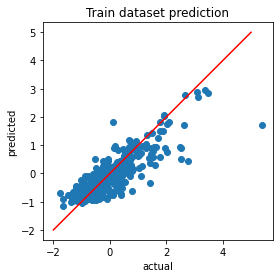

In [12]:
plt.scatter(y_train,y_pred_train)
plt.plot([-2,5],[-2,5],c='red')
plt.ylabel('predicted')
plt.xlabel('actual')    
plt.title('Train dataset prediction') 
plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\test_dataset_predicted_actual_best_train.jpg',dpi=600,bbox_inches='tight')

### Evaluating on validation dataset

rmse:0.6447313172904349 r2:0.5977055966059656  mae:0.45174780367162876 mape:1.711431028562187 


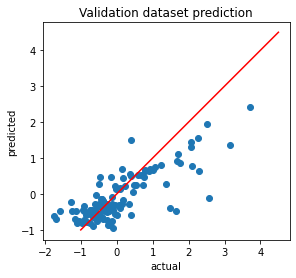

In [13]:
pred=SVM.predict(X_val) 
real=y_val   
rmse=np.sqrt(mean_squared_error(real,pred))
mae=mean_absolute_error(real,pred)
mape=mean_absolute_percentage_error(real,pred)
r2=r2_score(real,pred)
plt.scatter(real,pred)
plt.plot([-1,4.5],[-1,4.5],c='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel('predicted')
plt.xlabel('actual')    
plt.title('Validation dataset prediction')   
#plt.savefig(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\validation_dataset_predicted_actual_grad_boost_best.jpg',dpi=600,bbox_inches='tight')

print(f'rmse:{rmse} r2:{r2}  mae:{mae} mape:{mape} ')

### Evaluating on test dataset

rmse:1.1350907105372778 r2:-0.18628395121289643  mae:0.8536737915731115 mape:4.65688515071636 


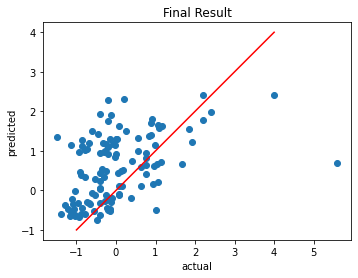

In [14]:
pred=SVM.predict(X_test) 
real=y_test   
rmse=np.sqrt(mean_squared_error(real,pred))
mae=mean_absolute_error(real,pred)
mape=mean_absolute_percentage_error(real,pred)
r2=r2_score(real,pred)

plt.scatter(real,pred)
plt.ylabel('predicted')
plt.xlabel('actual')  
plt.title('Final Result')
plt.plot([-1,4],[-1,4],c='red')
plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\test_dataset_grad_boost_best_train.jpg',dpi=600,bbox_inches='tight')   

print(f'rmse:{rmse} r2:{r2}  mae:{mae} mape:{mape} ')

### Saving the model

In [241]:
filename = 'best_model_only_train.sav'
pickle.dump(model, open(filename, 'wb'))
 
#load the model
loaded_model = pickle.load(open(filename, 'rb'))

In [242]:
loaded_model

RandomForestRegressor(n_estimators=180, random_state=100)

### Evaluate neural network on train and validation dataset

In [148]:
opt = keras.optimizers.Adam(lr=0.000018,beta_1=0.8,beta_2=0.994,epsilon=1e-7)
model=keras.models.Sequential([#keras.layers.Flatten(input_shape=[X_train.shape[0]]),
                               #keras.layers.BatchNormalization(),
                               #keras.layers.Dropout(rate=0.08),
                               keras.layers.Dense(2600,activation='selu'
                                                  ,kernel_initializer='lecun_normal'
                                                 #,kernel_regularizer=keras.regularizers.l2(0.1)
                                                 ),
                               #keras.layers.BatchNormalization(),
                               #keras.layers.Dropout(rate=0.07),
                               #keras.layers.Dense(300,activation='elu'
                                              #    ,kernel_initializer='glorot_normal'
                                               #  ,kernel_regularizer=keras.regularizers.l2(0.02)
                                                # ),
                               keras.layers.BatchNormalization(),
                               #keras.layers.Dropout(rate=0.05),
                               keras.layers.Dense(25,activation='selu'
                                                  ,kernel_initializer='lecun_normal'
                                                 #,kernel_regularizer=keras.regularizers.l2(0.1)
                                                 ),
                               keras.layers.BatchNormalization(),
                               keras.layers.Dense(1,activation='linear')])
#model.summary()
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.MeanSquaredError()])
import os
root_logdir=os.path.join(os.curdir,'my_logs')
def get_run_logdir():
    import time
    run_id=time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir,run_id)
run_logdir=get_run_logdir()
#tensorboard_cb=keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb=keras.callbacks.ModelCheckpoint('my_keras_model_2_layers_700_30.h5',save_best_only=True)
early_stopping_cb=keras.callbacks.EarlyStopping(patience=200,restore_best_weights=True)
history=model.fit(np.array(X_train),np.array(y_train),
epochs=4500,validation_data=(X_val,y_val),
                 callbacks=[checkpoint_cb,early_stopping_cb])

C:\Users\diego\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/4500
11/11 [==============================] - 1s 14ms/step - loss: 2.9364 - mean_squared_error: 2.9364 - val_loss: 1.4670 - val_mean_squared_error: 1.4670
Epoch 2/4500
11/11 [==============================] - 0s 4ms/step - loss: 1.0036 - mean_squared_error: 1.0036 - val_loss: 1.2282 - val_mean_squared_error: 1.2282
Epoch 3/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.7832 - mean_squared_error: 0.7832 - val_loss: 1.1247 - val_mean_squared_error: 1.1247
Epoch 4/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.6376 - mean_squared_error: 0.6376 - val_loss: 0.9722 - val_mean_squared_error: 0.9722
Epoch 5/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.6035 - mean_squared_error: 0.6035 - val_loss: 0.8771 - val_mean_squared_error: 0.8771
Epoch 6/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.5535 - mean_squared_error: 0.5535 - val_loss: 0.8058 - val_mean_squared_error: 0.8058
Epoch 7/4500
11/11 [=======

11/11 [==============================] - 0s 4ms/step - loss: 0.2321 - mean_squared_error: 0.2321 - val_loss: 0.3078 - val_mean_squared_error: 0.3078
Epoch 102/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2229 - mean_squared_error: 0.2229 - val_loss: 0.3245 - val_mean_squared_error: 0.3245
Epoch 103/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2182 - mean_squared_error: 0.2182 - val_loss: 0.2956 - val_mean_squared_error: 0.2956
Epoch 104/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2343 - mean_squared_error: 0.2343 - val_loss: 0.3229 - val_mean_squared_error: 0.3229
Epoch 105/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2433 - mean_squared_error: 0.2433 - val_loss: 0.3310 - val_mean_squared_error: 0.3310
Epoch 106/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2677 - mean_squared_error: 0.2677 - val_loss: 0.3129 - val_mean_squared_error: 0.3129
Epoch 107/4500
11/11 [=========

11/11 [==============================] - 0s 4ms/step - loss: 0.2394 - mean_squared_error: 0.2394 - val_loss: 0.3239 - val_mean_squared_error: 0.3239
Epoch 152/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2463 - mean_squared_error: 0.2463 - val_loss: 0.3496 - val_mean_squared_error: 0.3496
Epoch 153/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2131 - mean_squared_error: 0.2131 - val_loss: 0.3241 - val_mean_squared_error: 0.3241
Epoch 154/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2310 - mean_squared_error: 0.2310 - val_loss: 0.3286 - val_mean_squared_error: 0.3286
Epoch 155/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2123 - mean_squared_error: 0.2123 - val_loss: 0.3152 - val_mean_squared_error: 0.3152
Epoch 156/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2349 - mean_squared_error: 0.2349 - val_loss: 0.3427 - val_mean_squared_error: 0.3427
Epoch 157/4500
11/11 [=========

11/11 [==============================] - 0s 4ms/step - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 0.3226 - val_mean_squared_error: 0.3226
Epoch 202/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2065 - mean_squared_error: 0.2065 - val_loss: 0.3281 - val_mean_squared_error: 0.3281
Epoch 203/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1729 - mean_squared_error: 0.1729 - val_loss: 0.3317 - val_mean_squared_error: 0.3317
Epoch 204/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1867 - mean_squared_error: 0.1867 - val_loss: 0.3560 - val_mean_squared_error: 0.3560
Epoch 205/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1934 - mean_squared_error: 0.1934 - val_loss: 0.3179 - val_mean_squared_error: 0.3179
Epoch 206/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2182 - mean_squared_error: 0.2182 - val_loss: 0.3204 - val_mean_squared_error: 0.3204
Epoch 207/4500
11/11 [=========

11/11 [==============================] - 0s 4ms/step - loss: 0.1699 - mean_squared_error: 0.1699 - val_loss: 0.3355 - val_mean_squared_error: 0.3355
Epoch 252/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2018 - mean_squared_error: 0.2018 - val_loss: 0.3313 - val_mean_squared_error: 0.3313
Epoch 253/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1770 - mean_squared_error: 0.1770 - val_loss: 0.3185 - val_mean_squared_error: 0.3185
Epoch 254/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1907 - mean_squared_error: 0.1907 - val_loss: 0.3351 - val_mean_squared_error: 0.3351
Epoch 255/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1887 - mean_squared_error: 0.1887 - val_loss: 0.3302 - val_mean_squared_error: 0.3302
Epoch 256/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1711 - mean_squared_error: 0.1711 - val_loss: 0.3201 - val_mean_squared_error: 0.3201
Epoch 257/4500
11/11 [=========

11/11 [==============================] - 0s 4ms/step - loss: 0.1968 - mean_squared_error: 0.1968 - val_loss: 0.3557 - val_mean_squared_error: 0.3557
Epoch 302/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1709 - mean_squared_error: 0.1709 - val_loss: 0.3550 - val_mean_squared_error: 0.3550
Epoch 303/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1861 - mean_squared_error: 0.1861 - val_loss: 0.3269 - val_mean_squared_error: 0.3269
Epoch 304/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1754 - mean_squared_error: 0.1754 - val_loss: 0.3476 - val_mean_squared_error: 0.3476
Epoch 305/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1817 - mean_squared_error: 0.1817 - val_loss: 0.3412 - val_mean_squared_error: 0.3412
Epoch 306/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1752 - mean_squared_error: 0.1752 - val_loss: 0.3243 - val_mean_squared_error: 0.3243
Epoch 307/4500
11/11 [=========

11/11 [==============================] - 0s 4ms/step - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.3939 - val_mean_squared_error: 0.3939
Epoch 352/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1667 - mean_squared_error: 0.1667 - val_loss: 0.3814 - val_mean_squared_error: 0.3814
Epoch 353/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.3957 - val_mean_squared_error: 0.3957
Epoch 354/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1486 - mean_squared_error: 0.1486 - val_loss: 0.3970 - val_mean_squared_error: 0.3970
Epoch 355/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1522 - mean_squared_error: 0.1522 - val_loss: 0.3260 - val_mean_squared_error: 0.3260
Epoch 356/4500
11/11 [==============================] - 0s 4ms/step - loss: 0.1662 - mean_squared_error: 0.1662 - val_loss: 0.3478 - val_mean_squared_error: 0.3478
Epoch 357/4500
11/11 [=========

### Saving the model

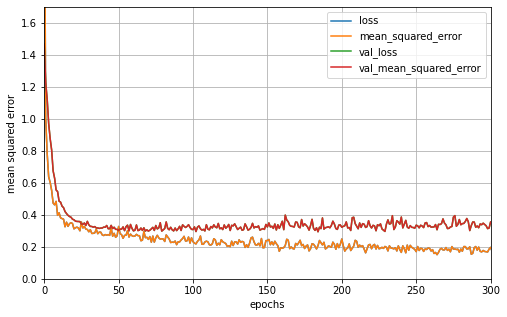

In [161]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_xlim(0,300)
plt.gca().set_ylim(0,1.7)
plt.xlabel('epochs')
plt.ylabel('mean squared error')
#model.save(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\my_keras_model_layers_2600_25_linear!!_10.h5')
#plt.savefig(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\my_keras_model_layers_2600_25_linear!!_7.png')

### Predict on test dataset

rmse:0.43062023977200553 r2:0.8292674240053359  mae:0.34011389198597936 mape:1.6911960636435472 
rmse validation dataset:0.4682974873094415 r2 validation dataset:0.787758594244337  mae validation dataset:0.3412472098261595 mape validation dataset:1.4385847502364602 


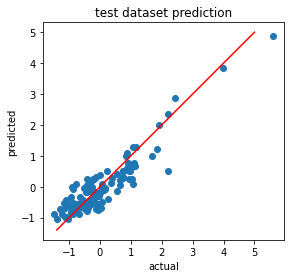

In [177]:
model=keras.models.load_model(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\my_keras_model_layers_2600_25_linear!!_7.h5') 
pred_val=model.predict(X_val) 
pred=model.predict(X_test) 
pred_train=model.predict(X_train) 
real=y_test
real_val=y_val
real_train=y_train


rmse=np.sqrt(mean_squared_error(real,pred))
mae=mean_absolute_error(real,pred)
mape=mean_absolute_percentage_error(real,pred)
r2=r2_score(real,pred)

rmse_val=np.sqrt(mean_squared_error(real_val,pred_val))
mae_val=mean_absolute_error(real_val,pred_val)
mape_val=mean_absolute_percentage_error(real_val,pred_val)
r2_val=r2_score(real_val,pred_val)

#rmse_train=np.sqrt(mean_squared_error(real_train,pred_train))
#mae_train=mean_absolute_error(real_train,pred_train)
#mape_train=mean_absolute_percentage_error(real_train,pred_train)
#r2_train=r2_score(real_train,pred_train)

plt.scatter(real,pred)
plt.ylabel('predicted')
plt.xlabel('actual')  
plt.title('test dataset prediction')
plt.plot([-1.4,5],[-1.4,5],c='red')
plt.gca().set_aspect('equal',adjustable='box') 
#plt.xlim((-2,3))
#plt.ylim((-1.5,3))   
#plt.savefig(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\test_dataset_nn_best_train.jpg',dpi=600,bbox_inches='tight')    
print(f'rmse:{rmse} r2:{r2}  mae:{mae} mape:{mape} ')
print(f'rmse validation dataset:{rmse_val} r2 validation dataset:{r2_val}  mae validation dataset:{mae_val} mape validation dataset:{mape_val} ')
#print(f'rmse train dataset:{rmse_train} r2 train dataset:{r2_train}  mae train dataset:{mae_train} mape train dataset:{mape_train} ')

### Best model parameters

In [154]:
model=keras.models.load_model(r'C:\\Users\diego\OneDrive\Desktop\DS\machine_learning_course_project\lists\my_keras_model_layers_2600_25_linear!!_7.h5') 
model.summary()

#to visualize activation functions
for i, layer in enumerate (model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')
#specific info about each layer
for i in range(len(model.layers)):
    print(f'{i}   {model.layers[i]}: \n{model.layers[i].get_config()} \n')
#info about optimizers
model.optimizer.get_config()      

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2600)              31200     
_________________________________________________________________
batch_normalization_6 (Batch (None, 2600)              10400     
_________________________________________________________________
dense_10 (Dense)             (None, 25)                65025     
_________________________________________________________________
batch_normalization_7 (Batch (None, 25)                100       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 26        
Total params: 106,751
Trainable params: 101,501
Non-trainable params: 5,250
_________________________________________________________________
0 <tensorflow.python.keras.layers.core.Dense object at 0x0000022AB74081F0>
     <function selu at 0x000002293C

{'name': 'Adam',
 'learning_rate': 1.8000001e-05,
 'decay': 0.0,
 'beta_1': 0.80000001,
 'beta_2': 0.99400002,
 'epsilon': 1e-07,
 'amsgrad': False}

## RESULT: 

### rmse:0.43062023977200553 r2:0.8292674240053359  mae:0.34011389198597936 mape:1.6911960636435472 
### rmse validation dataset:0.4682974873094415 r2 validation dataset:0.787758594244337  mae validation dataset:0.3412472098261595 mape validation dataset:1.4385847502364602 
